In [1]:
# -*- coding: Paper1 -*-
"""
This code belongs to the paper:
-- An Iterative Gradient Descent-Based Reinforcement Learning Policy 
   for Active Control of Structural Vibrations, Computers & Structures.
-- Jagajyoti Panda, Mudit Chopra, Vasant Matsagar, Souvik Chakraborty, IIT Delhi.
   
This code is to present RL-based control algorithm in proportional (P) to state feedback.
-- Case study II: 8-story benchmark building
   State-space representation, Policy parameter update, Efficacy of trained RL-controller
"""
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import os 
from numpy import abs as Abs
from numpy import sign as sign
from numpy import sqrt,pi,array
from scipy import signal
 
 
import matplotlib
import matplotlib.pyplot as plt

from control.matlab import *  # MATLAB-like functions
import control as ct
 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# System dynamics for the MDOF system

# System parameters
nod = 1  
amp = 3  # amplification factor
n = 8    # Number of storey
r = 3    # no of MR dampers
theta = np.zeros((n,r))
theta[0,0]=1 
theta[3,1]=1
theta[5,2]=1

dampmax = 1000000*nod*amp    # Max MR Damper force
m = 345600   # Lumped mass in KG
M = np.diag(np.full(n,m))   
# print(M)    # Mass matrix
del m

kk = 3444*10**5
K = 2*np.diag(np.full(n,kk))
K[n-1,n-1] = kk
for x in range(n-1):
  K[x,x+1] = -kk
  K[x+1,x] = -kk
# print(K)   # stiffness matrix
del x,kk

cc = 2937000    # Inherent damping
C = 2*np.diag(np.full(n,cc))
C[n-1,n-1] = cc
for x in range(n-1):
  C[x,x+1] = -cc
  C[x+1,x] = -cc
# print(C)   # stiffness matrix
del x,cc

from numpy.linalg import eig
W,V=eig(np.linalg.inv(M) @ K)  # Eigen Analysis
omega=sqrt(W)  # Frequency rad/sec
oma=array(omega)  
fn=oma/(2*pi)  # Frequency Hz
# print('E-value:', omega)
# print('E-vector', V)
del W,V,omega,oma

gbar=np.diag(np.full(n,1))
for x in range(n-1):
  gbar[x,x+1] = -1
gamma=gbar @ theta
# print(gamma)

del x,theta

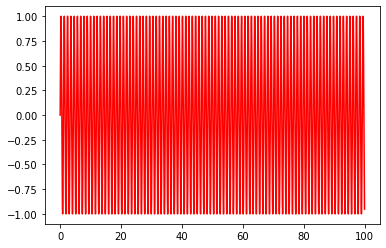

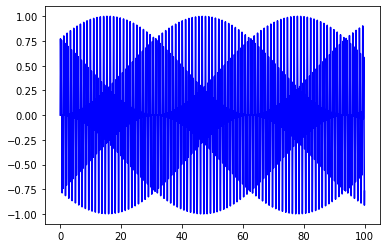

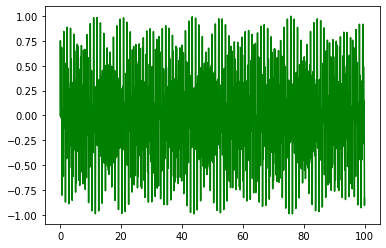

In [3]:
# Input Road Profile
T = 100
dt = 0.01
t = np.arange(0, T+dt, dt)
# amplitude   = 1*np.sin(t)
amplitude   = 1*np.sin(2 * np.pi * 0.927 * t)
amplitude1   = (1/2)*(np.sin(2 * np.pi * 0.927 * t) + np.sin(2 * np.pi * 2.749 * t))
amplitude2   = (1/3)*(np.sin(2 * np.pi * 0.927 * t) + np.sin(2 * np.pi * 2.749 * t) + np.sin(2 * np.pi * 4.478 * t))
len(t)
plt.figure()
plt.plot(t, amplitude,'r')
plt.figure()
plt.plot(t, amplitude1,'b')
plt.figure()
plt.plot(t, amplitude2,'g') 

C:\Users\jagaj\AppData\Local\Temp\ipykernel_28440\77624054.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(0, 100)
C:\Users\jagaj\AppData\Local\Temp\ipykernel_28440\77624054.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_xlim(0, 100)
C:\Users\jagaj\AppData\Local\Temp\ipykernel_28440\77624054.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_xlim(0, 100)


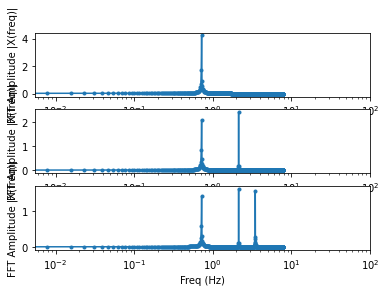

In [5]:
# Fast fourier transform (FFT)
sr = 1/dt  # sampling frequency
N1 = 2048  # Number of samples
fstep = sr/N1  # freq interval
f = np.linspace(0, (N1-1)*fstep, N1)

# Perform FFT
X = np.fft.fft(amplitude)
X_mag = np.abs(X)/N1

X1 = np.fft.fft(amplitude1)
X1_mag = np.abs(X1)/N1

X2 = np.fft.fft(amplitude2)
X2_mag = np.abs(X2)/N1

f_plot = f[0:int(N1/2+1)]/(2 * np.pi)
X_mag_plot = 2*X_mag[0:int(N1/2+1)]
X_mag_plot[0] = X_mag_plot[0] / 2 # DC component does not need to multiply by 2

X1_mag_plot = 2*X1_mag[0:int(N1/2+1)]
X1_mag_plot[0] = X1_mag_plot[0] / 2 # DC component does not need to multiply by 2

X2_mag_plot = 2*X2_mag[0:int(N1/2+1)]
X2_mag_plot[0] = X2_mag_plot[0] / 2 # DC component does not need to multiply by 2

# Plot 
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1)
ax1.plot(f_plot, X_mag_plot, '.-')
ax2.plot(f_plot, X1_mag_plot, '.-')
ax3.plot(f_plot, X2_mag_plot, '.-')
ax3.set_xlabel('Freq (Hz)')
ax1.set_ylabel('FFT Amplitude |X(freq)|')
ax2.set_ylabel('FFT Amplitude |X(freq)|')
ax3.set_ylabel('FFT Amplitude |X(freq)|')
ax1.semilogx()
ax2.semilogx()
ax3.semilogx()
ax1.set_xlim(0, 100)
ax2.set_xlim(0, 100)
ax3.set_xlim(0, 100)
plt.show()

In [8]:
# State space representation
I = -1*np.ones([n,1])  # Influence vector
A1 = np.zeros([n,n])
A2 = np.identity(n)
A3 = -1*np.linalg.inv(M) @ K
A4 = -1*np.linalg.inv(M) @ C
A = np.zeros([2*n,2*n])
A[0:n,n:2*n] = A2
A[n:2*n,0:n] = A3
A[n:2*n,n:2*n] = A4
# = np.ones((n,n), dtype=int)
print(A)  
B = np.zeros((2*n,r))
B[n:2*n,0:r] = np.linalg.inv(M) @ gamma   # Input matrix
print(B)
E = np.zeros((2*n,1))
E[n:2*n] = I   # Input matrix
print(E)
# Output matrix (Disp + Accel)
Cd = np.zeros([n+r, 2*n])
Cd[0:n, 0:n] = A3;
Cd[0:n, n:2*n] = A4;
Cd[n,0:2] =  np.array([[1, 1]])
Cd[n+1,2:5] =  np.array([[1, 1, 1]])
Cd[n+2,5:8] =  np.array([[1, 1, 1]])
print(Cd)
Dd = np.zeros([n+r, r])
Dd[0:n,0:r] = np.linalg.inv(M) @ gamma   # Input matrix
print(Dd)
Ed = np.zeros([n+r,1])
print(Ed)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00

In [27]:
# Digital system (correct)
Ad =np.array([[0.9089,	0.0431,	0.0016,	0,	0,	0,	0,	0,	0.0089,	0.0005,	0,	0,	0,	0,	0,	0],
              [0.0431,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0,	0,	0,	0,	0],
              [0.0016,	0.0432,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0,	0,	0,	0],
              [0.0000,	0.0016,	0.0432,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0,	0,	0],
              [0.0000,	0,	0.0016,	0.0432,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0,	0],
              [0.0000,	0,	0,	0.0016,	0.0432,	0.9104,	0.0432,	0.0016,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005,	0],
              [0.0000,	0,	0,	0,	0.0016,	0.0432,	0.9105,	0.0447,	0,	0,	0,	0,	0,	0.0005,	0.0089,	0.0005],
              [0.0000,	0,	0,	0,	0,	0.0016,	0.0447,	0.9536,	0,	0,	0,	0,	0,	0,	0.0005,	0.0094],
              [-17.2450,	7.8662,	0.4817,	0.0164,	0.0004,	0,	0,	0,	0.7618,	0.1102,	0.0057,	0.0002,	0,	0,	0,	0],
              [7.8662,	-16.7634,	7.8826,	0.482,	0.0164,	0.0004,	0,	0,	0.1102,	0.7675,	0.1104,	0.0057,	0.0002,	0,	0,	0],
              [0.4817,	7.8826,	-16.763,	7.8826,	0.482,	0.0164,	0.0004,	0,	0.0057,	0.1104,	0.7675,	0.1104,	0.0057,	0.0002,	0,	0],
              [0.0164,	0.482,	7.8826,	-16.763,	7.8826,	0.482,	0.0164,	0.0004,	0.0002,	0.0057,	0.1104,	0.7675,	0.1104,	0.0057,	0.0002,	0],
              [0.0004,	0.0164,	0.482,	7.8826,	-16.763,	7.8826,	0.4821,	0.0168,	0,	0.0002,	0.0057,	0.1104,	0.7675,	0.1104,	0.0057,	0.0002],
              [0.0000,	0.0004,	0.0164,	0.482,	7.8826,	-16.763,	7.883,	0.4985,	0,	0,	0.0002,	0.0057,	0.1104,	0.7675,	0.1104,	0.0059],
              [0.0000,	0,	0.0004,	0.0164,	0.4821,	7.883,	-16.7466,	8.3647,	0,	0,	0,	0.0002,	0.0057,	0.1104,	0.7677,	0.1161],
              [0.0000,	0,	0,	0.0004,	0.0168,	0.4985,	8.3647,	-8.8804,	0,	0,	0,	0,	0.0002,	0.0059,	0.1161,	0.8779]])
print(Ad)
Bd  = np.array([[1.34702468304747E-10,	-1.15672784046959E-13,	-3.33223374028602E-17],
               [4.80538564665434E-12,	-4.68967910640923E-12,	-2.18046675626884E-15],
               [1.17886577963029E-13,	-1.30012788764478E-10,	-1.15706111159729E-13],
               [2.2137939169218E-15,	1.30012788769298E-10,	-4.68967953544642E-12],
               [3.37561986981929E-17,	4.68967953549301E-12,	-1.30012788764477E-10],
               [4.33862421178217E-19,	1.15706111207136E-13,	1.30012789198338E-10],
               [4.82365420392012E-21,	2.1804715802934E-15,	4.68971286260631E-12],
               [4.76906938178176E-23,	3.37561991045439E-17,	1.17886577963177E-13],
               [2.57851128124862E-08,	-4.88918641729282E-11,	-2.13266602760077E-14],
               [1.49750412070413E-09,	-1.4485906057431E-09,	-1.1612850802489E-12],
               [5.00744800217048E-11,	-2.43365218826153E-08,	-4.89131948958366E-11],
               [1.182615848769E-12,	2.43365218867235E-08,	-1.44859092576268E-09],
               [2.16507881080578E-14,	1.44859092580829E-09,	-2.43365218826153E-08],
               [3.2412782161542E-16,	4.89131949414518E-11,	2.43365222067431E-08],
               [4.1082484210822E-18,	1.16128918848908E-12,	1.4486122565312E-09],
               [4.56140126500856E-20,	2.16507881049024E-14,	5.0074480021704E-11]])
print(Bd)

Ed = np.array([[-4.82554328318935E-05,	-4.99576926176694E-05,	-4.99992111239577E-05,	-4.99999880289061E-05,	-4.99999998466733E-05,	-4.99999999982996E-05,	-4.99999999999823E-05,	-4.99999999999999E-05,	-0.00944659446040994,	-0.00998185393282461,	-0.009999575981124,	-0.00999999228912783,	-0.00999999988509437,	-0.0099999999985485,	-0.00999999999998409,	-0.00999999999999984,	]]).T
print(Ed)
np.save('Ad.npy', Ad)
np.save('Bd.npy', Bd)
np.save('Ed.npy', Ed)

[[ 9.08900e-01  4.31000e-02  1.60000e-03  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  8.90000e-03  5.00000e-04
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 4.31000e-02  9.10400e-01  4.32000e-02  1.60000e-03  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  5.00000e-04  8.90000e-03
   5.00000e-04  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 1.60000e-03  4.32000e-02  9.10400e-01  4.32000e-02  1.60000e-03
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  5.00000e-04
   8.90000e-03  5.00000e-04  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  1.60000e-03  4.32000e-02  9.10400e-01  4.32000e-02
   1.60000e-03  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   5.00000e-04  8.90000e-03  5.00000e-04  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  0.00000e+00  1.60000e-03  4.32000e-02  9.10400e-01
   4.32000e-02  1.60000e-03  0.00000e+00  0.00000e+00  0.00000e+0

In [28]:
ko = matrix_rank(ctrb(Ad, Bd))
if ko == len(Ad):
  print("System is controllable")
else:
  print("System is uncontrollable")

NameError: name 'matrix_rank' is not defined

[[-8.29766179e+03 -7.03733971e+01  1.33919500e+01 -9.47522663e+00
  -4.91868603e+00 -2.16553346e+00 -1.72193599e+00 -2.14815873e+00
   1.61617041e+03  1.73002379e+03  1.74545038e+03  1.76043233e+03
   1.77259544e+03  1.78172685e+03  1.78781365e+03  1.79085251e+03]
 [-2.62492895e+01  9.07093718e+01  8.20891644e+03 -8.21099671e+03
  -9.46236597e+01  1.86031013e+01 -3.28433170e+00 -2.54079204e+00
   1.49605070e+01  2.74722928e+01  1.38240258e+02  1.64955373e+03
   1.75733368e+03  1.76384845e+03  1.76964754e+03  1.77266772e+03]
 [-2.64227972e+00 -4.61378003e+00 -2.83954473e+01  8.69736898e+01
   8.20724996e+03 -8.21241497e+03 -9.94943520e+01  2.01217882e+01
   9.10450720e+00  1.81906773e+01  2.70298349e+01  3.35556856e+01
   1.38325566e+02  1.64362727e+03  1.74531013e+03  1.74564908e+03]]
[[-9.99338538e+05  2.11302314e+02  2.96337727e+03 -6.24139560e+03
   2.89563930e+03  1.21944348e+04  1.44002857e+04  1.04264006e+04
   1.85204503e+05  1.84529916e+05  1.74628147e+05  1.67176552e+05
   1.6

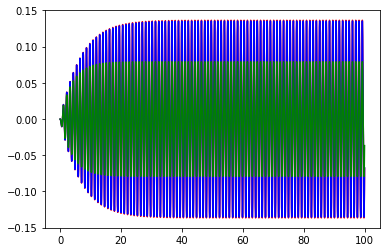

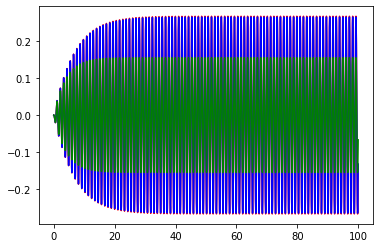

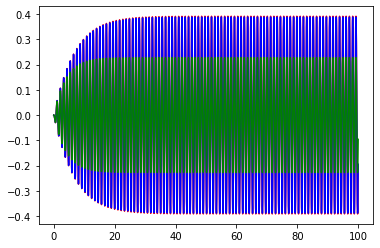

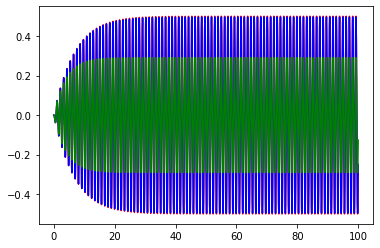

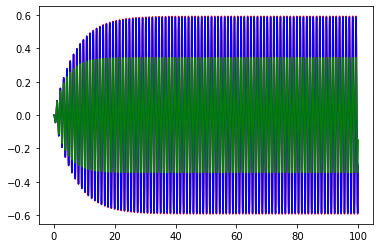

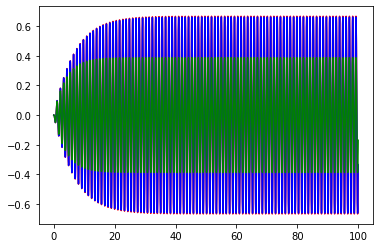

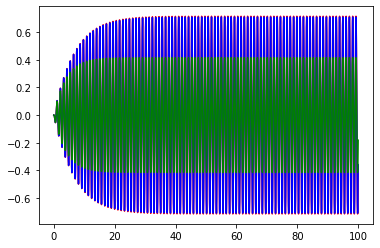

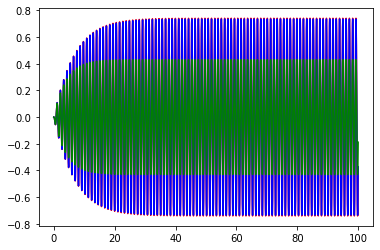

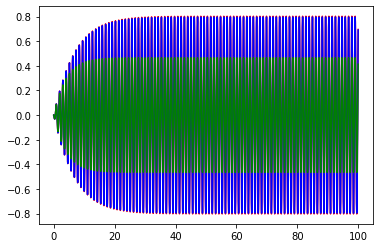

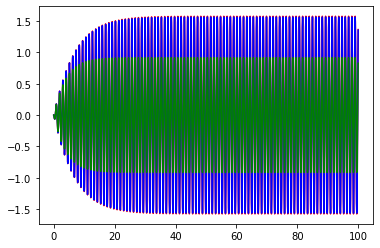

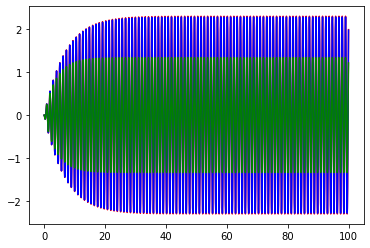

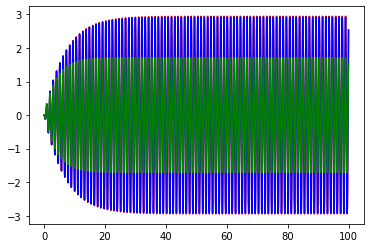

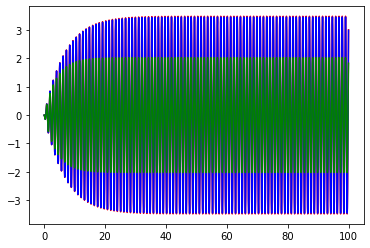

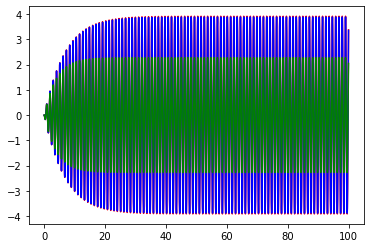

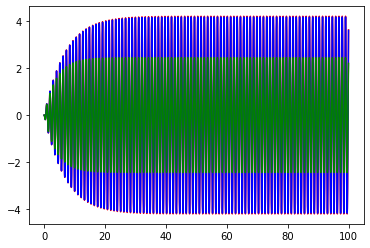

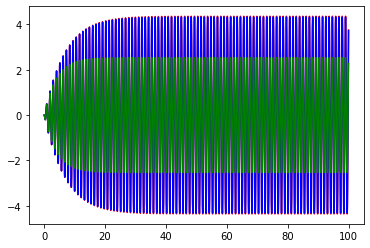

In [29]:
# Initial controller gain (proportional)
Qp_i = np.identity(2*n)
# Kp, Sp, ep = ct.dlqr(Ad, Bd, Qp_i, Rp)
# print(Kp)  # Discrete time
(i,j)=Bd.shape
Rp_i =  (10**(-10))*np.identity(j)
Rp_o =  (10**(-12.1))*np.identity(j)
Kp, Sp, ep = ct.dlqr(Ad, Bd, Qp_i, Rp_i)
Kpo, Spo, epo = ct.dlqr(Ad, Bd, Qp_i, Rp_o)
print(Kp)
print(Kpo)
# Time series analysis
xo = np.zeros((len(t),2*n))
(i,j) = Cd.shape
yo = np.zeros((len(t),i))
xp = np.zeros((len(t),2*n))
xp2 = np.zeros((len(t),2*n))
(i,j) = Cd.shape
yp = np.zeros((len(t),i))
yp2 = np.zeros((len(t),i))
del i,j

for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    y = (Cd @ np.array([xo[tkk,:]]).T)
    yo[tkk,:] = y.T
    x = (Ad @ np.array([xo[tkk,:]]).T) + (Ed * amplitude[tkk])
    xo[tkk+1,:] = x.T
    y1 = (Cd @ np.array([xp2[tkk,:]]).T) + (Dd @ ((-1*Kpo) @ np.array([xp2[tkk,:]]).T))
    yp2[tkk,:] = y1.T
    x1 = (Ad @ np.array([xp2[tkk,:]]).T) + (Bd @ ((-1*Kpo) @ np.array([xp2[tkk,:]]).T)) + (Ed * amplitude[tkk])
    xp2[tkk+1,:] = x1.T
    y2 = (Cd @ np.array([xp[tkk,:]]).T) + (Dd @ ((-1*Kp) @ np.array([xp[tkk,:]]).T))
    yp[tkk,:] = y2.T
    x2 = (Ad @ np.array([xp[tkk,:]]).T) + (Bd @ ((-1*Kp) @ np.array([xp[tkk,:]]).T)) + (Ed * amplitude[tkk])
    xp[tkk+1,:] = x2.T
for i in range(2*n):
    plt.figure()
    plt.plot(t, xo[:,i], 'r', t, xp[:,i], 'b', t, xp2[:,i], 'g')

(50, 3)
None


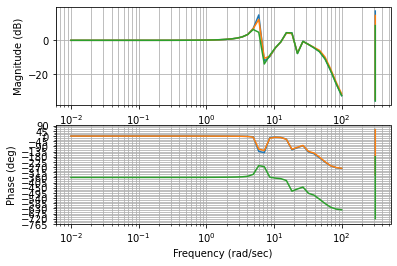

In [45]:
# Bode plot for the system (uncontrolled)
BKt = np.load('BKt_P8.npy')
Cd1 = np.load('Cd1_P8.npy')
plt.figure()
bode(ss(Ad, Ed, Cd[1, :], np.zeros([1]), dt), logspace(-2, 2), plot=True)
bode(ss(Ad-(Bd@Kpo), Ed, Cd[1, :]-(Dd[1, :]@Kpo), np.zeros([1]), dt), logspace(-2, 2), plot=True)
mag_pc, phase_pc, om_pc = bode(ss(Ad-BKt, Ed, Cd1[1, :]-BKt[1,:], np.zeros([1]), dt), logspace(-2, 2), plot=True)

In [32]:
# propertional (Discrete)
Bj_p = Bd @ (-1*Kp) 
Al_p = Ad.T + Bj_p.T 
Qp = np.identity(2*n)
P_p = dlyap(Al_p, -Qp)
Ki = P_p@Bj_p

In [33]:
# P-controller (discrete)
# Policy parameter update
Zmax = 501 # No of episodes
# Qp = np.array([[Ks, -Ks, 0, 0],
#             [-Ks, Ks+Kt, 0, 0],
#             [0, 0, M, 0],
#             [0, 0, 0, m]])
Qp = np.identity(2*n)
BK = np.zeros([2*n,2*n,Zmax])
BK[0:2*n,0:2*n,0] = Bj_p  # Initial Stiffness
djdk_d = np.zeros([2*n,2*n,Zmax])  # Gradient
alpha = 40.0  
xd = np.zeros([len(t), 2*n, Zmax])  # State
pd = np.zeros([len(t), 2*n, Zmax])  # Adjoint State
done = False
J_cd = np.zeros([len(t), 1, Zmax])  # Cost function
E_cd = np.zeros([len(t), 1, Zmax])  # Structure's energy
val_arr = np.zeros([len(t), 1, Zmax]) # x.T*K*x
sd = []  # number of tau_s

for id in range(0, Zmax-1):  
  BKo = BK[0:2*n,0:2*n,id] 
  print(BKo)
  for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    h = amplitude[tkk] 
    xn = np.array([xd[tkk,:,id]]).T
    xn1 = (Ad @ xn) + (BKo @ xn) + (Ed * h)
#     print(xn1)
    xd[tkk+1,:,id] = xn1.T
    En1 = 0.5*((xn1.T @ Qp)@xn1)
    E_cd[tkk+1,:,id] = En1
    Jn1 = J_cd[tkk,:,id] + dt*(En1)
    J_cd[tkk+1,:,id] = Jn1  # Cost functional
    del xn,xn1
  print(Jn1)  
  # Adjoint State  
  sd.append([])
  for tkk in range(0,len(t)-1):
    i = len(t)-1-tkk
#     print(i)
    xn = np.array([xd[i,:,id]]).T
    val = (xn.T @ BKo) @ xn
#     print(val)
    val_arr[i,:,id] = val
    if(val==0):
      pn = np.array([pd[i,:,id]]).T
      sd[id].append(i)
      d_ptau1 = (pn.T@BKo)@xn  # (1*n)@(n*n)@(n*1)
#       print(val)
      d_ptau = (d_ptau1[0,0]*((BKo + BKo.T)@xn))      #1*(1*1)*((n*n)@(n*1))  #############
#       d_ptau = (d_ptau1[0,0]*xn)      #1*(1*1)*((n*n)@(n*1))  #############
#       print(d_ptau)
      pnb1 = pn + d_ptau  # (n*1)
      pd[i-1,:,id] = pnb1.T
    else:
      if(val[0]<0.000001 and val[0] >-0.000001):
        sd[id].append(i)
      pn = np.array([pd[i,:,id]]).T
      F = Qp@xn 
      pnb1 = (-Ad.T @ pn) + (-BKo.T @ pn) + (F)
      pd[i-1,:,id] = pnb1.T
#     print(p[i-1,:,id])
    del xn, val, pn, pnb1, i
    
  # Evaluate dj/dk
  sum = djdk_d[0:2*n,0:2*n,id]
  print(len(sd[id]))
  if(len(sd[id])>0):
    for j in sd[id]:
        xn = np.array([xd[j,:,id]]).T
        pn = np.array([pd[j,:,id]]).T
        sum1 = (pn.T@BKo)@xn  # (1*n)@(n*n)@(n*1)
        sum = sum +  ((-1)*(sum1[0,0]*(xn@xn.T)))  # 1*(1*1)*((n*1)@(1*n))  #############
    print(sum)
    djdk_d[0:2*n,0:2*n,id] = sum
  # Update K 
#     alpha = 2*id
    BK[0:2*n,0:2*n,id+1] = BK[0:2*n,0:2*n,id]  - alpha*djdk_d[0:2*n,0:2*n,id]
  else:
    print(np.linalg.norm(djdk_d[0:2*n,0:2*n,id]))
#     break
      

[[ 1.11771249e-06  9.48996274e-09 -8.54381451e-10  3.26550464e-10
   6.51887252e-10  2.93580918e-10  2.31565805e-10  2.89069054e-10
  -2.17700413e-07 -2.33035296e-07 -2.35100483e-07 -2.36943770e-07
  -2.38569700e-07 -2.39798921e-07 -2.40618153e-07 -2.41027145e-07]
 [ 3.97503583e-08  7.63559098e-10  3.84327685e-08 -3.84612179e-08
  -4.02222781e-10  7.97419011e-11 -7.34483939e-12 -1.54889331e-12
  -7.69614227e-09 -8.18455559e-09 -7.73920083e-09 -7.23605382e-10
  -2.76372014e-10 -2.86417549e-10 -2.88249349e-10 -2.88687831e-10]
 [-2.43486610e-09  1.18011406e-08  1.06725926e-06 -1.06752340e-06
  -1.13520771e-08  1.46866977e-09 -4.38314235e-10 -3.27754006e-10
   1.75558589e-09  3.36990759e-09  1.77703638e-08  2.14259432e-07
   2.28282892e-07  2.29302992e-07  2.30067996e-07  2.30460339e-07]
 [ 3.41872119e-09 -1.18148598e-08 -1.06739731e-06  1.06794248e-06
   5.07916689e-08 -4.09322307e-08 -3.95876902e-11  4.24704953e-10
  -1.90593789e-09 -3.49027087e-09 -1.78501042e-08 -2.14309613e-07
  -2.27

13
[[1.08357250e-12 1.61903480e-12 1.83132001e-12 1.89681590e-12
  1.91321867e-12 1.91564470e-12 1.91582723e-12 1.91539075e-12
  2.17149754e-11 3.64743449e-11 4.43981493e-11 4.76332716e-11
  4.86661122e-11 4.89166173e-11 4.89706843e-11 4.89885748e-11]
 [1.61903480e-12 2.42102300e-12 2.73974966e-12 2.83830244e-12
  2.86301817e-12 2.86668106e-12 2.86695230e-12 2.86629461e-12
  3.23213170e-11 5.43470588e-11 6.62094052e-11 7.10667516e-11
  7.26210251e-11 7.29988887e-11 7.30804974e-11 7.31074378e-11]
 [1.83132001e-12 2.73974966e-12 3.10131341e-12 3.21326472e-12
  3.24136570e-12 3.24553588e-12 3.24584188e-12 3.24509425e-12
  3.64775678e-11 6.13726121e-11 7.48053859e-11 8.03155917e-11
  8.20812679e-11 8.25111603e-11 8.26040493e-11 8.26346684e-11]
 [1.89681590e-12 2.83830244e-12 3.21326472e-12 3.32943511e-12
  3.35860705e-12 3.36293888e-12 3.36325556e-12 3.36247953e-12
  3.77466831e-11 6.35236729e-11 7.74434024e-11 8.31577959e-11
  8.49900565e-11 8.54364551e-11 8.55329328e-11 8.55647139e-11]
 

13
[[1.09065461e-12 1.62959786e-12 1.84325531e-12 1.90917231e-12
  1.92568014e-12 1.92812161e-12 1.92830533e-12 1.92786605e-12
  2.18581051e-11 3.67142107e-11 4.46895849e-11 4.79456200e-11
  4.89851002e-11 4.92372059e-11 4.92916173e-11 4.93096226e-11]
 [1.62959786e-12 2.43679186e-12 2.75757627e-12 2.85676204e-12
  2.88163593e-12 2.88532212e-12 2.88559512e-12 2.88493322e-12
  3.25338859e-11 5.47037173e-11 6.66431484e-11 7.15318556e-11
  7.30961107e-11 7.34763867e-11 7.35585151e-11 7.35856280e-11]
 [1.84325531e-12 2.75757627e-12 3.12147251e-12 3.23414241e-12
  3.26242311e-12 3.26661980e-12 3.26692779e-12 3.26617536e-12
  3.67171597e-11 6.17748801e-11 7.52948618e-11 8.08406161e-11
  8.26176242e-11 8.30502599e-11 8.31437401e-11 8.31745551e-11]
 [1.90917231e-12 2.85676204e-12 3.23414241e-12 3.35105825e-12
  3.38041671e-12 3.38477606e-12 3.38509480e-12 3.38431380e-12
  3.79944737e-11 6.39398203e-11 7.79498815e-11 8.37011280e-11
  8.55451444e-11 8.59943910e-11 8.60914826e-11 8.61234670e-11]
 

13
[[1.09778321e-12 1.64023028e-12 1.85526897e-12 1.92160984e-12
  1.93822342e-12 1.94068043e-12 1.94086535e-12 1.94042325e-12
  2.20021751e-11 3.69556520e-11 4.49829347e-11 4.82600197e-11
  4.93061831e-11 4.95598998e-11 4.96146581e-11 4.96327787e-11]
 [1.64023028e-12 2.45266425e-12 2.77551989e-12 2.87534282e-12
  2.90037591e-12 2.90408554e-12 2.90436032e-12 2.90369417e-12
  3.27478511e-11 5.50627183e-11 6.70797402e-11 7.20000139e-11
  7.35743160e-11 7.39570202e-11 7.40396717e-11 7.40669582e-11]
 [1.85526897e-12 2.77551989e-12 3.14176393e-12 3.25515714e-12
  3.28361874e-12 3.28784210e-12 3.28815210e-12 3.28739484e-12
  3.69583253e-11 6.21797901e-11 7.57875520e-11 8.13690880e-11
  8.31575024e-11 8.35928993e-11 8.36869746e-11 8.37179868e-11]
 [1.92160984e-12 2.87534282e-12 3.25515714e-12 3.37282331e-12
  3.40236951e-12 3.40675657e-12 3.40707738e-12 3.40629137e-12
  3.82438918e-11 6.43587006e-11 7.84596864e-11 8.42480278e-11
  8.61038771e-11 8.65559902e-11 8.66536997e-11 8.66858887e-11]
 

13
[[1.10495862e-12 1.65093250e-12 1.86736150e-12 1.93412901e-12
  1.95084904e-12 1.95332168e-12 1.95350782e-12 1.95306288e-12
  2.21471916e-11 3.71986791e-11 4.52782110e-11 4.85764842e-11
  4.96293745e-11 4.98847128e-11 4.99398202e-11 4.99580570e-11]
 [1.65093250e-12 2.46864083e-12 2.79358131e-12 2.89404556e-12
  2.91923889e-12 2.92297212e-12 2.92324869e-12 2.92257827e-12
  3.29632217e-11 5.54240771e-11 6.75191991e-11 7.24712464e-11
  7.40556615e-11 7.44408098e-11 7.45239878e-11 7.45514490e-11]
 [1.86736150e-12 2.79358131e-12 3.16218855e-12 3.27630979e-12
  3.30495348e-12 3.30920369e-12 3.30951570e-12 3.30875359e-12
  3.72010748e-11 6.25873591e-11 7.62834775e-11 8.19010301e-11
  8.37009255e-11 8.41391016e-11 8.42337760e-11 8.42649866e-11]
 [1.93412901e-12 2.89404556e-12 3.27630979e-12 3.39473122e-12
  3.42446639e-12 3.42888134e-12 3.42920424e-12 3.42841319e-12
  3.84949480e-11 6.47803316e-11 7.89728389e-11 8.47985185e-11
  8.66662782e-11 8.71212767e-11 8.72196082e-11 8.72520031e-11]
 

13
[[1.11218114e-12 1.66170498e-12 1.87953341e-12 1.94673036e-12
  1.96355753e-12 1.96604592e-12 1.96623328e-12 1.96578548e-12
  2.22931606e-11 3.74433025e-11 4.55754267e-11 4.88950269e-11
  4.99546884e-11 5.02116589e-11 5.02671176e-11 5.02854713e-11]
 [1.66170498e-12 2.48472229e-12 2.81176127e-12 2.91287106e-12
  2.93822568e-12 2.94198266e-12 2.94226103e-12 2.94158631e-12
  3.31800069e-11 5.57878091e-11 6.79615438e-11 7.29455733e-11
  7.45401676e-11 7.49277761e-11 7.50114840e-11 7.50391211e-11]
 [1.87953341e-12 2.81176127e-12 3.18274722e-12 3.29760128e-12
  3.32642824e-12 3.33070548e-12 3.33101952e-12 3.33025252e-12
  3.74454187e-11 6.29976047e-11 7.67826595e-11 8.24364648e-11
  8.42479166e-11 8.46888902e-11 8.47841674e-11 8.48155778e-11]
 [1.94673036e-12 2.91287106e-12 3.29760128e-12 3.41678291e-12
  3.44670829e-12 3.45115131e-12 3.45147631e-12 3.45068019e-12
  3.87476531e-11 6.52047314e-11 7.94893609e-11 8.53526235e-11
  8.72323718e-11 8.76902745e-11 8.77892321e-11 8.78218343e-11]
 

13
[[1.11945109e-12 1.67254818e-12 1.89178522e-12 1.95941443e-12
  1.97634944e-12 1.97885368e-12 1.97904226e-12 1.97859159e-12
  2.24400885e-11 3.76895325e-11 4.58745942e-11 4.92156615e-11
  5.02821385e-11 5.05407519e-11 5.05965643e-11 5.06150357e-11]
 [1.67254818e-12 2.50090931e-12 2.83006057e-12 2.93182011e-12
  2.95733708e-12 2.96111797e-12 2.96139816e-12 2.96071911e-12
  3.33982160e-11 5.61539298e-11 6.84067933e-11 7.34230148e-11
  7.50278550e-11 7.54179398e-11 7.55021811e-11 7.55299952e-11]
 [1.89178522e-12 2.83006057e-12 3.20344082e-12 3.31903250e-12
  3.34804394e-12 3.35234838e-12 3.35266447e-12 3.35189255e-12
  3.76913674e-11 6.34105442e-11 7.72851192e-11 8.29754152e-11
  8.47984990e-11 8.52422884e-11 8.53381725e-11 8.53697839e-11]
 [1.95941443e-12 2.93182011e-12 3.31903250e-12 3.43897933e-12
  3.46909616e-12 3.47356743e-12 3.47389454e-12 3.47309332e-12
  3.90020178e-11 6.56319181e-11 8.00092742e-11 8.59103666e-11
  8.78021821e-11 8.82630080e-11 8.83625957e-11 8.83954065e-11]
 

13
[[1.12676876e-12 1.68346257e-12 1.90411746e-12 1.97218176e-12
  1.98922532e-12 1.99174551e-12 1.99193532e-12 1.99148175e-12
  2.25879815e-11 3.79373798e-11 4.61757264e-11 4.95384017e-11
  5.06117388e-11 5.08720059e-11 5.09281742e-11 5.09467641e-11]
 [1.68346257e-12 2.51720258e-12 2.84847998e-12 2.95089354e-12
  2.97657392e-12 2.98037887e-12 2.98066089e-12 2.97997748e-12
  3.36178583e-11 5.65224549e-11 6.88549665e-11 7.39035911e-11
  7.55187445e-11 7.59113217e-11 7.59961000e-11 7.60240923e-11]
 [1.90411746e-12 2.84847998e-12 3.22427023e-12 3.34060437e-12
  3.36980149e-12 3.37413331e-12 3.37445146e-12 3.37367459e-12
  3.79389313e-11 6.38261954e-11 7.77908780e-11 8.35179040e-11
  8.53526962e-11 8.57993199e-11 8.58958148e-11 8.59276286e-11]
 [1.97218176e-12 2.95089354e-12 3.34060437e-12 3.46132140e-12
  3.49163095e-12 3.49613065e-12 3.49645989e-12 3.49565353e-12
  3.92580529e-11 6.60619097e-11 8.05326012e-11 8.64717714e-11
  8.83757332e-11 8.88395014e-11 8.89397234e-11 8.89727443e-11]
 

13
[[1.13413447e-12 1.69444860e-12 1.91653064e-12 1.98503289e-12
  2.00218571e-12 2.00472195e-12 2.00491300e-12 2.00445652e-12
  2.27368459e-11 3.81868547e-11 4.64788361e-11 4.98632611e-11
  5.09435034e-11 5.12054349e-11 5.12619616e-11 5.12806706e-11]
 [1.69444860e-12 2.53360280e-12 2.86702027e-12 2.97009215e-12
  2.99593701e-12 2.99976617e-12 3.00005003e-12 2.99936224e-12
  3.38389432e-11 5.68934000e-11 6.93060825e-11 7.43873229e-11
  7.60128570e-11 7.64079430e-11 7.64932617e-11 7.65214334e-11]
 [1.91653064e-12 2.86702027e-12 3.24523635e-12 3.36231781e-12
  3.39170183e-12 3.39606121e-12 3.39638143e-12 3.39559958e-12
  3.81881211e-11 6.42445759e-11 7.82999575e-11 8.40639546e-11
  8.59105318e-11 8.63600083e-11 8.64571180e-11 8.64891355e-11]
 [1.98503289e-12 2.97009215e-12 3.36231781e-12 3.48381010e-12
  3.51431361e-12 3.51884193e-12 3.51917332e-12 3.51836178e-12
  3.95157694e-11 6.64947248e-11 8.10593641e-11 8.70368619e-11
  8.89530496e-11 8.94197795e-11 8.95206399e-11 8.95538721e-11]
 

13
[[1.14154854e-12 1.70550674e-12 1.92902530e-12 1.99796837e-12
  2.01523116e-12 2.01778356e-12 2.01797586e-12 2.01751645e-12
  2.28866881e-11 3.84379681e-11 4.67839362e-11 5.01902536e-11
  5.12774463e-11 5.15410533e-11 5.15979406e-11 5.16167696e-11]
 [1.70550674e-12 2.55011067e-12 2.88568225e-12 2.98941675e-12
  3.01542717e-12 3.01928071e-12 3.01956642e-12 3.01887421e-12
  3.40614800e-11 5.72667810e-11 6.97601606e-11 7.48742307e-11
  7.65102136e-11 7.69078248e-11 7.69936874e-11 7.70220396e-11]
 [1.92902530e-12 2.88568225e-12 3.26634006e-12 3.38417374e-12
  3.41374588e-12 3.41813301e-12 3.41845531e-12 3.41766844e-12
  3.84389472e-11 6.46657035e-11 7.88123795e-11 8.46135900e-11
  8.64720296e-11 8.69243775e-11 8.70221061e-11 8.70543286e-11]
 [1.99796837e-12 2.98941675e-12 3.38417374e-12 3.50644636e-12
  3.53714512e-12 3.54170225e-12 3.54203579e-12 3.54121905e-12
  3.97751783e-11 6.69303817e-11 8.15895853e-11 8.76056622e-11
  8.95341559e-11 9.00038668e-11 9.01053698e-11 9.01388148e-11]
 

13
[[1.14901128e-12 1.71663747e-12 1.94160197e-12 2.01098874e-12
  2.02836223e-12 2.03093089e-12 2.03112445e-12 2.03066209e-12
  2.30375145e-11 3.86907305e-11 4.70910398e-11 5.05193932e-11
  5.16135819e-11 5.18788752e-11 5.19361255e-11 5.19550754e-11]
 [1.71663747e-12 2.56672688e-12 2.90446671e-12 3.00886817e-12
  3.03504523e-12 3.03892331e-12 3.03921089e-12 3.03851423e-12
  3.42854783e-11 5.76426138e-11 7.02172200e-11 7.53643352e-11
  7.70108354e-11 7.74109884e-11 7.74973985e-11 7.75259324e-11]
 [1.94160197e-12 2.90446671e-12 3.28758226e-12 3.40617309e-12
  3.43593459e-12 3.44034963e-12 3.44067404e-12 3.43988211e-12
  3.86914206e-11 6.50895963e-11 7.93281656e-11 8.51668338e-11
  8.70372134e-11 8.74924517e-11 8.75908031e-11 8.76232320e-11]
 [2.01098874e-12 3.00886817e-12 3.40617309e-12 3.52923116e-12
  3.56012644e-12 3.56471257e-12 3.56504828e-12 3.56422629e-12
  4.00362906e-11 6.73688989e-11 8.21232875e-11 8.81781965e-11
  9.01190768e-11 9.05917883e-11 9.06939381e-11 9.07275972e-11]
 

13
[[1.15652300e-12 1.72784126e-12 1.95426119e-12 2.02409457e-12
  2.04157948e-12 2.04416451e-12 2.04435934e-12 2.04389400e-12
  2.31893314e-11 3.89451529e-11 4.74001599e-11 5.08506939e-11
  5.19519245e-11 5.22189152e-11 5.22765308e-11 5.22956023e-11]
 [1.72784126e-12 2.58345214e-12 2.92337444e-12 3.02844724e-12
  3.05479204e-12 3.05869481e-12 3.05898426e-12 3.05828313e-12
  3.45109477e-11 5.80209143e-11 7.06772804e-11 7.58576574e-11
  7.75147438e-11 7.79174552e-11 7.80044164e-11 7.80331331e-11]
 [1.95426119e-12 2.92337444e-12 3.30896386e-12 3.42831680e-12
  3.45826889e-12 3.46271204e-12 3.46303855e-12 3.46224155e-12
  3.89455518e-11 6.55162723e-11 7.98473380e-11 8.57237094e-11
  8.76061074e-11 8.80642549e-11 8.81632332e-11 8.81958699e-11]
 [2.02409457e-12 3.02844724e-12 3.42831680e-12 3.55216547e-12
  3.58325855e-12 3.58787386e-12 3.58821176e-12 3.58738450e-12
  4.02991175e-11 6.78102953e-11 8.26604933e-11 8.87544891e-11
  9.07078374e-11 9.11835691e-11 9.12863698e-11 9.13202445e-11]
 

13
[[1.16408404e-12 1.73911859e-12 1.96700348e-12 2.03728641e-12
  2.05488347e-12 2.05748497e-12 2.05768108e-12 2.05721275e-12
  2.33421454e-11 3.92012459e-11 4.77113097e-11 5.11841698e-11
  5.22924884e-11 5.25611876e-11 5.26191710e-11 5.26383649e-11]
 [1.73911859e-12 2.60028717e-12 2.94240625e-12 3.04815479e-12
  3.07466842e-12 3.07859605e-12 3.07888739e-12 3.07818175e-12
  3.47378977e-11 5.84016989e-11 7.11403612e-11 7.63542182e-11
  7.80219603e-11 7.84272468e-11 7.85147627e-11 7.85436635e-11]
 [1.96700348e-12 2.94240625e-12 3.33048576e-12 3.45060580e-12
  3.48074974e-12 3.48522117e-12 3.48554981e-12 3.48474769e-12
  3.92013518e-11 6.59457495e-11 8.03699186e-11 8.62842407e-11
  8.81787359e-11 8.86398116e-11 8.87394209e-11 8.87722667e-11]
 [2.03728641e-12 3.04815479e-12 3.45060580e-12 3.57525026e-12
  3.60654244e-12 3.61118713e-12 3.61152722e-12 3.61069465e-12
  4.05636701e-11 6.82545895e-11 8.32012257e-11 8.93345647e-11
  9.13004625e-11 9.17792342e-11 9.18826902e-11 9.19167818e-11]
 

13
[[1.17169470e-12 1.75046993e-12 1.97982940e-12 2.05056482e-12
  2.06827476e-12 2.07089285e-12 2.07109024e-12 2.07061890e-12
  2.34959631e-11 3.94590206e-11 4.80245025e-11 5.15198351e-11
  5.26352882e-11 5.29057072e-11 5.29640607e-11 5.29833777e-11]
 [1.75046993e-12 2.61723268e-12 2.96156295e-12 3.06799166e-12
  3.09467522e-12 3.09862788e-12 3.09892111e-12 3.09821094e-12
  3.49663379e-11 5.87849835e-11 7.16064822e-11 7.68540388e-11
  7.85325064e-11 7.89403850e-11 7.90284591e-11 7.90575452e-11]
 [1.97982940e-12 2.96156295e-12 3.35214887e-12 3.47304106e-12
  3.50337810e-12 3.50787800e-12 3.50820878e-12 3.50740150e-12
  3.94588314e-11 6.63780465e-11 8.08959299e-11 8.68484515e-11
  8.87551230e-11 8.92191462e-11 8.93193907e-11 8.93524469e-11]
 [2.05056482e-12 3.06799166e-12 3.47304106e-12 3.59848650e-12
  3.62997909e-12 3.63465335e-12 3.63499565e-12 3.63415773e-12
  4.08299598e-11 6.87018005e-11 8.37455077e-11 8.99184479e-11
  9.18969776e-11 9.23788091e-11 9.24829246e-11 9.25172346e-11]
 

13
[[1.17935533e-12 1.76189577e-12 1.99273950e-12 2.06393037e-12
  2.08175393e-12 2.08438871e-12 2.08458739e-12 2.08411302e-12
  2.36507908e-11 3.97184878e-11 4.83397516e-11 5.18577042e-11
  5.29803385e-11 5.32524884e-11 5.33112146e-11 5.33306555e-11]
 [1.76189577e-12 2.63428939e-12 2.98084535e-12 3.08795869e-12
  3.11481330e-12 3.11879114e-12 3.11908628e-12 3.11837155e-12
  3.51962783e-11 5.91707847e-11 7.20756633e-11 7.73571406e-11
  7.90464039e-11 7.94568914e-11 7.95455275e-11 7.95748001e-11]
 [1.99273950e-12 2.98084535e-12 3.37395413e-12 3.49562351e-12
  3.52615492e-12 3.53068347e-12 3.53101640e-12 3.53020394e-12
  3.97180016e-11 6.68131815e-11 8.14253941e-11 8.74163658e-11
  8.93352936e-11 8.98022834e-11 8.99031672e-11 8.99364352e-11]
 [2.06393037e-12 3.08795869e-12 3.49562351e-12 3.62187520e-12
  3.65356950e-12 3.65827352e-12 3.65861805e-12 3.65777475e-12
  4.10979978e-11 6.91519474e-11 8.42933624e-11 9.05061635e-11
  9.24974079e-11 9.29823193e-11 9.30870987e-11 9.31216285e-11]
 

13
[[1.18706623e-12 1.77339660e-12 2.00573431e-12 2.07738362e-12
  2.09532155e-12 2.09797314e-12 2.09817311e-12 2.09769569e-12
  2.38066354e-11 3.99796588e-11 4.86570705e-11 5.21977913e-11
  5.33276540e-11 5.36015462e-11 5.36606474e-11 5.36802131e-11]
 [1.77339660e-12 2.65145803e-12 3.00025428e-12 3.10805674e-12
  3.13508351e-12 3.13908670e-12 3.13938376e-12 3.13866444e-12
  3.54277285e-11 5.95591188e-11 7.25479244e-11 7.78635448e-11
  7.95636747e-11 7.99767883e-11 8.00659899e-11 8.00954503e-11]
 [2.00573431e-12 3.00025428e-12 3.39590246e-12 3.51835413e-12
  3.54908117e-12 3.55363857e-12 3.55397366e-12 3.55315599e-12
  3.99788735e-11 6.72511732e-11 8.19583339e-11 8.79880077e-11
  8.99192721e-11 9.03892480e-11 9.04907753e-11 9.05242566e-11]
 [2.07738362e-12 3.10805674e-12 3.51835413e-12 3.64541735e-12
  3.67731468e-12 3.68204865e-12 3.68239542e-12 3.68154671e-12
  4.13677957e-11 6.96050493e-11 8.48448133e-11 9.10977367e-11
  9.31017790e-11 9.35897904e-11 9.36952380e-11 9.37299891e-11]
 

13
[[1.19482774e-12 1.78497290e-12 2.01881440e-12 2.09092516e-12
  2.10897820e-12 2.11164669e-12 2.11184797e-12 2.11136749e-12
  2.39635033e-11 4.02425446e-11 4.89764726e-11 5.25401111e-11
  5.36772495e-11 5.39528954e-11 5.40123740e-11 5.40320653e-11]
 [1.78497290e-12 2.66873934e-12 3.01979056e-12 3.12828664e-12
  3.15548672e-12 3.15951541e-12 3.15981442e-12 3.15909047e-12
  3.56606984e-11 5.99500024e-11 7.30232857e-11 7.83732732e-11
  8.00843408e-11 8.05000976e-11 8.05898686e-11 8.06195179e-11]
 [2.01881440e-12 3.01979056e-12 3.41799479e-12 3.54123388e-12
  3.57215783e-12 3.57674426e-12 3.57708154e-12 3.57625861e-12
  4.02414581e-11 6.76920401e-11 8.24947719e-11 8.85634018e-11
  9.05070835e-11 9.09800651e-11 9.10822401e-11 9.11159359e-11]
 [2.09092516e-12 3.12828664e-12 3.54123388e-12 3.66911393e-12
  3.70121564e-12 3.70597976e-12 3.70632878e-12 3.70547462e-12
  4.16393649e-11 7.00611256e-11 8.53998837e-11 9.16931925e-11
  9.37101167e-11 9.42012484e-11 9.43073686e-11 9.43423423e-11]
 

13
[[1.20264019e-12 1.79662517e-12 2.03198031e-12 2.10455554e-12
  2.12272445e-12 2.12540997e-12 2.12561257e-12 2.12512899e-12
  2.41214013e-11 4.05071564e-11 4.92979715e-11 5.28846781e-11
  5.40291399e-11 5.43065509e-11 5.43664094e-11 5.43862272e-11]
 [1.79662517e-12 2.68613403e-12 3.03945502e-12 3.14864928e-12
  3.17602378e-12 3.18007816e-12 3.18037911e-12 3.17965051e-12
  3.58951980e-11 6.03434521e-11 7.35017674e-11 7.88863473e-11
  8.06084244e-11 8.10268417e-11 8.11171857e-11 8.11470252e-11]
 [2.03198031e-12 3.03945502e-12 3.44023206e-12 3.56426372e-12
  3.59538588e-12 3.60000153e-12 3.60034100e-12 3.59951278e-12
  4.05057668e-11 6.81358010e-11 8.30347310e-11 8.91425723e-11
  9.10987528e-11 9.15747598e-11 9.16775866e-11 9.17114985e-11]
 [2.10455554e-12 3.14864928e-12 3.56426372e-12 3.69296598e-12
  3.72527338e-12 3.73006785e-12 3.73041914e-12 3.72955949e-12
  4.19127169e-11 7.05201956e-11 8.59585973e-11 9.22925564e-11
  9.43224468e-11 9.48167193e-11 9.49235164e-11 9.49587143e-11]
 

13
[[1.21050391e-12 1.80835391e-12 2.04523262e-12 2.11827536e-12
  2.13656090e-12 2.13926355e-12 2.13946747e-12 2.13898078e-12
  2.42803361e-11 4.07735055e-11 4.96215811e-11 5.32315069e-11
  5.43833401e-11 5.46625278e-11 5.47227688e-11 5.47427138e-11]
 [1.80835391e-12 2.70364286e-12 3.05924850e-12 3.16914551e-12
  3.19669558e-12 3.20077580e-12 3.20107872e-12 3.20034543e-12
  3.61312372e-11 6.07394847e-11 7.39833899e-11 7.94027891e-11
  8.11359478e-11 8.15570430e-11 8.16479638e-11 8.16779947e-11]
 [2.04523262e-12 3.05924850e-12 3.46261522e-12 3.58744465e-12
  3.61876631e-12 3.62341137e-12 3.62375305e-12 3.62291951e-12
  4.07718106e-11 6.85824749e-11 8.35782341e-11 8.97255440e-11
  9.16943052e-11 9.21733573e-11 9.22768403e-11 9.23109696e-11]
 [2.11827536e-12 3.16914551e-12 3.58744465e-12 3.71697448e-12
  3.74948894e-12 3.75431395e-12 3.75466752e-12 3.75380235e-12
  4.21878635e-11 7.09822789e-11 8.65209779e-11 9.28958538e-11
  9.49387954e-11 9.54362292e-11 9.55437077e-11 9.55791312e-11]
 

13
[[1.21841923e-12 1.82015961e-12 2.05857188e-12 2.13208520e-12
  2.15048812e-12 2.15320802e-12 2.15341327e-12 2.15292345e-12
  2.44403146e-11 4.10416032e-11 4.99473150e-11 5.35806124e-11
  5.47398653e-11 5.50208413e-11 5.50814672e-11 5.51015403e-11]
 [1.82015961e-12 2.72126657e-12 3.07917183e-12 3.18977620e-12
  3.21750299e-12 3.22160923e-12 3.22191412e-12 3.22117612e-12
  3.63688261e-11 6.11381170e-11 7.44681737e-11 7.99226205e-11
  8.16669334e-11 8.20907241e-11 8.21822254e-11 8.22124490e-11]
 [2.05857188e-12 3.07917183e-12 3.48514522e-12 3.61077764e-12
  3.64230010e-12 3.64697477e-12 3.64731867e-12 3.64647977e-12
  4.10396010e-11 6.90320808e-11 8.41253044e-11 9.03123418e-11
  9.22937661e-11 9.27758832e-11 9.28800267e-11 9.29143748e-11]
 [2.13208520e-12 3.18977620e-12 3.61077764e-12 3.74114048e-12
  3.77386334e-12 3.77871909e-12 3.77907496e-12 3.77820423e-12
  4.24648163e-11 7.14473952e-11 8.70870495e-11 9.35031105e-11
  9.55591888e-11 9.60598046e-11 9.61679688e-11 9.62036194e-11]
 

13
[[1.22638651e-12 1.83204277e-12 2.07199866e-12 2.14598564e-12
  2.16450672e-12 2.16724397e-12 2.16745057e-12 2.16695760e-12
  2.46013434e-11 4.13114610e-11 5.02751871e-11 5.39320093e-11
  5.50987305e-11 5.53815067e-11 5.54425199e-11 5.54627219e-11]
 [1.83204277e-12 2.73900591e-12 3.09922588e-12 3.21054223e-12
  3.23844690e-12 3.24257932e-12 3.24288620e-12 3.24214345e-12
  3.66079749e-11 6.15393661e-11 7.49561394e-11 8.04458637e-11
  8.22014038e-11 8.26279077e-11 8.27199933e-11 8.27504108e-11]
 [2.07199866e-12 3.09922588e-12 3.50782301e-12 3.63426368e-12
  3.66598827e-12 3.67069273e-12 3.67103887e-12 3.67019458e-12
  4.13091494e-11 6.94846378e-11 8.46759652e-11 9.09029905e-11
  9.28971609e-11 9.33823631e-11 9.34871714e-11 9.35217397e-11]
 [2.14598564e-12 3.21054223e-12 3.63426368e-12 3.76546499e-12
  3.79839761e-12 3.80328431e-12 3.80364250e-12 3.80276617e-12
  4.27435871e-11 7.19155643e-11 8.76568361e-11 9.41143522e-11
  9.61836533e-11 9.66874719e-11 9.67963264e-11 9.68322055e-11]
 

13
[[1.23440606e-12 1.84400390e-12 2.08551354e-12 2.15997727e-12
  2.17861729e-12 2.18137201e-12 2.18157996e-12 2.18108381e-12
  2.47634295e-11 4.15830904e-11 5.06052114e-11 5.42857127e-11
  5.54599512e-11 5.57445392e-11 5.58059424e-11 5.58262742e-11]
 [1.84400390e-12 2.75686163e-12 3.11941148e-12 3.23144448e-12
  3.25952820e-12 3.26368698e-12 3.26399585e-12 3.26324833e-12
  3.68486936e-11 6.19432490e-11 7.54473078e-11 8.09725409e-11
  8.27393819e-11 8.31686166e-11 8.32612904e-11 8.32919030e-11]
 [2.08551354e-12 3.11941148e-12 3.53064956e-12 3.65790378e-12
  3.68983182e-12 3.69456627e-12 3.69491466e-12 3.69406494e-12
  4.15804672e-11 6.99401651e-11 8.52302399e-11 9.14975153e-11
  9.35045153e-11 9.39928228e-11 9.40983002e-11 9.41330903e-11]
 [2.15997727e-12 3.23144448e-12 3.65790378e-12 3.78994904e-12
  3.82309281e-12 3.82801065e-12 3.82837117e-12 3.82748921e-12
  4.30241879e-11 7.23868061e-11 8.82303619e-11 9.47296050e-11
  9.68122155e-11 9.73192578e-11 9.74288072e-11 9.74649163e-11]
 

13
[[1.24247824e-12 1.85604352e-12 2.09911708e-12 2.17406070e-12
  2.19282043e-12 2.19559273e-12 2.19580203e-12 2.19530270e-12
  2.49265798e-11 4.18565029e-11 5.09374020e-11 5.46417377e-11
  5.58235427e-11 5.61099543e-11 5.61717500e-11 5.61922124e-11]
 [1.85604352e-12 2.77483449e-12 3.13972950e-12 3.25248385e-12
  3.28074778e-12 3.28493308e-12 3.28524397e-12 3.28449164e-12
  3.70909927e-11 6.23497829e-11 7.59416999e-11 8.15026746e-11
  8.32808904e-11 8.37128739e-11 8.38061396e-11 8.38369488e-11]
 [2.09911708e-12 3.13972950e-12 3.55362585e-12 3.68169894e-12
  3.71383175e-12 3.71859639e-12 3.71894705e-12 3.71809187e-12
  4.18535661e-11 7.03986823e-11 8.57881522e-11 9.20959415e-11
  9.41158551e-11 9.46072883e-11 9.47134391e-11 9.47484524e-11]
 [2.17406070e-12 3.25248385e-12 3.68169894e-12 3.81459369e-12
  3.84794997e-12 3.85289917e-12 3.85326202e-12 3.85237440e-12
  4.33066305e-11 7.28611406e-11 8.88076514e-11 9.53488950e-11
  9.74449021e-11 9.79551893e-11 9.80654380e-11 9.81017787e-11]
 

13
[[1.25060338e-12 1.86816212e-12 2.11280986e-12 2.18823652e-12
  2.20711673e-12 2.20990674e-12 2.21011741e-12 2.20961486e-12
  2.50908012e-11 4.21317101e-11 5.12717730e-11 5.50000993e-11
  5.61895204e-11 5.64777677e-11 5.65399584e-11 5.65605522e-11]
 [1.86816212e-12 2.79292526e-12 3.16018080e-12 3.27366122e-12
  3.30210654e-12 3.30631855e-12 3.30663146e-12 3.30587429e-12
  3.73348823e-11 6.27589852e-11 7.64393366e-11 8.20362872e-11
  8.38259525e-11 8.42607027e-11 8.43545642e-11 8.43855711e-11]
 [2.11280986e-12 3.16018080e-12 3.57675283e-12 3.70565018e-12
  3.73798910e-12 3.74278412e-12 3.74313706e-12 3.74227638e-12
  4.21284575e-11 7.08602087e-11 8.63497257e-11 9.26982946e-11
  9.47312064e-11 9.52257857e-11 9.53326144e-11 9.53678522e-11]
 [2.18823652e-12 3.27366122e-12 3.70565018e-12 3.83939996e-12
  3.87297016e-12 3.87795091e-12 3.87831612e-12 3.87742279e-12
  4.35909270e-11 7.33385881e-11 8.93887292e-11 9.59722486e-11
  9.80817401e-11 9.85952934e-11 9.87062459e-11 9.87428197e-11]
 

13
[[1.25878183e-12 1.88036023e-12 2.12659248e-12 2.20250532e-12
  2.22150682e-12 2.22431464e-12 2.22452669e-12 2.22402090e-12
  2.52561008e-11 4.24087239e-11 5.16083385e-11 5.53608128e-11
  5.65578999e-11 5.68479948e-11 5.69105832e-11 5.69313094e-11]
 [1.88036023e-12 2.81113471e-12 3.18076625e-12 3.29497750e-12
  3.32360540e-12 3.32784428e-12 3.32815923e-12 3.32739718e-12
  3.75803729e-11 6.31708732e-11 7.69402392e-11 8.25734016e-11
  8.43745913e-11 8.48121263e-11 8.49065876e-11 8.49377935e-11]
 [2.12659248e-12 3.18076625e-12 3.60003151e-12 3.72975849e-12
  3.76230488e-12 3.76713048e-12 3.76748571e-12 3.76661950e-12
  4.24051534e-11 7.13247640e-11 8.69149843e-11 9.33046002e-11
  9.53505954e-11 9.58483413e-11 9.59558523e-11 9.59913162e-11]
 [2.20250532e-12 3.29497750e-12 3.72975849e-12 3.86436893e-12
  3.89815444e-12 3.90316695e-12 3.90353453e-12 3.90263546e-12
  4.38770894e-11 7.38191689e-11 8.99736199e-11 9.65996923e-11
  9.87227565e-11 9.92395972e-11 9.93512583e-11 9.93880666e-11]
 

13
[[1.26701395e-12 1.89263836e-12 2.14046550e-12 2.21686773e-12
  2.23599130e-12 2.23881705e-12 2.23903048e-12 2.23852144e-12
  2.54224855e-11 4.26875559e-11 5.19471130e-11 5.57238936e-11
  5.69286970e-11 5.72206516e-11 5.72836402e-11 5.73044995e-11]
 [1.89263836e-12 2.82946360e-12 3.20148672e-12 3.31643359e-12
  3.34524526e-12 3.34951119e-12 3.34982819e-12 3.34906125e-12
  3.78274749e-11 6.35854645e-11 7.74444289e-11 8.31140405e-11
  8.49268302e-11 8.53671682e-11 8.54622331e-11 8.54936394e-11]
 [2.14046550e-12 3.20148672e-12 3.62346286e-12 3.75402492e-12
  3.78678013e-12 3.79163652e-12 3.79199405e-12 3.79112227e-12
  4.26836653e-11 7.17923681e-11 8.74839521e-11 9.39148840e-11
  9.59740483e-11 9.64749816e-11 9.65831793e-11 9.66188708e-11]
 [2.21686773e-12 3.31643359e-12 3.75402492e-12 3.88950165e-12
  3.92350388e-12 3.92854835e-12 3.92891832e-12 3.92801346e-12
  4.41651301e-11 7.43029034e-11 9.05623485e-11 9.72312528e-11
  9.93679786e-11 9.98881283e-11 1.00000502e-10 1.00037547e-10]
 

12
[[5.83882172e-13 8.51891428e-13 9.48529748e-13 9.75268374e-13
  9.81370524e-13 9.82123552e-13 9.82214964e-13 9.82040180e-13
  1.29178159e-11 2.11974653e-11 2.52468173e-11 2.67230768e-11
  2.71432941e-11 2.72315938e-11 2.72492729e-11 2.72560657e-11]
 [8.51891428e-13 1.24391688e-12 1.38562492e-12 1.42491883e-12
  1.43389526e-12 1.43500395e-12 1.43513504e-12 1.43487727e-12
  1.87751241e-11 3.08435225e-11 3.67650588e-11 3.89301478e-11
  3.95477727e-11 3.96778921e-11 3.97039398e-11 3.97139186e-11]
 [9.48529748e-13 1.38562492e-12 1.54384190e-12 1.58776726e-12
  1.59780772e-12 1.59904859e-12 1.59919321e-12 1.59890451e-12
  2.08625545e-11 3.42927396e-11 4.08940187e-11 4.33115355e-11
  4.40020151e-11 4.41476979e-11 4.41768601e-11 4.41880134e-11]
 [9.75268374e-13 1.42491883e-12 1.58776726e-12 1.63300031e-12
  1.64334224e-12 1.64462072e-12 1.64476890e-12 1.64447141e-12
  2.14343596e-11 3.52402377e-11 4.20307012e-11 4.45190593e-11
  4.52301179e-11 4.53802304e-11 4.54102796e-11 4.54217643e-11]
 

12
[[5.85868237e-13 8.54785329e-13 9.51749609e-13 9.78578068e-13
  9.84700673e-13 9.85456217e-13 9.85547946e-13 9.85372578e-13
  1.29620268e-11 2.12698851e-11 2.53329605e-11 2.68141984e-11
  2.72358272e-11 2.73244219e-11 2.73421601e-11 2.73489757e-11]
 [8.54785329e-13 1.24813724e-12 1.39032283e-12 1.42974865e-12
  1.43875515e-12 1.43986754e-12 1.43999908e-12 1.43974045e-12
  1.88392775e-11 3.09487368e-11 3.68903192e-11 3.90627030e-11
  3.96824009e-11 3.98129549e-11 3.98390895e-11 3.98491018e-11]
 [9.51749609e-13 1.39032283e-12 1.54907270e-12 1.59314546e-12
  1.60321954e-12 1.60446455e-12 1.60460967e-12 1.60432001e-12
  2.09337784e-11 3.44096234e-11 4.10332357e-11 4.34588936e-11
  4.41516897e-11 4.42978590e-11 4.43271185e-11 4.43383091e-11]
 [9.78578068e-13 1.42974865e-12 1.59314546e-12 1.63853027e-12
  1.64890683e-12 1.65018957e-12 1.65033827e-12 1.65003978e-12
  2.15075112e-11 3.53603128e-11 4.21737438e-11 4.46704798e-11
  4.53839236e-11 4.55345373e-11 4.55646867e-11 4.55762099e-11]
 

12
[[5.87861077e-13 8.57689101e-13 9.54980451e-13 9.81899049e-13
  9.88042180e-13 9.88800247e-13 9.88892296e-13 9.88716342e-13
  1.30063886e-11 2.13425521e-11 2.54193977e-11 2.69056309e-11
  2.73286759e-11 2.74175668e-11 2.74353642e-11 2.74422027e-11]
 [8.57689101e-13 1.25237199e-12 1.39503675e-12 1.43459494e-12
  1.44363161e-12 1.44474771e-12 1.44487971e-12 1.44462022e-12
  1.89036498e-11 3.10543102e-11 3.70160069e-11 3.91957103e-11
  3.98174883e-11 3.99484784e-11 3.99747002e-11 3.99847461e-11]
 [9.54980451e-13 1.39503675e-12 1.55432134e-12 1.59854200e-12
  1.60864982e-12 1.60989898e-12 1.61004460e-12 1.60975398e-12
  2.10052454e-11 3.45269060e-11 4.11729276e-11 4.36067544e-11
  4.43018749e-11 4.44485323e-11 4.44778894e-11 4.44891176e-11]
 [9.81899049e-13 1.43459494e-12 1.59854200e-12 1.64407909e-12
  1.65449039e-12 1.65577741e-12 1.65592662e-12 1.65562714e-12
  2.15809125e-11 3.54807975e-11 4.23172744e-11 4.48224169e-11
  4.55382540e-11 4.56893705e-11 4.57196205e-11 4.57311824e-11]
 

12
[[5.89860715e-13 8.60602777e-13 9.58222312e-13 9.85231357e-13
  9.91395082e-13 9.92155682e-13 9.92248051e-13 9.92071508e-13
  1.30509018e-11 2.14154670e-11 2.55061298e-11 2.69973753e-11
  2.74218415e-11 2.75110295e-11 2.75288863e-11 2.75357477e-11]
 [8.60602777e-13 1.25662119e-12 1.39976675e-12 1.43945776e-12
  1.44852470e-12 1.44964453e-12 1.44977699e-12 1.44951662e-12
  1.89682418e-11 3.11602437e-11 3.71421235e-11 3.93291714e-11
  3.99530366e-11 4.00844643e-11 4.01107736e-11 4.01208532e-11]
 [9.58222312e-13 1.39976675e-12 1.55958788e-12 1.60395694e-12
  1.61409861e-12 1.61535194e-12 1.61549806e-12 1.61520647e-12
  2.10769562e-11 3.46445887e-11 4.13130960e-11 4.37551195e-11
  4.44525724e-11 4.45997196e-11 4.46291747e-11 4.46404405e-11]
 [9.85231357e-13 1.43945776e-12 1.60395694e-12 1.64964683e-12
  1.66009299e-12 1.66138431e-12 1.66153403e-12 1.66123355e-12
  2.16545642e-11 3.56016934e-11 4.24612946e-11 4.49748722e-11
  4.56931108e-11 4.58447319e-11 4.58750828e-11 4.58866835e-11]
 

12
[[5.91867174e-13 8.63526392e-13 9.61475230e-13 9.88575030e-13
  9.94759419e-13 9.95522561e-13 9.95615250e-13 9.95438117e-13
  1.30955669e-11 2.14886307e-11 2.55931578e-11 2.70894328e-11
  2.75153249e-11 2.76048110e-11 2.76227275e-11 2.76296119e-11]
 [8.63526392e-13 1.26088488e-12 1.40451288e-12 1.44433716e-12
  1.45343448e-12 1.45455804e-12 1.45469096e-12 1.45442973e-12
  1.90330542e-11 3.12665388e-11 3.72686703e-11 3.94630878e-11
  4.00890473e-11 4.02209141e-11 4.02473112e-11 4.02574246e-11]
 [9.61475230e-13 1.40451288e-12 1.56487238e-12 1.60939035e-12
  1.61956598e-12 1.62082349e-12 1.62097012e-12 1.62067755e-12
  2.11489116e-11 3.47626729e-11 4.14537427e-11 4.39039908e-11
  4.46037840e-11 4.47514226e-11 4.47809759e-11 4.47922795e-11]
 [9.88575030e-13 1.44433716e-12 1.60939035e-12 1.65523355e-12
  1.66571469e-12 1.66701032e-12 1.66716056e-12 1.66685907e-12
  2.17284672e-11 3.57230016e-11 4.26058062e-11 4.51278476e-11
  4.58484958e-11 4.60006233e-11 4.60310754e-11 4.60427150e-11]
 

12
[[5.93880478e-13 8.66459977e-13 9.64739241e-13 9.91930105e-13
  9.98135229e-13 9.98900921e-13 9.98993932e-13 9.98816207e-13
  1.31403845e-11 2.15620440e-11 2.56804827e-11 2.71818043e-11
  2.76091272e-11 2.76989125e-11 2.77168888e-11 2.77237964e-11]
 [8.66459977e-13 1.26516311e-12 1.40927520e-12 1.44923319e-12
  1.45836099e-12 1.45948831e-12 1.45962169e-12 1.45935958e-12
  1.90980877e-11 3.13731964e-11 3.73956488e-11 3.95974611e-11
  4.02255220e-11 4.03578293e-11 4.03843146e-11 4.03944619e-11]
 [9.64739241e-13 1.40927520e-12 1.57017489e-12 1.61484229e-12
  1.62505199e-12 1.62631370e-12 1.62646084e-12 1.62616729e-12
  2.12211126e-11 3.48811600e-11 4.15948691e-11 4.40533698e-11
  4.47555114e-11 4.49036430e-11 4.49332950e-11 4.49446365e-11]
 [9.91930105e-13 1.44923319e-12 1.61484229e-12 1.66083933e-12
  1.67135556e-12 1.67265551e-12 1.67280627e-12 1.67250378e-12
  2.18026224e-11 3.58447237e-11 4.27508107e-11 4.52813448e-11
  4.60044109e-11 4.61570463e-11 4.61876001e-11 4.61992787e-11]
 

12
[[5.95900648e-13 8.69403568e-13 9.68014385e-13 9.95296623e-13
  1.00152255e-12 1.00229080e-12 1.00238414e-12 1.00220582e-12
  1.31853549e-11 2.16357079e-11 2.57681056e-11 2.72744910e-11
  2.77032496e-11 2.77933350e-11 2.78113714e-11 2.78183021e-11]
 [8.69403568e-13 1.26945592e-12 1.41405375e-12 1.45414593e-12
  1.46330431e-12 1.46443539e-12 1.46456923e-12 1.46430625e-12
  1.91633432e-11 3.14802180e-11 3.75230605e-11 3.97322927e-11
  4.03624622e-11 4.04952116e-11 4.05217853e-11 4.05319666e-11]
 [9.68014385e-13 1.41405375e-12 1.57549549e-12 1.62031281e-12
  1.63055671e-12 1.63182263e-12 1.63197028e-12 1.63167575e-12
  2.12935600e-11 3.50000513e-11 4.17364770e-11 4.42032585e-11
  4.49077563e-11 4.50563827e-11 4.50861337e-11 4.50975132e-11]
 [9.95296623e-13 1.45414593e-12 1.62031281e-12 1.66646421e-12
  1.67701566e-12 1.67831995e-12 1.67847123e-12 1.67816773e-12
  2.18770306e-11 3.59668611e-11 4.28963098e-11 4.54353656e-11
  4.61608577e-11 4.63140029e-11 4.63446586e-11 4.63563764e-11]
 

12
[[5.97927709e-13 8.72357199e-13 9.71300697e-13 9.98674621e-13
  1.00492143e-12 1.00569224e-12 1.00578590e-12 1.00560699e-12
  1.32304789e-11 2.17096231e-11 2.58560274e-11 2.73674938e-11
  2.77976931e-11 2.78880796e-11 2.79061762e-11 2.79131303e-11]
 [8.72357199e-13 1.27376338e-12 1.41884860e-12 1.45907541e-12
  1.46826448e-12 1.46939934e-12 1.46953365e-12 1.46926978e-12
  1.92288213e-11 3.15876047e-11 3.76509069e-11 3.98675843e-11
  4.04998696e-11 4.06330625e-11 4.06597249e-11 4.06699404e-11]
 [9.71300697e-13 1.41884860e-12 1.58083423e-12 1.62580199e-12
  1.63608020e-12 1.63735034e-12 1.63749850e-12 1.63720299e-12
  2.13662546e-11 3.51193482e-11 4.18785679e-11 4.43536584e-11
  4.50605205e-11 4.52096434e-11 4.52394936e-11 4.52509113e-11]
 [9.98674621e-13 1.45907541e-12 1.62580199e-12 1.67210828e-12
  1.68269506e-12 1.68400370e-12 1.68415551e-12 1.68385099e-12
  2.19516927e-11 3.60894151e-11 4.30423053e-11 4.55899117e-11
  4.63178382e-11 4.64714949e-11 4.65022529e-11 4.65140099e-11]
 

12
[[5.99961684e-13 8.75320903e-13 9.74598217e-13 1.00206414e-12
  1.00833189e-12 1.00910528e-12 1.00919927e-12 1.00901975e-12
  1.32757568e-11 2.17837905e-11 2.59442492e-11 2.74608140e-11
  2.78924587e-11 2.79831474e-11 2.80013045e-11 2.80082819e-11]
 [8.75320903e-13 1.27808553e-12 1.42365980e-12 1.46402170e-12
  1.47324157e-12 1.47438022e-12 1.47451499e-12 1.47425024e-12
  1.92945228e-11 3.16953578e-11 3.77791894e-11 4.00033375e-11
  4.06377457e-11 4.07713837e-11 4.07981351e-11 4.08083849e-11]
 [9.74598217e-13 1.42365980e-12 1.58619117e-12 1.63130988e-12
  1.64162252e-12 1.64289690e-12 1.64304558e-12 1.64274908e-12
  2.14391971e-11 3.52390521e-11 4.20211435e-11 4.45045713e-11
  4.52138058e-11 4.53634268e-11 4.53933767e-11 4.54048327e-11]
 [1.00206414e-12 1.46402170e-12 1.63130988e-12 1.67777158e-12
  1.68839382e-12 1.68970683e-12 1.68985916e-12 1.68955363e-12
  2.20266095e-11 3.62123872e-11 4.31887987e-11 4.57449850e-11
  4.64753541e-11 4.66295240e-11 4.66603847e-11 4.66721811e-11]
 

12
[[6.02002597e-13 8.78294714e-13 9.77906982e-13 1.00546521e-12
  1.01175399e-12 1.01252996e-12 1.01262427e-12 1.01244416e-12
  1.33211893e-11 2.18582110e-11 2.60327720e-11 2.75544525e-11
  2.79875477e-11 2.80785396e-11 2.80967574e-11 2.81037582e-11]
 [8.78294714e-13 1.28242241e-12 1.42848741e-12 1.46898486e-12
  1.47823562e-12 1.47937807e-12 1.47951331e-12 1.47924768e-12
  1.93604486e-11 3.18034785e-11 3.79079096e-11 4.01395536e-11
  4.07760920e-11 4.09101766e-11 4.09370173e-11 4.09473016e-11]
 [9.77906982e-13 1.42848741e-12 1.59156638e-12 1.63683655e-12
  1.64718374e-12 1.64846237e-12 1.64861156e-12 1.64831407e-12
  2.15123886e-11 3.53591644e-11 4.21642055e-11 4.46559990e-11
  4.53676139e-11 4.55177348e-11 4.55477846e-11 4.55592791e-11]
 [1.00546521e-12 1.46898486e-12 1.63683655e-12 1.68345420e-12
  1.69411201e-12 1.69542941e-12 1.69558227e-12 1.69527571e-12
  2.21017819e-11 3.63357788e-11 4.33357919e-11 4.59005872e-11
  4.66334073e-11 4.67880921e-11 4.68190558e-11 4.68308918e-11]
 

12
[[6.04050470e-13 8.81278667e-13 9.81227031e-13 1.00887789e-12
  1.01518775e-12 1.01596632e-12 1.01606096e-12 1.01588024e-12
  1.33667767e-11 2.19328854e-11 2.61215968e-11 2.76484105e-11
  2.80829610e-11 2.81742572e-11 2.81925358e-11 2.81995602e-11]
 [8.81278667e-13 1.28677409e-12 1.43333147e-12 1.47396494e-12
  1.48324671e-12 1.48439297e-12 1.48452868e-12 1.48426216e-12
  1.94265993e-11 3.19119681e-11 3.80370688e-11 4.02762345e-11
  4.09149103e-11 4.10494430e-11 4.10763733e-11 4.10866921e-11]
 [9.81227031e-13 1.43333147e-12 1.59695991e-12 1.64238207e-12
  1.65276391e-12 1.65404682e-12 1.65419652e-12 1.65389804e-12
  2.15858298e-11 3.54796864e-11 4.23077555e-11 4.48079432e-11
  4.55219467e-11 4.56725691e-11 4.57027192e-11 4.57142522e-11]
 [1.00887789e-12 1.47396494e-12 1.64238207e-12 1.68915619e-12
  1.69984970e-12 1.70117149e-12 1.70132488e-12 1.70101730e-12
  2.21772108e-11 3.64595913e-11 4.34832864e-11 4.60567201e-11
  4.67919995e-11 4.69472011e-11 4.69782680e-11 4.69901438e-11]
 

12
[[6.06105328e-13 8.84272796e-13 9.84558401e-13 1.01230220e-12
  1.01863322e-12 1.01941439e-12 1.01950936e-12 1.01932804e-12
  1.34125198e-11 2.20078146e-11 2.62107247e-11 2.77426890e-11
  2.81786998e-11 2.82703013e-11 2.82886410e-11 2.82956889e-11]
 [8.84272796e-13 1.29114060e-12 1.43819206e-12 1.47896201e-12
  1.48827487e-12 1.48942497e-12 1.48956115e-12 1.48929374e-12
  1.94929757e-11 3.20208277e-11 3.81666686e-11 4.04133816e-11
  4.10542021e-11 4.11891844e-11 4.12162047e-11 4.12265581e-11]
 [9.84558401e-13 1.43819206e-12 1.60237184e-12 1.64794649e-12
  1.65836311e-12 1.65965030e-12 1.65980053e-12 1.65950104e-12
  2.16595215e-11 3.56006196e-11 4.24517951e-11 4.49604056e-11
  4.56768058e-11 4.58279314e-11 4.58581822e-11 4.58697539e-11]
 [1.01230220e-12 1.47896201e-12 1.64794649e-12 1.69487762e-12
  1.70560695e-12 1.70693315e-12 1.70708707e-12 1.70677846e-12
  2.22528970e-11 3.65838262e-11 4.36312840e-11 4.62133856e-11
  4.69511326e-11 4.71068527e-11 4.71380233e-11 4.71499389e-11]
 

12
[[6.08167195e-13 8.87277137e-13 9.87901131e-13 1.01573819e-12
  1.02209044e-12 1.02287423e-12 1.02296952e-12 1.02278760e-12
  1.34584189e-11 2.20829994e-11 2.63001566e-11 2.78372892e-11
  2.82747652e-11 2.83666730e-11 2.83850740e-11 2.83921456e-11]
 [8.87277137e-13 1.29552201e-12 1.44306921e-12 1.48397611e-12
  1.49332019e-12 1.49447412e-12 1.49461077e-12 1.49434247e-12
  1.95595785e-11 3.21300588e-11 3.82967106e-11 4.05509964e-11
  4.11939690e-11 4.13294025e-11 4.13565130e-11 4.13669011e-11]
 [9.87901131e-13 1.44306921e-12 1.60780221e-12 1.65352988e-12
  1.66398141e-12 1.66527289e-12 1.66542363e-12 1.66512315e-12
  2.17334646e-11 3.57219652e-11 4.25963260e-11 4.51133881e-11
  4.58321931e-11 4.59838237e-11 4.60141754e-11 4.60257860e-11]
 [1.01573819e-12 1.48397611e-12 1.65352988e-12 1.70061856e-12
  1.71138383e-12 1.71271445e-12 1.71286891e-12 1.71255926e-12
  2.23288414e-11 3.67084849e-11 4.37797864e-11 4.63705854e-11
  4.71108085e-11 4.72670487e-11 4.72983235e-11 4.73102790e-11]
 

12
[[6.10236093e-13 8.90291722e-13 9.91255260e-13 1.01918589e-12
  1.02555945e-12 1.02634586e-12 1.02644148e-12 1.02625895e-12
  1.35044747e-11 2.21584408e-11 2.63898935e-11 2.79322120e-11
  2.83711584e-11 2.84633735e-11 2.84818360e-11 2.84889313e-11]
 [8.90291722e-13 1.29991835e-12 1.44796300e-12 1.48900730e-12
  1.49838270e-12 1.49954049e-12 1.49967761e-12 1.49940841e-12
  1.96264086e-11 3.22396625e-11 3.84271961e-11 4.06890807e-11
  4.13342127e-11 4.14700988e-11 4.14972998e-11 4.15077229e-11]
 [9.91255260e-13 1.44796300e-12 1.61325111e-12 1.65913231e-12
  1.66961885e-12 1.67091465e-12 1.67106591e-12 1.67076442e-12
  2.18076601e-11 3.58437248e-11 4.27413499e-11 4.52668923e-11
  4.59881104e-11 4.61402476e-11 4.61707007e-11 4.61823502e-11]
 [1.01918589e-12 1.48900730e-12 1.65913231e-12 1.70637906e-12
  1.71718040e-12 1.71851547e-12 1.71867045e-12 1.71835977e-12
  2.24050449e-11 3.68335687e-11 4.39287953e-11 4.65283213e-11
  4.72710289e-11 4.74277912e-11 4.74591703e-11 4.74711659e-11]
 

12
[[6.12312048e-13 8.93316588e-13 9.94620827e-13 1.02264535e-12
  1.02904029e-12 1.02982932e-12 1.02992528e-12 1.02974214e-12
  1.35506876e-11 2.22341395e-11 2.64799367e-11 2.80274586e-11
  2.84678803e-11 2.85604038e-11 2.85789280e-11 2.85860472e-11]
 [8.93316588e-13 1.30432969e-12 1.45287347e-12 1.49405565e-12
  1.50346248e-12 1.50462414e-12 1.50476173e-12 1.50449163e-12
  1.96934667e-11 3.23496401e-11 3.85581267e-11 4.08276360e-11
  4.14749347e-11 4.16112750e-11 4.16385669e-11 4.16490249e-11]
 [9.94620827e-13 1.45287347e-12 1.61871857e-12 1.66475384e-12
  1.67527551e-12 1.67657564e-12 1.67672743e-12 1.67642493e-12
  2.18821086e-11 3.59658998e-11 4.28868685e-11 4.54209201e-11
  4.61445594e-11 4.62972050e-11 4.63277598e-11 4.63394484e-11]
 [1.02264535e-12 1.49405565e-12 1.66475384e-12 1.71215921e-12
  1.72299673e-12 1.72433625e-12 1.72449178e-12 1.72418006e-12
  2.24815084e-11 3.69590793e-11 4.40783125e-11 4.66865952e-11
  4.74317958e-11 4.75890818e-11 4.76205657e-11 4.76326015e-11]
 

12
[[6.14395082e-13 8.96351769e-13 9.97997869e-13 1.02611661e-12
  1.03253300e-12 1.03332467e-12 1.03342096e-12 1.03323720e-12
  1.35970581e-11 2.23100965e-11 2.65702870e-11 2.81230302e-11
  2.85649321e-11 2.86577651e-11 2.86763512e-11 2.86834943e-11]
 [8.96351769e-13 1.30875606e-12 1.45780069e-12 1.49912121e-12
  1.50855957e-12 1.50972511e-12 1.50986318e-12 1.50959218e-12
  1.97607536e-11 3.24599928e-11 3.86895039e-11 4.09666638e-11
  4.16161366e-11 4.17529327e-11 4.17803158e-11 4.17908089e-11]
 [9.97997869e-13 1.45780069e-12 1.62420468e-12 1.67039453e-12
  1.68095146e-12 1.68225593e-12 1.68240824e-12 1.68210473e-12
  2.19568111e-11 3.60884915e-11 4.30328833e-11 4.55754732e-11
  4.63015420e-11 4.64546977e-11 4.64853545e-11 4.64970823e-11]
 [1.02611661e-12 1.49912121e-12 1.67039453e-12 1.71795906e-12
  1.72883289e-12 1.73017688e-12 1.73033294e-12 1.73002019e-12
  2.25582327e-11 3.70850179e-11 4.42283396e-11 4.68454089e-11
  4.75931109e-11 4.77509225e-11 4.77825115e-11 4.77945877e-11]
 

12
[[6.16485221e-13 8.99397300e-13 1.00138643e-12 1.02959970e-12
  1.03603761e-12 1.03683193e-12 1.03692856e-12 1.03674418e-12
  1.36435869e-11 2.23863126e-11 2.66609455e-11 2.82189277e-11
  2.86623150e-11 2.87554585e-11 2.87741067e-11 2.87812738e-11]
 [8.99397300e-13 1.31319753e-12 1.46274470e-12 1.50420404e-12
  1.51367404e-12 1.51484347e-12 1.51498202e-12 1.51471011e-12
  1.98282701e-11 3.25707220e-11 3.88213292e-11 4.11061659e-11
  4.17578201e-11 4.18950736e-11 4.19225481e-11 4.19330764e-11]
 [1.00138643e-12 1.46274470e-12 1.62970949e-12 1.67605445e-12
  1.68664676e-12 1.68795558e-12 1.68810842e-12 1.68780390e-12
  2.20317685e-11 3.62115014e-11 4.31793962e-11 4.57305534e-11
  4.64590600e-11 4.66127276e-11 4.66434867e-11 4.66552539e-11]
 [1.02959970e-12 1.50420404e-12 1.67605445e-12 1.72377868e-12
  1.73468894e-12 1.73603743e-12 1.73619402e-12 1.73588022e-12
  2.26352188e-11 3.72113861e-11 4.43788783e-11 4.70047642e-11
  4.77549762e-11 4.79133151e-11 4.79450095e-11 4.79571263e-11]
 

12
[[6.18582487e-13 9.02453216e-13 1.00478654e-12 1.03309466e-12
  1.03955418e-12 1.04035115e-12 1.04044811e-12 1.04026312e-12
  1.36902745e-11 2.24627887e-11 2.67519132e-11 2.83151524e-11
  2.87600301e-11 2.88534851e-11 2.88721957e-11 2.88793869e-11]
 [9.02453216e-13 1.31765414e-12 1.46770557e-12 1.50930420e-12
  1.51880595e-12 1.51997929e-12 1.52011832e-12 1.51984550e-12
  1.98960169e-11 3.26818290e-11 3.89536042e-11 4.12461437e-11
  4.18999869e-11 4.20376992e-11 4.20652655e-11 4.20758292e-11]
 [1.00478654e-12 1.46770557e-12 1.63523307e-12 1.68173367e-12
  1.69236147e-12 1.69367467e-12 1.69382803e-12 1.69352249e-12
  2.21069816e-11 3.63349308e-11 4.33264089e-11 4.58861626e-11
  4.66171152e-11 4.67712964e-11 4.68021582e-11 4.68139648e-11]
 [1.03309466e-12 1.50930420e-12 1.68173367e-12 1.72961814e-12
  1.74056496e-12 1.74191794e-12 1.74207508e-12 1.74176023e-12
  2.27124675e-11 3.73381854e-11 4.45299305e-11 4.71646629e-11
  4.79173935e-11 4.80762615e-11 4.81080617e-11 4.81202192e-11]
 

12
[[6.20686906e-13 9.05519552e-13 1.00819824e-12 1.03660155e-12
  1.04308273e-12 1.04388237e-12 1.04397967e-12 1.04379406e-12
  1.37371214e-11 2.25395258e-11 2.68431913e-11 2.84117053e-11
  2.88580784e-11 2.89518461e-11 2.89706192e-11 2.89778346e-11]
 [9.05519552e-13 1.32212595e-12 1.47268335e-12 1.51442175e-12
  1.52395535e-12 1.52513261e-12 1.52527212e-12 1.52499839e-12
  1.99639949e-11 3.27933149e-11 3.90863303e-11 4.13865990e-11
  4.20426385e-11 4.21808113e-11 4.22084696e-11 4.22190688e-11]
 [1.00819824e-12 1.47268335e-12 1.64077548e-12 1.68743224e-12
  1.69809567e-12 1.69941325e-12 1.69956714e-12 1.69926058e-12
  2.21824513e-11 3.64587813e-11 4.34739229e-11 4.60423024e-11
  4.67757094e-11 4.69304059e-11 4.69613708e-11 4.69732171e-11]
 [1.03660155e-12 1.51442175e-12 1.68743224e-12 1.73547751e-12
  1.74646100e-12 1.74781851e-12 1.74797619e-12 1.74766028e-12
  2.27899797e-11 3.74654171e-11 4.46814979e-11 4.73251070e-11
  4.80803646e-11 4.82397636e-11 4.82716700e-11 4.82838682e-11]
 

12
[[6.22798501e-13 9.08596344e-13 1.01162158e-12 1.04012039e-12
  1.04662331e-12 1.04742563e-12 1.04752326e-12 1.04733703e-12
  1.37841281e-11 2.26165246e-11 2.69347807e-11 2.85085875e-11
  2.89564612e-11 2.90505426e-11 2.90693784e-11 2.90766180e-11]
 [9.08596344e-13 1.32661300e-12 1.47767811e-12 1.51955674e-12
  1.52912231e-12 1.53030350e-12 1.53044350e-12 1.53016884e-12
  2.00322047e-11 3.29051811e-11 3.92195092e-11 4.15275332e-11
  4.21857767e-11 4.23244114e-11 4.23521622e-11 4.23627969e-11]
 [1.01162158e-12 1.47767811e-12 1.64633678e-12 1.69315025e-12
  1.70384941e-12 1.70517139e-12 1.70532582e-12 1.70501823e-12
  2.22581784e-11 3.65830542e-11 4.36219400e-11 4.61989747e-11
  4.69348444e-11 4.70900580e-11 4.71211263e-11 4.71330124e-11]
 [1.04012039e-12 1.51955674e-12 1.69315025e-12 1.74135685e-12
  1.75237714e-12 1.75373918e-12 1.75389741e-12 1.75358045e-12
  2.28677563e-11 3.75930827e-11 4.48335821e-11 4.74860982e-11
  4.82438915e-11 4.84038232e-11 4.84358362e-11 4.84480753e-11]
 

12
[[6.24917296e-13 9.11683627e-13 1.01505659e-12 1.04365122e-12
  1.05017597e-12 1.05098096e-12 1.05107894e-12 1.05089208e-12
  1.38312951e-11 2.26937861e-11 2.70266826e-11 2.86058002e-11
  2.90551796e-11 2.91495757e-11 2.91684745e-11 2.91757384e-11]
 [9.11683627e-13 1.33111535e-12 1.48268989e-12 1.52470924e-12
  1.53430688e-12 1.53549202e-12 1.53563250e-12 1.53535693e-12
  2.01006473e-11 3.30174289e-11 3.93531423e-11 4.16689482e-11
  4.23294030e-11 4.24685013e-11 4.24963448e-11 4.25070152e-11]
 [1.01505659e-12 1.48268989e-12 1.65191704e-12 1.69888774e-12
  1.70962276e-12 1.71094916e-12 1.71110412e-12 1.71079550e-12
  2.23341638e-11 3.67077509e-11 4.37704619e-11 4.63561813e-11
  4.70945222e-11 4.72502546e-11 4.72814267e-11 4.72933526e-11]
 [1.04365122e-12 1.52470924e-12 1.69888774e-12 1.74725623e-12
  1.75831345e-12 1.75968004e-12 1.75983882e-12 1.75952079e-12
  2.29457982e-11 3.77211838e-11 4.49861850e-11 4.76476384e-11
  4.84079760e-11 4.85684423e-11 4.86005622e-11 4.86128424e-11]
 

12
[[6.27043317e-13 9.14781437e-13 1.01850331e-12 1.04719410e-12
  1.05374074e-12 1.05454842e-12 1.05464674e-12 1.05445926e-12
  1.38786231e-11 2.27713111e-11 2.71188979e-11 2.87033444e-11
  2.91542347e-11 2.92489466e-11 2.92679085e-11 2.92751969e-11]
 [9.14781437e-13 1.33563305e-12 1.48771875e-12 1.52987930e-12
  1.53950912e-12 1.54069822e-12 1.54083919e-12 1.54056270e-12
  2.01693233e-11 3.31300596e-11 3.94872311e-11 4.18108454e-11
  4.24735191e-11 4.26130826e-11 4.26410191e-11 4.26517254e-11]
 [1.01850331e-12 1.48771875e-12 1.65751632e-12 1.70464479e-12
  1.71541579e-12 1.71674662e-12 1.71690212e-12 1.71659247e-12
  2.24104085e-11 3.68328730e-11 4.39194903e-11 4.65139240e-11
  4.72547444e-11 4.74109975e-11 4.74422737e-11 4.74542396e-11]
 [1.04719410e-12 1.52987930e-12 1.70464479e-12 1.75317572e-12
  1.76427000e-12 1.76564115e-12 1.76580047e-12 1.76548139e-12
  2.30241063e-11 3.78497218e-11 4.51393084e-11 4.78097295e-11
  4.85726201e-11 4.87336227e-11 4.87658498e-11 4.87781713e-11]
 

12
[[6.29176588e-13 9.17889809e-13 1.02196178e-12 1.05074905e-12
  1.05731766e-12 1.05812804e-12 1.05822670e-12 1.05803859e-12
  1.39261126e-11 2.28491007e-11 2.72114278e-11 2.88012213e-11
  2.92536276e-11 2.93486564e-11 2.93676817e-11 2.93749946e-11]
 [9.17889809e-13 1.34016616e-12 1.49276476e-12 1.53506699e-12
  1.54472910e-12 1.54592218e-12 1.54606363e-12 1.54578621e-12
  2.02382336e-11 3.32430744e-11 3.96217773e-11 4.19532266e-11
  4.26181267e-11 4.27581569e-11 4.27861868e-11 4.27969290e-11]
 [1.02196178e-12 1.49276476e-12 1.66313469e-12 1.71042147e-12
  1.72122857e-12 1.72256384e-12 1.72271988e-12 1.72240919e-12
  2.24869132e-11 3.69584218e-11 4.40690270e-11 4.66722046e-11
  4.74155130e-11 4.75722885e-11 4.76036691e-11 4.76156752e-11]
 [1.05074905e-12 1.53506699e-12 1.71042147e-12 1.75911538e-12
  1.77024684e-12 1.77162257e-12 1.77178245e-12 1.77146229e-12
  2.31026815e-11 3.79786982e-11 4.52929539e-11 4.79723733e-11
  4.87378256e-11 4.88993664e-11 4.89317011e-11 4.89440639e-11]
 

12
[[6.31317133e-13 9.21008779e-13 1.02543204e-12 1.05431612e-12
  1.06090677e-12 1.06171987e-12 1.06181887e-12 1.06163013e-12
  1.39737641e-11 2.29271555e-11 2.73042733e-11 2.88994321e-11
  2.93533594e-11 2.94487062e-11 2.94677952e-11 2.94751326e-11]
 [9.21008779e-13 1.34471472e-12 1.49782797e-12 1.54027236e-12
  1.54996687e-12 1.55116393e-12 1.55130588e-12 1.55102753e-12
  2.03073790e-11 3.33564747e-11 3.97567823e-11 4.20960933e-11
  4.27632275e-11 4.29037260e-11 4.29318495e-11 4.29426278e-11]
 [1.02543204e-12 1.49782797e-12 1.66877221e-12 1.71621783e-12
  1.72706117e-12 1.72840090e-12 1.72855747e-12 1.72824575e-12
  2.25636789e-11 3.70843988e-11 4.42190736e-11 4.68310250e-11
  4.75768299e-11 4.77341295e-11 4.77656149e-11 4.77776613e-11]
 [1.05431612e-12 1.54027236e-12 1.71621783e-12 1.76507529e-12
  1.77624406e-12 1.77762439e-12 1.77778482e-12 1.77746359e-12
  2.31815248e-11 3.81081144e-11 4.54471233e-11 4.81355717e-11
  4.89035944e-11 4.90656752e-11 4.90981180e-11 4.91105222e-11]
 

12
[[6.33464977e-13 9.24138384e-13 1.02891414e-12 1.05789536e-12
  1.06450812e-12 1.06532394e-12 1.06542328e-12 1.06523391e-12
  1.40215782e-11 2.30054767e-11 2.73974354e-11 2.89979779e-11
  2.94534315e-11 2.95490973e-11 2.95682501e-11 2.95756122e-11]
 [9.24138384e-13 1.34927878e-12 1.50290845e-12 1.54549548e-12
  1.55522250e-12 1.55642356e-12 1.55656600e-12 1.55628672e-12
  2.03767603e-11 3.34702618e-11 3.98922478e-11 4.22394473e-11
  4.29088231e-11 4.30497915e-11 4.30780089e-11 4.30888234e-11]
 [1.02891414e-12 1.50290845e-12 1.67442895e-12 1.72203396e-12
  1.73291364e-12 1.73425785e-12 1.73441496e-12 1.73410219e-12
  2.26407064e-11 3.72108055e-11 4.43696319e-11 4.69903869e-11
  4.77386968e-11 4.78965223e-11 4.79281130e-11 4.79401998e-11]
 [1.05789536e-12 1.54549548e-12 1.72203396e-12 1.77105552e-12
  1.78226172e-12 1.78364666e-12 1.78380764e-12 1.78348534e-12
  2.32606370e-11 3.82379721e-11 4.56018186e-11 4.82993266e-11
  4.90699285e-11 4.92325511e-11 4.92651022e-11 4.92775481e-11]
 

12
[[6.35620145e-13 9.27278659e-13 1.03240810e-12 1.06148679e-12
  1.06812175e-12 1.06894029e-12 1.06903998e-12 1.06884998e-12
  1.40695554e-11 2.30840650e-11 2.74909153e-11 2.90968597e-11
  2.95538448e-11 2.96498308e-11 2.96690476e-11 2.96764344e-11]
 [9.27278659e-13 1.35385840e-12 1.50800624e-12 1.55073640e-12
  1.56049604e-12 1.56170112e-12 1.56184404e-12 1.56156383e-12
  2.04463782e-11 3.35844370e-11 4.00281753e-11 4.23832901e-11
  4.30549151e-11 4.31963550e-11 4.32246668e-11 4.32355176e-11]
 [1.03240810e-12 1.50800624e-12 1.68010497e-12 1.72786990e-12
  1.73878606e-12 1.74013476e-12 1.74029242e-12 1.73997860e-12
  2.27179967e-11 3.73376432e-11 4.45207037e-11 4.71502923e-11
  4.79011157e-11 4.80594689e-11 4.80911651e-11 4.81032925e-11]
 [1.06148679e-12 1.55073640e-12 1.72786990e-12 1.77705612e-12
  1.78829989e-12 1.78968945e-12 1.78985099e-12 1.78952761e-12
  2.33400190e-11 3.83682725e-11 4.57570413e-11 4.84636399e-11
  4.92368297e-11 4.93999961e-11 4.94326559e-11 4.94451435e-11]
 

12
[[6.37782661e-13 9.30429640e-13 1.03591398e-12 1.06509047e-12
  1.07174770e-12 1.07256898e-12 1.07266901e-12 1.07247837e-12
  1.41176962e-11 2.31629213e-11 2.75847141e-11 2.91960788e-11
  2.96546006e-11 2.97509078e-11 2.97701889e-11 2.97776005e-11]
 [9.30429640e-13 1.35845364e-12 1.51312140e-12 1.55599518e-12
  1.56578756e-12 1.56699666e-12 1.56714008e-12 1.56685893e-12
  2.05162336e-11 3.36990016e-11 4.01645663e-11 4.25276234e-11
  4.32015054e-11 4.33434184e-11 4.33718248e-11 4.33827121e-11]
 [1.03591398e-12 1.51312140e-12 1.68580033e-12 1.73372574e-12
  1.74467850e-12 1.74603170e-12 1.74618990e-12 1.74587504e-12
  2.27955506e-11 3.74649136e-11 4.46722906e-11 4.73107430e-11
  4.80640884e-11 4.82229711e-11 4.82547732e-11 4.82669413e-11]
 [1.06509047e-12 1.55599518e-12 1.73372574e-12 1.78307718e-12
  1.79435864e-12 1.79575284e-12 1.79591494e-12 1.79559048e-12
  2.34196717e-11 3.84990174e-11 4.59127933e-11 4.86285135e-11
  4.94043000e-11 4.95680119e-11 4.96007808e-11 4.96133104e-11]
 

12
[[6.39952551e-13 9.33591364e-13 1.03943181e-12 1.06870644e-12
  1.07538600e-12 1.07621003e-12 1.07631041e-12 1.07611913e-12
  1.41660013e-11 2.32420467e-11 2.76788328e-11 2.92956362e-11
  2.97557000e-11 2.98523295e-11 2.98716751e-11 2.98791116e-11]
 [9.33591364e-13 1.36306454e-12 1.51825401e-12 1.56127189e-12
  1.57109711e-12 1.57231026e-12 1.57245417e-12 1.57217208e-12
  2.05863273e-11 3.38139570e-11 4.03014225e-11 4.26724490e-11
  4.33485955e-11 4.34909833e-11 4.35194846e-11 4.35304084e-11]
 [1.03943181e-12 1.51825401e-12 1.69151511e-12 1.73960154e-12
  1.75059101e-12 1.75194874e-12 1.75210749e-12 1.75179157e-12
  2.28733691e-11 3.75926179e-11 4.48243945e-11 4.74717407e-11
  4.82276167e-11 4.83870308e-11 4.84189391e-11 4.84311481e-11]
 [1.06870644e-12 1.56127189e-12 1.73960154e-12 1.78911876e-12
  1.80043804e-12 1.80183690e-12 1.80199955e-12 1.80167401e-12
  2.34995962e-11 3.86302081e-11 4.60690764e-11 4.87939492e-11
  4.95723413e-11 4.97366006e-11 4.97694790e-11 4.97820506e-11]
 

12
[[6.42129839e-13 9.36763866e-13 1.04296163e-12 1.07233473e-12
  1.07903671e-12 1.07986350e-12 1.07996422e-12 1.07977231e-12
  1.42144712e-11 2.33214419e-11 2.77732724e-11 2.93955332e-11
  2.98571442e-11 2.99540971e-11 2.99735074e-11 2.99809689e-11]
 [9.36763866e-13 1.36769116e-12 1.52340411e-12 1.56656659e-12
  1.57642476e-12 1.57764196e-12 1.57778638e-12 1.57750334e-12
  2.06566601e-11 3.39293044e-11 4.04387453e-11 4.28177684e-11
  4.34961872e-11 4.36390513e-11 4.36676479e-11 4.36786084e-11]
 [1.04296163e-12 1.52340411e-12 1.69724937e-12 1.74549736e-12
  1.75652368e-12 1.75788595e-12 1.75804525e-12 1.75772827e-12
  2.29514529e-11 3.77207578e-11 4.49770170e-11 4.76332875e-11
  4.83917027e-11 4.85516499e-11 4.85836648e-11 4.85959148e-11]
 [1.07233473e-12 1.56656659e-12 1.74549736e-12 1.79518093e-12
  1.80653815e-12 1.80794169e-12 1.80810490e-12 1.80777827e-12
  2.35797932e-11 3.87618461e-11 4.62258924e-11 4.89599490e-11
  4.97409555e-11 4.99057641e-11 4.99387523e-11 4.99513662e-11]
 

12
[[6.44314551e-13 9.39947185e-13 1.04650348e-12 1.07597538e-12
  1.08269987e-12 1.08352942e-12 1.08363049e-12 1.08343793e-12
  1.42631064e-11 2.34011079e-11 2.78680342e-11 2.94957709e-11
  2.99589343e-11 3.00562117e-11 3.00756869e-11 3.00831735e-11]
 [9.39947185e-13 1.37233355e-12 1.52857176e-12 1.57187933e-12
  1.58177057e-12 1.58299184e-12 1.58313675e-12 1.58285277e-12
  2.07272328e-11 3.40450451e-11 4.05765365e-11 4.29635833e-11
  4.36442822e-11 4.37876242e-11 4.38163164e-11 4.38273137e-11]
 [1.04650348e-12 1.52857176e-12 1.70300317e-12 1.75141328e-12
  1.76247657e-12 1.76384339e-12 1.76400324e-12 1.76368520e-12
  2.30298031e-11 3.78493347e-11 4.51301599e-11 4.77953850e-11
  4.85563481e-11 4.87168303e-11 4.87489522e-11 4.87612433e-11]
 [1.07597538e-12 1.57187933e-12 1.75141328e-12 1.80126376e-12
  1.81265906e-12 1.81406728e-12 1.81423106e-12 1.81390333e-12
  2.36602638e-11 3.88939331e-11 4.63832432e-11 4.91265148e-11
  4.99101447e-11 5.00755044e-11 5.01086028e-11 5.01212590e-11]
 

12
[[6.46506712e-13 9.43141356e-13 1.05005741e-12 1.07962845e-12
  1.08637551e-12 1.08720783e-12 1.08730926e-12 1.08711605e-12
  1.43119076e-11 2.34810457e-11 2.79631191e-11 2.95963504e-11
  3.00610715e-11 3.01586746e-11 3.01782149e-11 3.01857267e-11]
 [9.43141356e-13 1.37699177e-12 1.53375703e-12 1.57721018e-12
  1.58713460e-12 1.58835995e-12 1.58850537e-12 1.58822043e-12
  2.07980462e-11 3.41611807e-11 4.07147975e-11 4.31098954e-11
  4.37928822e-11 4.39367037e-11 4.39654918e-11 4.39765260e-11]
 [1.05005741e-12 1.53375703e-12 1.70877658e-12 1.75734936e-12
  1.76844975e-12 1.76982113e-12 1.76998154e-12 1.76966243e-12
  2.31084205e-11 3.79783500e-11 4.52838251e-11 4.79580353e-11
  4.87215550e-11 4.88825738e-11 4.89148031e-11 4.89271354e-11]
 [1.07962845e-12 1.57721018e-12 1.75734936e-12 1.80736732e-12
  1.81880083e-12 1.82021375e-12 1.82037810e-12 1.82004927e-12
  2.37410088e-11 3.90264705e-11 4.65411304e-11 4.92936485e-11
  5.00799107e-11 5.02458234e-11 5.02790324e-11 5.02917310e-11]
 

12
[[6.48706346e-13 9.46346416e-13 1.05362345e-12 1.08329397e-12
  1.09006367e-12 1.09089878e-12 1.09100056e-12 1.09080671e-12
  1.43608752e-11 2.35612561e-11 2.80585283e-11 2.96972729e-11
  3.01635571e-11 3.02614869e-11 3.02810925e-11 3.02886296e-11]
 [9.46346416e-13 1.38166586e-12 1.53895997e-12 1.58255920e-12
  1.59251691e-12 1.59374636e-12 1.59389228e-12 1.59360639e-12
  2.08691012e-11 3.42777123e-11 4.08535300e-11 4.32567065e-11
  4.39419888e-11 4.40862915e-11 4.41151758e-11 4.41262472e-11]
 [1.05362345e-12 1.53895997e-12 1.71456967e-12 1.76330567e-12
  1.77444329e-12 1.77581925e-12 1.77598021e-12 1.77566003e-12
  2.31873061e-11 3.81078053e-11 4.54380141e-11 4.81212401e-11
  4.88873250e-11 4.90488825e-11 4.90812194e-11 4.90935932e-11]
 [1.08329397e-12 1.58255920e-12 1.76330567e-12 1.81349169e-12
  1.82496352e-12 1.82638117e-12 1.82654608e-12 1.82621616e-12
  2.38220292e-11 3.91594599e-11 4.66995560e-11 4.94613521e-11
  5.02502555e-11 5.04167230e-11 5.04500430e-11 5.04627843e-11]
 

12
[[6.50913480e-13 9.49562402e-13 1.05720165e-12 1.08697199e-12
  1.09376441e-12 1.09460232e-12 1.09470445e-12 1.09450995e-12
  1.44100098e-11 2.36417401e-11 2.81542629e-11 2.97985396e-11
  3.02663921e-11 3.03646497e-11 3.03843210e-11 3.03918834e-11]
 [9.49562402e-13 1.38635589e-12 1.54418064e-12 1.58792645e-12
  1.59791757e-12 1.59915112e-12 1.59929755e-12 1.59901070e-12
  2.09403985e-11 3.43946412e-11 4.09927356e-11 4.34040181e-11
  4.40916038e-11 4.42363894e-11 4.42653703e-11 4.42764788e-11]
 [1.05720165e-12 1.54418064e-12 1.72038250e-12 1.76928228e-12
  1.78045725e-12 1.78183781e-12 1.78199932e-12 1.78167808e-12
  2.32664607e-11 3.82377021e-11 4.55927290e-11 4.82850014e-11
  4.90536603e-11 4.92157582e-11 4.92482032e-11 4.92606185e-11]
 [1.08697199e-12 1.58792645e-12 1.76928228e-12 1.81963692e-12
  1.83114722e-12 1.83256961e-12 1.83273509e-12 1.83240406e-12
  2.39033259e-11 3.92929027e-11 4.68585218e-11 4.96296274e-11
  5.04211810e-11 5.05882053e-11 5.06216366e-11 5.06344207e-11]
 

12
[[6.53128139e-13 9.52789351e-13 1.06079204e-12 1.09066254e-12
  1.09747777e-12 1.09831847e-12 1.09842096e-12 1.09822581e-12
  1.44593121e-11 2.37224985e-11 2.82503240e-11 2.99001516e-11
  3.03695778e-11 3.04681644e-11 3.04879014e-11 3.04954892e-11]
 [9.52789351e-13 1.39106190e-12 1.54941911e-12 1.59331199e-12
  1.60333663e-12 1.60457431e-12 1.60472124e-12 1.60443343e-12
  2.10119390e-11 3.45119690e-11 4.11324159e-11 4.35518320e-11
  4.42417290e-11 4.43869991e-11 4.44160768e-11 4.44272226e-11]
 [1.06079204e-12 1.54941911e-12 1.72621514e-12 1.77527926e-12
  1.78649170e-12 1.78787688e-12 1.78803895e-12 1.78771663e-12
  2.33458852e-11 3.83680418e-11 4.57479714e-11 4.84493210e-11
  4.92205627e-11 4.93832028e-11 4.94157562e-11 4.94282132e-11]
 [1.09066254e-12 1.59331199e-12 1.77527926e-12 1.82580309e-12
  1.83735199e-12 1.83877913e-12 1.83894518e-12 1.83861304e-12
  2.39848998e-11 3.94268006e-11 4.70180295e-11 4.97984764e-11
  5.05926893e-11 5.07602722e-11 5.07938153e-11 5.08066422e-11]
 

12
[[6.55350348e-13 9.56027300e-13 1.06439467e-12 1.09436567e-12
  1.10120378e-12 1.10204730e-12 1.10215014e-12 1.10195433e-12
  1.45087825e-11 2.38035325e-11 2.83467127e-11 3.00021101e-11
  3.04731154e-11 3.05720320e-11 3.05918351e-11 3.05994484e-11]
 [9.56027300e-13 1.39578395e-12 1.55467543e-12 1.59871588e-12
  1.60877416e-12 1.61001598e-12 1.61016341e-12 1.60987465e-12
  2.10837235e-11 3.46296968e-11 4.12725725e-11 4.37001500e-11
  4.43923660e-11 4.45381222e-11 4.45672972e-11 4.45784805e-11]
 [1.06439467e-12 1.55467543e-12 1.73206766e-12 1.78129667e-12
  1.79254672e-12 1.79393652e-12 1.79409915e-12 1.79377576e-12
  2.34255806e-11 3.84988259e-11 4.59037430e-11 4.86142008e-11
  4.93880340e-11 4.95512182e-11 4.95838805e-11 4.95963793e-11]
 [1.09436567e-12 1.59871588e-12 1.78129667e-12 1.83199028e-12
  1.84357790e-12 1.84500981e-12 1.84517644e-12 1.84484319e-12
  2.40667519e-11 3.95611550e-11 4.71780811e-11 4.99679011e-11
  5.07647822e-11 5.09329258e-11 5.09665809e-11 5.09794509e-11]
 

12
[[6.57580133e-13 9.59276287e-13 1.06800958e-12 1.09808142e-12
  1.10494249e-12 1.10578883e-12 1.10589203e-12 1.10569556e-12
  1.45584217e-11 2.38848427e-11 2.84434300e-11 3.01044162e-11
  3.05770060e-11 3.06762538e-11 3.06961231e-11 3.07037620e-11]
 [9.59276287e-13 1.40052210e-12 1.55994967e-12 1.60413820e-12
  1.61423022e-12 1.61547619e-12 1.61562414e-12 1.61533440e-12
  2.11557528e-11 3.47478262e-11 4.14132069e-11 4.38489736e-11
  4.45435167e-11 4.46897606e-11 4.47190331e-11 4.47302540e-11]
 [1.06800958e-12 1.55994967e-12 1.73794013e-12 1.78733459e-12
  1.79862237e-12 1.80001682e-12 1.80018001e-12 1.79985553e-12
  2.35055478e-11 3.86300560e-11 4.60600458e-11 4.87796428e-11
  4.95560764e-11 4.97198065e-11 4.97525779e-11 4.97651187e-11]
 [1.09808142e-12 1.60413820e-12 1.78733459e-12 1.83819855e-12
  1.84982503e-12 1.85126172e-12 1.85142893e-12 1.85109456e-12
  2.41488832e-11 3.96959676e-11 4.73386784e-11 5.01379034e-11
  5.09374619e-11 5.11061679e-11 5.11399354e-11 5.11528487e-11]
 

12
[[6.59817519e-13 9.62536348e-13 1.07163682e-12 1.10180984e-12
  1.10869394e-12 1.10954311e-12 1.10964667e-12 1.10944955e-12
  1.46082302e-11 2.39664303e-11 2.85404772e-11 3.02070713e-11
  3.06812508e-11 3.07808310e-11 3.08007667e-11 3.08084313e-11]
 [9.62536348e-13 1.40527639e-12 1.56524188e-12 1.60957899e-12
  1.61970487e-12 1.62095501e-12 1.62110347e-12 1.62081276e-12
  2.12280277e-11 3.48663583e-11 4.15543209e-11 4.39983046e-11
  4.46951826e-11 4.48419160e-11 4.48712864e-11 4.48825449e-11]
 [1.07163682e-12 1.56524188e-12 1.74383260e-12 1.79339309e-12
  1.80471873e-12 1.80611784e-12 1.80628160e-12 1.80595603e-12
  2.35857877e-11 3.87617336e-11 4.62168815e-11 4.89456488e-11
  4.97246916e-11 4.98889695e-11 4.99218504e-11 4.99344334e-11]
 [1.10180984e-12 1.60957899e-12 1.79339309e-12 1.84442798e-12
  1.85609345e-12 1.85753494e-12 1.85770272e-12 1.85736724e-12
  2.42312946e-11 3.98312398e-11 4.74998232e-11 5.03084852e-11
  5.11107302e-11 5.12800006e-11 5.13138810e-11 5.13268376e-11]
 

12
[[6.62062533e-13 9.65807522e-13 1.07527642e-12 1.10555096e-12
  1.11245818e-12 1.11331019e-12 1.11341411e-12 1.11321633e-12
  1.46582085e-11 2.40482961e-11 2.86378553e-11 3.03100763e-11
  3.07858511e-11 3.08857647e-11 3.09057672e-11 3.09134575e-11]
 [9.65807522e-13 1.41004689e-12 1.57055213e-12 1.61503832e-12
  1.62519818e-12 1.62645250e-12 1.62660147e-12 1.62630979e-12
  2.13005492e-11 3.49852947e-11 4.16959160e-11 4.41481448e-11
  4.48473657e-11 4.49945902e-11 4.50240587e-11 4.50353551e-11]
 [1.07527642e-12 1.57055213e-12 1.74974516e-12 1.79947223e-12
  1.81083586e-12 1.81223965e-12 1.81240397e-12 1.81207731e-12
  2.36663013e-11 3.88938602e-11 4.63742519e-11 4.91122208e-11
  4.98938816e-11 5.00587092e-11 5.00917001e-11 5.01043252e-11]
 [1.10555096e-12 1.61503832e-12 1.79947223e-12 1.85067863e-12
  1.86238322e-12 1.86382954e-12 1.86399790e-12 1.86366129e-12
  2.43139869e-11 3.99669732e-11 4.76615174e-11 5.04796486e-11
  5.12845892e-11 5.14544258e-11 5.14884195e-11 5.15014196e-11]
 

12
[[6.64315200e-13 9.69089846e-13 1.07892842e-12 1.10930484e-12
  1.11623525e-12 1.11709011e-12 1.11719439e-12 1.11699594e-12
  1.47083574e-11 2.41304411e-11 2.87355655e-11 3.04134326e-11
  3.08908081e-11 3.09910562e-11 3.10111256e-11 3.10188418e-11]
 [9.69089846e-13 1.41483365e-12 1.57588048e-12 1.62051626e-12
  1.63071021e-12 1.63196873e-12 1.63211821e-12 1.63182556e-12
  2.13733180e-11 3.51046366e-11 4.18379939e-11 4.42984958e-11
  4.50000676e-11 4.51477848e-11 4.51773519e-11 4.51886863e-11]
 [1.07892842e-12 1.57588048e-12 1.75567787e-12 1.80557209e-12
  1.81697383e-12 1.81838231e-12 1.81854720e-12 1.81821945e-12
  2.37470894e-11 3.90264372e-11 4.65321589e-11 4.92793606e-11
  5.00636484e-11 5.02290275e-11 5.02621287e-11 5.02747963e-11]
 [1.10930484e-12 1.62051626e-12 1.80557209e-12 1.85695058e-12
  1.86869443e-12 1.87014558e-12 1.87031452e-12 1.86997678e-12
  2.43969613e-11 4.01031694e-11 4.78237628e-11 5.06513954e-11
  5.14590408e-11 5.16294457e-11 5.16635530e-11 5.16765967e-11]
 

12
[[6.66575546e-13 9.72383358e-13 1.08259287e-12 1.11307150e-12
  1.12002519e-12 1.12088291e-12 1.12098755e-12 1.12078844e-12
  1.47586773e-11 2.42128663e-11 2.88336088e-11 3.05171413e-11
  3.09961229e-11 3.10967068e-11 3.11168433e-11 3.11245855e-11]
 [9.72383358e-13 1.41963672e-12 1.58122698e-12 1.62601287e-12
  1.63624103e-12 1.63750375e-12 1.63765375e-12 1.63736012e-12
  2.14463350e-11 3.52243854e-11 4.19805563e-11 4.44493595e-11
  4.51532900e-11 4.53015017e-11 4.53311677e-11 4.53425401e-11]
 [1.08259287e-12 1.58122698e-12 1.76163079e-12 1.81169273e-12
  1.82313272e-12 1.82454591e-12 1.82471137e-12 1.82438252e-12
  2.38281530e-11 3.91594663e-11 4.66906041e-11 4.94470702e-11
  5.02339940e-11 5.03999265e-11 5.04331383e-11 5.04458484e-11]
 [1.11307150e-12 1.62601287e-12 1.81169273e-12 1.86324390e-12
  1.87502714e-12 1.87648314e-12 1.87665266e-12 1.87631380e-12
  2.44802186e-11 4.02398300e-11 4.79865614e-11 5.08237277e-11
  5.16340872e-11 5.18050622e-11 5.18392834e-11 5.18523710e-11]
 

12
[[6.68843597e-13 9.75688096e-13 1.08626980e-12 1.11685101e-12
  1.12382804e-12 1.12468864e-12 1.12479364e-12 1.12459386e-12
  1.48091688e-11 2.42955725e-11 2.89319865e-11 3.06212036e-11
  3.11017968e-11 3.12027175e-11 3.12229214e-11 3.12306896e-11]
 [9.75688096e-13 1.42445617e-12 1.58659170e-12 1.63152820e-12
  1.64179069e-12 1.64305763e-12 1.64320816e-12 1.64291354e-12
  2.15196009e-11 3.53445426e-11 4.21236047e-11 4.46007374e-11
  4.53070349e-11 4.54557427e-11 4.54855079e-11 4.54969185e-11]
 [1.08626980e-12 1.58659170e-12 1.76760399e-12 1.81783423e-12
  1.82931260e-12 1.83073051e-12 1.83089654e-12 1.83056659e-12
  2.39094930e-11 3.92929490e-11 4.68495896e-11 4.96153515e-11
  5.04049202e-11 5.05714080e-11 5.06047308e-11 5.06174836e-11]
 [1.11685101e-12 1.63152820e-12 1.81783423e-12 1.86955867e-12
  1.88138143e-12 1.88284230e-12 1.88301240e-12 1.88267240e-12
  2.45637598e-11 4.03769565e-11 4.81499149e-11 5.09966475e-11
  5.18097302e-11 5.19812773e-11 5.20156129e-11 5.20287445e-11]
 

12
[[6.71119379e-13 9.79004097e-13 1.08995927e-12 1.12064339e-12
  1.12764386e-12 1.12850734e-12 1.12861270e-12 1.12841225e-12
  1.48598325e-11 2.43785608e-11 2.90306996e-11 3.07256208e-11
  3.12078310e-11 3.13090897e-11 3.13293612e-11 3.13371555e-11]
 [9.79004097e-13 1.42929203e-12 1.59197471e-12 1.63706233e-12
  1.64735926e-12 1.64863044e-12 1.64878149e-12 1.64848588e-12
  2.15931168e-11 3.54651094e-11 4.22671408e-11 4.47526315e-11
  4.54613039e-11 4.56105095e-11 4.56403742e-11 4.56518232e-11]
 [1.08995927e-12 1.59197471e-12 1.77359756e-12 1.82399665e-12
  1.83551353e-12 1.83693618e-12 1.83710279e-12 1.83677173e-12
  2.39911105e-11 3.94268867e-11 4.70091171e-11 4.97842065e-11
  5.05764291e-11 5.07434741e-11 5.07769083e-11 5.07897039e-11]
 [1.12064339e-12 1.63706233e-12 1.82399665e-12 1.87589495e-12
  1.88775737e-12 1.88922312e-12 1.88939381e-12 1.88905267e-12
  2.46475859e-11 4.05145505e-11 4.83138253e-11 5.11701568e-11
  5.19859719e-11 5.21580930e-11 5.21925435e-11 5.22057191e-11]
 

12
[[6.73402919e-13 9.82331401e-13 1.09366132e-12 1.12444870e-12
  1.13147268e-12 1.13233905e-12 1.13244477e-12 1.13224365e-12
  1.49106690e-11 2.44618320e-11 2.91297493e-11 3.08303939e-11
  3.13142267e-11 3.14158245e-11 3.14361639e-11 3.14439844e-11]
 [9.82331401e-13 1.43414438e-12 1.59737605e-12 1.64261532e-12
  1.65294681e-12 1.65422224e-12 1.65437381e-12 1.65407721e-12
  2.16668833e-11 3.55860874e-11 4.24111662e-11 4.49050433e-11
  4.56160987e-11 4.57658038e-11 4.57957684e-11 4.58072559e-11]
 [1.09366132e-12 1.59737605e-12 1.77961154e-12 1.83018007e-12
  1.84173559e-12 1.84316300e-12 1.84333018e-12 1.84299801e-12
  2.40730062e-11 3.95612812e-11 4.71691884e-11 4.99536371e-11
  5.07485227e-11 5.09161267e-11 5.09496727e-11 5.09625113e-11]
 [1.12444870e-12 1.64261532e-12 1.83018007e-12 1.88225282e-12
  1.89415503e-12 1.89562568e-12 1.89579696e-12 1.89545468e-12
  2.47316978e-11 4.06526136e-11 4.84782945e-11 5.13442575e-11
  5.21628144e-11 5.23355115e-11 5.23700771e-11 5.23832970e-11]
 

12
[[6.75694242e-13 9.85670045e-13 1.09737597e-12 1.12826698e-12
  1.13531455e-12 1.13618381e-12 1.13628990e-12 1.13608811e-12
  1.49616789e-11 2.45453873e-11 2.92291367e-11 3.09355242e-11
  3.14209851e-11 3.15229233e-11 3.15433307e-11 3.15511775e-11]
 [9.85670045e-13 1.43901326e-12 1.60279581e-12 1.64818723e-12
  1.65855340e-12 1.65983309e-12 1.65998518e-12 1.65968759e-12
  2.17409014e-11 3.57074778e-11 4.25556827e-11 4.50579748e-11
  4.57714213e-11 4.59216276e-11 4.59516924e-11 4.59632185e-11]
 [1.09737597e-12 1.60279581e-12 1.78564601e-12 1.83638456e-12
  1.84797885e-12 1.84941103e-12 1.84957879e-12 1.84924551e-12
  2.41551812e-11 3.96961338e-11 4.73298053e-11 5.01236453e-11
  5.09212028e-11 5.10893678e-11 5.11230259e-11 5.11359077e-11]
 [1.12826698e-12 1.64818723e-12 1.83638456e-12 1.88863235e-12
  1.90057449e-12 1.90205006e-12 1.90222193e-12 1.90187850e-12
  2.48160965e-11 4.07911474e-11 4.86433243e-11 5.15189516e-11
  5.23402597e-11 5.25135347e-11 5.25482159e-11 5.25614801e-11]
 

12
[[6.77993376e-13 9.89020067e-13 1.10110329e-12 1.13209827e-12
  1.13916951e-12 1.14004168e-12 1.14014814e-12 1.13994567e-12
  1.50128628e-11 2.46292274e-11 2.93288630e-11 3.10410130e-11
  3.15281075e-11 3.16303871e-11 3.16508628e-11 3.16587361e-11]
 [9.89020067e-13 1.44389874e-12 1.60823403e-12 1.65377813e-12
  1.66417909e-12 1.66546306e-12 1.66561568e-12 1.66531709e-12
  2.18151719e-11 3.58292822e-11 4.27006919e-11 4.52114276e-11
  4.59272734e-11 4.60779825e-11 4.61081479e-11 4.61197127e-11]
 [1.10110329e-12 1.60823403e-12 1.79170105e-12 1.84261019e-12
  1.85424338e-12 1.85568035e-12 1.85584868e-12 1.85551429e-12
  2.42376363e-11 3.98314461e-11 4.74909699e-11 5.02942330e-11
  5.10944716e-11 5.12631994e-11 5.12969701e-11 5.13098951e-11]
 [1.13209827e-12 1.65377813e-12 1.84261019e-12 1.89503362e-12
  1.90701582e-12 1.90849632e-12 1.90866879e-12 1.90832421e-12
  2.49007830e-11 4.09301535e-11 4.88089167e-11 5.16942412e-11
  5.25183098e-11 5.26921647e-11 5.27269618e-11 5.27402706e-11]
 

12
[[6.80300346e-13 9.92381507e-13 1.10484331e-12 1.13594262e-12
  1.14303760e-12 1.14391270e-12 1.14401953e-12 1.14381638e-12
  1.50642212e-11 2.47133534e-11 2.94289293e-11 3.11468614e-11
  3.16355951e-11 3.17382174e-11 3.17587616e-11 3.17666613e-11]
 [9.92381507e-13 1.44880086e-12 1.61369078e-12 1.65938807e-12
  1.66982394e-12 1.67111222e-12 1.67126536e-12 1.67096577e-12
  2.18896956e-11 3.59515018e-11 4.28461954e-11 4.53654035e-11
  4.60836567e-11 4.62348705e-11 4.62651368e-11 4.62767404e-11]
 [1.10484331e-12 1.61369078e-12 1.79777672e-12 1.84885703e-12
  1.86052926e-12 1.86197103e-12 1.86213994e-12 1.86180443e-12
  2.43203727e-11 3.99672198e-11 4.76526838e-11 5.04654021e-11
  5.12683310e-11 5.14376235e-11 5.14715071e-11 5.14844756e-11]
 [1.13594262e-12 1.65938807e-12 1.84885703e-12 1.90145669e-12
  1.91347910e-12 1.91496454e-12 1.91513761e-12 1.91479187e-12
  2.49857582e-11 4.10696335e-11 4.89750735e-11 5.18701283e-11
  5.26969667e-11 5.28714035e-11 5.29063169e-11 5.29196705e-11]
 

12
[[6.82615179e-13 9.95754402e-13 1.10859608e-12 1.13980006e-12
  1.14691888e-12 1.14779690e-12 1.14790410e-12 1.14770027e-12
  1.51157548e-11 2.47977663e-11 2.95293368e-11 3.12530707e-11
  3.17434492e-11 3.18464152e-11 3.18670282e-11 3.18749545e-11]
 [9.95754402e-13 1.45371969e-12 1.61916613e-12 1.66501713e-12
  1.67548804e-12 1.67678062e-12 1.67693429e-12 1.67663369e-12
  2.19644735e-11 3.60741381e-11 4.29921950e-11 4.55199043e-11
  4.62405731e-11 4.63922932e-11 4.64226607e-11 4.64343034e-11]
 [1.10859608e-12 1.61916613e-12 1.80387308e-12 1.85512515e-12
  1.86683655e-12 1.86828314e-12 1.86845264e-12 1.86811600e-12
  2.44033911e-11 4.01034564e-11 4.78149489e-11 5.06371547e-11
  5.14427829e-11 5.16126422e-11 5.16466391e-11 5.16596511e-11]
 [1.13980006e-12 1.66501713e-12 1.85512515e-12 1.90790165e-12
  1.91996439e-12 1.92145480e-12 1.92162846e-12 1.92128157e-12
  2.50710232e-11 4.12095889e-11 4.91417967e-11 5.20466149e-11
  5.28762326e-11 5.30512532e-11 5.30862834e-11 5.30996818e-11]
 

12
[[6.84937903e-13 9.99138792e-13 1.11236164e-12 1.14367065e-12
  1.15081338e-12 1.15169435e-12 1.15180191e-12 1.15159740e-12
  1.51674641e-11 2.48824670e-11 2.96300866e-11 3.13596421e-11
  3.18516709e-11 3.19549819e-11 3.19756639e-11 3.19836168e-11]
 [9.99138792e-13 1.45865528e-12 1.62466013e-12 1.67066537e-12
  1.68117142e-12 1.68246833e-12 1.68262253e-12 1.68232093e-12
  2.20395064e-11 3.61971926e-11 4.31386922e-11 4.56749317e-11
  4.63980244e-11 4.65502525e-11 4.65807216e-11 4.65924034e-11]
 [1.11236164e-12 1.62466013e-12 1.80999022e-12 1.86141463e-12
  1.87316532e-12 1.87461676e-12 1.87478684e-12 1.87444907e-12
  2.44866926e-11 4.02401574e-11 4.79777672e-11 5.08094927e-11
  5.16178295e-11 5.17882573e-11 5.18223680e-11 5.18354237e-11]
 [1.14367065e-12 1.67066537e-12 1.86141463e-12 1.91436857e-12
  1.92647178e-12 1.92796718e-12 1.92814143e-12 1.92779338e-12
  2.51565788e-11 4.13500215e-11 4.93090883e-11 5.22237030e-11
  5.30561095e-11 5.32317159e-11 5.32668632e-11 5.32803066e-11]
 

12
[[6.87268542e-13 1.00253472e-12 1.11614002e-12 1.14755443e-12
  1.15472116e-12 1.15560507e-12 1.15571301e-12 1.15550781e-12
  1.52193497e-11 2.49674565e-11 2.97311799e-11 3.14665768e-11
  3.19602616e-11 3.20639187e-11 3.20846699e-11 3.20926496e-11]
 [1.00253472e-12 1.46360769e-12 1.63017285e-12 1.67633285e-12
  1.68687418e-12 1.68817542e-12 1.68833016e-12 1.68802755e-12
  2.21147951e-11 3.63206665e-11 4.32856889e-11 4.58304876e-11
  4.65560123e-11 4.67087502e-11 4.67393213e-11 4.67510423e-11]
 [1.11614002e-12 1.63017285e-12 1.81612820e-12 1.86772553e-12
  1.87951566e-12 1.88097195e-12 1.88114262e-12 1.88080372e-12
  2.45702781e-11 4.03773244e-11 4.81411405e-11 5.09824182e-11
  5.17934727e-11 5.19644711e-11 5.19986958e-11 5.20117954e-11]
 [1.14755443e-12 1.67633285e-12 1.86772553e-12 1.92085751e-12
  1.93300134e-12 1.93450173e-12 1.93467659e-12 1.93432737e-12
  2.52424262e-11 4.14909327e-11 4.94769500e-11 5.24013947e-11
  5.32365995e-11 5.34127937e-11 5.34480585e-11 5.34615471e-11]
 

12
[[6.89607125e-13 1.00594221e-12 1.11993128e-12 1.15145145e-12
  1.15864224e-12 1.15952911e-12 1.15963743e-12 1.15943154e-12
  1.52714123e-11 2.50527358e-11 2.98326179e-11 3.15738761e-11
  3.20692225e-11 3.21732268e-11 3.21940475e-11 3.22020540e-11]
 [1.00594221e-12 1.46857697e-12 1.63570436e-12 1.68201965e-12
  1.69259636e-12 1.69390196e-12 1.69405723e-12 1.69375360e-12
  2.21903405e-11 3.64445614e-11 4.34331867e-11 4.59865738e-11
  4.67145388e-11 4.68677882e-11 4.68984615e-11 4.69102220e-11]
 [1.11993128e-12 1.63570436e-12 1.82228709e-12 1.87405794e-12
  1.88588763e-12 1.88734879e-12 1.88752005e-12 1.88718001e-12
  2.46541486e-11 4.05149590e-11 4.83050706e-11 5.11559330e-11
  5.19697145e-11 5.21412854e-11 5.21756246e-11 5.21887682e-11]
 [1.15145145e-12 1.68201965e-12 1.87405794e-12 1.92736856e-12
  1.93955314e-12 1.94105855e-12 1.94123401e-12 1.94088362e-12
  2.53285662e-11 4.16323243e-11 4.96453839e-11 5.25796920e-11
  5.34177046e-11 5.35944886e-11 5.36298713e-11 5.36434052e-11]
 

12
[[6.91953678e-13 1.00936132e-12 1.12373546e-12 1.15536174e-12
  1.16257669e-12 1.16346653e-12 1.16357522e-12 1.16336865e-12
  1.53236524e-11 2.51383058e-11 2.99344017e-11 3.16815411e-11
  3.21785548e-11 3.22829076e-11 3.23037979e-11 3.23118314e-11]
 [1.00936132e-12 1.47356319e-12 1.64125471e-12 1.68772581e-12
  1.69833804e-12 1.69964800e-12 1.69980381e-12 1.69949916e-12
  2.22661435e-11 3.65688787e-11 4.35811872e-11 4.61431920e-11
  4.68736057e-11 4.70273683e-11 4.70581442e-11 4.70699442e-11]
 [1.12373546e-12 1.64125471e-12 1.82846697e-12 1.88041192e-12
  1.89228131e-12 1.89374736e-12 1.89391920e-12 1.89357803e-12
  2.47383050e-11 4.06530628e-11 4.84695595e-11 5.13300392e-11
  5.21465570e-11 5.23187023e-11 5.23531564e-11 5.23663441e-11]
 [1.15536174e-12 1.68772581e-12 1.88041192e-12 1.93390179e-12
  1.94612726e-12 1.94763770e-12 1.94781377e-12 1.94746220e-12
  2.54149999e-11 4.17741979e-11 4.98143918e-11 5.27585970e-11
  5.35994269e-11 5.37768027e-11 5.38123038e-11 5.38258831e-11]
 

12
[[6.94308229e-13 1.01279208e-12 1.12755260e-12 1.15928535e-12
  1.16652455e-12 1.16741736e-12 1.16752643e-12 1.16731916e-12
  1.53760707e-11 2.52241676e-11 3.00365324e-11 3.17895731e-11
  3.22882598e-11 3.23929622e-11 3.24139225e-11 3.24219830e-11]
 [1.01279208e-12 1.47856639e-12 1.64682397e-12 1.69345142e-12
  1.70409928e-12 1.70541362e-12 1.70556997e-12 1.70526430e-12
  2.23422050e-11 3.66936198e-11 4.37296923e-11 4.63003440e-11
  4.70332147e-11 4.71874922e-11 4.72183712e-11 4.72302108e-11]
 [1.12755260e-12 1.64682397e-12 1.83466789e-12 1.88678754e-12
  1.89869677e-12 1.90016772e-12 1.90034016e-12 1.89999785e-12
  2.48227484e-11 4.07916373e-11 4.86346091e-11 5.15047389e-11
  5.23240023e-11 5.24967239e-11 5.25312932e-11 5.25445253e-11]
 [1.15928535e-12 1.69345142e-12 1.88678754e-12 1.94045728e-12
  1.95272377e-12 1.95423926e-12 1.95441594e-12 1.95406320e-12
  2.55017283e-11 4.19165551e-11 4.99839758e-11 5.29381117e-11
  5.37817685e-11 5.39597381e-11 5.39953580e-11 5.40089829e-11]
 

12
[[6.96670804e-13 1.01623453e-12 1.13138275e-12 1.16322234e-12
  1.17048585e-12 1.17138166e-12 1.17149110e-12 1.17128314e-12
  1.54286677e-11 2.53103222e-11 3.01390114e-11 3.18979734e-11
  3.23983387e-11 3.25033920e-11 3.25244225e-11 3.25325101e-11]
 [1.01623453e-12 1.48358664e-12 1.65241220e-12 1.69919654e-12
  1.70988014e-12 1.71119889e-12 1.71135577e-12 1.71104908e-12
  2.24185258e-11 3.68187861e-11 4.38787035e-11 4.64580316e-11
  4.71933677e-11 4.73481619e-11 4.73791442e-11 4.73910236e-11]
 [1.13138275e-12 1.65241220e-12 1.84088995e-12 1.89318488e-12
  1.90513409e-12 1.90660995e-12 1.90678299e-12 1.90643953e-12
  2.49074796e-11 4.09306842e-11 4.88002212e-11 5.16800339e-11
  5.25020522e-11 5.26753522e-11 5.27100371e-11 5.27233137e-11]
 [1.16322234e-12 1.69919654e-12 1.89318488e-12 1.94703510e-12
  1.95934275e-12 1.96086332e-12 1.96104060e-12 1.96068667e-12
  2.55887523e-11 4.20593975e-11 5.01541378e-11 5.31182382e-11
  5.39647315e-11 5.41432970e-11 5.41790360e-11 5.41927067e-11]
 

12
[[6.99041430e-13 1.01968871e-12 1.13522595e-12 1.16717273e-12
  1.17446065e-12 1.17535946e-12 1.17546928e-12 1.17526062e-12
  1.54814441e-11 2.53967704e-11 3.02418397e-11 3.20067433e-11
  3.25087929e-11 3.26141982e-11 3.26352991e-11 3.26434139e-11]
 [1.01968871e-12 1.48862400e-12 1.65801948e-12 1.70496122e-12
  1.71568070e-12 1.71700386e-12 1.71716128e-12 1.71685357e-12
  2.24951068e-11 3.69443792e-11 4.40282227e-11 4.66162567e-11
  4.73540665e-11 4.75093793e-11 4.75404652e-11 4.75523846e-11]
 [1.13522595e-12 1.65801948e-12 1.84713319e-12 1.89960402e-12
  1.91159333e-12 1.91307413e-12 1.91324777e-12 1.91290315e-12
  2.49924998e-11 4.10702051e-11 4.89663978e-11 5.18559264e-11
  5.26807090e-11 5.28545893e-11 5.28893902e-11 5.29027114e-11]
 [1.16717273e-12 1.70496122e-12 1.89960402e-12 1.95363532e-12
  1.96598428e-12 1.96750993e-12 1.96768783e-12 1.96733271e-12
  2.56760730e-11 4.22027268e-11 5.03248798e-11 5.32989786e-11
  5.41483181e-11 5.43274814e-11 5.43633399e-11 5.43770565e-11]
 

12
[[7.01420135e-13 1.02315466e-12 1.13908225e-12 1.17113659e-12
  1.17844900e-12 1.17935081e-12 1.17946101e-12 1.17925165e-12
  1.55344004e-11 2.54835134e-11 3.03450185e-11 3.21158839e-11
  3.26196235e-11 3.27253821e-11 3.27465536e-11 3.27546957e-11]
 [1.02315466e-12 1.49367852e-12 1.66364586e-12 1.71074555e-12
  1.72150102e-12 1.72282860e-12 1.72298657e-12 1.72267782e-12
  2.25719489e-11 3.70704003e-11 4.41782515e-11 4.67750211e-11
  4.75153130e-11 4.76711461e-11 4.77023360e-11 4.77142954e-11]
 [1.13908225e-12 1.66364586e-12 1.85339771e-12 1.90604502e-12
  1.91807458e-12 1.91956033e-12 1.91973456e-12 1.91938879e-12
  2.50778097e-11 4.12102016e-11 4.91331408e-11 5.20324183e-11
  5.28599746e-11 5.30344372e-11 5.30693545e-11 5.30827204e-11]
 [1.17113659e-12 1.71074555e-12 1.90604502e-12 1.96025803e-12
  1.97264843e-12 1.97417918e-12 1.97435769e-12 1.97400139e-12
  2.57636914e-11 4.23465447e-11 5.04962036e-11 5.34803349e-11
  5.43325303e-11 5.45122935e-11 5.45482719e-11 5.45620346e-11]
 

12
[[7.03806946e-13 1.02663242e-12 1.14295168e-12 1.17511395e-12
  1.18245093e-12 1.18335576e-12 1.18346635e-12 1.18325628e-12
  1.55875373e-11 2.55705522e-11 3.04485491e-11 3.22253965e-11
  3.27308320e-11 3.28369450e-11 3.28581874e-11 3.28663569e-11]
 [1.02663242e-12 1.49875026e-12 1.66929140e-12 1.71654958e-12
  1.72734117e-12 1.72867319e-12 1.72883171e-12 1.72852192e-12
  2.26490530e-11 3.71968511e-11 4.43287917e-11 4.69343266e-11
  4.76771091e-11 4.78334642e-11 4.78647585e-11 4.78767581e-11]
 [1.14295168e-12 1.66929140e-12 1.85968356e-12 1.91250796e-12
  1.92457790e-12 1.92606862e-12 1.92624346e-12 1.92589653e-12
  2.51634105e-11 4.13506753e-11 4.93004520e-11 5.22095117e-11
  5.30398512e-11 5.32148980e-11 5.32499321e-11 5.32633430e-11]
 [1.17511395e-12 1.71654958e-12 1.91250796e-12 1.96690329e-12
  1.97933529e-12 1.98087115e-12 1.98105028e-12 1.98069278e-12
  2.58516085e-11 4.24908527e-11 5.06681113e-11 5.36623093e-11
  5.45173702e-11 5.46977353e-11 5.47338341e-11 5.47476431e-11]
 

12
[[7.06201891e-13 1.03012203e-12 1.14683429e-12 1.17910486e-12
  1.18646649e-12 1.18737436e-12 1.18748532e-12 1.18727456e-12
  1.56408553e-11 2.56578876e-11 3.05524325e-11 3.23352824e-11
  3.28424195e-11 3.29488881e-11 3.29702017e-11 3.29783986e-11]
 [1.03012203e-12 1.50383928e-12 1.67495618e-12 1.72237338e-12
  1.73320121e-12 1.73453769e-12 1.73469675e-12 1.73438593e-12
  2.27264199e-11 3.73237328e-11 4.44798449e-11 4.70941751e-11
  4.78394567e-11 4.79963354e-11 4.80277345e-11 4.80397745e-11]
 [1.14683429e-12 1.67495618e-12 1.86599083e-12 1.91899291e-12
  1.93110337e-12 1.93259908e-12 1.93277452e-12 1.93242643e-12
  2.52493031e-11 4.14916277e-11 4.94683335e-11 5.23872086e-11
  5.32203407e-11 5.33959737e-11 5.34311251e-11 5.34445810e-11]
 [1.17910486e-12 1.72237338e-12 1.91899291e-12 1.97357119e-12
  1.98604491e-12 1.98758592e-12 1.98776566e-12 1.98740696e-12
  2.59398253e-11 4.26356526e-11 5.08406049e-11 5.38449038e-11
  5.47028400e-11 5.48838091e-11 5.49200286e-11 5.49338840e-11]
 

12
[[7.08604997e-13 1.03362354e-12 1.15073014e-12 1.18310937e-12
  1.19049574e-12 1.19140664e-12 1.19151799e-12 1.19130652e-12
  1.56943552e-11 2.57455208e-11 3.06566701e-11 3.24455428e-11
  3.29543873e-11 3.30612128e-11 3.30825977e-11 3.30908223e-11]
 [1.03362354e-12 1.50894563e-12 1.68064025e-12 1.72821702e-12
  1.73908121e-12 1.74042217e-12 1.74058178e-12 1.74026991e-12
  2.28040507e-11 3.74510471e-11 4.46314131e-11 4.72545683e-11
  4.80023575e-11 4.81597618e-11 4.81912659e-11 4.82033464e-11]
 [1.15073014e-12 1.68064025e-12 1.87231958e-12 1.92549996e-12
  1.93765107e-12 1.93915179e-12 1.93932783e-12 1.93897857e-12
  2.53354886e-11 4.16330606e-11 4.96367871e-11 5.25655111e-11
  5.34014453e-11 5.35776665e-11 5.36129355e-11 5.36264366e-11]
 [1.18310937e-12 1.72821702e-12 1.92549996e-12 1.98026180e-12
  1.99277739e-12 1.99432355e-12 1.99450391e-12 1.99414401e-12
  2.60283428e-11 4.27809460e-11 5.10136863e-11 5.40281205e-11
  5.48889418e-11 5.50705169e-11 5.51068576e-11 5.51207595e-11]
 

12
[[7.11016292e-13 1.03713697e-12 1.15463926e-12 1.18712752e-12
  1.19453871e-12 1.19545267e-12 1.19556440e-12 1.19535222e-12
  1.57480375e-11 2.58334527e-11 3.07612630e-11 3.25561791e-11
  3.30667368e-11 3.31739203e-11 3.31953768e-11 3.32036291e-11]
 [1.03713697e-12 1.51406939e-12 1.68634369e-12 1.73408056e-12
  1.74498124e-12 1.74632669e-12 1.74648685e-12 1.74617393e-12
  2.28819461e-11 3.75787954e-11 4.47834978e-11 4.74155082e-11
  4.81658134e-11 4.83237451e-11 4.83553547e-11 4.83674757e-11]
 [1.15463926e-12 1.68634369e-12 1.87866989e-12 1.93202917e-12
  1.94422107e-12 1.94572681e-12 1.94590346e-12 1.94555303e-12
  2.54219678e-11 4.17749755e-11 4.98058148e-11 5.27444212e-11
  5.35831670e-11 5.37599785e-11 5.37953655e-11 5.38089120e-11]
 [1.18712752e-12 1.73408056e-12 1.93202917e-12 1.98697520e-12
  1.99953280e-12 2.00108413e-12 2.00126511e-12 2.00090401e-12
  2.61171620e-11 4.29267346e-11 5.11873576e-11 5.42119616e-11
  5.50756778e-11 5.52578609e-11 5.52943232e-11 5.53082719e-11]
 

12
[[7.13435804e-13 1.04066237e-12 1.15856169e-12 1.19115936e-12
  1.19859546e-12 1.19951247e-12 1.19962459e-12 1.19941170e-12
  1.58019028e-11 2.59216844e-11 3.08662124e-11 3.26671925e-11
  3.31794692e-11 3.32870120e-11 3.33085403e-11 3.33168203e-11]
 [1.04066237e-12 1.51921059e-12 1.69206655e-12 1.73996408e-12
  1.75090137e-12 1.75225132e-12 1.75241203e-12 1.75209807e-12
  2.29601070e-11 3.77069791e-11 4.49361008e-11 4.75769965e-11
  4.83298264e-11 4.84882872e-11 4.85200026e-11 4.85321644e-11]
 [1.15856169e-12 1.69206655e-12 1.88504183e-12 1.93858061e-12
  1.95081345e-12 1.95232423e-12 1.95250148e-12 1.95214988e-12
  2.55087418e-11 4.19173741e-11 4.99754185e-11 5.29239409e-11
  5.37655080e-11 5.39429117e-11 5.39784171e-11 5.39920091e-11]
 [1.19115936e-12 1.73996408e-12 1.93858061e-12 1.99371146e-12
  2.00631122e-12 2.00786774e-12 2.00804934e-12 2.00768703e-12
  2.62062840e-11 4.30730200e-11 5.13616207e-11 5.43964291e-11
  5.52630500e-11 5.54458433e-11 5.54824276e-11 5.54964231e-11]
 

12
[[7.15863559e-13 1.04419978e-12 1.16249749e-12 1.19520494e-12
  1.20266602e-12 1.20358611e-12 1.20369862e-12 1.20348501e-12
  1.58559517e-11 2.60102169e-11 3.09715195e-11 3.27785842e-11
  3.32925858e-11 3.34004891e-11 3.34220895e-11 3.34303974e-11]
 [1.04419978e-12 1.52436932e-12 1.69780891e-12 1.74586764e-12
  1.75684166e-12 1.75819613e-12 1.75835739e-12 1.75804238e-12
  2.30385344e-11 3.78355997e-11 4.50892239e-11 4.77390352e-11
  4.84943983e-11 4.86533901e-11 4.86852116e-11 4.86974143e-11]
 [1.16249749e-12 1.69780891e-12 1.89143548e-12 1.94515437e-12
  1.95742829e-12 1.95894411e-12 1.95912198e-12 1.95876920e-12
  2.55958116e-11 4.20602581e-11 5.01456002e-11 5.31040725e-11
  5.39484703e-11 5.41264682e-11 5.41620924e-11 5.41757301e-11]
 [1.19520494e-12 1.74586764e-12 1.94515437e-12 2.00047067e-12
  2.01311272e-12 2.01467445e-12 2.01485668e-12 2.01449315e-12
  2.62957098e-11 4.32198041e-11 5.15364776e-11 5.45815252e-11
  5.54510607e-11 5.56344663e-11 5.56711729e-11 5.56852154e-11]
 

12
[[7.18299587e-13 1.04774924e-12 1.16644669e-12 1.19926429e-12
  1.20675045e-12 1.20767362e-12 1.20778652e-12 1.20757219e-12
  1.59101850e-11 2.60990511e-11 3.10771856e-11 3.28903556e-11
  3.34060879e-11 3.35143529e-11 3.35360257e-11 3.35443615e-11]
 [1.04774924e-12 1.52954561e-12 1.70357083e-12 1.75179130e-12
  1.76280219e-12 1.76416119e-12 1.76432301e-12 1.76400694e-12
  2.31172291e-11 3.79646587e-11 4.52428689e-11 4.79016261e-11
  4.86595311e-11 4.88190555e-11 4.88509836e-11 4.88632273e-11]
 [1.16644669e-12 1.70357083e-12 1.89785090e-12 1.95175052e-12
  1.96406565e-12 1.96558655e-12 1.96576503e-12 1.96541106e-12
  2.56831782e-11 4.22036290e-11 5.03163619e-11 5.32848178e-11
  5.41320560e-11 5.43106502e-11 5.43463936e-11 5.43600771e-11]
 [1.19926429e-12 1.75179130e-12 1.95175052e-12 2.00725289e-12
  2.01993739e-12 2.02150434e-12 2.02168720e-12 2.02132245e-12
  2.63854404e-11 4.33670883e-11 5.17119304e-11 5.47672519e-11
  5.56397120e-11 5.58237319e-11 5.58605613e-11 5.58746511e-11]
 

12
[[7.20743916e-13 1.05131080e-12 1.17040935e-12 1.20333748e-12
  1.21084880e-12 1.21177506e-12 1.21188834e-12 1.21167330e-12
  1.59646031e-11 2.61881882e-11 3.11832118e-11 3.30025079e-11
  3.35199768e-11 3.36286048e-11 3.36503501e-11 3.36587140e-11]
 [1.05131080e-12 1.53473954e-12 1.70935238e-12 1.75773515e-12
  1.76878302e-12 1.77014656e-12 1.77030895e-12 1.76999182e-12
  2.31961921e-11 3.80941575e-11 4.53970375e-11 4.80647711e-11
  4.88252265e-11 4.89852855e-11 4.90173204e-11 4.90296053e-11]
 [1.17040935e-12 1.70935238e-12 1.90428817e-12 1.95836914e-12
  1.97072561e-12 1.97225160e-12 1.97243070e-12 1.97207554e-12
  2.57708426e-11 4.23474885e-11 5.04877055e-11 5.34661790e-11
  5.43162673e-11 5.44954598e-11 5.45313228e-11 5.45450523e-11]
 [1.20333748e-12 1.75773515e-12 1.95836914e-12 2.01405822e-12
  2.02678530e-12 2.02835749e-12 2.02854098e-12 2.02817501e-12
  2.64754768e-11 4.35148745e-11 5.18879810e-11 5.49536116e-11
  5.58290061e-11 5.60136423e-11 5.60505950e-11 5.60647321e-11]
 

12
[[7.23196572e-13 1.05488449e-12 1.17438551e-12 1.20742454e-12
  1.21496110e-12 1.21589046e-12 1.21600414e-12 1.21578838e-12
  1.60192068e-11 2.62776291e-11 3.12895994e-11 3.31150424e-11
  3.36342539e-11 3.37432460e-11 3.37650642e-11 3.37734562e-11]
 [1.05488449e-12 1.53995116e-12 1.71515362e-12 1.76369924e-12
  1.77478421e-12 1.77615233e-12 1.77631527e-12 1.77599708e-12
  2.32754243e-11 3.82240978e-11 4.55517315e-11 4.82284720e-11
  4.89914866e-11 4.91520819e-11 4.91842241e-11 4.91965503e-11]
 [1.17438551e-12 1.71515362e-12 1.91074736e-12 1.96501029e-12
  1.97740826e-12 1.97893936e-12 1.97911907e-12 1.97876272e-12
  2.58588058e-11 4.24918383e-11 5.06596329e-11 5.36481582e-11
  5.45011063e-11 5.46808990e-11 5.47168820e-11 5.47306577e-11]
 [1.20742454e-12 1.76369924e-12 1.96501029e-12 2.02088672e-12
  2.03365653e-12 2.03523398e-12 2.03541810e-12 2.03505090e-12
  2.65658201e-11 4.36631643e-11 5.20646316e-11 5.51406061e-11
  5.60189452e-11 5.62041999e-11 5.62412762e-11 5.62554608e-11]
 

12
[[7.25657586e-13 1.05847036e-12 1.17837521e-12 1.21152552e-12
  1.21908741e-12 1.22001989e-12 1.22013396e-12 1.21991747e-12
  1.60739966e-11 2.63673749e-11 3.13963496e-11 3.32279605e-11
  3.37489204e-11 3.38582779e-11 3.38801692e-11 3.38885895e-11]
 [1.05847036e-12 1.54518053e-12 1.72097462e-12 1.76968364e-12
  1.78080585e-12 1.78217854e-12 1.78234205e-12 1.78202279e-12
  2.33549266e-11 3.83544809e-11 4.57069527e-11 4.83927307e-11
  4.91583132e-11 4.93194467e-11 4.93516965e-11 4.93640642e-11]
 [1.17837521e-12 1.72097462e-12 1.91722856e-12 1.97167407e-12
  1.98411367e-12 1.98564989e-12 1.98583022e-12 1.98547268e-12
  2.59470688e-11 4.26366800e-11 5.08321462e-11 5.38307574e-11
  5.46865750e-11 5.48669701e-11 5.49030736e-11 5.49168955e-11]
 [1.21152552e-12 1.76968364e-12 1.97167407e-12 2.02773847e-12
  2.04055115e-12 2.04213389e-12 2.04231864e-12 2.04195021e-12
  2.66564713e-11 4.38119595e-11 5.22418840e-11 5.53282379e-11
  5.62095314e-11 5.63954066e-11 5.64326070e-11 5.64468393e-11]
 

12
[[7.28126984e-13 1.06206844e-12 1.18237851e-12 1.21564047e-12
  1.22322778e-12 1.22416338e-12 1.22427785e-12 1.22406063e-12
  1.61289732e-11 2.64574266e-11 3.15034636e-11 3.33412634e-11
  3.38639777e-11 3.39737019e-11 3.39956665e-11 3.40041151e-11]
 [1.06206844e-12 1.55042772e-12 1.72681544e-12 1.77568842e-12
  1.78684800e-12 1.78822528e-12 1.78838935e-12 1.78806902e-12
  2.34346999e-11 3.84853083e-11 4.58627028e-11 4.85575492e-11
  4.93257083e-11 4.94873818e-11 4.95197395e-11 4.95321488e-11]
 [1.18237851e-12 1.72681544e-12 1.92373182e-12 1.97836054e-12
  1.99084191e-12 1.99238327e-12 1.99256422e-12 1.99220548e-12
  2.60356326e-11 4.27820154e-11 5.10052473e-11 5.40139788e-11
  5.48726757e-11 5.50536752e-11 5.50898994e-11 5.51037679e-11]
 [1.21564047e-12 1.77568842e-12 1.97836054e-12 2.03461356e-12
  2.04746926e-12 2.04905729e-12 2.04924268e-12 2.04887302e-12
  2.67474315e-11 4.39612617e-11 5.24197404e-11 5.55165089e-11
  5.64007669e-11 5.65872648e-11 5.66245897e-11 5.66388698e-11]
 

12
[[7.30604795e-13 1.06567878e-12 1.18639544e-12 1.21976943e-12
  1.22738225e-12 1.22832098e-12 1.22843585e-12 1.22821790e-12
  1.61841372e-11 2.65477852e-11 3.16109427e-11 3.34549524e-11
  3.39794271e-11 3.40895192e-11 3.41115573e-11 3.41200344e-11]
 [1.06567878e-12 1.55569278e-12 1.73267616e-12 1.78171366e-12
  1.79291072e-12 1.79429262e-12 1.79445725e-12 1.79413585e-12
  2.35147450e-11 3.86165817e-11 4.60189837e-11 4.87229292e-11
  4.94936737e-11 4.96558891e-11 4.96883551e-11 4.97008061e-11]
 [1.18639544e-12 1.73267616e-12 1.93025724e-12 1.98506977e-12
  1.99759306e-12 1.99913958e-12 1.99932115e-12 1.99896121e-12
  2.61244984e-11 4.29278460e-11 5.11789383e-11 5.41978245e-11
  5.50594104e-11 5.52410164e-11 5.52773619e-11 5.52912769e-11]
 [1.21976943e-12 1.78171366e-12 1.98506977e-12 2.04151206e-12
  2.05441093e-12 2.05600427e-12 2.05619030e-12 2.05581939e-12
  2.68387017e-11 4.41110726e-11 5.25982029e-11 5.57054213e-11
  5.65926540e-11 5.67797767e-11 5.68172265e-11 5.68315546e-11]
 

12
[[7.33091049e-13 1.06930142e-12 1.19042605e-12 1.22391246e-12
  1.23155087e-12 1.23249275e-12 1.23260801e-12 1.23238933e-12
  1.62394892e-11 2.66384518e-11 3.17187881e-11 3.35690289e-11
  3.40952699e-11 3.42057311e-11 3.42278431e-11 3.42363487e-11]
 [1.06930142e-12 1.56097577e-12 1.73855684e-12 1.78775941e-12
  1.79899409e-12 1.80038062e-12 1.80054582e-12 1.80022333e-12
  2.35950631e-11 3.87483024e-11 4.61757971e-11 4.88888728e-11
  4.96622115e-11 4.98249705e-11 4.98575452e-11 4.98700381e-11]
 [1.19042605e-12 1.73855684e-12 1.93680487e-12 1.99180186e-12
  2.00436721e-12 2.00591890e-12 2.00610110e-12 2.00573995e-12
  2.62136669e-11 4.30741735e-11 5.13532211e-11 5.43822966e-11
  5.52467814e-11 5.54289958e-11 5.54654630e-11 5.54794248e-11]
 [1.22391246e-12 1.78775941e-12 1.99180186e-12 2.04843405e-12
  2.06137623e-12 2.06297490e-12 2.06316157e-12 2.06278943e-12
  2.69302830e-11 4.42613941e-11 5.27772733e-11 5.58949774e-11
  5.67851948e-11 5.69729444e-11 5.70105195e-11 5.70248958e-11]
 

12
[[7.35585772e-13 1.07293639e-12 1.19447039e-12 1.22806960e-12
  1.23573369e-12 1.23667872e-12 1.23679438e-12 1.23657497e-12
  1.62950300e-11 2.67294275e-11 3.18270010e-11 3.36834941e-11
  3.42115075e-11 3.43223391e-11 3.43445251e-11 3.43530593e-11]
 [1.07293639e-12 1.56627676e-12 1.74445755e-12 1.79382575e-12
  1.80509818e-12 1.80648935e-12 1.80665512e-12 1.80633155e-12
  2.36756548e-11 3.88804720e-11 4.63331448e-11 4.90553818e-11
  4.98313235e-11 4.99946280e-11 5.00273118e-11 5.00398467e-11]
 [1.19447039e-12 1.74445755e-12 1.94337481e-12 1.99855687e-12
  2.01116442e-12 2.01272130e-12 2.01290413e-12 2.01254177e-12
  2.63031394e-11 4.32209997e-11 5.15280977e-11 5.45673972e-11
  5.54347907e-11 5.56176157e-11 5.56542049e-11 5.56682137e-11]
 [1.22806960e-12 1.79382575e-12 1.99855687e-12 2.05537961e-12
  2.06836525e-12 2.06996927e-12 2.07015659e-12 2.06978319e-12
  2.70221764e-11 4.44122278e-11 5.29569539e-11 5.60851793e-11
  5.69783915e-11 5.71667702e-11 5.72044711e-11 5.72188956e-11]
 

12
[[7.38088995e-13 1.07658375e-12 1.19852851e-12 1.23224090e-12
  1.23993075e-12 1.24087895e-12 1.24099501e-12 1.24077486e-12
  1.63507601e-11 2.68207132e-11 3.19355826e-11 3.37983493e-11
  3.43281411e-11 3.44393444e-11 3.44616048e-11 3.44701677e-11]
 [1.07658375e-12 1.57159580e-12 1.75037835e-12 1.79991276e-12
  1.81122306e-12 1.81261888e-12 1.81278522e-12 1.81246057e-12
  2.37565213e-11 3.90130920e-11 4.64910288e-11 4.92224582e-11
  5.00010117e-11 5.01648636e-11 5.01976568e-11 5.02102339e-11]
 [1.19852851e-12 1.75037835e-12 1.94996712e-12 2.00533488e-12
  2.01798478e-12 2.01954687e-12 2.01973033e-12 2.01936676e-12
  2.63929169e-11 4.33683262e-11 5.17035702e-11 5.47531284e-11
  5.56234405e-11 5.58068782e-11 5.58435898e-11 5.58576457e-11]
 [1.23224090e-12 1.79991276e-12 2.00533488e-12 2.06234882e-12
  2.07537807e-12 2.07698746e-12 2.07717542e-12 2.07680077e-12
  2.71143829e-11 4.45635754e-11 5.31372467e-11 5.62760292e-11
  5.71722464e-11 5.73612563e-11 5.73990833e-11 5.74135564e-11]
 

12
[[7.40600745e-13 1.08024354e-12 1.20260044e-12 1.23642641e-12
  1.24414211e-12 1.24509349e-12 1.24520995e-12 1.24498906e-12
  1.64066801e-11 2.69123100e-11 3.20445343e-11 3.39135960e-11
  3.44451722e-11 3.45567484e-11 3.45790833e-11 3.45876751e-11]
 [1.08024354e-12 1.57693296e-12 1.75631932e-12 1.80602049e-12
  1.81736879e-12 1.81876929e-12 1.81893620e-12 1.81861046e-12
  2.38376634e-11 3.91461640e-11 4.66494507e-11 4.93901038e-11
  5.01712780e-11 5.03356792e-11 5.03685822e-11 5.03812015e-11]
 [1.20260044e-12 1.75631932e-12 1.95658188e-12 2.01213598e-12
  2.02482836e-12 2.02639568e-12 2.02657977e-12 2.02621498e-12
  2.64830003e-11 4.35161548e-11 5.18796405e-11 5.49394924e-11
  5.58127331e-11 5.59967854e-11 5.60336200e-11 5.60477231e-11]
 [1.23642641e-12 1.80602049e-12 2.01213598e-12 2.06934176e-12
  2.08241477e-12 2.08402954e-12 2.08421815e-12 2.08384224e-12
  2.72069037e-11 4.47154388e-11 5.33181538e-11 5.64675292e-11
  5.73667618e-11 5.75564049e-11 5.75943586e-11 5.76088803e-11]
 

12
[[7.43121052e-13 1.08391579e-12 1.20668625e-12 1.24062617e-12
  1.24836781e-12 1.24932238e-12 1.24943924e-12 1.24921761e-12
  1.64627908e-11 2.70042190e-11 3.21538573e-11 3.40292353e-11
  3.45626020e-11 3.46745524e-11 3.46969622e-11 3.47055828e-11]
 [1.08391579e-12 1.58228829e-12 1.76228051e-12 1.81214902e-12
  1.82353545e-12 1.82494064e-12 1.82510813e-12 1.82478129e-12
  2.39190821e-11 3.92796894e-11 4.68084124e-11 4.95583206e-11
  5.03421244e-11 5.05070767e-11 5.05400899e-11 5.05527517e-11]
 [1.20668625e-12 1.76228051e-12 1.96321916e-12 2.01896023e-12
  2.03169524e-12 2.03326781e-12 2.03345254e-12 2.03308652e-12
  2.65733907e-11 4.36644870e-11 5.20563107e-11 5.51264913e-11
  5.60026705e-11 5.61873396e-11 5.62242975e-11 5.62384480e-11]
 [1.24062617e-12 1.81214902e-12 2.01896023e-12 2.07635851e-12
  2.08947543e-12 2.09109560e-12 2.09128486e-12 2.09090769e-12
  2.72997398e-11 4.48678196e-11 5.34996771e-11 5.66596816e-11
  5.75619397e-11 5.77522183e-11 5.77902990e-11 5.78048695e-11]
 

12
[[7.45649945e-13 1.08760054e-12 1.21078597e-12 1.24484024e-12
  1.25260791e-12 1.25356567e-12 1.25368293e-12 1.25346056e-12
  1.65190928e-11 2.70964413e-11 3.22635529e-11 3.41452687e-11
  3.46804320e-11 3.47927579e-11 3.48152427e-11 3.48238924e-11]
 [1.08760054e-12 1.58766187e-12 1.76826201e-12 1.81829842e-12
  1.82972311e-12 1.83113300e-12 1.83130107e-12 1.83097314e-12
  2.40007782e-11 3.94136699e-11 4.69679157e-11 4.97271106e-11
  5.05135529e-11 5.06790582e-11 5.07121819e-11 5.07248863e-11]
 [1.21078597e-12 1.76826201e-12 1.96987904e-12 2.02580772e-12
  2.03858551e-12 2.04016334e-12 2.04034870e-12 2.03998146e-12
  2.66640891e-11 4.38133247e-11 5.22335828e-11 5.53141272e-11
  5.61932549e-11 5.63785430e-11 5.64156246e-11 5.64298227e-11]
 [1.24484024e-12 1.81829842e-12 2.02580772e-12 2.08339916e-12
  2.09656012e-12 2.09818572e-12 2.09837563e-12 2.09799720e-12
  2.73928922e-11 4.50207195e-11 5.36818189e-11 5.68524887e-11
  5.77577825e-11 5.79486987e-11 5.79869069e-11 5.80015264e-11]
 

12
[[7.48187452e-13 1.09129785e-12 1.21489966e-12 1.24906865e-12
  1.25686244e-12 1.25782341e-12 1.25794108e-12 1.25771796e-12
  1.65755866e-11 2.71889778e-11 3.23736222e-11 3.42616975e-11
  3.47986635e-11 3.49113661e-11 3.49339263e-11 3.49426050e-11]
 [1.09129785e-12 1.59305374e-12 1.77426388e-12 1.82446876e-12
  1.83593184e-12 1.83734645e-12 1.83751510e-12 1.83718607e-12
  2.40827528e-11 3.95481069e-11 4.71279625e-11 4.98964756e-11
  5.06855655e-11 5.08516256e-11 5.08848602e-11 5.08976073e-11]
 [1.21489966e-12 1.77426388e-12 1.97656160e-12 2.03267852e-12
  2.04549924e-12 2.04708235e-12 2.04726835e-12 2.04689987e-12
  2.67550967e-11 4.39626695e-11 5.24114589e-11 5.55024024e-11
  5.63844886e-11 5.65703977e-11 5.66076034e-11 5.66218493e-11]
 [1.24906865e-12 1.82446876e-12 2.03267852e-12 2.09046377e-12
  2.10366894e-12 2.10529998e-12 2.10549054e-12 2.10511084e-12
  2.74863621e-11 4.51741405e-11 5.38645812e-11 5.70459525e-11
  5.79542925e-11 5.81458485e-11 5.81841846e-11 5.81988532e-11]
 

12
[[7.50733603e-13 1.09500775e-12 1.21902736e-12 1.25331147e-12
  1.26113146e-12 1.26209565e-12 1.26221373e-12 1.26198986e-12
  1.66322730e-11 2.72818297e-11 3.24840666e-11 3.43785230e-11
  3.49172978e-11 3.50303784e-11 3.50530142e-11 3.50617221e-11]
 [1.09500775e-12 1.59846398e-12 1.78028619e-12 1.83066011e-12
  1.84216171e-12 1.84358106e-12 1.84375029e-12 1.84342016e-12
  2.41650068e-11 3.96830020e-11 4.72885546e-11 5.00664176e-11
  5.08581640e-11 5.10247808e-11 5.10581268e-11 5.10709168e-11]
 [1.21902736e-12 1.78028619e-12 1.98326692e-12 2.03957272e-12
  2.05243650e-12 2.05402492e-12 2.05421155e-12 2.05384184e-12
  2.68464144e-11 4.41125232e-11 5.25899409e-11 5.56913190e-11
  5.65763738e-11 5.67629059e-11 5.68002362e-11 5.68145300e-11]
 [1.25331147e-12 1.83066011e-12 2.03957272e-12 2.09755244e-12
  2.11080196e-12 2.11243846e-12 2.11262968e-12 2.11224870e-12
  2.75801505e-11 4.53280841e-11 5.40479661e-11 5.72400753e-11
  5.81514718e-11 5.83436698e-11 5.83821342e-11 5.83968521e-11]
 

11
[[3.23052638e-13 4.59067844e-13 5.03129865e-13 5.13953020e-13
  5.16233120e-13 5.16479910e-13 5.16554328e-13 5.16493468e-13
  7.95782716e-12 1.27035679e-11 1.47880219e-11 1.54579613e-11
  1.56267059e-11 1.56564844e-11 1.56622752e-11 1.56650137e-11]
 [4.59067844e-13 6.52860537e-13 7.15794943e-13 7.31285654e-13
  7.34550256e-13 7.34902945e-13 7.35007244e-13 7.34919471e-13
  1.12660523e-11 1.80052879e-11 2.09749481e-11 2.19320959e-11
  2.21736590e-11 2.22164193e-11 2.22247195e-11 2.22286338e-11]
 [5.03129865e-13 7.15794943e-13 7.84943026e-13 8.01980963e-13
  8.05572429e-13 8.05960119e-13 8.06073654e-13 8.05976762e-13
  1.23253653e-11 1.97088970e-11 2.29676006e-11 2.40193909e-11
  2.42851072e-11 2.43322161e-11 2.43413527e-11 2.43456551e-11]
 [5.13953020e-13 7.31285654e-13 8.01980963e-13 8.19406452e-13
  8.23079927e-13 8.23476375e-13 8.23592088e-13 8.23492872e-13
  1.25831131e-11 2.01245829e-11 2.34547478e-11 2.45301206e-11
  2.48018901e-11 2.48500980e-11 2.48594453e-11 2.48638447e-11]
 

11
[[3.23588081e-13 4.59828072e-13 5.03962704e-13 5.14803648e-13
  5.17087491e-13 5.17334687e-13 5.17409230e-13 5.17348270e-13
  7.97107010e-12 1.27246828e-11 1.48125822e-11 1.54836253e-11
  1.56526472e-11 1.56824744e-11 1.56882747e-11 1.56910177e-11]
 [4.59828072e-13 6.53940806e-13 7.16978861e-13 7.32495019e-13
  7.35764979e-13 7.36118246e-13 7.36222721e-13 7.36134805e-13
  1.12847809e-11 1.80351853e-11 2.10097505e-11 2.19684743e-11
  2.22104341e-11 2.22532643e-11 2.22615781e-11 2.22654988e-11]
 [5.03962704e-13 7.16978861e-13 7.86240791e-13 8.03306710e-13
  8.06904068e-13 8.07292394e-13 8.07406119e-13 8.07309069e-13
  1.23458444e-11 1.97416072e-11 2.30056913e-11 2.40592128e-11
  2.43253655e-11 2.43725513e-11 2.43817029e-11 2.43860124e-11]
 [5.14803648e-13 7.32495019e-13 8.03306710e-13 8.20760814e-13
  8.24440316e-13 8.24837414e-13 8.24953320e-13 8.24853943e-13
  1.26040168e-11 2.01579774e-11 2.34936401e-11 2.45707828e-11
  2.48429985e-11 2.48912852e-11 2.49006478e-11 2.49050544e-11]
 

11
[[3.24124412e-13 4.60589561e-13 5.04796924e-13 5.15655686e-13
  5.17943279e-13 5.18190881e-13 5.18265549e-13 5.18204490e-13
  7.98433503e-12 1.27458328e-11 1.48371833e-11 1.55093318e-11
  1.56786315e-11 1.57085075e-11 1.57143173e-11 1.57170649e-11]
 [4.60589561e-13 6.55022867e-13 7.18164742e-13 7.33706390e-13
  7.36981716e-13 7.37335563e-13 7.37440213e-13 7.37352153e-13
  1.13035406e-11 1.80651323e-11 2.10446106e-11 2.20049129e-11
  2.22472702e-11 2.22901705e-11 2.22984978e-11 2.23024250e-11]
 [5.04796924e-13 7.18164742e-13 7.87540708e-13 8.04634655e-13
  8.08237915e-13 8.08626878e-13 8.08740794e-13 8.08643585e-13
  1.23663574e-11 1.97743717e-11 2.30438451e-11 2.40991008e-11
  2.43656905e-11 2.44129535e-11 2.44221201e-11 2.44264367e-11]
 [5.15655686e-13 7.33706390e-13 8.04634655e-13 8.22117422e-13
  8.25802960e-13 8.26200710e-13 8.26316810e-13 8.26217270e-13
  1.26249551e-11 2.01914274e-11 2.35325968e-11 2.46115124e-11
  2.48841750e-11 2.49325407e-11 2.49419186e-11 2.49463324e-11]
 

11
[[3.24661633e-13 4.61352313e-13 5.05632527e-13 5.16509137e-13
  5.18800486e-13 5.19048495e-13 5.19123288e-13 5.19062130e-13
  7.99762197e-12 1.27670179e-11 1.48618251e-11 1.55350811e-11
  1.57046590e-11 1.57345839e-11 1.57404031e-11 1.57431552e-11]
 [4.61352313e-13 6.56106722e-13 7.19352590e-13 7.34919769e-13
  7.38200471e-13 7.38554898e-13 7.38659724e-13 7.38571521e-13
  1.13223314e-11 1.80951290e-11 2.10795285e-11 2.20414120e-11
  2.22841674e-11 2.23271378e-11 2.23354788e-11 2.23394125e-11]
 [5.05632527e-13 7.19352590e-13 7.88842780e-13 8.05964802e-13
  8.09573974e-13 8.09963575e-13 8.10077681e-13 8.09980314e-13
  1.23869045e-11 1.98071906e-11 2.30820623e-11 2.41390550e-11
  2.44060824e-11 2.44534227e-11 2.44626043e-11 2.44669280e-11]
 [5.16509137e-13 7.34919769e-13 8.05964802e-13 8.23476279e-13
  8.27167863e-13 8.27566265e-13 8.27682560e-13 8.27582858e-13
  1.26459282e-11 2.02249329e-11 2.35716182e-11 2.46523095e-11
  2.49254198e-11 2.49738646e-11 2.49832579e-11 2.49876789e-11]
 

11
[[3.25199745e-13 4.62116331e-13 5.06469517e-13 5.17364004e-13
  5.19659115e-13 5.19907531e-13 5.19982450e-13 5.19921192e-13
  8.01093096e-12 1.27882381e-11 1.48865079e-11 1.55608730e-11
  1.57307296e-11 1.57607034e-11 1.57665322e-11 1.57692889e-11]
 [4.62116331e-13 6.57192374e-13 7.20542407e-13 7.36135160e-13
  7.39421247e-13 7.39776256e-13 7.39881257e-13 7.39792910e-13
  1.13411533e-11 1.81251754e-11 2.11145044e-11 2.20779717e-11
  2.23211258e-11 2.23641665e-11 2.23725212e-11 2.23764613e-11]
 [5.06469517e-13 7.20542407e-13 7.90147011e-13 8.07297154e-13
  8.10912248e-13 8.11302488e-13 8.11416786e-13 8.11319260e-13
  1.24074856e-11 1.98400639e-11 2.31203428e-11 2.41790754e-11
  2.44465413e-11 2.44939590e-11 2.45031556e-11 2.45074864e-11]
 [5.17364004e-13 7.36135160e-13 8.07297154e-13 8.24837389e-13
  8.28535030e-13 8.28934085e-13 8.29050575e-13 8.28950711e-13
  1.26669360e-11 2.02584939e-11 2.36107044e-11 2.46931743e-11
  2.49667331e-11 2.50152571e-11 2.50246657e-11 2.50290941e-11]
 

11
[[3.25738749e-13 4.62881615e-13 5.07307894e-13 5.18220288e-13
  5.20519168e-13 5.20767992e-13 5.20843037e-13 5.20781679e-13
  8.02426203e-12 1.28094935e-11 1.49112316e-11 1.55867077e-11
  1.57568435e-11 1.57868664e-11 1.57927047e-11 1.57954659e-11]
 [4.62881615e-13 6.58279827e-13 7.21734198e-13 7.37352567e-13
  7.40644046e-13 7.40999638e-13 7.41104815e-13 7.41016324e-13
  1.13600065e-11 1.81552717e-11 2.11495383e-11 2.21145920e-11
  2.23581455e-11 2.24012566e-11 2.24096250e-11 2.24135716e-11]
 [5.07307894e-13 7.21734198e-13 7.91453405e-13 8.08631715e-13
  8.12252741e-13 8.12643621e-13 8.12758110e-13 8.12660426e-13
  1.24281009e-11 1.98729918e-11 2.31586868e-11 2.42191622e-11
  2.44870673e-11 2.45345626e-11 2.45437743e-11 2.45481122e-11]
 [5.18220288e-13 7.37352567e-13 8.08631715e-13 8.26200756e-13
  8.29904463e-13 8.30304173e-13 8.30420858e-13 8.30320831e-13
  1.26879788e-11 2.02921107e-11 2.36498553e-11 2.47341070e-11
  2.50081148e-11 2.50567182e-11 2.50661423e-11 2.50705779e-11]
 

11
[[3.26278648e-13 4.63648168e-13 5.08147662e-13 5.19077992e-13
  5.21380647e-13 5.21629879e-13 5.21705050e-13 5.21643592e-13
  8.03761524e-12 1.28307842e-11 1.49359963e-11 1.56125853e-11
  1.57830007e-11 1.58130727e-11 1.58189206e-11 1.58216863e-11]
 [4.63648168e-13 6.59369083e-13 7.22927964e-13 7.38571993e-13
  7.41868874e-13 7.42225049e-13 7.42330403e-13 7.42241767e-13
  1.13788910e-11 1.81854180e-11 2.11846303e-11 2.21512731e-11
  2.23952266e-11 2.24384083e-11 2.24467903e-11 2.24507434e-11]
 [5.08147662e-13 7.22927964e-13 7.92761965e-13 8.09968490e-13
  8.13595457e-13 8.13986978e-13 8.14101659e-13 8.14003815e-13
  1.24487504e-11 1.99059743e-11 2.31970945e-11 2.42593155e-11
  2.45276605e-11 2.45752335e-11 2.45844603e-11 2.45888053e-11]
 [5.19077992e-13 7.38571993e-13 8.09968490e-13 8.27566384e-13
  8.31276167e-13 8.31676533e-13 8.31793413e-13 8.31693223e-13
  1.27090564e-11 2.03257832e-11 2.36890712e-11 2.47751075e-11
  2.50495653e-11 2.50982481e-11 2.51076876e-11 2.51121305e-11]
 

11
[[3.26819442e-13 4.64415993e-13 5.08988822e-13 5.19937119e-13
  5.22243555e-13 5.22493196e-13 5.22568494e-13 5.22506935e-13
  8.05099060e-12 1.28521103e-11 1.49608021e-11 1.56385059e-11
  1.58092012e-11 1.58393225e-11 1.58451800e-11 1.58479502e-11]
 [4.64415993e-13 6.60460146e-13 7.24123710e-13 7.39793440e-13
  7.43095733e-13 7.43452492e-13 7.43558022e-13 7.43469242e-13
  1.13978068e-11 1.82156142e-11 2.12197805e-11 2.21880150e-11
  2.24323693e-11 2.24756215e-11 2.24840173e-11 2.24879769e-11]
 [5.08988822e-13 7.24123710e-13 7.94072695e-13 8.11307480e-13
  8.14940398e-13 8.15332562e-13 8.15447435e-13 8.15349432e-13
  1.24694342e-11 1.99390115e-11 2.32355659e-11 2.42995354e-11
  2.45683211e-11 2.46159719e-11 2.46252138e-11 2.46295659e-11]
 [5.19937119e-13 7.39793440e-13 8.11307480e-13 8.28934276e-13
  8.32650145e-13 8.33051168e-13 8.33168244e-13 8.33067890e-13
  1.27301690e-11 2.03595115e-11 2.37283522e-11 2.48161760e-11
  2.50910844e-11 2.51398469e-11 2.51493018e-11 2.51537520e-11]
 

11
[[3.27361133e-13 4.65185092e-13 5.09831378e-13 5.20797670e-13
  5.23107894e-13 5.23357945e-13 5.23433369e-13 5.23371710e-13
  8.06438816e-12 1.28734717e-11 1.49856491e-11 1.56644694e-11
  1.58354453e-11 1.58656158e-11 1.58714829e-11 1.58742577e-11]
 [4.65185092e-13 6.61553018e-13 7.25321439e-13 7.41016913e-13
  7.44324625e-13 7.44681971e-13 7.44787677e-13 7.44698753e-13
  1.14167540e-11 1.82458606e-11 2.12549891e-11 2.22248179e-11
  2.24695735e-11 2.25128966e-11 2.25213061e-11 2.25252722e-11]
 [5.09831378e-13 7.25321439e-13 7.95385598e-13 8.12648691e-13
  8.16287570e-13 8.16680377e-13 8.16795443e-13 8.16697280e-13
  1.24901523e-11 1.99721035e-11 2.32741010e-11 2.43398221e-11
  2.46090491e-11 2.46567779e-11 2.46660348e-11 2.46703942e-11]
 [5.20797670e-13 7.41016913e-13 8.12648691e-13 8.30304435e-13
  8.34026402e-13 8.34428082e-13 8.34545354e-13 8.34444836e-13
  1.27513167e-11 2.03932958e-11 2.37676983e-11 2.48573126e-11
  2.51326725e-11 2.51815147e-11 2.51909851e-11 2.51954426e-11]
 

11
[[3.27903722e-13 4.65955465e-13 5.10675330e-13 5.21659648e-13
  5.23973666e-13 5.24224128e-13 5.24299678e-13 5.24237919e-13
  8.07780795e-12 1.28948686e-11 1.50105373e-11 1.56904760e-11
  1.58617329e-11 1.58919528e-11 1.58978295e-11 1.59006089e-11]
 [4.65955465e-13 6.62647702e-13 7.26521154e-13 7.42242415e-13
  7.45555556e-13 7.45913487e-13 7.46019371e-13 7.45930302e-13
  1.14357327e-11 1.82761571e-11 2.12902560e-11 2.22616818e-11
  2.25068395e-11 2.25502334e-11 2.25586567e-11 2.25626293e-11]
 [5.10675330e-13 7.26521154e-13 7.96700678e-13 8.13992126e-13
  8.17636976e-13 8.18030427e-13 8.18145686e-13 8.18047362e-13
  1.25109048e-11 2.00052504e-11 2.33127001e-11 2.43801755e-11
  2.46498447e-11 2.46976515e-11 2.47069236e-11 2.47112901e-11]
 [5.21659648e-13 7.42242415e-13 8.13992126e-13 8.31676866e-13
  8.35404940e-13 8.35807278e-13 8.35924747e-13 8.35824065e-13
  1.27724994e-11 2.04271362e-11 2.38071097e-11 2.48985175e-11
  2.51743295e-11 2.52232516e-11 2.52327375e-11 2.52372023e-11]
 

11
[[3.28447211e-13 4.66727117e-13 5.11520683e-13 5.22523056e-13
  5.24840873e-13 5.25091747e-13 5.25167424e-13 5.25105564e-13
  8.09125002e-12 1.29163009e-11 1.50354667e-11 1.57165258e-11
  1.58880641e-11 1.59183334e-11 1.59242198e-11 1.59270037e-11]
 [4.66727117e-13 6.63744201e-13 7.27722859e-13 7.43469948e-13
  7.46788527e-13 7.47147046e-13 7.47253108e-13 7.47163893e-13
  1.14547428e-11 1.83065039e-11 2.13255815e-11 2.22986069e-11
  2.25441672e-11 2.25876322e-11 2.25960692e-11 2.26000484e-11]
 [5.11520683e-13 7.27722859e-13 7.98017939e-13 8.15337788e-13
  8.18988619e-13 8.19382715e-13 8.19498167e-13 8.19399683e-13
  1.25316917e-11 2.00384523e-11 2.33513633e-11 2.44205959e-11
  2.46907079e-11 2.47385930e-11 2.47478802e-11 2.47522539e-11]
 [5.22523056e-13 7.43469948e-13 8.15337788e-13 8.33051573e-13
  8.36785763e-13 8.37188762e-13 8.37306427e-13 8.37205581e-13
  1.27937173e-11 2.04610327e-11 2.38465865e-11 2.49397907e-11
  2.52160556e-11 2.52650577e-11 2.52745592e-11 2.52790313e-11]
 

11
[[3.28991602e-13 4.67500048e-13 5.12367437e-13 5.23387896e-13
  5.25709519e-13 5.25960805e-13 5.26036609e-13 5.25974648e-13
  8.10471439e-12 1.29377688e-11 1.50604376e-11 1.57426188e-11
  1.59144390e-11 1.59447579e-11 1.59506538e-11 1.59534424e-11]
 [4.67500048e-13 6.64842519e-13 7.28926556e-13 7.44699517e-13
  7.48023543e-13 7.48382650e-13 7.48488890e-13 7.48399529e-13
  1.14737845e-11 1.83369011e-11 2.13609655e-11 2.23355933e-11
  2.25815569e-11 2.26250930e-11 2.26335439e-11 2.26375295e-11]
 [5.12367437e-13 7.28926556e-13 7.99337383e-13 8.16685681e-13
  8.20342502e-13 8.20737245e-13 8.20852891e-13 8.20754246e-13
  1.25525131e-11 2.00717093e-11 2.33900906e-11 2.44610833e-11
  2.47316390e-11 2.47796023e-11 2.47889048e-11 2.47932857e-11]
 [5.23387896e-13 7.44699517e-13 8.16685681e-13 8.34428559e-13
  8.38168876e-13 8.38572536e-13 8.38690398e-13 8.38589388e-13
  1.28149704e-11 2.04949854e-11 2.38861287e-11 2.49811324e-11
  2.52578509e-11 2.53069332e-11 2.53164502e-11 2.53209297e-11]
 

11
[[3.29536896e-13 4.68274261e-13 5.13215595e-13 5.24254170e-13
  5.26579606e-13 5.26831303e-13 5.26907235e-13 5.26845173e-13
  8.11820110e-12 1.29592724e-11 1.50854499e-11 1.57687550e-11
  1.59408576e-11 1.59712261e-11 1.59771318e-11 1.59799249e-11]
 [4.68274261e-13 6.65942658e-13 7.30132249e-13 7.45931125e-13
  7.49260607e-13 7.49620303e-13 7.49726721e-13 7.49637214e-13
  1.14928578e-11 1.83673487e-11 2.13964083e-11 2.23726409e-11
  2.26190087e-11 2.26626159e-11 2.26710806e-11 2.26750729e-11]
 [5.13215595e-13 7.30132249e-13 8.00659016e-13 8.18035809e-13
  8.21698631e-13 8.22094021e-13 8.22209861e-13 8.22111055e-13
  1.25733690e-11 2.01050215e-11 2.34288821e-11 2.45016379e-11
  2.47726379e-11 2.48206797e-11 2.48299974e-11 2.48343855e-11]
 [5.24254170e-13 7.45931125e-13 8.18035809e-13 8.35807828e-13
  8.39554282e-13 8.39958604e-13 8.40076664e-13 8.39975488e-13
  1.28362587e-11 2.05289945e-11 2.39257365e-11 2.50225426e-11
  2.52997156e-11 2.53488781e-11 2.53584107e-11 2.53628976e-11]
 

11
[[3.30083094e-13 4.69049758e-13 5.14065160e-13 5.25121880e-13
  5.27451135e-13 5.27703246e-13 5.27779305e-13 5.27717141e-13
  8.13171020e-12 1.29808116e-11 1.51105036e-11 1.57949347e-11
  1.59673201e-11 1.59977383e-11 1.60036536e-11 1.60064513e-11]
 [4.69049758e-13 6.67044622e-13 7.31339941e-13 7.47164774e-13
  7.50499721e-13 7.50860008e-13 7.50966604e-13 7.50876952e-13
  1.15119627e-11 1.83978468e-11 2.14319099e-11 2.24097501e-11
  2.26565225e-11 2.27002011e-11 2.27086797e-11 2.27126785e-11]
 [5.14065160e-13 7.31339941e-13 8.01982839e-13 8.19388175e-13
  8.23057007e-13 8.23453047e-13 8.23569080e-13 8.23470113e-13
  1.25942595e-11 2.01383889e-11 2.34677379e-11 2.45422598e-11
  2.48137048e-11 2.48618252e-11 2.48711581e-11 2.48755534e-11]
 [5.25121880e-13 7.47164774e-13 8.19388175e-13 8.37189383e-13
  8.40941984e-13 8.41346969e-13 8.41465227e-13 8.41363887e-13
  1.28575824e-11 2.05630599e-11 2.39654101e-11 2.50640216e-11
  2.53416497e-11 2.53908926e-11 2.54004408e-11 2.54049350e-11]
 

11
[[3.30630198e-13 4.69826542e-13 5.14916134e-13 5.25991029e-13
  5.28324109e-13 5.28576634e-13 5.28652820e-13 5.28590556e-13
  8.14524171e-12 1.30023866e-11 1.51355990e-11 1.58211577e-11
  1.59938265e-11 1.60242945e-11 1.60302194e-11 1.60330218e-11]
 [4.69826542e-13 6.68148412e-13 7.32549635e-13 7.48400470e-13
  7.51740890e-13 7.52101769e-13 7.52208543e-13 7.52118745e-13
  1.15310994e-11 1.84283955e-11 2.14674703e-11 2.24469208e-11
  2.26940986e-11 2.27378486e-11 2.27463411e-11 2.27503465e-11]
 [5.14916134e-13 7.32549635e-13 8.03308857e-13 8.20742783e-13
  8.24417636e-13 8.24814326e-13 8.24930553e-13 8.24831425e-13
  1.26151847e-11 2.01718117e-11 2.35066582e-11 2.45829490e-11
  2.48548398e-11 2.49030389e-11 2.49123872e-11 2.49167897e-11]
 [5.25991029e-13 7.48400470e-13 8.20742783e-13 8.38573229e-13
  8.42331987e-13 8.42737637e-13 8.42856093e-13 8.42754587e-13
  1.28789414e-11 2.05971819e-11 2.40051494e-11 2.51055693e-11
  2.53836533e-11 2.54329768e-11 2.54425406e-11 2.54470422e-11]
 

11
[[3.31178210e-13 4.70604613e-13 5.15768518e-13 5.26861619e-13
  5.29198531e-13 5.29451470e-13 5.29527785e-13 5.29465419e-13
  8.15879568e-12 1.30239973e-11 1.51607359e-11 1.58474243e-11
  1.60203768e-11 1.60508947e-11 1.60568294e-11 1.60596363e-11]
 [4.70604613e-13 6.69254033e-13 7.33761336e-13 7.49638214e-13
  7.52984117e-13 7.53345588e-13 7.53452541e-13 7.53362596e-13
  1.15502677e-11 1.84589948e-11 2.15030898e-11 2.24841531e-11
  2.27317370e-11 2.27755586e-11 2.27840650e-11 2.27880769e-11]
 [5.15768518e-13 7.33761336e-13 8.04637074e-13 8.22099638e-13
  8.25780521e-13 8.26177861e-13 8.26294283e-13 8.26194993e-13
  1.26361447e-11 2.02052899e-11 2.35456431e-11 2.46237058e-11
  2.48960431e-11 2.49443210e-11 2.49536846e-11 2.49580943e-11]
 [5.26861619e-13 7.49638214e-13 8.22099638e-13 8.39959369e-13
  8.43724295e-13 8.44130610e-13 8.44249264e-13 8.44147593e-13
  1.29003359e-11 2.06313605e-11 2.40449547e-11 2.51471859e-11
  2.54257266e-11 2.54751308e-11 2.54847102e-11 2.54892193e-11]
 

11
[[3.31727131e-13 4.71383975e-13 5.16622317e-13 5.27733653e-13
  5.30074402e-13 5.30327758e-13 5.30404200e-13 5.30341732e-13
  8.17237214e-12 1.30456440e-11 1.51859146e-11 1.58737344e-11
  1.60469712e-11 1.60775390e-11 1.60834834e-11 1.60862950e-11]
 [4.71383975e-13 6.70361488e-13 7.34975045e-13 7.50878010e-13
  7.54229406e-13 7.54591469e-13 7.54698602e-13 7.54608511e-13
  1.15694679e-11 1.84896450e-11 2.15387683e-11 2.25214472e-11
  2.27694378e-11 2.28133311e-11 2.28218514e-11 2.28258700e-11]
 [5.16622317e-13 7.34975045e-13 8.05967493e-13 8.23458741e-13
  8.27145665e-13 8.27543657e-13 8.27660274e-13 8.27560822e-13
  1.26571394e-11 2.02388237e-11 2.35846926e-11 2.46645301e-11
  2.49373147e-11 2.49856716e-11 2.49950505e-11 2.49994675e-11]
 [5.27733653e-13 7.50878010e-13 8.23458741e-13 8.41347808e-13
  8.45118911e-13 8.45525893e-13 8.45644745e-13 8.45542908e-13
  1.29217659e-11 2.06655958e-11 2.40848259e-11 2.51888716e-11
  2.54678697e-11 2.55173547e-11 2.55269498e-11 2.55314662e-11]
 

11
[[3.32276961e-13 4.72164629e-13 5.17477531e-13 5.28607133e-13
  5.30951726e-13 5.31205498e-13 5.31282068e-13 5.31219499e-13
  8.18597113e-12 1.30673265e-11 1.52111351e-11 1.59000882e-11
  1.60736097e-11 1.61042275e-11 1.61101817e-11 1.61129979e-11]
 [4.72164629e-13 6.71470778e-13 7.36190767e-13 7.52119862e-13
  7.55476759e-13 7.55839417e-13 7.55946729e-13 7.55856490e-13
  1.15887000e-11 1.85203460e-11 2.15745060e-11 2.25588032e-11
  2.28072012e-11 2.28511663e-11 2.28597006e-11 2.28637257e-11]
 [5.17477531e-13 7.36190767e-13 8.07300118e-13 8.24820098e-13
  8.28513073e-13 8.28911717e-13 8.29028530e-13 8.28928916e-13
  1.26781689e-11 2.02724130e-11 2.36238070e-11 2.47054221e-11
  2.49786547e-11 2.50270908e-11 2.50364850e-11 2.50409092e-11]
 [5.28607133e-13 7.52119862e-13 8.24820098e-13 8.42738548e-13
  8.46515839e-13 8.46923488e-13 8.47042540e-13 8.46940537e-13
  1.29432314e-11 2.06998879e-11 2.41247633e-11 2.52306264e-11
  2.55100827e-11 2.55596486e-11 2.55692594e-11 2.55737833e-11]
 

11
[[3.32827704e-13 4.72946577e-13 5.18334163e-13 5.29482061e-13
  5.31830505e-13 5.32084693e-13 5.32161393e-13 5.32098721e-13
  8.19959269e-12 1.30890450e-11 1.52363973e-11 1.59264857e-11
  1.61002924e-11 1.61309604e-11 1.61369243e-11 1.61397451e-11]
 [4.72946577e-13 6.72581908e-13 7.37408504e-13 7.53363772e-13
  7.56726180e-13 7.57089433e-13 7.57196925e-13 7.57106539e-13
  1.16079639e-11 1.85510979e-11 2.16103030e-11 2.25962211e-11
  2.28450272e-11 2.28890643e-11 2.28976125e-11 2.29016443e-11]
 [5.18334163e-13 7.37408504e-13 8.08634952e-13 8.26183712e-13
  8.29882747e-13 8.30282046e-13 8.30399054e-13 8.30299277e-13
  1.26992333e-11 2.03060581e-11 2.36629861e-11 2.47463820e-11
  2.50200634e-11 2.50685786e-11 2.50779882e-11 2.50824197e-11]
 [5.29482061e-13 7.53363772e-13 8.26183712e-13 8.44131593e-13
  8.47915083e-13 8.48323401e-13 8.48442652e-13 8.48340482e-13
  1.29647325e-11 2.07342368e-11 2.41647670e-11 2.52724505e-11
  2.55523656e-11 2.56020127e-11 2.56116392e-11 2.56161705e-11]
 

11
[[3.33379360e-13 4.73729823e-13 5.19192216e-13 5.30358440e-13
  5.32710741e-13 5.32965347e-13 5.33042175e-13 5.32979401e-13
  8.21323685e-12 1.31107995e-11 1.52617015e-11 1.59529270e-11
  1.61270194e-11 1.61577375e-11 1.61637112e-11 1.61665366e-11]
 [4.73729823e-13 6.73694881e-13 7.38628261e-13 7.54609746e-13
  7.57977672e-13 7.58341521e-13 7.58449194e-13 7.58358660e-13
  1.16272599e-11 1.85819008e-11 2.16461594e-11 2.26337012e-11
  2.28829159e-11 2.29270251e-11 2.29355873e-11 2.29396257e-11]
 [5.19192216e-13 7.38628261e-13 8.09972000e-13 8.27549587e-13
  8.31254692e-13 8.31654646e-13 8.31771850e-13 8.31671911e-13
  1.27203327e-11 2.03397591e-11 2.37022303e-11 2.47874098e-11
  2.50615407e-11 2.51101353e-11 2.51195603e-11 2.51239991e-11]
 [5.30358440e-13 7.54609746e-13 8.27549587e-13 8.45526948e-13
  8.49316646e-13 8.49725634e-13 8.49845085e-13 8.49742749e-13
  1.29862693e-11 2.07686427e-11 2.42048370e-11 2.53143439e-11
  2.55947188e-11 2.56444470e-11 2.56540893e-11 2.56586280e-11]
 

11
[[3.33931931e-13 4.74514367e-13 5.20051691e-13 5.31236273e-13
  5.33592437e-13 5.33847460e-13 5.33924417e-13 5.33861541e-13
  8.22690365e-12 1.31325902e-11 1.52870477e-11 1.59794121e-11
  1.61537907e-11 1.61845591e-11 1.61905425e-11 1.61933726e-11]
 [4.74514367e-13 6.74809699e-13 7.39850040e-13 7.55857784e-13
  7.59231240e-13 7.59595686e-13 7.59703539e-13 7.59612858e-13
  1.16465878e-11 1.86127549e-11 2.16820752e-11 2.26712433e-11
  2.29208675e-11 2.29650488e-11 2.29736251e-11 2.29776701e-11]
 [5.20051691e-13 7.39850040e-13 8.11311263e-13 8.28917726e-13
  8.32628912e-13 8.33029522e-13 8.33146922e-13 8.33046820e-13
  1.27414671e-11 2.03735159e-11 2.37415396e-11 2.48285057e-11
  2.51030868e-11 2.51517609e-11 2.51612013e-11 2.51656474e-11]
 [5.31236273e-13 7.55857784e-13 8.28917726e-13 8.46924616e-13
  8.50720533e-13 8.51130191e-13 8.51249842e-13 8.51147339e-13
  1.30078419e-11 2.08031058e-11 2.42449735e-11 2.53563068e-11
  2.56371421e-11 2.56869517e-11 2.56966098e-11 2.57011560e-11]
 

11
[[3.34485419e-13 4.75300213e-13 5.20912592e-13 5.32115560e-13
  5.34475594e-13 5.34731036e-13 5.34808123e-13 5.34745144e-13
  8.24059313e-12 1.31544170e-11 1.53124359e-11 1.60059412e-11
  1.61806064e-11 1.62114252e-11 1.62174184e-11 1.62202532e-11]
 [4.75300213e-13 6.75926365e-13 7.41073844e-13 7.57107893e-13
  7.60486885e-13 7.60851930e-13 7.60959963e-13 7.60869134e-13
  1.16659478e-11 1.86436601e-11 2.17180506e-11 2.27088478e-11
  2.29588821e-11 2.30031357e-11 2.30117260e-11 2.30157776e-11]
 [5.20912592e-13 7.41073844e-13 8.12652748e-13 8.30288133e-13
  8.34005409e-13 8.34406676e-13 8.34524274e-13 8.34424008e-13
  1.27626365e-11 2.04073287e-11 2.37809140e-11 2.48696697e-11
  2.51447018e-11 2.51934555e-11 2.52029114e-11 2.52073648e-11]
 [5.32115560e-13 7.57107893e-13 8.30288133e-13 8.48324601e-13
  8.52126747e-13 8.52537078e-13 8.52656929e-13 8.52554259e-13
  1.30294502e-11 2.08376259e-11 2.42851765e-11 2.53983393e-11
  2.56796358e-11 2.57295269e-11 2.57392008e-11 2.57437545e-11]
 

11
[[3.35039824e-13 4.76087361e-13 5.21774920e-13 5.32996306e-13
  5.35360216e-13 5.35616078e-13 5.35693293e-13 5.35630211e-13
  8.25430532e-12 1.31762800e-11 1.53378663e-11 1.60325143e-11
  1.62074666e-11 1.62383358e-11 1.62443389e-11 1.62471783e-11]
 [4.76087361e-13 6.77044883e-13 7.42299678e-13 7.58360073e-13
  7.61744613e-13 7.62110256e-13 7.62218471e-13 7.62127494e-13
  1.16853399e-11 1.86746166e-11 2.17540857e-11 2.27465146e-11
  2.29969597e-11 2.30412857e-11 2.30498900e-11 2.30539484e-11]
 [5.21774920e-13 7.42299678e-13 8.13996456e-13 8.31660812e-13
  8.35384189e-13 8.35786114e-13 8.35903909e-13 8.35803479e-13
  1.27838411e-11 2.04411976e-11 2.38203538e-11 2.49109020e-11
  2.51863858e-11 2.52352193e-11 2.52446907e-11 2.52491514e-11]
 [5.32996306e-13 7.58360073e-13 8.31660812e-13 8.49726907e-13
  8.53535292e-13 8.53946296e-13 8.54066348e-13 8.53963510e-13
  1.30510944e-11 2.08722033e-11 2.43254462e-11 2.54404415e-11
  2.57222000e-11 2.57721727e-11 2.57818624e-11 2.57864236e-11]
 

11
[[3.35595149e-13 4.76875815e-13 5.22638678e-13 5.33878512e-13
  5.36246304e-13 5.36502586e-13 5.36579931e-13 5.36516747e-13
  8.26804027e-12 1.31981793e-11 1.53633388e-11 1.60591315e-11
  1.62343713e-11 1.62652911e-11 1.62713040e-11 1.62741480e-11]
 [4.76875815e-13 6.78165255e-13 7.43527544e-13 7.59614330e-13
  7.63004425e-13 7.63370669e-13 7.63479065e-13 7.63387939e-13
  1.17047642e-11 1.87056244e-11 2.17901806e-11 2.27842439e-11
  2.30351004e-11 2.30794989e-11 2.30881174e-11 2.30921824e-11]
 [5.22638678e-13 7.43527544e-13 8.15342392e-13 8.33035767e-13
  8.36765254e-13 8.37167839e-13 8.37285831e-13 8.37185237e-13
  1.28050808e-11 2.04751227e-11 2.38598590e-11 2.49522026e-11
  2.52281389e-11 2.52770523e-11 2.52865392e-11 2.52910073e-11]
 [5.33878512e-13 7.59614330e-13 8.33035767e-13 8.51131538e-13
  8.54946172e-13 8.55357850e-13 8.55478103e-13 8.55375098e-13
  1.30727745e-11 2.09068381e-11 2.43657827e-11 2.54826135e-11
  2.57648348e-11 2.58148892e-11 2.58245948e-11 2.58291635e-11]
 

11
[[3.36151395e-13 4.77665576e-13 5.23503868e-13 5.34762181e-13
  5.37133862e-13 5.37390565e-13 5.37468040e-13 5.37404752e-13
  8.28179801e-12 1.32201149e-11 1.53888536e-11 1.60857928e-11
  1.62613207e-11 1.62922910e-11 1.62983138e-11 1.63011626e-11]
 [4.77665576e-13 6.79287485e-13 7.44757446e-13 7.60870666e-13
  7.64266326e-13 7.64633171e-13 7.64741749e-13 7.64650475e-13
  1.17242207e-11 1.87366837e-11 2.18263354e-11 2.28220357e-11
  2.30733044e-11 2.31177756e-11 2.31264082e-11 2.31304799e-11]
 [5.23503868e-13 7.44757446e-13 8.16690559e-13 8.34413001e-13
  8.38148609e-13 8.38551854e-13 8.38670043e-13 8.38569286e-13
  1.28263558e-11 2.05091040e-11 2.38994297e-11 2.49935718e-11
  2.52699613e-11 2.53189547e-11 2.53284572e-11 2.53329326e-11]
 [5.34762181e-13 7.60870666e-13 8.34413001e-13 8.52538497e-13
  8.56359391e-13 8.56771745e-13 8.56892199e-13 8.56789025e-13
  1.30944905e-11 2.09415304e-11 2.44061861e-11 2.55248555e-11
  2.58075403e-11 2.58576766e-11 2.58673981e-11 2.58719743e-11]
 

11
[[3.36708564e-13 4.78456647e-13 5.24370493e-13 5.35647315e-13
  5.38022891e-13 5.38280016e-13 5.38357621e-13 5.38294230e-13
  8.29557857e-12 1.32420869e-11 1.54144107e-11 1.61124984e-11
  1.62883148e-11 1.63193358e-11 1.63253684e-11 1.63282219e-11]
 [4.78456647e-13 6.80411576e-13 7.45989387e-13 7.62129085e-13
  7.65530320e-13 7.65897766e-13 7.66006526e-13 7.65915103e-13
  1.17437096e-11 1.87677945e-11 2.18625501e-11 2.28598903e-11
  2.31115718e-11 2.31561157e-11 2.31647624e-11 2.31688408e-11]
 [5.24370493e-13 7.45989387e-13 8.18040961e-13 8.35792518e-13
  8.39534257e-13 8.39938164e-13 8.40056551e-13 8.39955629e-13
  1.28476660e-11 2.05431418e-11 2.39390661e-11 2.50350096e-11
  2.53118531e-11 2.53609266e-11 2.53704446e-11 2.53749274e-11]
 [5.35647315e-13 7.62129085e-13 8.35792518e-13 8.53947789e-13
  8.57774953e-13 8.58187983e-13 8.58308639e-13 8.58205297e-13
  1.31162426e-11 2.09762801e-11 2.44466565e-11 2.55671675e-11
  2.58503166e-11 2.59005349e-11 2.59102723e-11 2.59148560e-11]
 

11
[[3.37266656e-13 4.79249029e-13 5.25238555e-13 5.36533917e-13
  5.38913394e-13 5.39170941e-13 5.39248677e-13 5.39185182e-13
  8.30938201e-12 1.32640953e-11 1.54400102e-11 1.61392483e-11
  1.63153536e-11 1.63464254e-11 1.63524680e-11 1.63553261e-11]
 [4.79249029e-13 6.81537530e-13 7.47223370e-13 7.63389590e-13
  7.66796408e-13 7.67164458e-13 7.67273400e-13 7.67181828e-13
  1.17632307e-11 1.87989569e-11 2.18988249e-11 2.28978076e-11
  2.31499026e-11 2.31945195e-11 2.32031803e-11 2.32072654e-11]
 [5.25238555e-13 7.47223370e-13 8.19393602e-13 8.37174322e-13
  8.40922202e-13 8.41326772e-13 8.41445357e-13 8.41344270e-13
  1.28690117e-11 2.05772360e-11 2.39787681e-11 2.50765161e-11
  2.53538143e-11 2.54029681e-11 2.54125017e-11 2.54169918e-11]
 [5.36533917e-13 7.63389590e-13 8.37174322e-13 8.55359416e-13
  8.59192861e-13 8.59606568e-13 8.59727427e-13 8.59623916e-13
  1.31380308e-11 2.10110875e-11 2.44871941e-11 2.56095498e-11
  2.58931638e-11 2.59434643e-11 2.59532177e-11 2.59578089e-11]
 

11
[[3.37825674e-13 4.80042726e-13 5.26108056e-13 5.37421988e-13
  5.39805374e-13 5.40063344e-13 5.40141210e-13 5.40077612e-13
  8.32320834e-12 1.32861403e-11 1.54656522e-11 1.61660425e-11
  1.63424373e-11 1.63735600e-11 1.63796124e-11 1.63824753e-11]
 [4.80042726e-13 6.82665352e-13 7.48459399e-13 7.64652185e-13
  7.68064596e-13 7.68433250e-13 7.68542374e-13 7.68450653e-13
  1.17827842e-11 1.88301710e-11 2.19351598e-11 2.29357879e-11
  2.31882970e-11 2.32329869e-11 2.32416619e-11 2.32457538e-11]
 [5.26108056e-13 7.48459399e-13 8.20748485e-13 8.38558417e-13
  8.42312447e-13 8.42717681e-13 8.42836465e-13 8.42735214e-13
  1.28903927e-11 2.06113867e-11 2.40185361e-11 2.51180914e-11
  2.53958451e-11 2.54450794e-11 2.54546286e-11 2.54591261e-11]
 [5.37421988e-13 7.64652185e-13 8.38558417e-13 8.56773384e-13
  8.60613120e-13 8.61027506e-13 8.61148566e-13 8.61044887e-13
  1.31598551e-11 2.10459527e-11 2.45277988e-11 2.56520022e-11
  2.59360822e-11 2.59864649e-11 2.59962342e-11 2.60008330e-11]
 

11
[[3.38385619e-13 4.80837738e-13 5.26978998e-13 5.38311532e-13
  5.40698833e-13 5.40957226e-13 5.41035223e-13 5.40971521e-13
  8.33705762e-12 1.33082218e-11 1.54913367e-11 1.61928812e-11
  1.63695660e-11 1.64007396e-11 1.64068019e-11 1.64096695e-11]
 [4.80837738e-13 6.83795043e-13 7.49697477e-13 7.65916873e-13
  7.69334886e-13 7.69704145e-13 7.69813452e-13 7.69721581e-13
  1.18023702e-11 1.88614369e-11 2.19715550e-11 2.29738311e-11
  2.32267551e-11 2.32715181e-11 2.32802074e-11 2.32843059e-11]
 [5.26978998e-13 7.49697477e-13 8.22105614e-13 8.39944806e-13
  8.43704998e-13 8.44110896e-13 8.44229879e-13 8.44128463e-13
  1.29118092e-11 2.06455941e-11 2.40583700e-11 2.51597357e-11
  2.54379456e-11 2.54872605e-11 2.54968253e-11 2.55013302e-11]
 [5.38311532e-13 7.65916873e-13 8.39944806e-13 8.58189695e-13
  8.62035732e-13 8.62450798e-13 8.62572062e-13 8.62468213e-13
  1.31817156e-11 2.10808757e-11 2.45684709e-11 2.56945251e-11
  2.59790716e-11 2.60295368e-11 2.60393221e-11 2.60439285e-11]
 

11
[[3.38946492e-13 4.81634069e-13 5.27851385e-13 5.39202551e-13
  5.41593773e-13 5.41852591e-13 5.41930718e-13 5.41866912e-13
  8.35092988e-12 1.33303400e-11 1.55170638e-11 1.62197644e-11
  1.63967396e-11 1.64279642e-11 1.64340365e-11 1.64369088e-11]
 [4.81634069e-13 6.84926607e-13 7.50937608e-13 7.67183657e-13
  7.70607282e-13 7.70977147e-13 7.71086637e-13 7.70994616e-13
  1.18219886e-11 1.88927547e-11 2.20080106e-11 2.30119374e-11
  2.32652770e-11 2.33101132e-11 2.33188167e-11 2.33229220e-11]
 [5.27851385e-13 7.50937608e-13 8.23464993e-13 8.41333493e-13
  8.45099857e-13 8.45506421e-13 8.45625603e-13 8.45524021e-13
  1.29332612e-11 2.06798582e-11 2.40982699e-11 2.52014491e-11
  2.54801160e-11 2.55295115e-11 2.55390920e-11 2.55436043e-11]
 [5.39202551e-13 7.67183657e-13 8.41333493e-13 8.59608354e-13
  8.63460703e-13 8.63876450e-13 8.63997916e-13 8.63893898e-13
  1.32036124e-11 2.11158566e-11 2.46092105e-11 2.57371186e-11
  2.60221324e-11 2.60726802e-11 2.60824815e-11 2.60870954e-11]
 

11
[[3.39508296e-13 4.82431720e-13 5.28725218e-13 5.40095047e-13
  5.42490196e-13 5.42749440e-13 5.42827698e-13 5.42763788e-13
  8.36482515e-12 1.33524948e-11 1.55428336e-11 1.62466921e-11
  1.64239583e-11 1.64552340e-11 1.64613163e-11 1.64641933e-11]
 [4.82431720e-13 6.86060048e-13 7.52179794e-13 7.68452542e-13
  7.71881787e-13 7.72252259e-13 7.72361933e-13 7.72269762e-13
  1.18416397e-11 1.89241244e-11 2.20445267e-11 2.30501069e-11
  2.33038628e-11 2.33487724e-11 2.33574901e-11 2.33616022e-11]
 [5.28725218e-13 7.52179794e-13 8.24826626e-13 8.42724482e-13
  8.46497027e-13 8.46904259e-13 8.47023641e-13 8.46921893e-13
  1.29547488e-11 2.07141792e-11 2.41382360e-11 2.52432316e-11
  2.55223563e-11 2.55718326e-11 2.55814288e-11 2.55859485e-11]
 [5.40095047e-13 7.68452542e-13 8.42724482e-13 8.61029365e-13
  8.64888036e-13 8.65304465e-13 8.65426135e-13 8.65321947e-13
  1.32255455e-11 2.11508955e-11 2.46500176e-11 2.57797826e-11
  2.60652646e-11 2.61158951e-11 2.61257124e-11 2.61303339e-11]
 

11
[[3.40071031e-13 4.83230694e-13 5.29600500e-13 5.40989023e-13
  5.43388106e-13 5.43647775e-13 5.43726165e-13 5.43662151e-13
  8.37874348e-12 1.33746865e-11 1.55686461e-11 1.62736646e-11
  1.64512221e-11 1.64825491e-11 1.64886413e-11 1.64915230e-11]
 [4.83230694e-13 6.87195367e-13 7.53424040e-13 7.69723530e-13
  7.73158405e-13 7.73529485e-13 7.73639343e-13 7.73547021e-13
  1.18613233e-11 1.89555461e-11 2.20811033e-11 2.30883397e-11
  2.33425125e-11 2.33874956e-11 2.33962277e-11 2.34003465e-11]
 [5.29600500e-13 7.53424040e-13 8.26190515e-13 8.44117777e-13
  8.47896514e-13 8.48304414e-13 8.48423995e-13 8.48322082e-13
  1.29762721e-11 2.07485570e-11 2.41782685e-11 2.52850834e-11
  2.55646666e-11 2.56142239e-11 2.56238358e-11 2.56283629e-11]
 [5.40989023e-13 7.69723530e-13 8.44117777e-13 8.62452731e-13
  8.66317735e-13 8.66734847e-13 8.66856720e-13 8.66752363e-13
  1.32475149e-11 2.11859925e-11 2.46908924e-11 2.58225174e-11
  2.61084683e-11 2.61591816e-11 2.61690150e-11 2.61736441e-11]
 

11
[[3.40634700e-13 4.84030993e-13 5.30477234e-13 5.41884481e-13
  5.44287505e-13 5.44547600e-13 5.44626121e-13 5.44562003e-13
  8.39268490e-12 1.33969149e-11 1.55945015e-11 1.63006818e-11
  1.64785312e-11 1.65099094e-11 1.65160116e-11 1.65188981e-11]
 [4.84030993e-13 6.88332569e-13 7.54670349e-13 7.70996625e-13
  7.74437139e-13 7.74808828e-13 7.74918870e-13 7.74826398e-13
  1.18810395e-11 1.89870199e-11 2.21177406e-11 2.31266360e-11
  2.33812264e-11 2.34262831e-11 2.34350294e-11 2.34391550e-11]
 [5.30477234e-13 7.54670349e-13 8.27556666e-13 8.45513382e-13
  8.49298321e-13 8.49706890e-13 8.49826672e-13 8.49724592e-13
  1.29978311e-11 2.07829919e-11 2.42183673e-11 2.53270046e-11
  2.56070471e-11 2.56566855e-11 2.56663131e-11 2.56708477e-11]
 [5.41884481e-13 7.70996625e-13 8.45513382e-13 8.63878457e-13
  8.67749804e-13 8.68167600e-13 8.68289677e-13 8.68185149e-13
  1.32695209e-11 2.12211478e-11 2.47318350e-11 2.58653231e-11
  2.61517437e-11 2.62025399e-11 2.62123895e-11 2.62170262e-11]
 

11
[[3.41199303e-13 4.84832618e-13 5.31355420e-13 5.42781423e-13
  5.45188395e-13 5.45448917e-13 5.45527570e-13 5.45463347e-13
  8.40664946e-12 1.34191802e-11 1.56203997e-11 1.63277438e-11
  1.65058856e-11 1.65373152e-11 1.65434273e-11 1.65463186e-11]
 [4.84832618e-13 6.89471656e-13 7.55918724e-13 7.72271830e-13
  7.75717993e-13 7.76090293e-13 7.76200519e-13 7.76107895e-13
  1.19007885e-11 1.90185460e-11 2.21544386e-11 2.31649957e-11
  2.34200045e-11 2.34651349e-11 2.34738956e-11 2.34780279e-11]
 [5.31355420e-13 7.55918724e-13 8.28925081e-13 8.46911300e-13
  8.50702451e-13 8.51111690e-13 8.51231673e-13 8.51129426e-13
  1.30194258e-11 2.08174840e-11 2.42585326e-11 2.53689954e-11
  2.56494979e-11 2.56992175e-11 2.57088609e-11 2.57134029e-11]
 [5.42781423e-13 7.72271830e-13 8.46911300e-13 8.65306545e-13
  8.69184246e-13 8.69602728e-13 8.69725010e-13 8.69620311e-13
  1.32915633e-11 2.12563613e-11 2.47728455e-11 2.59081997e-11
  2.61950908e-11 2.62459702e-11 2.62558358e-11 2.62604801e-11]
 

11
[[3.41764842e-13 4.85635573e-13 5.32235063e-13 5.43679853e-13
  5.46090778e-13 5.46351728e-13 5.46430513e-13 5.46366185e-13
  8.42063718e-12 1.34414824e-11 1.56463409e-11 1.63548507e-11
  1.65332853e-11 1.65647664e-11 1.65708885e-11 1.65737845e-11]
 [4.85635573e-13 6.90612632e-13 7.57169168e-13 7.73549150e-13
  7.77000971e-13 7.77373881e-13 7.77484292e-13 7.77391517e-13
  1.19205703e-11 1.90501243e-11 2.21911975e-11 2.32034191e-11
  2.34588468e-11 2.35040511e-11 2.35128261e-11 2.35169653e-11]
 [5.32235063e-13 7.57169168e-13 8.30295765e-13 8.48311535e-13
  8.52108909e-13 8.52518820e-13 8.52639003e-13 8.52536589e-13
  1.30410564e-11 2.08520332e-11 2.42987645e-11 2.54110558e-11
  2.56920191e-11 2.57418200e-11 2.57514792e-11 2.57560287e-11]
 [5.43679853e-13 7.73549150e-13 8.48311535e-13 8.66737001e-13
  8.70621066e-13 8.71040234e-13 8.71162721e-13 8.71057851e-13
  1.33136423e-11 2.12916333e-11 2.48139240e-11 2.59511475e-11
  2.62385098e-11 2.62894724e-11 2.62993542e-11 2.63040062e-11]
 

11
[[3.42331319e-13 4.86439859e-13 5.33116164e-13 5.44579772e-13
  5.46994657e-13 5.47256036e-13 5.47334953e-13 5.47270520e-13
  8.43464811e-12 1.34638217e-11 1.56723252e-11 1.63820025e-11
  1.65607305e-11 1.65922631e-11 1.65983953e-11 1.66012960e-11]
 [4.86439859e-13 6.91755499e-13 7.58421686e-13 7.74828587e-13
  7.78286075e-13 7.78659597e-13 7.78770193e-13 7.78677267e-13
  1.19403848e-11 1.90817551e-11 2.22280174e-11 2.32419062e-11
  2.34977536e-11 2.35430319e-11 2.35518213e-11 2.35559673e-11]
 [5.33116164e-13 7.58421686e-13 8.31668720e-13 8.49714091e-13
  8.53517698e-13 8.53928281e-13 8.54048666e-13 8.53946085e-13
  1.30627228e-11 2.08866397e-11 2.43390631e-11 2.54531859e-11
  2.57346107e-11 2.57844932e-11 2.57941682e-11 2.57987252e-11]
 [5.44579772e-13 7.74828587e-13 8.49714091e-13 8.68169828e-13
  8.72060267e-13 8.72480123e-13 8.72602815e-13 8.72497774e-13
  1.33357579e-11 2.13269637e-11 2.48550706e-11 2.59941665e-11
  2.62820008e-11 2.63330468e-11 2.63429448e-11 2.63476044e-11]
 

11
[[3.42898736e-13 4.87245478e-13 5.33998726e-13 5.45481183e-13
  5.47900035e-13 5.48161843e-13 5.48240892e-13 5.48176354e-13
  8.44868229e-12 1.34861980e-11 1.56983525e-11 1.64091994e-11
  1.65882212e-11 1.66198054e-11 1.66259477e-11 1.66288532e-11]
 [4.87245478e-13 6.92900261e-13 7.59676279e-13 7.76110144e-13
  7.79573309e-13 7.79947444e-13 7.80058226e-13 7.79965148e-13
  1.19602322e-11 1.91134383e-11 2.22648984e-11 2.32804571e-11
  2.35367250e-11 2.35820773e-11 2.35908811e-11 2.35950339e-11]
 [5.33998726e-13 7.59676279e-13 8.33043952e-13 8.51118972e-13
  8.54928822e-13 8.55340079e-13 8.55460665e-13 8.55357917e-13
  1.30844252e-11 2.09213036e-11 2.43794286e-11 2.54953859e-11
  2.57772731e-11 2.58272371e-11 2.58369279e-11 2.58414924e-11]
 [5.45481183e-13 7.76110144e-13 8.51118972e-13 8.69605030e-13
  8.73501854e-13 8.73922399e-13 8.74045296e-13 8.73940084e-13
  1.33579102e-11 2.13623528e-11 2.48962855e-11 2.60372568e-11
  2.63255639e-11 2.63766934e-11 2.63866076e-11 2.63912749e-11]
 

11
[[3.43467093e-13 4.88052434e-13 5.34882752e-13 5.46384089e-13
  5.48806913e-13 5.49069152e-13 5.49148334e-13 5.49083690e-13
  8.46273975e-12 1.35086114e-11 1.57244230e-11 1.64364414e-11
  1.66157575e-11 1.66473934e-11 1.66535457e-11 1.66564560e-11]
 [4.88052434e-13 6.94046920e-13 7.60932952e-13 7.77393826e-13
  7.80862677e-13 7.81237426e-13 7.81348393e-13 7.81255164e-13
  1.19801126e-11 1.91451740e-11 2.23018405e-11 2.33190719e-11
  2.35757609e-11 2.36211875e-11 2.36300057e-11 2.36341653e-11]
 [5.34882752e-13 7.60932952e-13 8.34421463e-13 8.52526181e-13
  8.56342285e-13 8.56754217e-13 8.56875005e-13 8.56772089e-13
  1.31061636e-11 2.09560250e-11 2.44198610e-11 2.55376559e-11
  2.58200061e-11 2.58700519e-11 2.58797586e-11 2.58843306e-11]
 [5.46384089e-13 7.77393826e-13 8.52526181e-13 8.71042610e-13
  8.74945831e-13 8.75367065e-13 8.75490168e-13 8.75384784e-13
  1.33800993e-11 2.13978005e-11 2.49375687e-11 2.60804186e-11
  2.63691992e-11 2.64204124e-11 2.64303429e-11 2.64350178e-11]
 

11
[[3.44036393e-13 4.88860727e-13 5.35768242e-13 5.47288491e-13
  5.49715296e-13 5.49977965e-13 5.50057279e-13 5.49992530e-13
  8.47682053e-12 1.35310620e-11 1.57505368e-11 1.64637286e-11
  1.66433394e-11 1.66750272e-11 1.66811896e-11 1.66841047e-11]
 [4.88860727e-13 6.95195481e-13 7.62191709e-13 7.78679636e-13
  7.82154182e-13 7.82529547e-13 7.82640700e-13 7.82547318e-13
  1.20000259e-11 1.91769624e-11 2.23388439e-11 2.33577508e-11
  2.36148616e-11 2.36603625e-11 2.36691952e-11 2.36733616e-11]
 [5.35768242e-13 7.62191709e-13 8.35801257e-13 8.53935723e-13
  8.57758091e-13 8.58170699e-13 8.58291689e-13 8.58188605e-13
  1.31279380e-11 2.09908041e-11 2.44603605e-11 2.55799960e-11
  2.58628100e-11 2.59129378e-11 2.59226603e-11 2.59272398e-11]
 [5.47288491e-13 7.78679636e-13 8.53935723e-13 8.72482573e-13
  8.76392200e-13 8.76814126e-13 8.76937435e-13 8.76831879e-13
  1.34023251e-11 2.14333071e-11 2.49789204e-11 2.61236519e-11
  2.64129069e-11 2.64642039e-11 2.64741506e-11 2.64788332e-11]
 

11
[[3.44606637e-13 4.89670360e-13 5.36655201e-13 5.48194392e-13
  5.50625184e-13 5.50888284e-13 5.50967732e-13 5.50902877e-13
  8.49092468e-12 1.35535498e-11 1.57766938e-11 1.64910610e-11
  1.66709672e-11 1.67027068e-11 1.67088793e-11 1.67117991e-11]
 [4.89670360e-13 6.96345946e-13 7.63452552e-13 7.79967578e-13
  7.83447828e-13 7.83823809e-13 7.83935148e-13 7.83841614e-13
  1.20199723e-11 1.92088035e-11 2.23759086e-11 2.33964939e-11
  2.36540271e-11 2.36996025e-11 2.37084496e-11 2.37126229e-11]
 [5.36655201e-13 7.63452552e-13 8.37183338e-13 8.55347601e-13
  8.59176244e-13 8.59589528e-13 8.59710721e-13 8.59607469e-13
  1.31497486e-11 2.10256407e-11 2.45009271e-11 2.56224063e-11
  2.59056849e-11 2.59558947e-11 2.59656332e-11 2.59702202e-11]
 [5.48194392e-13 7.79967578e-13 8.55347601e-13 8.73924923e-13
  8.77840967e-13 8.78263585e-13 8.78387100e-13 8.78281372e-13
  1.34245878e-11 2.14688725e-11 2.50203406e-11 2.61669570e-11
  2.64566871e-11 2.65080681e-11 2.65180310e-11 2.65227213e-11]
 

11
[[3.45177827e-13 4.90481336e-13 5.37543630e-13 5.49101796e-13
  5.51536580e-13 5.51800113e-13 5.51879694e-13 5.51814733e-13
  8.50505223e-12 1.35760750e-11 1.58028943e-11 1.65184388e-11
  1.66986407e-11 1.67304323e-11 1.67366149e-11 1.67395396e-11]
 [4.90481336e-13 6.97498318e-13 7.64715485e-13 7.81257654e-13
  7.84743619e-13 7.85120217e-13 7.85231742e-13 7.85138055e-13
  1.20399517e-11 1.92406975e-11 2.24130348e-11 2.34353012e-11
  2.36932576e-11 2.37389076e-11 2.37477692e-11 2.37519494e-11]
 [5.37543630e-13 7.64715485e-13 8.38567711e-13 8.56761820e-13
  8.60596747e-13 8.61010710e-13 8.61132105e-13 8.61028685e-13
  1.31715953e-11 2.10605352e-11 2.45415610e-11 2.56648869e-11
  2.59486309e-11 2.59989229e-11 2.60086773e-11 2.60132719e-11]
 [5.49101796e-13 7.81257654e-13 8.56761820e-13 8.75369664e-13
  8.79292135e-13 8.79715447e-13 8.79839169e-13 8.79733268e-13
  1.34468875e-11 2.15044969e-11 2.50618295e-11 2.62103338e-11
  2.65005399e-11 2.65520049e-11 2.65619842e-11 2.65666822e-11]
 

11
[[3.45749963e-13 4.91293656e-13 5.38433533e-13 5.50010704e-13
  5.52449487e-13 5.52713453e-13 5.52793167e-13 5.52728101e-13
  8.51920321e-12 1.35986375e-11 1.58291382e-11 1.65458620e-11
  1.67263601e-11 1.67582037e-11 1.67643965e-11 1.67673260e-11]
 [4.91293656e-13 6.98652600e-13 7.65980512e-13 7.82549869e-13
  7.86041557e-13 7.86418773e-13 7.86530486e-13 7.86436646e-13
  1.20599643e-11 1.92726443e-11 2.24502226e-11 2.34741728e-11
  2.37325531e-11 2.37782779e-11 2.37871539e-11 2.37913410e-11]
 [5.38433533e-13 7.65980512e-13 8.39954378e-13 8.58178382e-13
  8.62019604e-13 8.62434246e-13 8.62555845e-13 8.62452256e-13
  1.31934783e-11 2.10954875e-11 2.45822623e-11 2.57074380e-11
  2.59916482e-11 2.60420224e-11 2.60517928e-11 2.60563949e-11]
 [5.50010704e-13 7.82549869e-13 8.58178382e-13 8.76816799e-13
  8.80745708e-13 8.81169714e-13 8.81293643e-13 8.81187570e-13
  1.34692241e-11 2.15401804e-11 2.51033873e-11 2.62537826e-11
  2.65444654e-11 2.65960146e-11 2.66060103e-11 2.66107160e-11]
 

11
[[3.46323049e-13 4.92107323e-13 5.39324910e-13 5.50921118e-13
  5.53363908e-13 5.53628307e-13 5.53708155e-13 5.53642982e-13
  8.53337767e-12 1.36212374e-11 1.58554256e-11 1.65733306e-11
  1.67541255e-11 1.67860213e-11 1.67922242e-11 1.67951585e-11]
 [4.92107323e-13 6.99808796e-13 7.67247635e-13 7.83844225e-13
  7.87341647e-13 7.87719482e-13 7.87831382e-13 7.87737389e-13
  1.20800101e-11 1.93046441e-11 2.24874721e-11 2.35131089e-11
  2.37719138e-11 2.38177134e-11 2.38266040e-11 2.38307979e-11]
 [5.39324910e-13 7.67247635e-13 8.41343343e-13 8.59597293e-13
  8.63444820e-13 8.63860142e-13 8.63981945e-13 8.63878187e-13
  1.32153975e-11 2.11304978e-11 2.46230311e-11 2.57500596e-11
  2.60347367e-11 2.60851933e-11 2.60949798e-11 2.60995895e-11]
 [5.50921118e-13 7.83844225e-13 8.59597293e-13 8.78266332e-13
  8.82201691e-13 8.82626392e-13 8.82750529e-13 8.82644282e-13
  1.34915978e-11 2.15759230e-11 2.51450139e-11 2.62973034e-11
  2.65884637e-11 2.66400973e-11 2.66501093e-11 2.66548228e-11]
 

11
[[3.46897084e-13 4.92922339e-13 5.40217765e-13 5.51833042e-13
  5.54279845e-13 5.54544678e-13 5.54624660e-13 5.54559381e-13
  8.54757565e-12 1.36438748e-11 1.58817566e-11 1.66008448e-11
  1.67819370e-11 1.68138850e-11 1.68200980e-11 1.68230372e-11]
 [4.92922339e-13 7.00966908e-13 7.68516859e-13 7.85140727e-13
  7.88643891e-13 7.89022347e-13 7.89134434e-13 7.89040287e-13
  1.21000892e-11 1.93366970e-11 2.25247834e-11 2.35521096e-11
  2.38113398e-11 2.38572143e-11 2.38661195e-11 2.38703203e-11]
 [5.40217765e-13 7.68516859e-13 8.42734610e-13 8.61018555e-13
  8.64872398e-13 8.65288402e-13 8.65410409e-13 8.65306481e-13
  1.32373532e-11 2.11655662e-11 2.46638674e-11 2.57927519e-11
  2.60778967e-11 2.61284359e-11 2.61382384e-11 2.61428556e-11]
 [5.51833042e-13 7.85140727e-13 8.61018555e-13 8.79718268e-13
  8.83660086e-13 8.84085484e-13 8.84209829e-13 8.84103408e-13
  1.35140086e-11 2.16117250e-11 2.51867096e-11 2.63408964e-11
  2.66325350e-11 2.66842531e-11 2.66942815e-11 2.66990027e-11]
 

11
[[3.47472071e-13 4.93738707e-13 5.41112100e-13 5.52746477e-13
  5.55197299e-13 5.55462568e-13 5.55542684e-13 5.55477298e-13
  8.56179718e-12 1.36665498e-11 1.59081313e-11 1.66284047e-11
  1.68097946e-11 1.68417948e-11 1.68480181e-11 1.68509621e-11]
 [4.93738707e-13 7.02126940e-13 7.69788187e-13 7.86439378e-13
  7.89948295e-13 7.90327371e-13 7.90439646e-13 7.90345346e-13
  1.21202015e-11 1.93688030e-11 2.25621565e-11 2.35911749e-11
  2.38508311e-11 2.38967808e-11 2.39057005e-11 2.39099083e-11]
 [5.41112100e-13 7.69788187e-13 8.44128184e-13 8.62442172e-13
  8.66302342e-13 8.66719029e-13 8.66841239e-13 8.66737142e-13
  1.32593452e-11 2.12006927e-11 2.47047716e-11 2.58355150e-11
  2.61211282e-11 2.61717502e-11 2.61815687e-11 2.61861935e-11]
 [5.52746477e-13 7.86439378e-13 8.62442172e-13 8.81172611e-13
  8.85120899e-13 8.85546995e-13 8.85671547e-13 8.85564953e-13
  1.35364566e-11 2.16475863e-11 2.52284744e-11 2.63845616e-11
  2.66766793e-11 2.67284821e-11 2.67385269e-11 2.67432559e-11]
 

11
[[3.48048012e-13 4.94556427e-13 5.42007918e-13 5.53661427e-13
  5.56116275e-13 5.56381979e-13 5.56462230e-13 5.56396737e-13
  8.57604231e-12 1.36892624e-11 1.59345498e-11 1.66560102e-11
  1.68376983e-11 1.68697510e-11 1.68759845e-11 1.68789333e-11]
 [4.94556427e-13 7.03288895e-13 7.71061622e-13 7.87740182e-13
  7.91254860e-13 7.91634559e-13 7.91747021e-13 7.91652567e-13
  1.21403473e-11 1.94009623e-11 2.25995916e-11 2.36303051e-11
  2.38903880e-11 2.39364128e-11 2.39453472e-11 2.39495618e-11]
 [5.42007918e-13 7.71061622e-13 8.45524067e-13 8.63868150e-13
  8.67734656e-13 8.68152026e-13 8.68274442e-13 8.68170174e-13
  1.32813737e-11 2.12358775e-11 2.47457435e-11 2.58783490e-11
  2.61644315e-11 2.62151363e-11 2.62249709e-11 2.62296033e-11]
 [5.53661427e-13 7.87740182e-13 8.63868150e-13 8.82629363e-13
  8.86584132e-13 8.87010927e-13 8.87135688e-13 8.87028920e-13
  1.35589418e-11 2.16835071e-11 2.52703085e-11 2.64282993e-11
  2.67208969e-11 2.67727844e-11 2.67828456e-11 2.67875824e-11]
 

11
[[3.48624908e-13 4.95375504e-13 5.42905221e-13 5.54577893e-13
  5.57036774e-13 5.57302915e-13 5.57383300e-13 5.57317700e-13
  8.59031107e-12 1.37120127e-11 1.59610121e-11 1.66836616e-11
  1.68656484e-11 1.68977536e-11 1.69039972e-11 1.69069509e-11]
 [4.95375504e-13 7.04452777e-13 7.72337168e-13 7.89043142e-13
  7.92563591e-13 7.92943913e-13 7.93056564e-13 7.92961956e-13
  1.21605264e-11 1.94331750e-11 2.26370888e-11 2.36695001e-11
  2.39300104e-11 2.39761106e-11 2.39850596e-11 2.39892812e-11]
 [5.42905221e-13 7.72337168e-13 8.46922264e-13 8.65296490e-13
  8.69169344e-13 8.69587399e-13 8.69710019e-13 8.69605582e-13
  1.33034388e-11 2.12711206e-11 2.47867834e-11 2.59212540e-11
  2.62078065e-11 2.62585943e-11 2.62684450e-11 2.62730851e-11]
 [5.54577893e-13 7.89043142e-13 8.65296490e-13 8.84088530e-13
  8.88049790e-13 8.88477286e-13 8.88602256e-13 8.88495314e-13
  1.35814643e-11 2.17194874e-11 2.53122119e-11 2.64721095e-11
  2.67651878e-11 2.68171602e-11 2.68272379e-11 2.68319824e-11]
 

11
[[3.49202760e-13 4.96195938e-13 5.43804012e-13 5.55495878e-13
  5.57958799e-13 5.58225377e-13 5.58305897e-13 5.58240190e-13
  8.60460350e-12 1.37348007e-11 1.59875182e-11 1.67113588e-11
  1.68936448e-11 1.69258025e-11 1.69320564e-11 1.69350150e-11]
 [4.96195938e-13 7.05618587e-13 7.73614828e-13 7.90348261e-13
  7.93874490e-13 7.94255437e-13 7.94368277e-13 7.94273514e-13
  1.21807390e-11 1.94654410e-11 2.26746481e-11 2.37087601e-11
  2.39696985e-11 2.40158741e-11 2.40248378e-11 2.40290664e-11]
 [5.43804012e-13 7.73614828e-13 8.48322778e-13 8.66727198e-13
  8.70606410e-13 8.71025151e-13 8.71147976e-13 8.71043368e-13
  1.33255405e-11 2.13064222e-11 2.48278913e-11 2.59642302e-11
  2.62512535e-11 2.63021244e-11 2.63119912e-11 2.63166389e-11]
 [5.55495878e-13 7.90348261e-13 8.66727198e-13 8.85550115e-13
  8.89517878e-13 8.89946075e-13 8.90071254e-13 8.89964137e-13
  1.36040241e-11 2.17555274e-11 2.53541848e-11 2.65159923e-11
  2.68095521e-11 2.68616095e-11 2.68717038e-11 2.68764561e-11]
 

11
[[3.49781570e-13 4.97017732e-13 5.44704292e-13 5.56415385e-13
  5.58882352e-13 5.59149368e-13 5.59230023e-13 5.59164209e-13
  8.61891964e-12 1.37576265e-11 1.60140683e-11 1.67391019e-11
  1.69216876e-11 1.69538980e-11 1.69601622e-11 1.69631256e-11]
 [4.97017732e-13 7.06786331e-13 7.74894606e-13 7.91655543e-13
  7.95187563e-13 7.95569135e-13 7.95682164e-13 7.95587246e-13
  1.22009851e-11 1.94977606e-11 2.27122698e-11 2.37480852e-11
  2.40094524e-11 2.40557037e-11 2.40646820e-11 2.40689175e-11]
 [5.44704292e-13 7.74894606e-13 8.49725614e-13 8.68160277e-13
  8.72045857e-13 8.72465285e-13 8.72588316e-13 8.72483537e-13
  1.33476788e-11 2.13417823e-11 2.48690674e-11 2.60072776e-11
  2.62947725e-11 2.63457266e-11 2.63556096e-11 2.63602650e-11]
 [5.56415385e-13 7.91655543e-13 8.68160277e-13 8.87014123e-13
  8.90988399e-13 8.91417298e-13 8.91542686e-13 8.91435395e-13
  1.36266214e-11 2.17916272e-11 2.53962273e-11 2.65599479e-11
  2.68539899e-11 2.69061326e-11 2.69162433e-11 2.69210035e-11]
 

11
[[3.50361340e-13 4.97840889e-13 5.45606065e-13 5.57336417e-13
  5.59807437e-13 5.60074891e-13 5.60155681e-13 5.60089760e-13
  8.63325953e-12 1.37804901e-11 1.60406625e-11 1.67668910e-11
  1.69497770e-11 1.69820401e-11 1.69883145e-11 1.69912828e-11]
 [4.97840889e-13 7.07956009e-13 7.76176506e-13 7.92964992e-13
  7.96502812e-13 7.96885010e-13 7.96998228e-13 7.96903156e-13
  1.22212649e-11 1.95301338e-11 2.27499538e-11 2.37874755e-11
  2.40492723e-11 2.40955992e-11 2.41045923e-11 2.41088348e-11]
 [5.45606065e-13 7.76176506e-13 8.51130774e-13 8.69595731e-13
  8.73487690e-13 8.73907806e-13 8.74031043e-13 8.73926093e-13
  1.33698538e-11 2.13772011e-11 2.49103118e-11 2.60503964e-11
  2.63383637e-11 2.63894012e-11 2.63993004e-11 2.64039634e-11]
 [5.57336417e-13 7.92964992e-13 8.69595731e-13 8.88480557e-13
  8.92461356e-13 8.92890959e-13 8.93016558e-13 8.92909091e-13
  1.36492561e-11 2.18277869e-11 2.54383395e-11 2.66039763e-11
  2.68985015e-11 2.69507294e-11 2.69608568e-11 2.69656247e-11]
 

11
[[3.50942071e-13 4.98665411e-13 5.46509332e-13 5.58258975e-13
  5.60734054e-13 5.61001947e-13 5.61082873e-13 5.61016845e-13
  8.64762320e-12 1.38033917e-11 1.60673007e-11 1.67947263e-11
  1.69779129e-11 1.70102289e-11 1.70165136e-11 1.70194867e-11]
 [4.98665411e-13 7.09127627e-13 7.77460529e-13 7.94276612e-13
  7.97820241e-13 7.98203066e-13 7.98316474e-13 7.98221247e-13
  1.22415782e-11 1.95625606e-11 2.27877003e-11 2.38269312e-11
  2.40891582e-11 2.41355610e-11 2.41445688e-11 2.41488182e-11]
 [5.46509332e-13 7.77460529e-13 8.52538263e-13 8.71033564e-13
  8.74931912e-13 8.75352718e-13 8.75476161e-13 8.75371040e-13
  1.33920656e-11 2.14126786e-11 2.49516245e-11 2.60935867e-11
  2.63820271e-11 2.64331481e-11 2.64430635e-11 2.64477342e-11]
 [5.58258975e-13 7.94276612e-13 8.71033564e-13 8.89949421e-13
  8.93936755e-13 8.94367063e-13 8.94492871e-13 8.94385229e-13
  1.36719284e-11 2.18640065e-11 2.54805216e-11 2.66480778e-11
  2.69430868e-11 2.69954002e-11 2.70055442e-11 2.70103200e-11]
 

11
[[3.51523765e-13 4.99491299e-13 5.47414097e-13 5.59183062e-13
  5.61662208e-13 5.61930541e-13 5.62011603e-13 5.61945466e-13
  8.66201071e-12 1.38263312e-11 1.60939832e-11 1.68226077e-11
  1.70060955e-11 1.70384644e-11 1.70447594e-11 1.70477374e-11]
 [4.99491299e-13 7.10301187e-13 7.78746682e-13 7.95590405e-13
  7.99139853e-13 7.99523307e-13 7.99636905e-13 7.99541522e-13
  1.22619253e-11 1.95950413e-11 2.28255095e-11 2.38664523e-11
  2.41291102e-11 2.41755890e-11 2.41846115e-11 2.41888679e-11]
 [5.47414097e-13 7.78746682e-13 8.53948086e-13 8.72473780e-13
  8.76378528e-13 8.76800024e-13 8.76923674e-13 8.76818381e-13
  1.34143143e-11 2.14482149e-11 2.49930058e-11 2.61368486e-11
  2.64257629e-11 2.64769676e-11 2.64868993e-11 2.64915776e-11]
 [5.59183062e-13 7.95590405e-13 8.72473780e-13 8.91420719e-13
  8.95414598e-13 8.95845612e-13 8.95971631e-13 8.95863813e-13
  1.36946383e-11 2.19002862e-11 2.55227736e-11 2.66922524e-11
  2.69877460e-11 2.70401451e-11 2.70503056e-11 2.70550893e-11]
 

11
[[3.52106423e-13 5.00318556e-13 5.48320362e-13 5.60108681e-13
  5.62591900e-13 5.62860674e-13 5.62941871e-13 5.62875627e-13
  8.67642209e-12 1.38493089e-11 1.61207099e-11 1.68505353e-11
  1.70343248e-11 1.70667467e-11 1.70730520e-11 1.70760349e-11]
 [5.00318556e-13 7.11476692e-13 7.80034965e-13 7.96906376e-13
  8.00461653e-13 8.00845736e-13 8.00959524e-13 8.00863985e-13
  1.22823061e-11 1.96275758e-11 2.28633813e-11 2.39060389e-11
  2.41691285e-11 2.42156833e-11 2.42247207e-11 2.42289841e-11]
 [5.48320362e-13 7.80034965e-13 8.55360244e-13 8.73916383e-13
  8.77827541e-13 8.78249729e-13 8.78373586e-13 8.78268121e-13
  1.34365999e-11 2.14838102e-11 2.50344557e-11 2.61801822e-11
  2.64695713e-11 2.65208598e-11 2.65308077e-11 2.65354937e-11]
 [5.60108681e-13 7.96906376e-13 8.73916383e-13 8.92894455e-13
  8.96894891e-13 8.97326612e-13 8.97452842e-13 8.97344848e-13
  1.37173859e-11 2.19366260e-11 2.55650956e-11 2.67365002e-11
  2.70324794e-11 2.70849642e-11 2.70951413e-11 2.70999329e-11]
 

11
[[3.52690048e-13 5.01147185e-13 5.49228129e-13 5.61035835e-13
  5.63523133e-13 5.63792348e-13 5.63873682e-13 5.63807329e-13
  8.69085737e-12 1.38723246e-11 1.61474809e-11 1.68785092e-11
  1.70626010e-11 1.70950759e-11 1.71013916e-11 1.71043794e-11]
 [5.01147185e-13 7.12654145e-13 7.81325384e-13 7.98224528e-13
  8.01785643e-13 8.02170357e-13 8.02284335e-13 8.02188640e-13
  1.23027207e-11 1.96601642e-11 2.29013159e-11 2.39456911e-11
  2.42092131e-11 2.42558442e-11 2.42648963e-11 2.42691667e-11]
 [5.49228129e-13 7.81325384e-13 8.56774743e-13 8.75361377e-13
  8.79278956e-13 8.79701837e-13 8.79825901e-13 8.79720264e-13
  1.34589224e-11 2.15194644e-11 2.50759743e-11 2.62235877e-11
  2.65134523e-11 2.65648247e-11 2.65747889e-11 2.65794827e-11]
 [5.61035835e-13 7.98224528e-13 8.75361377e-13 8.94370634e-13
  8.98377637e-13 8.98810066e-13 8.98936507e-13 8.98828337e-13
  1.37401711e-11 2.19730261e-11 2.56074879e-11 2.67808214e-11
  2.70772868e-11 2.71298575e-11 2.71400514e-11 2.71448508e-11]
 

11
[[3.53274640e-13 5.01977187e-13 5.50137400e-13 5.61964525e-13
  5.64455909e-13 5.64725567e-13 5.64807037e-13 5.64740576e-13
  8.70531659e-12 1.38953785e-11 1.61742963e-11 1.69065296e-11
  1.70909240e-11 1.71234521e-11 1.71297781e-11 1.71327709e-11]
 [5.01977187e-13 7.13833550e-13 7.82617942e-13 7.99544865e-13
  8.03111827e-13 8.03497173e-13 8.03611342e-13 8.03515491e-13
  1.23231692e-11 1.96928067e-11 2.29393134e-11 2.39854091e-11
  2.42493642e-11 2.42960716e-11 2.43051386e-11 2.43094160e-11]
 [5.50137400e-13 7.82617942e-13 8.58191586e-13 8.76808765e-13
  8.80732776e-13 8.81156350e-13 8.81280623e-13 8.81174813e-13
  1.34812819e-11 2.15551778e-11 2.51175617e-11 2.62670652e-11
  2.65574060e-11 2.66088626e-11 2.66188431e-11 2.66235445e-11]
 [5.61964525e-13 7.99544865e-13 8.76808765e-13 8.95849259e-13
  8.99862839e-13 9.00295979e-13 9.00422631e-13 9.00314284e-13
  1.37629942e-11 2.20094865e-11 2.56499504e-11 2.68252161e-11
  2.71221686e-11 2.71748253e-11 2.71850359e-11 2.71898432e-11]
 

11
[[3.53860201e-13 5.02808566e-13 5.51048179e-13 5.62894754e-13
  5.65390232e-13 5.65660333e-13 5.65741940e-13 5.65675370e-13
  8.71979981e-12 1.39184706e-11 1.62011562e-11 1.69345964e-11
  1.71192940e-11 1.71518754e-11 1.71582117e-11 1.71612094e-11]
 [5.02808566e-13 7.15014910e-13 7.83912642e-13 8.00867390e-13
  8.04440210e-13 8.04826187e-13 8.04940548e-13 8.04844541e-13
  1.23436515e-11 1.97255034e-11 2.29773740e-11 2.40251929e-11
  2.42895819e-11 2.43363657e-11 2.43454475e-11 2.43497320e-11]
 [5.51048179e-13 7.83912642e-13 8.59610777e-13 8.78258552e-13
  8.82189005e-13 8.82613275e-13 8.82737755e-13 8.82631772e-13
  1.35036786e-11 2.15909505e-11 2.51592181e-11 2.63106147e-11
  2.66014326e-11 2.66529734e-11 2.66629702e-11 2.66676794e-11]
 [5.62894754e-13 8.00867390e-13 8.78258552e-13 8.97330335e-13
  9.01350504e-13 9.01784353e-13 9.01911218e-13 9.01802694e-13
  1.37858551e-11 2.20460074e-11 2.56924833e-11 2.68696844e-11
  2.71671247e-11 2.72198677e-11 2.72300949e-11 2.72349101e-11]
 

11
[[3.54446733e-13 5.03641322e-13 5.51960468e-13 5.63826526e-13
  5.66326103e-13 5.66596648e-13 5.66678391e-13 5.66611713e-13
  8.73430704e-12 1.39416010e-11 1.62280606e-11 1.69627097e-11
  1.71477110e-11 1.71803458e-11 1.71866925e-11 1.71896952e-11]
 [5.03641322e-13 7.16198228e-13 7.85209488e-13 8.02192106e-13
  8.05770794e-13 8.06157405e-13 8.06271957e-13 8.06175793e-13
  1.23641679e-11 1.97582543e-11 2.30154976e-11 2.40650428e-11
  2.43298662e-11 2.43767267e-11 2.43858234e-11 2.43901149e-11]
 [5.51960468e-13 7.85209488e-13 8.61032321e-13 8.79710741e-13
  8.83647647e-13 8.84072613e-13 8.84197302e-13 8.84091146e-13
  1.35261123e-11 2.16267824e-11 2.52009436e-11 2.63542365e-11
  2.66455322e-11 2.66971573e-11 2.67071706e-11 2.67118875e-11]
 [5.63826526e-13 8.02192106e-13 8.79710741e-13 8.98813864e-13
  9.02840633e-13 9.03275195e-13 9.03402272e-13 9.03293570e-13
  1.38087540e-11 2.20825889e-11 2.57350867e-11 2.69142264e-11
  2.72121554e-11 2.72649847e-11 2.72752287e-11 2.72800518e-11]
 

11
[[3.55034237e-13 5.04475459e-13 5.52874268e-13 5.64759841e-13
  5.67263526e-13 5.67534515e-13 5.67616395e-13 5.67549608e-13
  8.74883835e-12 1.39647698e-11 1.62550096e-11 1.69908697e-11
  1.71761752e-11 1.72088634e-11 1.72152205e-11 1.72182281e-11]
 [5.04475459e-13 7.17383508e-13 7.86508483e-13 8.03519018e-13
  8.07103583e-13 8.07490828e-13 8.07605573e-13 8.07509251e-13
  1.23847183e-11 1.97910594e-11 2.30536845e-11 2.41049587e-11
  2.43702174e-11 2.44171545e-11 2.44262661e-11 2.44305647e-11]
 [5.52874268e-13 7.86508483e-13 8.62456220e-13 8.81165337e-13
  8.85108707e-13 8.85534370e-13 8.85659267e-13 8.85552939e-13
  1.35485833e-11 2.16626738e-11 2.52427383e-11 2.63979306e-11
  2.66897049e-11 2.67414146e-11 2.67514442e-11 2.67561689e-11]
 [5.64759841e-13 8.03519018e-13 8.81165337e-13 9.00299852e-13
  9.04333231e-13 9.04768506e-13 9.04895796e-13 9.04786917e-13
  1.38316908e-11 2.21192310e-11 2.57777608e-11 2.69588422e-11
  2.72572608e-11 2.73101765e-11 2.73204373e-11 2.73252683e-11]
 

11
[[3.55622716e-13 5.05310979e-13 5.53789584e-13 5.65694704e-13
  5.68202502e-13 5.68473936e-13 5.68555954e-13 5.68489058e-13
  8.76339375e-12 1.39879771e-11 1.62820034e-11 1.70190763e-11
  1.72046865e-11 1.72374283e-11 1.72437958e-11 1.72468084e-11]
 [5.05310979e-13 7.18570752e-13 7.87809631e-13 8.04848129e-13
  8.08438580e-13 8.08826462e-13 8.08941398e-13 8.08844920e-13
  1.24053028e-11 1.98239190e-11 2.30919347e-11 2.41449407e-11
  2.44106354e-11 2.44576494e-11 2.44667759e-11 2.44710816e-11]
 [5.53789584e-13 7.87809631e-13 8.63882478e-13 8.82622344e-13
  8.86572188e-13 8.86998550e-13 8.87123656e-13 8.87017153e-13
  1.35710916e-11 2.16986247e-11 2.52846023e-11 2.64416971e-11
  2.67339509e-11 2.67857452e-11 2.67957912e-11 2.68005237e-11]
 [5.65694704e-13 8.04848129e-13 8.82622344e-13 9.01788303e-13
  9.05828303e-13 9.06264292e-13 9.06391795e-13 9.06282739e-13
  1.38546656e-11 2.21559339e-11 2.58205056e-11 2.70035321e-11
  2.73024409e-11 2.73554433e-11 2.73657208e-11 2.73705598e-11]
 

11
[[3.56212170e-13 5.06147883e-13 5.54706416e-13 5.66631116e-13
  5.69143035e-13 5.69414914e-13 5.69497070e-13 5.69430064e-13
  8.77797330e-12 1.40112228e-11 1.63090419e-11 1.70473298e-11
  1.72332452e-11 1.72660405e-11 1.72724185e-11 1.72754360e-11]
 [5.06147883e-13 7.19759963e-13 7.89112936e-13 8.06179443e-13
  8.09775791e-13 8.10164309e-13 8.10279438e-13 8.10182801e-13
  1.24259214e-11 1.98568331e-11 2.31302483e-11 2.41849891e-11
  2.44511205e-11 2.44982114e-11 2.45073529e-11 2.45116657e-11]
 [5.54706416e-13 7.89112936e-13 8.65311101e-13 8.84081765e-13
  8.88038094e-13 8.88465155e-13 8.88590471e-13 8.88483795e-13
  1.35936371e-11 2.17346352e-11 2.53265356e-11 2.64855362e-11
  2.67782702e-11 2.68301493e-11 2.68402118e-11 2.68449520e-11]
 [5.66631116e-13 8.06179443e-13 8.84081765e-13 9.03279220e-13
  9.07325853e-13 9.07762557e-13 9.07890273e-13 9.07781039e-13
  1.38776786e-11 2.21926977e-11 2.58633213e-11 2.70482960e-11
  2.73476960e-11 2.74007851e-11 2.74110795e-11 2.74159264e-11]
 

11
[[3.56802601e-13 5.06986175e-13 5.55624768e-13 5.67569081e-13
  5.70085126e-13 5.70357452e-13 5.70439746e-13 5.70372631e-13
  8.79257704e-12 1.40345070e-11 1.63361252e-11 1.70756300e-11
  1.72618512e-11 1.72947002e-11 1.73010887e-11 1.73041111e-11]
 [5.06986175e-13 7.20951146e-13 7.90418400e-13 8.07512963e-13
  8.11115217e-13 8.11504373e-13 8.11619695e-13 8.11522900e-13
  1.24465742e-11 1.98898017e-11 2.31686254e-11 2.42251039e-11
  2.44916727e-11 2.45388407e-11 2.45479972e-11 2.45523170e-11]
 [5.55624768e-13 7.90418400e-13 8.66742091e-13 8.85543604e-13
  8.89506429e-13 8.89934191e-13 8.90059716e-13 8.89952866e-13
  1.36162201e-11 2.17707054e-11 2.53685385e-11 2.65294479e-11
  2.68226630e-11 2.68746270e-11 2.68847059e-11 2.68894540e-11]
 [5.67569081e-13 8.07512963e-13 8.85543604e-13 9.04772607e-13
  9.08825884e-13 9.09263305e-13 9.09391234e-13 9.09281821e-13
  1.39007297e-11 2.22295224e-11 2.59062080e-11 2.70931341e-11
  2.73930260e-11 2.74462020e-11 2.74565133e-11 2.74613682e-11]
 

11
[[3.57394011e-13 5.07825857e-13 5.56544643e-13 5.68508599e-13
  5.71028779e-13 5.71301552e-13 5.71383984e-13 5.71316759e-13
  8.80720500e-12 1.40578299e-11 1.63632535e-11 1.71039773e-11
  1.72905046e-11 1.73234075e-11 1.73298064e-11 1.73328338e-11]
 [5.07825857e-13 7.22144303e-13 7.91726029e-13 8.08848693e-13
  8.12456863e-13 8.12846658e-13 8.12962172e-13 8.12865220e-13
  1.24672612e-11 1.99228251e-11 2.32070662e-11 2.42652851e-11
  2.45322921e-11 2.45795374e-11 2.45887088e-11 2.45930358e-11]
 [5.56544643e-13 7.91726029e-13 8.68175452e-13 8.87007866e-13
  8.90977197e-13 8.91405661e-13 8.91531397e-13 8.91424372e-13
  1.36388405e-11 2.18068354e-11 2.54106111e-11 2.65734325e-11
  2.68671293e-11 2.69191784e-11 2.69292739e-11 2.69340297e-11]
 [5.68508599e-13 8.08848693e-13 8.87007866e-13 9.06268469e-13
  9.10328400e-13 9.10766539e-13 9.10894683e-13 9.10785091e-13
  1.39238190e-11 2.22664081e-11 2.59491658e-11 2.71380466e-11
  2.74384312e-11 2.74916943e-11 2.75020224e-11 2.75068853e-11]
 

11
[[3.57986401e-13 5.08666930e-13 5.57466042e-13 5.69449675e-13
  5.71973996e-13 5.72247217e-13 5.72329787e-13 5.72262453e-13
  8.82185722e-12 1.40811915e-11 1.63904267e-11 1.71323715e-11
  1.73192055e-11 1.73521623e-11 1.73585717e-11 1.73616041e-11]
 [5.08666930e-13 7.23339438e-13 7.93035824e-13 8.10186637e-13
  8.13800732e-13 8.14191167e-13 8.14306875e-13 8.14209765e-13
  1.24879826e-11 1.99559031e-11 2.32455707e-11 2.43055331e-11
  2.45729789e-11 2.46203015e-11 2.46294880e-11 2.46338220e-11]
 [5.57466042e-13 7.93035824e-13 8.69611188e-13 8.88474554e-13
  8.92450402e-13 8.92879570e-13 8.93005516e-13 8.92898316e-13
  1.36614985e-11 2.18430253e-11 2.54527534e-11 2.66174899e-11
  2.69116694e-11 2.69638037e-11 2.69739157e-11 2.69786794e-11]
 [5.69449675e-13 8.10186637e-13 8.88474554e-13 9.07766810e-13
  9.11833406e-13 9.12272264e-13 9.12400622e-13 9.12290852e-13
  1.39469467e-11 2.23033551e-11 2.59921948e-11 2.71830335e-11
  2.74839117e-11 2.75372619e-11 2.75476070e-11 2.75524779e-11]
 

11
[[3.58579774e-13 5.09509398e-13 5.58388968e-13 5.70392311e-13
  5.72920779e-13 5.73194449e-13 5.73277157e-13 5.73209713e-13
  8.83653375e-12 1.41045918e-11 1.64176450e-11 1.71608128e-11
  1.73479541e-11 1.73809648e-11 1.73873847e-11 1.73904221e-11]
 [5.09509398e-13 7.24536553e-13 7.94347789e-13 8.11526798e-13
  8.15146828e-13 8.15537904e-13 8.15653806e-13 8.15556537e-13
  1.25087384e-11 1.99890361e-11 2.32841390e-11 2.43458477e-11
  2.46137331e-11 2.46611332e-11 2.46703347e-11 2.46746759e-11]
 [5.58388968e-13 7.94347789e-13 8.71049304e-13 8.89943673e-13
  8.93926049e-13 8.94355921e-13 8.94482077e-13 8.94374703e-13
  1.36841940e-11 2.18792753e-11 2.54949655e-11 2.66616205e-11
  2.69562834e-11 2.70085030e-11 2.70186316e-11 2.70234031e-11]
 [5.70392311e-13 8.11526798e-13 8.89943673e-13 9.09267634e-13
  9.13340906e-13 9.13780484e-13 9.13909057e-13 9.13799107e-13
  1.39701127e-11 2.23403632e-11 2.60352952e-11 2.72280950e-11
  2.75294676e-11 2.75829051e-11 2.75932671e-11 2.75981460e-11]
 

11
[[3.59174130e-13 5.10353261e-13 5.59313423e-13 5.71336509e-13
  5.73869131e-13 5.74143251e-13 5.74226098e-13 5.74158544e-13
  8.85123462e-12 1.41280309e-11 1.64449084e-11 1.71893012e-11
  1.73767503e-11 1.74098151e-11 1.74162455e-11 1.74192879e-11]
 [5.10353261e-13 7.25735652e-13 7.95661929e-13 8.12869180e-13
  8.16495155e-13 8.16886873e-13 8.17002969e-13 8.16905541e-13
  1.25295285e-11 2.00222240e-11 2.33227713e-11 2.43862292e-11
  2.46545549e-11 2.47020326e-11 2.47112492e-11 2.47155975e-11]
 [5.59313423e-13 7.95661929e-13 8.72489803e-13 8.91415226e-13
  8.95404141e-13 8.95834718e-13 8.95961086e-13 8.95853535e-13
  1.37069271e-11 2.19155853e-11 2.55372477e-11 2.67058242e-11
  2.70009713e-11 2.70532764e-11 2.70634215e-11 2.70682009e-11]
 [5.71336509e-13 8.12869180e-13 8.91415226e-13 9.10770944e-13
  9.14850904e-13 9.15291203e-13 9.15419991e-13 9.15309862e-13
  1.39933171e-11 2.23774328e-11 2.60784670e-11 2.72732312e-11
  2.75750990e-11 2.76286240e-11 2.76390030e-11 2.76438899e-11]
 

11
[[3.59769472e-13 5.11198524e-13 5.60239411e-13 5.72282272e-13
  5.74819056e-13 5.75093626e-13 5.75176611e-13 5.75108947e-13
  8.86595988e-12 1.41515089e-11 1.64722171e-11 1.72178369e-11
  1.74055942e-11 1.74387132e-11 1.74451542e-11 1.74482015e-11]
 [5.11198524e-13 7.26936739e-13 7.96978247e-13 8.14213786e-13
  8.17845717e-13 8.18238077e-13 8.18354368e-13 8.18256781e-13
  1.25503532e-11 2.00554669e-11 2.33614677e-11 2.44266776e-11
  2.46954444e-11 2.47429998e-11 2.47522315e-11 2.47565870e-11]
 [5.60239411e-13 7.96978247e-13 8.73932689e-13 8.92889217e-13
  8.96884682e-13 8.97315965e-13 8.97442545e-13 8.97334819e-13
  1.37296980e-11 2.19519556e-11 2.55795999e-11 2.67501011e-11
  2.70457333e-11 2.70981240e-11 2.71082858e-11 2.71130730e-11]
 [5.72282272e-13 8.14213786e-13 8.92889217e-13 9.12276746e-13
  9.16363404e-13 9.16804425e-13 9.16933429e-13 9.16823120e-13
  1.40165599e-11 2.24145638e-11 2.61217103e-11 2.73184422e-11
  2.76208060e-11 2.76744186e-11 2.76848146e-11 2.76897096e-11]
 

11
[[3.60365800e-13 5.12045188e-13 5.61166934e-13 5.73229602e-13
  5.75770554e-13 5.76045575e-13 5.76128700e-13 5.76060925e-13
  8.88070956e-12 1.41750258e-11 1.64995710e-11 1.72464200e-11
  1.74344860e-11 1.74676592e-11 1.74741107e-11 1.74771631e-11]
 [5.12045188e-13 7.28139816e-13 7.98296746e-13 8.15560621e-13
  8.19198516e-13 8.19591521e-13 8.19708006e-13 8.19610260e-13
  1.25712123e-11 2.00887649e-11 2.34002282e-11 2.44671931e-11
  2.47364016e-11 2.47840349e-11 2.47932818e-11 2.47976444e-11]
 [5.61166934e-13 7.98296746e-13 8.75377966e-13 8.94365651e-13
  8.98367676e-13 8.98799667e-13 8.98926458e-13 8.98818557e-13
  1.37525066e-11 2.19883861e-11 2.56220224e-11 2.67944515e-11
  2.70905694e-11 2.71430459e-11 2.71532244e-11 2.71580194e-11]
 [5.73229602e-13 8.15560621e-13 8.94365651e-13 9.13785042e-13
  9.17878410e-13 9.18320155e-13 9.18449374e-13 9.18338885e-13
  1.40398414e-11 2.24517564e-11 2.61650254e-11 2.73637282e-11
  2.76665888e-11 2.77202892e-11 2.77307022e-11 2.77356052e-11]
 

11
[[3.60963117e-13 5.12893255e-13 5.62095994e-13 5.74178503e-13
  5.76723630e-13 5.76999103e-13 5.77082367e-13 5.77014481e-13
  8.89548370e-12 1.41985817e-11 1.65269703e-11 1.72750504e-11
  1.74634257e-11 1.74966532e-11 1.75031153e-11 1.75061727e-11]
 [5.12893255e-13 7.29344887e-13 7.99617430e-13 8.16909687e-13
  8.20553557e-13 8.20947207e-13 8.21063887e-13 8.20965981e-13
  1.25921061e-11 2.01221182e-11 2.34390530e-11 2.45077757e-11
  2.47774268e-11 2.48251381e-11 2.48344001e-11 2.48387699e-11]
 [5.62095994e-13 7.99617430e-13 8.76825637e-13 8.95844532e-13
  8.99853127e-13 9.00285828e-13 9.00412831e-13 9.00304753e-13
  1.37753530e-11 2.20248771e-11 2.56645152e-11 2.68388754e-11
  2.71354800e-11 2.71880424e-11 2.71982375e-11 2.72030404e-11]
 [5.74178503e-13 8.16909687e-13 8.95844532e-13 9.15295838e-13
  9.19395926e-13 9.19838396e-13 9.19967831e-13 9.19857162e-13
  1.40631614e-11 2.24890106e-11 2.62084123e-11 2.74090892e-11
  2.77124475e-11 2.77662358e-11 2.77766659e-11 2.77815769e-11]
 

11
[[3.61561424e-13 5.13742727e-13 5.63026594e-13 5.75128976e-13
  5.77678285e-13 5.77954210e-13 5.78037614e-13 5.77969617e-13
  8.91028235e-12 1.42221767e-11 1.65544150e-11 1.73037283e-11
  1.74924134e-11 1.75256953e-11 1.75321680e-11 1.75352305e-11]
 [5.13742727e-13 7.30551956e-13 8.00940303e-13 8.18260989e-13
  8.21910844e-13 8.22305140e-13 8.22422016e-13 8.22323950e-13
  1.26130345e-11 2.01555267e-11 2.34779422e-11 2.45484257e-11
  2.48185200e-11 2.48663094e-11 2.48755865e-11 2.48799635e-11]
 [5.63026594e-13 8.00940303e-13 8.78275708e-13 8.97325862e-13
  9.01341040e-13 9.01774451e-13 9.01901666e-13 9.01793412e-13
  1.37982373e-11 2.20614285e-11 2.57070784e-11 2.68833729e-11
  2.71804649e-11 2.72331134e-11 2.72433252e-11 2.72481360e-11]
 [5.75128976e-13 8.18260989e-13 8.97325862e-13 9.16809137e-13
  9.20915956e-13 9.21359152e-13 9.21488805e-13 9.21377954e-13
  1.40865201e-11 2.25263266e-11 2.62518711e-11 2.74545254e-11
  2.77583822e-11 2.78122586e-11 2.78227057e-11 2.78276249e-11]
 

11
[[3.62160723e-13 5.14593608e-13 5.63958736e-13 5.76081024e-13
  5.78634522e-13 5.78910900e-13 5.78994444e-13 5.78926336e-13
  8.92510555e-12 1.42458108e-11 1.65819053e-11 1.73324537e-11
  1.75214491e-11 1.75547855e-11 1.75612688e-11 1.75643363e-11]
 [5.14593608e-13 7.31761024e-13 8.02265368e-13 8.19614530e-13
  8.23270379e-13 8.23665323e-13 8.23782394e-13 8.23684168e-13
  1.26339977e-11 2.01889907e-11 2.35168958e-11 2.45891430e-11
  2.48596813e-11 2.49075489e-11 2.49168413e-11 2.49212255e-11]
 [5.63958736e-13 8.02265368e-13 8.79728181e-13 8.98809648e-13
  9.02831418e-13 9.03265540e-13 9.03392969e-13 9.03284538e-13
  1.38211596e-11 2.20980406e-11 2.57497122e-11 2.69279442e-11
  2.72255245e-11 2.72782591e-11 2.72884876e-11 2.72933064e-11]
 [5.76081024e-13 8.19614530e-13 8.98809648e-13 9.18324943e-13
  9.22438505e-13 9.22882429e-13 9.23012298e-13 9.22901266e-13
  1.41099176e-11 2.25637045e-11 2.62954019e-11 2.75000370e-11
  2.78043931e-11 2.78583577e-11 2.78688219e-11 2.78737491e-11]
 

11
[[3.62761015e-13 5.15445899e-13 5.64892423e-13 5.77034650e-13
  5.79592343e-13 5.79869176e-13 5.79952860e-13 5.79884641e-13
  8.93995333e-12 1.42694841e-11 1.66094411e-11 1.73612268e-11
  1.75505330e-11 1.75839240e-11 1.75904179e-11 1.75934905e-11]
 [5.15445899e-13 7.32972097e-13 8.03592629e-13 8.20970314e-13
  8.24632168e-13 8.25027760e-13 8.25145027e-13 8.25046640e-13
  1.26549956e-11 2.02225101e-11 2.35559140e-11 2.46299278e-11
  2.49009108e-11 2.49488569e-11 2.49581645e-11 2.49625558e-11]
 [5.64892423e-13 8.03592629e-13 8.81183061e-13 9.00295891e-13
  9.04324266e-13 9.04759100e-13 9.04886742e-13 9.04778134e-13
  1.38441199e-11 2.21347134e-11 2.57924167e-11 2.69725894e-11
  2.72706587e-11 2.73234797e-11 2.73337250e-11 2.73385516e-11]
 [5.77034650e-13 8.20970314e-13 9.00295891e-13 9.19843260e-13
  9.23963577e-13 9.24408229e-13 9.24538315e-13 9.24427102e-13
  1.41333538e-11 2.26011443e-11 2.63390049e-11 2.75456240e-11
  2.78504802e-11 2.79045331e-11 2.79150145e-11 2.79199499e-11]
 

11
[[3.63362302e-13 5.16299602e-13 5.65827657e-13 5.77989856e-13
  5.80551753e-13 5.80829040e-13 5.80912864e-13 5.80844533e-13
  8.95482574e-12 1.42931967e-11 1.66370225e-11 1.73900475e-11
  1.75796651e-11 1.76131108e-11 1.76196154e-11 1.76226930e-11]
 [5.16299602e-13 7.34185176e-13 8.04922089e-13 8.22328344e-13
  8.25996213e-13 8.26392454e-13 8.26509918e-13 8.26411370e-13
  1.26760283e-11 2.02560851e-11 2.35949969e-11 2.46707803e-11
  2.49422087e-11 2.49902333e-11 2.49995561e-11 2.50039547e-11]
 [5.65827657e-13 8.04922089e-13 8.82640352e-13 9.01784598e-13
  9.05819587e-13 9.06255135e-13 9.06382990e-13 9.06274205e-13
  1.38671182e-11 2.21714469e-11 2.58351920e-11 2.70173086e-11
  2.73158678e-11 2.73687752e-11 2.73790373e-11 2.73838719e-11]
 [5.77989856e-13 8.22328344e-13 9.01784598e-13 9.21364094e-13
  9.25491175e-13 9.25936557e-13 9.26066861e-13 9.25955466e-13
  1.41568289e-11 2.26386462e-11 2.63826802e-11 2.75912866e-11
  2.78966438e-11 2.79507852e-11 2.79612837e-11 2.79662272e-11]
 

11
[[3.63964586e-13 5.17154721e-13 5.66764441e-13 5.78946645e-13
  5.81512752e-13 5.81790495e-13 5.81874459e-13 5.81806017e-13
  8.96972281e-12 1.43169486e-11 1.66646497e-11 1.74189161e-11
  1.76088454e-11 1.76423460e-11 1.76488612e-11 1.76519439e-11]
 [5.17154721e-13 7.35400266e-13 8.06253752e-13 8.23688625e-13
  8.27362518e-13 8.27759409e-13 8.27877070e-13 8.27778362e-13
  1.26970959e-11 2.02897158e-11 2.36341446e-11 2.47117005e-11
  2.49835751e-11 2.50316783e-11 2.50410164e-11 2.50454222e-11]
 [5.66764441e-13 8.06253752e-13 8.84100057e-13 9.03275771e-13
  9.07317386e-13 9.07753648e-13 9.07881718e-13 9.07772754e-13
  1.38901547e-11 2.22082414e-11 2.58780382e-11 2.70621020e-11
  2.73611518e-11 2.74141458e-11 2.74244247e-11 2.74292673e-11]
 [5.78946645e-13 8.23688625e-13 9.03275771e-13 9.22887447e-13
  9.27021305e-13 9.27467417e-13 9.27597939e-13 9.27486362e-13
  1.41803429e-11 2.26762103e-11 2.64264279e-11 2.76370248e-11
  2.79428838e-11 2.79971138e-11 2.80076296e-11 2.80125812e-11]
 

11
[[3.64567869e-13 5.18011256e-13 5.67702778e-13 5.79905020e-13
  5.82475343e-13 5.82753542e-13 5.82837648e-13 5.82769094e-13
  8.98464459e-12 1.43407398e-11 1.66923228e-11 1.74478325e-11
  1.76380742e-11 1.76716296e-11 1.76781555e-11 1.76812433e-11]
 [5.18011256e-13 7.36617369e-13 8.07587622e-13 8.25051160e-13
  8.28731087e-13 8.29128630e-13 8.29246487e-13 8.29147618e-13
  1.27181984e-11 2.03234023e-11 2.36733572e-11 2.47526885e-11
  2.50250100e-11 2.50731920e-11 2.50825454e-11 2.50869585e-11]
 [5.67702778e-13 8.07587622e-13 8.85562181e-13 9.04769414e-13
  9.08817666e-13 9.09254645e-13 9.09382928e-13 9.09273787e-13
  1.39132294e-11 2.22450969e-11 2.59209554e-11 2.71069696e-11
  2.74065108e-11 2.74595916e-11 2.74698874e-11 2.74747379e-11]
 [5.79905020e-13 8.25051160e-13 9.04769414e-13 9.24413324e-13
  9.28553969e-13 9.29000814e-13 9.29131554e-13 9.29019795e-13
  1.42038959e-11 2.27138367e-11 2.64702481e-11 2.76828389e-11
  2.79892005e-11 2.80435193e-11 2.80540523e-11 2.80590120e-11]
 

11
[[3.65172151e-13 5.18869212e-13 5.68642670e-13 5.80864984e-13
  5.83439530e-13 5.83718186e-13 5.83802432e-13 5.83733766e-13
  8.99959112e-12 1.43645706e-11 1.67200417e-11 1.74767969e-11
  1.76673515e-11 1.77009618e-11 1.77074984e-11 1.77105913e-11]
 [5.18869212e-13 7.37836490e-13 8.08923702e-13 8.26415953e-13
  8.30101924e-13 8.30500119e-13 8.30618174e-13 8.30519143e-13
  1.27393360e-11 2.03571446e-11 2.37126348e-11 2.47937445e-11
  2.50665136e-11 2.51147745e-11 2.51241432e-11 2.51285636e-11]
 [5.68642670e-13 8.08923702e-13 8.87026728e-13 9.06265533e-13
  9.10320432e-13 9.10758128e-13 9.10886626e-13 9.10777306e-13
  1.39363423e-11 2.22820135e-11 2.59639438e-11 2.71519115e-11
  2.74519451e-11 2.75051128e-11 2.75154254e-11 2.75202839e-11]
 [5.80864984e-13 8.26415953e-13 9.06265533e-13 9.25941729e-13
  9.30089173e-13 9.30536751e-13 9.30667710e-13 9.30555768e-13
  1.42274880e-11 2.27515254e-11 2.65141410e-11 2.77287289e-11
  2.80355940e-11 2.80900017e-11 2.81005520e-11 2.81055198e-11]
 

11
[[3.65777435e-13 5.19728589e-13 5.69584119e-13 5.81826537e-13
  5.84405315e-13 5.84684429e-13 5.84768816e-13 5.84700038e-13
  9.01456244e-12 1.43884408e-11 1.67478065e-11 1.75058093e-11
  1.76966772e-11 1.77303426e-11 1.77368900e-11 1.77399879e-11]
 [5.19728589e-13 7.39057630e-13 8.10261996e-13 8.27783007e-13
  8.31475032e-13 8.31873881e-13 8.31992134e-13 8.31892941e-13
  1.27605086e-11 2.03909428e-11 2.37519776e-11 2.48348685e-11
  2.51080861e-11 2.51564259e-11 2.51658100e-11 2.51702377e-11]
 [5.69584119e-13 8.10261996e-13 8.88493701e-13 9.07764130e-13
  9.11825688e-13 9.12264102e-13 9.12392815e-13 9.12283317e-13
  1.39594936e-11 2.23189912e-11 2.60070034e-11 2.71969280e-11
  2.74974546e-11 2.75507094e-11 2.75610389e-11 2.75659054e-11]
 [5.81826537e-13 8.27783007e-13 9.07764130e-13 9.27472666e-13
  9.31626920e-13 9.32075232e-13 9.32206410e-13 9.32094286e-13
  1.42511192e-11 2.27892767e-11 2.65581066e-11 2.77746950e-11
  2.80820644e-11 2.81365612e-11 2.81471287e-11 2.81521047e-11]
 

11
[[3.66383722e-13 5.20589390e-13 5.70527129e-13 5.82789685e-13
  5.85372700e-13 5.85652272e-13 5.85736801e-13 5.85667910e-13
  9.02955859e-12 1.44123506e-11 1.67756174e-11 1.75348697e-11
  1.77260516e-11 1.77597722e-11 1.77663303e-11 1.77694333e-11]
 [5.20589390e-13 7.40280794e-13 8.11602507e-13 8.29152326e-13
  8.32850415e-13 8.33249919e-13 8.33368370e-13 8.33269015e-13
  1.27817163e-11 2.04247971e-11 2.37913855e-11 2.48760607e-11
  2.51497274e-11 2.51981464e-11 2.52075459e-11 2.52119808e-11]
 [5.70527129e-13 8.11602507e-13 8.89963105e-13 9.09265210e-13
  9.13333438e-13 9.13772571e-13 9.13901500e-13 9.13791823e-13
  1.39826833e-11 2.23560303e-11 2.60501345e-11 2.72420191e-11
  2.75430396e-11 2.75963816e-11 2.76067280e-11 2.76116025e-11]
 [5.82789685e-13 8.29152326e-13 9.09265210e-13 9.29006140e-13
  9.33167215e-13 9.33616263e-13 9.33747660e-13 9.33635353e-13
  1.42747896e-11 2.28270905e-11 2.66021451e-11 2.78207373e-11
  2.81286118e-11 2.81831978e-11 2.81937826e-11 2.81987668e-11]
 

11
[[3.66991014e-13 5.21451618e-13 5.71471701e-13 5.83754428e-13
  5.86341688e-13 5.86621719e-13 5.86706390e-13 5.86637387e-13
  9.04457961e-12 1.44363001e-11 1.68034744e-11 1.75639784e-11
  1.77554747e-11 1.77892505e-11 1.77958193e-11 1.77989275e-11]
 [5.21451618e-13 7.41505985e-13 8.12945240e-13 8.30523914e-13
  8.34228077e-13 8.34628237e-13 8.34746886e-13 8.34647369e-13
  1.28029591e-11 2.04587075e-11 2.38308588e-11 2.49173212e-11
  2.51914378e-11 2.52399361e-11 2.52493510e-11 2.52537932e-11]
 [5.71471701e-13 8.12945240e-13 8.91434944e-13 9.10768778e-13
  9.14843685e-13 9.15283540e-13 9.15412684e-13 9.15302828e-13
  1.40059114e-11 2.23931308e-11 2.60933370e-11 2.72871849e-11
  2.75887002e-11 2.76421295e-11 2.76524929e-11 2.76573754e-11]
 [5.83754428e-13 8.30523914e-13 9.10768778e-13 9.30542154e-13
  9.34710062e-13 9.35159847e-13 9.35291464e-13 9.35178973e-13
  1.42984992e-11 2.28649670e-11 2.66462566e-11 2.78668559e-11
  2.81752363e-11 2.82299117e-11 2.82405139e-11 2.82455063e-11]
 

11
[[3.67599313e-13 5.22315275e-13 5.72417839e-13 5.84720770e-13
  5.87312281e-13 5.87592773e-13 5.87677585e-13 5.87608470e-13
  9.05962555e-12 1.44602893e-11 1.68313776e-11 1.75931353e-11
  1.77849466e-11 1.78187777e-11 1.78253573e-11 1.78284705e-11]
 [5.22315275e-13 7.42733207e-13 8.14290198e-13 8.31897774e-13
  8.35608022e-13 8.36008839e-13 8.36127686e-13 8.36028007e-13
  1.28242372e-11 2.04926742e-11 2.38703975e-11 2.49586501e-11
  2.52332173e-11 2.52817950e-11 2.52912253e-11 2.52956749e-11]
 [5.72417839e-13 8.14290198e-13 8.92909221e-13 9.12274836e-13
  9.16356435e-13 9.16797011e-13 9.16926372e-13 9.16816336e-13
  1.40291780e-11 2.24302928e-11 2.61366111e-11 2.73324256e-11
  2.76344364e-11 2.76879532e-11 2.76983336e-11 2.77032241e-11]
 [5.84720770e-13 8.31897774e-13 9.12274836e-13 9.32080714e-13
  9.36255465e-13 9.36705987e-13 9.36837825e-13 9.36725150e-13
  1.43222481e-11 2.29029063e-11 2.66904412e-11 2.79130510e-11
  2.82219382e-11 2.82767031e-11 2.82873226e-11 2.82923232e-11]
 

11
[[3.68208620e-13 5.23180364e-13 5.73365544e-13 5.85688714e-13
  5.88284483e-13 5.88565436e-13 5.88650390e-13 5.88581162e-13
  9.07469643e-12 1.44843183e-11 1.68593271e-11 1.76223406e-11
  1.78144673e-11 1.78483539e-11 1.78549443e-11 1.78580626e-11]
 [5.23180364e-13 7.43962462e-13 8.15637384e-13 8.33273911e-13
  8.36990253e-13 8.37391728e-13 8.37510775e-13 8.37410932e-13
  1.28455506e-11 2.05266971e-11 2.39100018e-11 2.50000475e-11
  2.52750661e-11 2.53237234e-11 2.53331691e-11 2.53376259e-11]
 [5.73365544e-13 8.15637384e-13 8.94385941e-13 9.13783389e-13
  9.17871691e-13 9.18312991e-13 9.18442567e-13 9.18332352e-13
  1.40524833e-11 2.24675164e-11 2.61799570e-11 2.73777413e-11
  2.76802485e-11 2.77338529e-11 2.77442503e-11 2.77491488e-11]
 [5.85688714e-13 8.33273911e-13 9.13783389e-13 9.33621822e-13
  9.37803428e-13 9.38254690e-13 9.38386748e-13 9.38273889e-13
  1.43460364e-11 2.29409085e-11 2.67346991e-11 2.79593226e-11
  2.82687174e-11 2.83235720e-11 2.83342089e-11 2.83392177e-11]
 

11
[[3.68818937e-13 5.24046886e-13 5.74314820e-13 5.86658261e-13
  5.89258297e-13 5.89539711e-13 5.89624807e-13 5.89555466e-13
  9.08979232e-12 1.45083871e-11 1.68873229e-11 1.76515943e-11
  1.78440370e-11 1.78779791e-11 1.78845802e-11 1.78877037e-11]
 [5.24046886e-13 7.45193754e-13 8.16986802e-13 8.34652328e-13
  8.38374775e-13 8.38776909e-13 8.38896154e-13 8.38796149e-13
  1.28668993e-11 2.05607765e-11 2.39496717e-11 2.50415135e-11
  2.53169842e-11 2.53657212e-11 2.53751824e-11 2.53796466e-11]
 [5.74314820e-13 8.16986802e-13 8.95865107e-13 9.15294442e-13
  9.19389458e-13 9.19831481e-13 9.19961275e-13 9.19850879e-13
  1.40758271e-11 2.25048018e-11 2.62233747e-11 2.74231321e-11
  2.77261365e-11 2.77798287e-11 2.77902430e-11 2.77951497e-11]
 [5.86658261e-13 8.34652328e-13 9.15294442e-13 9.35165483e-13
  9.39353955e-13 9.39805958e-13 9.39938237e-13 9.39825194e-13
  1.43698642e-11 2.29789737e-11 2.67790303e-11 2.80056709e-11
  2.83155742e-11 2.83705186e-11 2.83811729e-11 2.83861900e-11]
 

11
[[3.69430265e-13 5.24914844e-13 5.75265669e-13 5.87629415e-13
  5.90233723e-13 5.90515600e-13 5.90600839e-13 5.90531384e-13
  9.10491323e-12 1.45324958e-11 1.69153651e-11 1.76808965e-11
  1.78736557e-11 1.79076534e-11 1.79142654e-11 1.79173940e-11]
 [5.24914844e-13 7.46427086e-13 8.18338456e-13 8.36033029e-13
  8.39761590e-13 8.40164384e-13 8.40283829e-13 8.40183660e-13
  1.28882834e-11 2.05949124e-11 2.39894074e-11 2.50830483e-11
  2.53589718e-11 2.54077886e-11 2.54172654e-11 2.54217369e-11]
 [5.75265669e-13 8.18338456e-13 8.97346724e-13 9.16807998e-13
  9.20909739e-13 9.21352488e-13 9.21482499e-13 9.21371923e-13
  1.40992097e-11 2.25421489e-11 2.62668644e-11 2.74685981e-11
  2.77721005e-11 2.78258806e-11 2.78363121e-11 2.78412268e-11]
 [5.87629415e-13 8.36033029e-13 9.16807998e-13 9.36711701e-13
  9.40907052e-13 9.41359796e-13 9.41492296e-13 9.41379068e-13
  1.43937314e-11 2.30171020e-11 2.68234350e-11 2.80520960e-11
  2.83625086e-11 2.84175430e-11 2.84282148e-11 2.84332401e-11]
 

11
[[3.70042607e-13 5.25784241e-13 5.76218094e-13 5.88602179e-13
  5.91210766e-13 5.91493106e-13 5.91578488e-13 5.91508920e-13
  9.12005923e-12 1.45566445e-11 1.69434538e-11 1.77102473e-11
  1.79033235e-11 1.79373769e-11 1.79439997e-11 1.79471335e-11]
 [5.25784241e-13 7.47662462e-13 8.19692350e-13 8.37416018e-13
  8.41150703e-13 8.41554159e-13 8.41673804e-13 8.41573471e-13
  1.29097030e-11 2.06291048e-11 2.40292090e-11 2.51246519e-11
  2.54010291e-11 2.54499258e-11 2.54594181e-11 2.54638969e-11]
 [5.76218094e-13 8.19692350e-13 8.98830796e-13 9.18324062e-13
  9.22432539e-13 9.22876014e-13 9.23006242e-13 9.22895486e-13
  1.41226310e-11 2.25795580e-11 2.63104262e-11 2.75141395e-11
  2.78181408e-11 2.78720089e-11 2.78824575e-11 2.78873802e-11]
 [5.88602179e-13 8.37416018e-13 9.18324062e-13 9.38260481e-13
  9.42462721e-13 9.42916208e-13 9.43048930e-13 9.42935517e-13
  1.44176383e-11 2.30552935e-11 2.68679134e-11 2.80985981e-11
  2.84095209e-11 2.84646453e-11 2.84753346e-11 2.84803682e-11]
 

11
[[3.70655964e-13 5.26655078e-13 5.77172097e-13 5.89576554e-13
  5.92189428e-13 5.92472232e-13 5.92557757e-13 5.92488075e-13
  9.13523034e-12 1.45808332e-11 1.69715891e-11 1.77396467e-11
  1.79330405e-11 1.79671496e-11 1.79737833e-11 1.79769223e-11]
 [5.26655078e-13 7.48899885e-13 8.21048487e-13 8.38801297e-13
  8.42542117e-13 8.42946235e-13 8.43066081e-13 8.42965584e-13
  1.29311581e-11 2.06633540e-11 2.40690765e-11 2.51663244e-11
  2.54431560e-11 2.54921328e-11 2.55016406e-11 2.55061269e-11]
 [5.77172097e-13 8.21048487e-13 9.00317326e-13 9.19842637e-13
  9.23957861e-13 9.24402064e-13 9.24532510e-13 9.24421573e-13
  1.41460912e-11 2.26170290e-11 2.63540602e-11 2.75597564e-11
  2.78642573e-11 2.79182137e-11 2.79286793e-11 2.79336102e-11]
 [5.89576554e-13 8.38801297e-13 9.19842637e-13 9.39811827e-13
  9.44020967e-13 9.44475198e-13 9.44608142e-13 9.44494544e-13
  1.44415847e-11 2.30935483e-11 2.69124654e-11 2.81451773e-11
  2.84566110e-11 2.85118257e-11 2.85225325e-11 2.85275744e-11]
 

11
[[3.71270337e-13 5.27527358e-13 5.78127681e-13 5.90552543e-13
  5.93169712e-13 5.93452980e-13 5.93538648e-13 5.93468853e-13
  9.15042661e-12 1.46050621e-11 1.69997710e-11 1.77690949e-11
  1.79628068e-11 1.79969718e-11 1.80036163e-11 1.80067604e-11]
 [5.27527358e-13 7.50139358e-13 8.22406871e-13 8.40188872e-13
  8.43935837e-13 8.44340619e-13 8.44460664e-13 8.44360004e-13
  1.29526488e-11 2.06976599e-11 2.41090102e-11 2.52080661e-11
  2.54853528e-11 2.55344098e-11 2.55439332e-11 2.55484268e-11]
 [5.78127681e-13 8.22406871e-13 9.01806319e-13 9.21363728e-13
  9.25485710e-13 9.25930643e-13 9.26061307e-13 9.25950188e-13
  1.41695902e-11 2.26545622e-11 2.63977665e-11 2.76054489e-11
  2.79104503e-11 2.79644950e-11 2.79749778e-11 2.79799168e-11]
 [5.90552543e-13 8.40188872e-13 9.21363728e-13 9.41365743e-13
  9.45581794e-13 9.46036771e-13 9.46169937e-13 9.46056154e-13
  1.44655709e-11 2.31318665e-11 2.69570913e-11 2.81918336e-11
  2.85037792e-11 2.85590843e-11 2.85698087e-11 2.85748588e-11]
 

11
[[3.71885729e-13 5.28401084e-13 5.79084848e-13 5.91530150e-13
  5.94151620e-13 5.94435353e-13 5.94521165e-13 5.94451255e-13
  9.16564808e-12 1.46293311e-11 1.70279997e-11 1.77985919e-11
  1.79926224e-11 1.80268433e-11 1.80334988e-11 1.80366481e-11]
 [5.28401084e-13 7.51380885e-13 8.23767506e-13 8.41578746e-13
  8.45331866e-13 8.45737312e-13 8.45857559e-13 8.45756733e-13
  1.29741751e-11 2.07320227e-11 2.41490100e-11 2.52498769e-11
  2.55276195e-11 2.55767569e-11 2.55862959e-11 2.55907969e-11]
 [5.79084848e-13 8.23767506e-13 9.03297780e-13 9.22887339e-13
  9.27016091e-13 9.27461753e-13 9.27592636e-13 9.27481336e-13
  1.41931283e-11 2.26921576e-11 2.64415453e-11 2.76512171e-11
  2.79567199e-11 2.80108531e-11 2.80213530e-11 2.80263001e-11]
 [5.91530150e-13 8.41578746e-13 9.22887339e-13 9.42922233e-13
  9.47145208e-13 9.47600931e-13 9.47734320e-13 9.47620350e-13
  1.44895968e-11 2.31702483e-11 2.70017911e-11 2.82385673e-11
  2.85510256e-11 2.86064213e-11 2.86171632e-11 2.86222216e-11]
 

11
[[3.72502140e-13 5.29276258e-13 5.80043601e-13 5.92509377e-13
  5.95135155e-13 5.95419354e-13 5.95505310e-13 5.95435286e-13
  9.18089479e-12 1.46536404e-11 1.70562751e-11 1.78281378e-11
  1.80224874e-11 1.80567644e-11 1.80634308e-11 1.80665853e-11]
 [5.29276258e-13 7.52624469e-13 8.25130394e-13 8.42970922e-13
  8.46730207e-13 8.47136319e-13 8.47256767e-13 8.47155777e-13
  1.29957371e-11 2.07664425e-11 2.41890762e-11 2.52917571e-11
  2.55699563e-11 2.56191741e-11 2.56287288e-11 2.56332372e-11]
 [5.80043601e-13 8.25130394e-13 9.04791711e-13 9.24413474e-13
  9.28549006e-13 9.28995400e-13 9.29126502e-13 9.29015020e-13
  1.42167053e-11 2.27298153e-11 2.64853966e-11 2.76970612e-11
  2.80030661e-11 2.80572879e-11 2.80678051e-11 2.80727604e-11]
 [5.92509377e-13 8.42970922e-13 9.24413474e-13 9.44481301e-13
  9.48711211e-13 9.49167682e-13 9.49301294e-13 9.49187138e-13
  1.45136626e-11 2.32086936e-11 2.70465651e-11 2.82853785e-11
  2.85983503e-11 2.86538366e-11 2.86645962e-11 2.86696629e-11]
 

11
[[3.73119573e-13 5.30152882e-13 5.81003943e-13 5.93490226e-13
  5.96120319e-13 5.96404985e-13 5.96491085e-13 5.96420947e-13
  9.19616679e-12 1.46779899e-11 1.70845974e-11 1.78577326e-11
  1.80524019e-11 1.80867351e-11 1.80934124e-11 1.80965721e-11]
 [5.30152882e-13 7.53870114e-13 8.26495541e-13 8.44365405e-13
  8.48130866e-13 8.48537644e-13 8.48658294e-13 8.48557139e-13
  1.30173349e-11 2.08009194e-11 2.42292087e-11 2.53337067e-11
  2.56123632e-11 2.56616617e-11 2.56712320e-11 2.56757478e-11]
 [5.81003943e-13 8.26495541e-13 9.06288116e-13 9.25942138e-13
  9.30084461e-13 9.30531588e-13 9.30662909e-13 9.30551245e-13
  1.42403215e-11 2.27675355e-11 2.65293206e-11 2.77429813e-11
  2.80494892e-11 2.81037998e-11 2.81143342e-11 2.81192976e-11]
 [5.93490226e-13 8.44365405e-13 9.25942138e-13 9.46042952e-13
  9.50279808e-13 9.50737028e-13 9.50870864e-13 9.50756521e-13
  1.45377683e-11 2.32472027e-11 2.70914132e-11 2.83322672e-11
  2.86457534e-11 2.87013306e-11 2.87121077e-11 2.87171828e-11]
 

11
[[3.73738029e-13 5.31030959e-13 5.81965877e-13 5.94472701e-13
  5.97107116e-13 5.97392250e-13 5.97478494e-13 5.97408241e-13
  9.21146412e-12 1.47023799e-11 1.71129667e-11 1.78873766e-11
  1.80823661e-11 1.81167555e-11 1.81234437e-11 1.81266086e-11]
 [5.31030959e-13 7.55117822e-13 8.27862950e-13 8.45762199e-13
  8.49533844e-13 8.49941291e-13 8.50062142e-13 8.49960822e-13
  1.30389684e-11 2.08354534e-11 2.42694078e-11 2.53757258e-11
  2.56548405e-11 2.57042197e-11 2.57138056e-11 2.57183289e-11]
 [5.81965877e-13 8.27862950e-13 9.07787001e-13 9.27473333e-13
  9.31622460e-13 9.32070320e-13 9.32201861e-13 9.32090014e-13
  1.42639768e-11 2.28053182e-11 2.65733174e-11 2.77889775e-11
  2.80959891e-11 2.81503887e-11 2.81609404e-11 2.81659119e-11]
 [5.94472701e-13 8.45762199e-13 9.27473333e-13 9.47607190e-13
  9.51851004e-13 9.52308974e-13 9.52443033e-13 9.52328504e-13
  1.45619139e-11 2.32857757e-11 2.71363357e-11 2.83792336e-11
  2.86932351e-11 2.87489033e-11 2.87596981e-11 2.87647815e-11]
 

11
[[3.74357510e-13 5.31910491e-13 5.82929404e-13 5.95456803e-13
  5.98095548e-13 5.98381150e-13 5.98467539e-13 5.98397171e-13
  9.22678681e-12 1.47268102e-11 1.71413830e-11 1.79170696e-11
  1.81123799e-11 1.81468256e-11 1.81535248e-11 1.81566949e-11]
 [5.31910491e-13 7.56367598e-13 8.29232624e-13 8.47161306e-13
  8.50939148e-13 8.51347263e-13 8.51468316e-13 8.51366831e-13
  1.30606379e-11 2.08700446e-11 2.43096735e-11 2.54178145e-11
  2.56973881e-11 2.57468482e-11 2.57564499e-11 2.57609806e-11]
 [5.82929404e-13 8.29232624e-13 9.09288369e-13 9.29007066e-13
  9.33163006e-13 9.33611602e-13 9.33743363e-13 9.33631333e-13
  1.42876713e-11 2.28431635e-11 2.66173872e-11 2.78350499e-11
  2.81425662e-11 2.81970549e-11 2.82076238e-11 2.82126035e-11]
 [5.95456803e-13 8.47161306e-13 9.29007066e-13 9.49174019e-13
  9.53424802e-13 9.53883524e-13 9.54017807e-13 9.53903091e-13
  1.45860996e-11 2.33244125e-11 2.71813327e-11 2.84262779e-11
  2.87407954e-11 2.87965548e-11 2.88073673e-11 2.88124591e-11]
 

11
[[3.74978018e-13 5.32791480e-13 5.83894527e-13 5.96442536e-13
  5.99085617e-13 5.99371689e-13 5.99458222e-13 5.99387740e-13
  9.24213491e-12 1.47512811e-11 1.71698464e-11 1.79468119e-11
  1.81424434e-11 1.81769456e-11 1.81836558e-11 1.81868311e-11]
 [5.32791480e-13 7.57619445e-13 8.30604567e-13 8.48562731e-13
  8.52346779e-13 8.52755564e-13 8.52876820e-13 8.52775169e-13
  1.30823432e-11 2.09046932e-11 2.43500060e-11 2.54599731e-11
  2.57400063e-11 2.57895474e-11 2.57991648e-11 2.58037029e-11]
 [5.83894527e-13 8.30604567e-13 9.10792225e-13 9.30543339e-13
  9.34706105e-13 9.35155437e-13 9.35287418e-13 9.35175205e-13
  1.43114051e-11 2.28810715e-11 2.66615300e-11 2.78811987e-11
  2.81892205e-11 2.82437983e-11 2.82543846e-11 2.82593725e-11]
 [5.96442536e-13 8.48562731e-13 9.30543339e-13 9.50743444e-13
  9.55001207e-13 9.55460682e-13 9.55595190e-13 9.55480286e-13
  1.46103254e-11 2.33631134e-11 2.72264042e-11 2.84734002e-11
  2.87884346e-11 2.88442853e-11 2.88551155e-11 2.88602157e-11]
 

11
[[3.75599555e-13 5.33673929e-13 5.84861250e-13 5.97429902e-13
  6.00077327e-13 6.00363869e-13 6.00450547e-13 6.00379949e-13
  9.25750846e-12 1.47757926e-11 1.71983570e-11 1.79766035e-11
  1.81725568e-11 1.82071155e-11 1.82138367e-11 1.82170172e-11]
 [5.33673929e-13 7.58873366e-13 8.31978784e-13 8.49966478e-13
  8.53756742e-13 8.54166198e-13 8.54287657e-13 8.54185840e-13
  1.31040846e-11 2.09393992e-11 2.43904053e-11 2.55022014e-11
  2.57826951e-11 2.58323173e-11 2.58419505e-11 2.58464961e-11]
 [5.84861250e-13 8.31978784e-13 9.12298571e-13 9.32082156e-13
  9.36251759e-13 9.36701829e-13 9.36834031e-13 9.36721635e-13
  1.43351782e-11 2.29190424e-11 2.67057459e-11 2.79274239e-11
  2.82359520e-11 2.82906193e-11 2.83012229e-11 2.83062190e-11]
 [5.97429902e-13 8.49966478e-13 9.32082156e-13 9.52315468e-13
  9.56580224e-13 9.57040452e-13 9.57175185e-13 9.57060094e-13
  1.46345913e-11 2.34018785e-11 2.72715504e-11 2.85206005e-11
  2.88361528e-11 2.88920949e-11 2.89029428e-11 2.89080514e-11]
 

11
[[3.76222121e-13 5.34557841e-13 5.85829575e-13 5.98418904e-13
  6.01070680e-13 6.01357692e-13 6.01444516e-13 6.01373803e-13
  9.27290751e-12 1.48003447e-11 1.72269149e-11 1.80064445e-11
  1.82027201e-11 1.82373354e-11 1.82440677e-11 1.82472534e-11]
 [5.34557841e-13 7.60129364e-13 8.33355277e-13 8.51372550e-13
  8.55169041e-13 8.55579169e-13 8.55700832e-13 8.55598848e-13
  1.31258620e-11 2.09741628e-11 2.44308716e-11 2.55444998e-11
  2.58254547e-11 2.58751581e-11 2.58848071e-11 2.58893602e-11]
 [5.85829575e-13 8.33355277e-13 9.13807413e-13 9.33623523e-13
  9.37799974e-13 9.38250782e-13 9.38383205e-13 9.38270626e-13
  1.43589908e-11 2.29570763e-11 2.67500352e-11 2.79737258e-11
  2.82827611e-11 2.83375178e-11 2.83481388e-11 2.83531432e-11]
 [5.98418904e-13 8.51372550e-13 9.33623523e-13 9.53890097e-13
  9.58161856e-13 9.58622840e-13 9.58757798e-13 9.58642519e-13
  1.46588974e-11 2.34407078e-11 2.73167715e-11 2.85678791e-11
  2.88839500e-11 2.89399837e-11 2.89508494e-11 2.89559664e-11]
 

11
[[3.76845719e-13 5.35443217e-13 5.86799504e-13 5.99409545e-13
  6.02065679e-13 6.02353163e-13 6.02440132e-13 6.02369303e-13
  9.28833209e-12 1.48249375e-11 1.72555201e-11 1.80363350e-11
  1.82329334e-11 1.82676055e-11 1.82743487e-11 1.82775397e-11]
 [5.35443217e-13 7.61387443e-13 8.34734050e-13 8.52780952e-13
  8.56583679e-13 8.56994481e-13 8.57116347e-13 8.57014196e-13
  1.31476755e-11 2.10089840e-11 2.44714050e-11 2.55868683e-11
  2.58682851e-11 2.59180700e-11 2.59277348e-11 2.59322953e-11]
 [5.86799504e-13 8.34734050e-13 9.15318754e-13 9.35167443e-13
  9.39350754e-13 9.39802302e-13 9.39934946e-13 9.39822182e-13
  1.43828429e-11 2.29951731e-11 2.67943978e-11 2.80201044e-11
  2.83296477e-11 2.83844941e-11 2.83951325e-11 2.84001451e-11]
 [5.99409545e-13 8.52780952e-13 9.35167443e-13 9.55467333e-13
  9.59746107e-13 9.60207848e-13 9.60343032e-13 9.60227564e-13
  1.46832439e-11 2.34796015e-11 2.73620675e-11 2.86152360e-11
  2.89318264e-11 2.89879519e-11 2.89988354e-11 2.90039608e-11]
 

11
[[3.77470350e-13 5.36330060e-13 5.87771040e-13 6.00401826e-13
  6.03062327e-13 6.03350282e-13 6.03437397e-13 6.03366453e-13
  9.30378225e-12 1.48495711e-11 1.72841728e-11 1.80662750e-11
  1.82631968e-11 1.82979257e-11 1.83046800e-11 1.83078762e-11]
 [5.36330060e-13 7.62647607e-13 8.36115107e-13 8.54191687e-13
  8.58000661e-13 8.58412137e-13 8.58534207e-13 8.58431890e-13
  1.31695252e-11 2.10438629e-11 2.45120055e-11 2.56293071e-11
  2.59111865e-11 2.59610530e-11 2.59707336e-11 2.59753016e-11]
 [5.87771040e-13 8.36115107e-13 9.16832599e-13 9.36713921e-13
  9.40904102e-13 9.41356391e-13 9.41489257e-13 9.41376309e-13
  1.44067344e-11 2.30333332e-11 2.68388340e-11 2.80665599e-11
  2.83766120e-11 2.84315482e-11 2.84422040e-11 2.84472249e-11]
 [6.00401826e-13 8.54191687e-13 9.36713921e-13 9.57047182e-13
  9.61332983e-13 9.61795482e-13 9.61930892e-13 9.61815235e-13
  1.47076307e-11 2.35185597e-11 2.74074385e-11 2.86626714e-11
  2.89797822e-11 2.90359996e-11 2.90469009e-11 2.90520347e-11]
 

11
[[3.78096017e-13 5.37218372e-13 5.88744186e-13 6.01395752e-13
  6.04060625e-13 6.04349054e-13 6.04436315e-13 6.04365255e-13
  9.31925803e-12 1.48742455e-11 1.73128729e-11 1.80962646e-11
  1.82935103e-11 1.83282961e-11 1.83350615e-11 1.83382630e-11]
 [5.37218372e-13 7.63909858e-13 8.37498453e-13 8.55604759e-13
  8.59419990e-13 8.59832142e-13 8.59954416e-13 8.59851932e-13
  1.31914111e-11 2.10787997e-11 2.45526734e-11 2.56718161e-11
  2.59541590e-11 2.60041072e-11 2.60138036e-11 2.60183792e-11]
 [5.88744186e-13 8.37498453e-13 9.18348952e-13 9.38262960e-13
  9.42460023e-13 9.42913055e-13 9.43046143e-13 9.42933011e-13
  1.44306656e-11 2.30715564e-11 2.68833438e-11 2.81130924e-11
  2.84236541e-11 2.84786803e-11 2.84893536e-11 2.84943827e-11]
 [6.01395752e-13 8.55604759e-13 9.38262960e-13 9.58629648e-13
  9.62922488e-13 9.63385745e-13 9.63521382e-13 9.63405536e-13
  1.47320580e-11 2.35575824e-11 2.74528848e-11 2.87101854e-11
  2.90278174e-11 2.90841269e-11 2.90950461e-11 2.91001883e-11]
 

11
[[3.78722720e-13 5.38108157e-13 5.89718944e-13 6.02391325e-13
  6.05060578e-13 6.05349480e-13 6.05436888e-13 6.05365711e-13
  9.33475947e-12 1.48989608e-11 1.73416206e-11 1.81263039e-11
  1.83238741e-11 1.83587169e-11 1.83654934e-11 1.83687001e-11]
 [5.38108157e-13 7.65174201e-13 8.38884090e-13 8.57020172e-13
  8.60841671e-13 8.61254499e-13 8.61376978e-13 8.61274326e-13
  1.32133333e-11 2.11137943e-11 2.45934086e-11 2.57143956e-11
  2.59972028e-11 2.60472327e-11 2.60569451e-11 2.60615282e-11]
 [5.89718944e-13 8.38884090e-13 9.19867817e-13 9.39814566e-13
  9.44018522e-13 9.44472297e-13 9.44605608e-13 9.44492291e-13
  1.44546365e-11 2.31098431e-11 2.69279274e-11 2.81597020e-11
  2.84707742e-11 2.85258906e-11 2.85365813e-11 2.85416186e-11]
 [6.02391325e-13 8.57020172e-13 9.39814566e-13 9.60214735e-13
  9.64514625e-13 9.64978643e-13 9.65114506e-13 9.64998471e-13
  1.47565257e-11 2.35966698e-11 2.74984064e-11 2.87577782e-11
  2.90759323e-11 2.91323340e-11 2.91432710e-11 2.91484218e-11]
 

11
[[3.79350462e-13 5.38999416e-13 5.90695317e-13 6.03388547e-13
  6.06062187e-13 6.06351564e-13 6.06439118e-13 6.06367825e-13
  9.35028661e-12 1.49237171e-11 1.73704160e-11 1.81563931e-11
  1.83542883e-11 1.83891881e-11 1.83959757e-11 1.83991877e-11]
 [5.38999416e-13 7.66440639e-13 8.40272022e-13 8.58437929e-13
  8.62265706e-13 8.62679212e-13 8.62801896e-13 8.62699076e-13
  1.32352918e-11 2.11488470e-11 2.46342114e-11 2.57570457e-11
  2.60403179e-11 2.60904298e-11 2.61001580e-11 2.61047487e-11]
 [5.90695317e-13 8.40272022e-13 9.21389197e-13 9.41368741e-13
  9.45579602e-13 9.46034121e-13 9.46167656e-13 9.46054153e-13
  1.44786471e-11 2.31481932e-11 2.69725849e-11 2.82063888e-11
  2.85179724e-11 2.85731790e-11 2.85838873e-11 2.85889329e-11]
 [6.03388547e-13 8.58437929e-13 9.41368741e-13 9.61802448e-13
  9.66109399e-13 9.66574178e-13 9.66710269e-13 9.66594045e-13
  1.47810340e-11 2.36358220e-11 2.75440034e-11 2.88054498e-11
  2.91241269e-11 2.91806209e-11 2.91915759e-11 2.91967351e-11]
 

11
[[3.79979245e-13 5.39892151e-13 5.91673307e-13 6.04387421e-13
  6.07065455e-13 6.07355308e-13 6.07443008e-13 6.07371599e-13
  9.36583950e-12 1.49485144e-11 1.73992591e-11 1.81865321e-11
  1.83847528e-11 1.84197098e-11 1.84265086e-11 1.84297259e-11]
 [5.39892151e-13 7.67709174e-13 8.41662254e-13 8.59858035e-13
  8.63692101e-13 8.64106286e-13 8.64229175e-13 8.64126187e-13
  1.32572868e-11 2.11839578e-11 2.46750818e-11 2.57997665e-11
  2.60835044e-11 2.61336984e-11 2.61434426e-11 2.61480408e-11]
 [5.91673307e-13 8.41662254e-13 9.22913098e-13 9.42925490e-13
  9.47143268e-13 9.47598533e-13 9.47732291e-13 9.47618603e-13
  1.45026975e-11 2.31866068e-11 2.70173164e-11 2.82531530e-11
  2.85652488e-11 2.86205458e-11 2.86312716e-11 2.86363256e-11]
 [6.04387421e-13 8.59858035e-13 9.42925490e-13 9.63392791e-13
  9.67706815e-13 9.68172357e-13 9.68308675e-13 9.68192261e-13
  1.48055829e-11 2.36750391e-11 2.75896760e-11 2.88532005e-11
  2.91724013e-11 2.92289879e-11 2.92399608e-11 2.92451285e-11]
 

11
[[3.80609069e-13 5.40786366e-13 5.92652918e-13 6.05387950e-13
  6.08070386e-13 6.08360715e-13 6.08448562e-13 6.08377036e-13
  9.38141818e-12 1.49733529e-11 1.74281500e-11 1.82167211e-11
  1.84152678e-11 1.84502822e-11 1.84570920e-11 1.84603146e-11]
 [5.40786366e-13 7.68979811e-13 8.43054789e-13 8.61280493e-13
  8.65120858e-13 8.65535723e-13 8.65658818e-13 8.65555661e-13
  1.32793182e-11 2.12191267e-11 2.47160199e-11 2.58425581e-11
  2.61267625e-11 2.61770387e-11 2.61867989e-11 2.61914047e-11]
 [5.92652918e-13 8.43054789e-13 9.24439523e-13 9.44484819e-13
  9.48709524e-13 9.49165536e-13 9.49299518e-13 9.49185644e-13
  1.45267878e-11 2.32250842e-11 2.70621221e-11 2.82999947e-11
  2.86126035e-11 2.86679911e-11 2.86787345e-11 2.86837968e-11]
 [6.05387950e-13 8.61280493e-13 9.44484819e-13 9.64985767e-13
  9.69306877e-13 9.69773183e-13 9.69909728e-13 9.69793124e-13
  1.48301726e-11 2.37143212e-11 2.76354243e-11 2.89010302e-11
  2.92207558e-11 2.92774350e-11 2.92884259e-11 2.92936021e-11]
 

11
[[3.81239937e-13 5.41682063e-13 5.93634152e-13 6.06390137e-13
  6.09076982e-13 6.09367787e-13 6.09455782e-13 6.09384139e-13
  9.39702269e-12 1.49982325e-11 1.74570888e-11 1.82469601e-11
  1.84458335e-11 1.84809051e-11 1.84877262e-11 1.84909541e-11]
 [5.41682063e-13 7.70252553e-13 8.44449631e-13 8.62705308e-13
  8.66551982e-13 8.66967528e-13 8.67090829e-13 8.66987504e-13
  1.33013861e-11 2.12543540e-11 2.47570259e-11 2.58854206e-11
  2.61700923e-11 2.62204509e-11 2.62302271e-11 2.62348404e-11]
 [5.93634152e-13 8.44449631e-13 9.25968476e-13 9.46046730e-13
  9.50278374e-13 9.50735135e-13 9.50869340e-13 9.50755280e-13
  1.45509180e-11 2.32636253e-11 2.71070020e-11 2.83469140e-11
  2.86600368e-11 2.87155151e-11 2.87262761e-11 2.87313466e-11]
 [6.06390137e-13 8.62705308e-13 9.46046730e-13 9.66581382e-13
  9.70909588e-13 9.71376660e-13 9.71513434e-13 9.71396639e-13
  1.48548029e-11 2.37536684e-11 2.76812484e-11 2.89489393e-11
  2.92691904e-11 2.93259624e-11 2.93369713e-11 2.93421560e-11]
 

[[162.42351058]]
11
[[3.81871850e-13 5.42579243e-13 5.94617012e-13 6.07393984e-13
  6.10085245e-13 6.10376528e-13 6.10464670e-13 6.10392910e-13
  9.41265307e-12 1.50231534e-11 1.74860756e-11 1.82772492e-11
  1.84764497e-11 1.85115789e-11 1.85184111e-11 1.85216443e-11]
 [5.42579243e-13 7.71527404e-13 8.45846783e-13 8.64132483e-13
  8.67985476e-13 8.68401705e-13 8.68525212e-13 8.68421718e-13
  1.33234906e-11 2.12896397e-11 2.47980999e-11 2.59283541e-11
  2.62134940e-11 2.62639350e-11 2.62737272e-11 2.62783481e-11]
 [5.94617012e-13 8.45846783e-13 9.27499962e-13 9.47611228e-13
  9.51849822e-13 9.52307333e-13 9.52441763e-13 9.52327516e-13
  1.45750883e-11 2.33022302e-11 2.71519562e-11 2.83939111e-11
  2.87075486e-11 2.87631178e-11 2.87738964e-11 2.87789753e-11]
 [6.07393984e-13 8.64132483e-13 9.47611228e-13 9.68179640e-13
  9.72514955e-13 9.72982792e-13 9.73119795e-13 9.73002809e-13
  1.48794742e-11 2.37930808e-11 2.77271484e-11 2.89969277e-11
  2.93177052e-11 2.93745702e-11 2.93855972e-11 

11
[[3.82504810e-13 5.43477910e-13 5.95601500e-13 6.08399494e-13
  6.11095178e-13 6.11386940e-13 6.11475230e-13 6.11403352e-13
  9.42830937e-12 1.50481156e-11 1.75151104e-11 1.83075885e-11
  1.85071168e-11 1.85423035e-11 1.85491469e-11 1.85523855e-11]
 [5.43477910e-13 7.72804367e-13 8.47246250e-13 8.65562022e-13
  8.69421345e-13 8.69838257e-13 8.69961971e-13 8.69858308e-13
  1.33456318e-11 2.13249838e-11 2.48392419e-11 2.59713588e-11
  2.62569675e-11 2.63074912e-11 2.63172994e-11 2.63219280e-11]
 [5.95601500e-13 8.47246250e-13 9.29033984e-13 9.49178317e-13
  9.53423873e-13 9.53882135e-13 9.54016790e-13 9.53902357e-13
  1.45992986e-11 2.33408992e-11 2.71969850e-11 2.84409861e-11
  2.87551392e-11 2.88107993e-11 2.88215956e-11 2.88266829e-11]
 [6.08399494e-13 8.65562022e-13 9.49178317e-13 9.69780545e-13
  9.74122980e-13 9.74591585e-13 9.74728817e-13 9.74611640e-13
  1.49041863e-11 2.38325585e-11 2.77731245e-11 2.90449956e-11
  2.93663004e-11 2.94232586e-11 2.94343036e-11 2.94395053e-11]
 

11
[[3.83138820e-13 5.44378066e-13 5.96587619e-13 6.09406670e-13
  6.12106784e-13 6.12399026e-13 6.12487463e-13 6.12415468e-13
  9.44399163e-12 1.50731191e-11 1.75441934e-11 1.83379782e-11
  1.85378346e-11 1.85730790e-11 1.85799336e-11 1.85831775e-11]
 [5.44378066e-13 7.74083445e-13 8.48648034e-13 8.66993929e-13
  8.70859593e-13 8.71277189e-13 8.71401110e-13 8.71297277e-13
  1.33678097e-11 2.13603865e-11 2.48804521e-11 2.60144347e-11
  2.63005131e-11 2.63511195e-11 2.63609438e-11 2.63655800e-11]
 [5.96587619e-13 8.48648034e-13 9.30570548e-13 9.50748002e-13
  9.55000532e-13 9.55459546e-13 9.55594425e-13 9.55479805e-13
  1.46235490e-11 2.33796323e-11 2.72420884e-11 2.84881390e-11
  2.88028086e-11 2.88585599e-11 2.88693739e-11 2.88744695e-11]
 [6.09406670e-13 8.66993929e-13 9.50748002e-13 9.71384101e-13
  9.75733668e-13 9.76203043e-13 9.76340504e-13 9.76223135e-13
  1.49289393e-11 2.38721017e-11 2.78191768e-11 2.90931432e-11
  2.94149762e-11 2.94720276e-11 2.94830907e-11 2.94883010e-11]
 

11
[[3.83773879e-13 5.45279713e-13 5.97575372e-13 6.10415514e-13
  6.13120067e-13 6.13412788e-13 6.13501374e-13 6.13429261e-13
  9.45969990e-12 1.50981642e-11 1.75733245e-11 1.83684182e-11
  1.85686034e-11 1.86039055e-11 1.86107714e-11 1.86140206e-11]
 [5.45279713e-13 7.75364642e-13 8.50052141e-13 8.68428207e-13
  8.72300222e-13 8.72718504e-13 8.72842632e-13 8.72738630e-13
  1.33900243e-11 2.13958480e-11 2.49217306e-11 2.60575821e-11
  2.63441308e-11 2.63948202e-11 2.64046606e-11 2.64093044e-11]
 [5.97575372e-13 8.50052141e-13 9.32109656e-13 9.52320287e-13
  9.56579802e-13 9.57039569e-13 9.57174674e-13 9.57059867e-13
  1.46478396e-11 2.34184295e-11 2.72872665e-11 2.85353702e-11
  2.88505570e-11 2.89063997e-11 2.89172313e-11 2.89223354e-11]
 [6.10415514e-13 8.68428207e-13 9.52320287e-13 9.72990313e-13
  9.77347024e-13 9.77817169e-13 9.77954860e-13 9.77837299e-13
  1.49537335e-11 2.39117104e-11 2.78653055e-11 2.91413706e-11
  2.94637326e-11 2.95208774e-11 2.95319587e-11 2.95371776e-11]
 

11
[[3.84409992e-13 5.46182854e-13 5.98564761e-13 6.11426029e-13
  6.14135028e-13 6.14428230e-13 6.14516964e-13 6.14444733e-13
  9.47543420e-12 1.51232507e-11 1.76025040e-11 1.83989086e-11
  1.85994232e-11 1.86347831e-11 1.86416602e-11 1.86449148e-11]
 [5.46182854e-13 7.76647961e-13 8.51458574e-13 8.69864862e-13
  8.73743238e-13 8.74162207e-13 8.74286543e-13 8.74182370e-13
  1.34122758e-11 2.14313681e-11 2.49630776e-11 2.61008010e-11
  2.63878209e-11 2.64385932e-11 2.64484498e-11 2.64531012e-11]
 [5.98564761e-13 8.51458574e-13 9.33651314e-13 9.53895176e-13
  9.58161687e-13 9.58622209e-13 9.58757540e-13 9.58642545e-13
  1.46721705e-11 2.34572911e-11 2.73325196e-11 2.85826795e-11
  2.88983845e-11 2.89543187e-11 2.89651681e-11 2.89702805e-11]
 [6.11426029e-13 8.69864862e-13 9.53895176e-13 9.74599186e-13
  9.78963052e-13 9.79433968e-13 9.79571890e-13 9.79454137e-13
  1.49785687e-11 2.39513847e-11 2.79115105e-11 2.91896779e-11
  2.95125698e-11 2.95698082e-11 2.95809077e-11 2.95861351e-11]
 

11
[[3.85047158e-13 5.47087492e-13 5.99555789e-13 6.12438219e-13
  6.15151670e-13 6.15445354e-13 6.15534236e-13 6.15461888e-13
  9.49119460e-12 1.51483788e-11 1.76317318e-11 1.84294496e-11
  1.86302940e-11 1.86657119e-11 1.86726003e-11 1.86758602e-11]
 [5.47087492e-13 7.77933406e-13 8.52867336e-13 8.71303896e-13
  8.75188644e-13 8.75608301e-13 8.75732845e-13 8.75628502e-13
  1.34345641e-11 2.14669472e-11 2.50044930e-11 2.61440914e-11
  2.64315833e-11 2.64824389e-11 2.64923116e-11 2.64969707e-11]
 [5.99555789e-13 8.52867336e-13 9.35195525e-13 9.55472673e-13
  9.59746192e-13 9.60207470e-13 9.60343028e-13 9.60227845e-13
  1.46965417e-11 2.34962171e-11 2.73778476e-11 2.86300673e-11
  2.89462913e-11 2.90023171e-11 2.90131843e-11 2.90183051e-11]
 [6.12438219e-13 8.71303896e-13 9.55472673e-13 9.76210723e-13
  9.80581756e-13 9.81053446e-13 9.81191597e-13 9.81073652e-13
  1.50034450e-11 2.39911248e-11 2.79577921e-11 2.92380652e-11
  2.95614879e-11 2.96188201e-11 2.96299377e-11 2.96351737e-11]
 

11
[[3.85685380e-13 5.47993628e-13 6.00548459e-13 6.13452085e-13
  6.16169996e-13 6.16464163e-13 6.16553194e-13 6.16480727e-13
  9.50698112e-12 1.51735486e-11 1.76610080e-11 1.84600412e-11
  1.86612160e-11 1.86966920e-11 1.87035917e-11 1.87068570e-11]
 [5.47993628e-13 7.79220981e-13 8.54278432e-13 8.72745313e-13
  8.76636444e-13 8.77056790e-13 8.77181542e-13 8.77077029e-13
  1.34568894e-11 2.15025853e-11 2.50459771e-11 2.61874537e-11
  2.64754183e-11 2.65263571e-11 2.65362460e-11 2.65409128e-11]
 [6.00548459e-13 8.54278432e-13 9.36742294e-13 9.57052783e-13
  9.61333322e-13 9.61795357e-13 9.61931141e-13 9.61815770e-13
  1.47209534e-11 2.35352076e-11 2.74232507e-11 2.86775336e-11
  2.89942775e-11 2.90503950e-11 2.90612800e-11 2.90664093e-11]
 [6.13452085e-13 8.72745313e-13 9.57052783e-13 9.77824928e-13
  9.82203141e-13 9.82675605e-13 9.82813988e-13 9.82695850e-13
  1.50283627e-11 2.40309307e-11 2.80041505e-11 2.92865327e-11
  2.96104871e-11 2.96679132e-11 2.96790490e-11 2.96842937e-11]
 

11
[[3.86324659e-13 5.48901265e-13 6.01542773e-13 6.14467631e-13
  6.17190009e-13 6.17484659e-13 6.17573840e-13 6.17501255e-13
  9.52279382e-12 1.51987601e-11 1.76903328e-11 1.84906835e-11
  1.86921893e-11 1.87277234e-11 1.87346344e-11 1.87379050e-11]
 [5.48901265e-13 7.80510689e-13 8.55691865e-13 8.74189118e-13
  8.78086642e-13 8.78507678e-13 8.78632639e-13 8.78527955e-13
  1.34792518e-11 2.15382824e-11 2.50875300e-11 2.62308877e-11
  2.65193259e-11 2.65703482e-11 2.65802533e-11 2.65849277e-11]
 [6.01542773e-13 8.55691865e-13 9.38291625e-13 9.58635510e-13
  9.62923080e-13 9.63385873e-13 9.63521885e-13 9.63406325e-13
  1.47454054e-11 2.35742627e-11 2.74687290e-11 2.87250786e-11
  2.90423432e-11 2.90985526e-11 2.91094555e-11 2.91145931e-11]
 [6.14467631e-13 8.74189118e-13 9.58635510e-13 9.79441808e-13
  9.83827212e-13 9.84300451e-13 9.84439065e-13 9.84320734e-13
  1.50533216e-11 2.40708027e-11 2.80505856e-11 2.93350806e-11
  2.96595675e-11 2.97170876e-11 2.97282417e-11 2.97334949e-11]
 

11
[[3.86964998e-13 5.49810407e-13 6.02538735e-13 6.15484859e-13
  6.18211712e-13 6.18506846e-13 6.18596176e-13 6.18523472e-13
  9.53863274e-12 1.52240134e-11 1.77197062e-11 1.85213766e-11
  1.87232139e-11 1.87588062e-11 1.87657285e-11 1.87690046e-11]
 [5.49810407e-13 7.81802533e-13 8.57107640e-13 8.75635315e-13
  8.79539242e-13 8.79960969e-13 8.80086139e-13 8.79981284e-13
  1.35016511e-11 2.15740386e-11 2.51291517e-11 2.62743938e-11
  2.65633063e-11 2.66144122e-11 2.66243335e-11 2.66290156e-11]
 [6.02538735e-13 8.57107640e-13 9.39843522e-13 9.60220858e-13
  9.64515471e-13 9.64979024e-13 9.65115263e-13 9.64999514e-13
  1.47698981e-11 2.36133825e-11 2.75142828e-11 2.87727023e-11
  2.90904885e-11 2.91467900e-11 2.91577108e-11 2.91628569e-11]
 [6.15484859e-13 8.75635315e-13 9.60220858e-13 9.81061365e-13
  9.85453972e-13 9.85927987e-13 9.86066833e-13 9.85948309e-13
  1.50783218e-11 2.41107407e-11 2.80970977e-11 2.93837088e-11
  2.97087292e-11 2.97663435e-11 2.97775159e-11 2.97827778e-11]
 

11
[[3.87606397e-13 5.50721054e-13 6.03536346e-13 6.16503772e-13
  6.19235108e-13 6.19530726e-13 6.19620206e-13 6.19547383e-13
  9.55449791e-12 1.52493085e-11 1.77491283e-11 1.85521206e-11
  1.87542899e-11 1.87899405e-11 1.87968742e-11 1.88001557e-11]
 [5.50721054e-13 7.83096517e-13 8.58525759e-13 8.77083906e-13
  8.80994248e-13 8.81416668e-13 8.81542047e-13 8.81437021e-13
  1.35240877e-11 2.16098542e-11 2.51708424e-11 2.63179719e-11
  2.66073595e-11 2.66585491e-11 2.66684867e-11 2.66731765e-11]
 [6.03536346e-13 8.58525759e-13 9.41397989e-13 9.61808832e-13
  9.66110499e-13 9.66574813e-13 9.66711280e-13 9.66595342e-13
  1.47944313e-11 2.36525672e-11 2.75599120e-11 2.88204050e-11
  2.91387137e-11 2.91951074e-11 2.92060460e-11 2.92112006e-11]
 [6.16503772e-13 8.77083906e-13 9.61808832e-13 9.82683604e-13
  9.87083426e-13 9.87558219e-13 9.87697297e-13 9.87578579e-13
  1.51033636e-11 2.41507449e-11 2.81436869e-11 2.94324177e-11
  2.97579723e-11 2.98156810e-11 2.98268717e-11 2.98321422e-11]
 

11
[[3.88248860e-13 5.51633210e-13 6.04535610e-13 6.17524373e-13
  6.20260198e-13 6.20556302e-13 6.20645932e-13 6.20572990e-13
  9.57038939e-12 1.52746456e-11 1.77785991e-11 1.85829155e-11
  1.87854174e-11 1.88211265e-11 1.88280715e-11 1.88313584e-11]
 [5.51633210e-13 7.84392644e-13 8.59946227e-13 8.78534897e-13
  8.82451664e-13 8.82874777e-13 8.83000366e-13 8.82895168e-13
  1.35465614e-11 2.16457291e-11 2.52126022e-11 2.63616223e-11
  2.66514858e-11 2.67027592e-11 2.67127131e-11 2.67174107e-11]
 [6.04535610e-13 8.59946227e-13 9.42955030e-13 9.63399436e-13
  9.67708169e-13 9.68173245e-13 9.68309940e-13 9.68193812e-13
  1.48190052e-11 2.36918168e-11 2.76056168e-11 2.88681867e-11
  2.91870187e-11 2.92435048e-11 2.92544613e-11 2.92596244e-11]
 [6.17524373e-13 8.78534897e-13 9.63399436e-13 9.84308530e-13
  9.88715578e-13 9.89191151e-13 9.89330461e-13 9.89211549e-13
  1.51284468e-11 2.41908153e-11 2.81903532e-11 2.94812072e-11
  2.98072971e-11 2.98651003e-11 2.98763093e-11 2.98815885e-11]
 

11
[[3.88892387e-13 5.52546877e-13 6.05536529e-13 6.18546664e-13
  6.21286987e-13 6.21583577e-13 6.21673357e-13 6.21600296e-13
  9.58630722e-12 1.53000247e-11 1.78081188e-11 1.86137615e-11
  1.88165965e-11 1.88523641e-11 1.88593205e-11 1.88626128e-11]
 [5.52546877e-13 7.85690918e-13 8.61369048e-13 8.79988292e-13
  8.83911494e-13 8.84335301e-13 8.84461101e-13 8.84355730e-13
  1.35690723e-11 2.16816634e-11 2.52544312e-11 2.64053450e-11
  2.66956852e-11 2.67470426e-11 2.67570128e-11 2.67617181e-11]
 [6.05536529e-13 8.61369048e-13 9.44514651e-13 9.64992674e-13
  9.69308485e-13 9.69774324e-13 9.69911247e-13 9.69794930e-13
  1.48436198e-11 2.37311314e-11 2.76513974e-11 2.89160476e-11
  2.92354037e-11 2.92919823e-11 2.93029568e-11 2.93081284e-11]
 [6.18546664e-13 8.79988292e-13 9.64992674e-13 9.85936146e-13
  9.90350433e-13 9.90826787e-13 9.90966330e-13 9.90847223e-13
  1.51535716e-11 2.42309522e-11 2.82370969e-11 2.95300776e-11
  2.98567035e-11 2.99146014e-11 2.99258288e-11 2.99311167e-11]
 

11
[[3.89536980e-13 5.53462058e-13 6.06539107e-13 6.19570649e-13
  6.22315476e-13 6.22612554e-13 6.22702484e-13 6.22629304e-13
  9.60225144e-12 1.53254459e-11 1.78376874e-11 1.86446585e-11
  1.88478273e-11 1.88836535e-11 1.88906213e-11 1.88939190e-11]
 [5.53462058e-13 7.86991343e-13 8.62794226e-13 8.81444093e-13
  8.85373741e-13 8.85798244e-13 8.85924254e-13 8.85818712e-13
  1.35916206e-11 2.17176574e-11 2.52963295e-11 2.64491402e-11
  2.67399578e-11 2.67913994e-11 2.68013859e-11 2.68060989e-11]
 [6.06539107e-13 8.62794226e-13 9.46076854e-13 9.66588550e-13
  9.70911451e-13 9.71378055e-13 9.71515207e-13 9.71398699e-13
  1.48682752e-11 2.37705113e-11 2.76972538e-11 2.89639877e-11
  2.92838690e-11 2.93405403e-11 2.93515327e-11 2.93567128e-11]
 [6.19570649e-13 8.81444093e-13 9.66588550e-13 9.87566458e-13
  9.91987996e-13 9.92465131e-13 9.92604908e-13 9.92485606e-13
  1.51787381e-11 2.42711556e-11 2.82839181e-11 2.95790290e-11
  2.99061919e-11 2.99641846e-11 2.99754303e-11 2.99807270e-11]
 

11
[[3.90182641e-13 5.54378755e-13 6.07543345e-13 6.20596330e-13
  6.23345669e-13 6.23643235e-13 6.23733316e-13 6.23660016e-13
  9.61822209e-12 1.53509092e-11 1.78673050e-11 1.86756068e-11
  1.88791098e-11 1.89149947e-11 1.89219740e-11 1.89252771e-11]
 [5.54378755e-13 7.88293922e-13 8.64221764e-13 8.82902305e-13
  8.86838410e-13 8.87263611e-13 8.87389831e-13 8.87284116e-13
  1.36142063e-11 2.17537109e-11 2.53382972e-11 2.64930079e-11
  2.67843037e-11 2.68358296e-11 2.68458325e-11 2.68505533e-11]
 [6.07543345e-13 8.64221764e-13 9.47641645e-13 9.68187070e-13
  9.72517072e-13 9.72984441e-13 9.73121823e-13 9.73005125e-13
  1.48929715e-11 2.38099563e-11 2.77431862e-11 2.90120073e-11
  2.93324145e-11 2.93891786e-11 2.94001891e-11 2.94053777e-11]
 [6.20596330e-13 8.82902305e-13 9.68187070e-13 9.89199470e-13
  9.93628271e-13 9.94106189e-13 9.94246199e-13 9.94126703e-13
  1.52039462e-11 2.43114257e-11 2.83308168e-11 2.96280615e-11
  2.99557622e-11 3.00138499e-11 3.00251141e-11 3.00304194e-11]
 

11
[[3.90829372e-13 5.55296970e-13 6.08549247e-13 6.21623710e-13
  6.24377568e-13 6.24675623e-13 6.24765855e-13 6.24692435e-13
  9.63421921e-12 1.53764147e-11 1.78969718e-11 1.87066064e-11
  1.89104442e-11 1.89463879e-11 1.89533786e-11 1.89566872e-11]
 [5.55296970e-13 7.89598659e-13 8.65651667e-13 8.84362933e-13
  8.88305505e-13 8.88731404e-13 8.88857835e-13 8.88751948e-13
  1.36368294e-11 2.17898243e-11 2.53803345e-11 2.65369483e-11
  2.68287232e-11 2.68803335e-11 2.68903528e-11 2.68950813e-11]
 [6.08549247e-13 8.65651667e-13 9.49209027e-13 9.69788236e-13
  9.74125351e-13 9.74593488e-13 9.74731099e-13 9.74614210e-13
  1.49177087e-11 2.38494668e-11 2.77891947e-11 2.90601065e-11
  2.93810405e-11 2.94378976e-11 2.94489261e-11 2.94541232e-11]
 [6.21623710e-13 8.84362933e-13 9.69788236e-13 9.90835187e-13
  9.95271261e-13 9.95749964e-13 9.95890208e-13 9.95770516e-13
  1.52291962e-11 2.43517624e-11 2.83777932e-11 2.96771752e-11
  3.00054146e-11 3.00635975e-11 3.00748801e-11 3.00801942e-11]
 

11
[[3.91477174e-13 5.56216707e-13 6.09556814e-13 6.22652792e-13
  6.25411177e-13 6.25709721e-13 6.25800104e-13 6.25726564e-13
  9.65024286e-12 1.54019624e-11 1.79266876e-11 1.87376573e-11
  1.89418305e-11 1.89778331e-11 1.89848353e-11 1.89881493e-11]
 [5.56216707e-13 7.90905556e-13 8.67083937e-13 8.85825980e-13
  8.89775030e-13 8.90201627e-13 8.90328271e-13 8.90222210e-13
  1.36594900e-11 2.18259974e-11 2.54224415e-11 2.65809616e-11
  2.68732163e-11 2.69249111e-11 2.69349468e-11 2.69396831e-11]
 [6.09556814e-13 8.67083937e-13 9.50779004e-13 9.71392054e-13
  9.75736294e-13 9.76205199e-13 9.76343040e-13 9.76225960e-13
  1.49424869e-11 2.38890427e-11 2.78352795e-11 2.91082854e-11
  2.94297470e-11 2.94866972e-11 2.94977439e-11 2.95029495e-11]
 [6.22652792e-13 8.85825980e-13 9.71392054e-13 9.92473611e-13
  9.96916973e-13 9.97396461e-13 9.97536940e-13 9.97417052e-13
  1.52544879e-11 2.43921660e-11 2.84248475e-11 2.97263703e-11
  3.00551493e-11 3.01134275e-11 3.01247286e-11 3.01300514e-11]
 

11
[[3.92126050e-13 5.57137967e-13 6.10566051e-13 6.23683578e-13
  6.26446497e-13 6.26745532e-13 6.26836066e-13 6.26762406e-13
  9.66629307e-12 1.54275526e-11 1.79564528e-11 1.87687598e-11
  1.89732688e-11 1.90093304e-11 1.90163441e-11 1.90196635e-11]
 [5.57137967e-13 7.92214618e-13 8.68518580e-13 8.87291449e-13
  8.91246988e-13 8.91674286e-13 8.91801141e-13 8.91694907e-13
  1.36821882e-11 2.18622306e-11 2.54646182e-11 2.66250477e-11
  2.69177830e-11 2.69695626e-11 2.69796148e-11 2.69843589e-11]
 [6.10566051e-13 8.68518580e-13 9.52351582e-13 9.72998529e-13
  9.77349905e-13 9.77819579e-13 9.77957651e-13 9.77840380e-13
  1.49673062e-11 2.39286842e-11 2.78814406e-11 2.91565441e-11
  2.94785343e-11 2.95355778e-11 2.95466425e-11 2.95518567e-11]
 [6.23683578e-13 8.87291449e-13 9.72998529e-13 9.94114749e-13
  9.98565409e-13 9.99045684e-13 9.99186398e-13 9.99066315e-13
  1.52798217e-11 2.44326366e-11 2.84719797e-11 2.97756469e-11
  3.01049665e-11 3.01633401e-11 3.01746597e-11 3.01799913e-11]
 

11
[[3.92776001e-13 5.58060753e-13 6.11576960e-13 6.24716072e-13
  6.27483533e-13 6.27783059e-13 6.27873744e-13 6.27799964e-13
  9.68236989e-12 1.54531851e-11 1.79862672e-11 1.87999137e-11
  1.90047592e-11 1.90408799e-11 1.90479051e-11 1.90512300e-11]
 [5.58060753e-13 7.93525849e-13 8.69955599e-13 8.88759346e-13
  8.92721384e-13 8.93149384e-13 8.93276451e-13 8.93170043e-13
  1.37049239e-11 2.18985237e-11 2.55068648e-11 2.66692069e-11
  2.69624237e-11 2.70142880e-11 2.70243567e-11 2.70291086e-11]
 [6.11576960e-13 8.69955599e-13 9.53926764e-13 9.74607663e-13
  9.78966187e-13 9.79436633e-13 9.79574935e-13 9.79457472e-13
  1.49921666e-11 2.39683914e-11 2.79276782e-11 2.92048828e-11
  2.95274023e-11 2.95845393e-11 2.95956221e-11 2.96008449e-11]
 [6.24716072e-13 8.88759346e-13 9.74607663e-13 9.95758605e-13
  1.00021658e-12 1.00069764e-12 1.00083859e-12 1.00071831e-12
  1.53051974e-11 2.44731742e-11 2.85191901e-11 2.98250051e-11
  3.01548661e-11 3.02133354e-11 3.02246736e-11 3.02300139e-11]
 

11
[[3.93427028e-13 5.58985068e-13 6.12589543e-13 6.25750276e-13
  6.28522286e-13 6.28822304e-13 6.28913141e-13 6.28839240e-13
  9.69847337e-12 1.54788601e-11 1.80161311e-11 1.88311193e-11
  1.90363018e-11 1.90724817e-11 1.90795184e-11 1.90828488e-11]
 [5.58985068e-13 7.94839251e-13 8.71394998e-13 8.90229673e-13
  8.94198222e-13 8.94626924e-13 8.94754204e-13 8.94647622e-13
  1.37276974e-11 2.19348771e-11 2.55491814e-11 2.67134393e-11
  2.70071383e-11 2.70590876e-11 2.70691728e-11 2.70739325e-11]
 [6.12589543e-13 8.71394998e-13 9.55504555e-13 9.76219462e-13
  9.80585146e-13 9.81056364e-13 9.81194898e-13 9.81077243e-13
  1.50170683e-11 2.40081644e-11 2.79739925e-11 2.92533015e-11
  2.95763514e-11 2.96335819e-11 2.96446829e-11 2.96499143e-11]
 [6.25750276e-13 8.90229673e-13 9.76219462e-13 9.97405183e-13
  1.00187048e-12 1.00235233e-12 1.00249351e-12 1.00237304e-12
  1.53306151e-11 2.45137790e-11 2.85664786e-11 2.98744451e-11
  3.02048484e-11 3.02634135e-11 3.02747702e-11 3.02801193e-11]
 

11
[[3.94079134e-13 5.59910914e-13 6.13603803e-13 6.26786192e-13
  6.29562759e-13 6.29863270e-13 6.29954260e-13 6.29880238e-13
  9.71460354e-12 1.55045777e-11 1.80460444e-11 1.88623766e-11
  1.90678967e-11 1.91041359e-11 1.91111841e-11 1.91145200e-11]
 [5.59910914e-13 7.96154829e-13 8.72836781e-13 8.91702436e-13
  8.95677505e-13 8.96106912e-13 8.96234404e-13 8.96127648e-13
  1.37505086e-11 2.19712906e-11 2.55915682e-11 2.67577450e-11
  2.70519270e-11 2.71039614e-11 2.71140631e-11 2.71188307e-11]
 [6.13603803e-13 8.72836781e-13 9.57084958e-13 9.77833931e-13
  9.82206787e-13 9.82678778e-13 9.82817543e-13 9.82699696e-13
  1.50420112e-11 2.40480033e-11 2.80203834e-11 2.93018005e-11
  2.96253815e-11 2.96827058e-11 2.96938250e-11 2.96990650e-11]
 [6.26786192e-13 8.91702436e-13 9.77833931e-13 9.99054487e-13
  1.00352712e-12 1.00400976e-12 1.00415118e-12 1.00403051e-12
  1.53560750e-11 2.45544511e-11 2.86138455e-11 2.99239671e-11
  3.02549136e-11 3.03135745e-11 3.03249499e-11 3.03303078e-11]
 

11
[[3.94732320e-13 5.60838294e-13 6.14619743e-13 6.27823825e-13
  6.30604956e-13 6.30905961e-13 6.30997103e-13 6.30922960e-13
  9.73076044e-12 1.55303379e-11 1.80760074e-11 1.88936857e-11
  1.90995440e-11 1.91358425e-11 1.91429023e-11 1.91462437e-11]
 [5.60838294e-13 7.97472586e-13 8.74280951e-13 8.93177638e-13
  8.97159239e-13 8.97589350e-13 8.97717056e-13 8.97610125e-13
  1.37733577e-11 2.20077646e-11 2.56340252e-11 2.68021241e-11
  2.70967899e-11 2.71489096e-11 2.71590278e-11 2.71638032e-11]
 [6.14619743e-13 8.74280951e-13 9.58667979e-13 9.79451072e-13
  9.83831112e-13 9.84303878e-13 9.84442875e-13 9.84324835e-13
  1.50669954e-11 2.40879082e-11 2.80668513e-11 2.93503798e-11
  2.96744928e-11 2.97319111e-11 2.97430485e-11 2.97482971e-11]
 [6.27823825e-13 8.93177638e-13 9.79451072e-13 1.00070652e-12
  1.00518650e-12 1.00566993e-12 1.00581159e-12 1.00569072e-12
  1.53815771e-11 2.45951905e-11 2.86612909e-11 2.99735711e-11
  3.03050617e-11 3.03638187e-11 3.03752127e-11 3.03805794e-11]
 

11
[[3.95386589e-13 5.61767209e-13 6.15637366e-13 6.28863176e-13
  6.31648879e-13 6.31950378e-13 6.32041673e-13 6.31967409e-13
  9.74694414e-12 1.55561408e-11 1.81060200e-11 1.89250467e-11
  1.91312436e-11 1.91676017e-11 1.91746731e-11 1.91780199e-11]
 [5.61767209e-13 7.98792525e-13 8.75727514e-13 8.94655282e-13
  8.98643426e-13 8.99074243e-13 8.99202163e-13 8.99095057e-13
  1.37962446e-11 2.20442989e-11 2.56765525e-11 2.68465767e-11
  2.71417271e-11 2.71939322e-11 2.72040670e-11 2.72088503e-11]
 [6.15637366e-13 8.75727514e-13 9.60253621e-13 9.81070892e-13
  9.85458127e-13 9.85931669e-13 9.86070899e-13 9.85952666e-13
  1.50920211e-11 2.41278792e-11 2.81133961e-11 2.93990396e-11
  2.97236856e-11 2.97811979e-11 2.97923535e-11 2.97976108e-11]
 [6.28863176e-13 8.94655282e-13 9.81070892e-13 1.00236129e-12
  1.00684863e-12 1.00733286e-12 1.00747475e-12 1.00735368e-12
  1.54071214e-11 2.46359975e-11 2.87088149e-11 3.00232572e-11
  3.03552928e-11 3.04141461e-11 3.04255588e-11 3.04309343e-11]
 

11
[[3.96041941e-13 5.62697664e-13 6.16656674e-13 6.29904248e-13
  6.32694531e-13 6.32996526e-13 6.33087973e-13 6.33013587e-13
  9.76315466e-12 1.55819865e-11 1.81360823e-11 1.89564596e-11
  1.91629958e-11 1.91994135e-11 1.92064965e-11 1.92098488e-11]
 [5.62697664e-13 8.00114650e-13 8.77176472e-13 8.96135374e-13
  9.00130071e-13 9.00561596e-13 9.00689729e-13 9.00582449e-13
  1.38191694e-11 2.20808938e-11 2.57191503e-11 2.68911030e-11
  2.71867388e-11 2.72390294e-11 2.72491809e-11 2.72539720e-11]
 [6.16656674e-13 8.77176472e-13 9.61841889e-13 9.82693394e-13
  9.87087836e-13 9.87562156e-13 9.87701618e-13 9.87583191e-13
  1.51170882e-11 2.41679165e-11 2.81600180e-11 2.94477801e-11
  2.97729598e-11 2.98305663e-11 2.98417403e-11 2.98470061e-11]
 [6.29904248e-13 8.96135374e-13 9.82693394e-13 1.00401880e-12
  1.00851351e-12 1.00899853e-12 1.00914066e-12 1.00901940e-12
  1.54327081e-11 2.46768721e-11 2.87564176e-11 3.00730257e-11
  3.04056072e-11 3.04645569e-11 3.04759883e-11 3.04813726e-11]
 

11
[[3.96698380e-13 5.63629660e-13 6.17677671e-13 6.30947045e-13
  6.33741915e-13 6.34044405e-13 6.34136006e-13 6.34061499e-13
  9.77939205e-12 1.56078750e-11 1.81661945e-11 1.89879246e-11
  1.91948007e-11 1.92312780e-11 1.92383726e-11 1.92417305e-11]
 [5.63629660e-13 8.01438965e-13 8.78627829e-13 8.97617917e-13
  9.01619178e-13 9.02051411e-13 9.02179759e-13 9.02072303e-13
  1.38421323e-11 2.21175494e-11 2.57618187e-11 2.69357031e-11
  2.72318251e-11 2.72842014e-11 2.72943695e-11 2.72991685e-11]
 [6.17677671e-13 8.78627829e-13 9.63432787e-13 9.84318582e-13
  9.88720244e-13 9.89195342e-13 9.89335037e-13 9.89216417e-13
  1.51421969e-11 2.42080201e-11 2.82067172e-11 2.94966012e-11
  2.98223157e-11 2.98800165e-11 2.98912088e-11 2.98964834e-11]
 [6.30947045e-13 8.97617917e-13 9.84318582e-13 1.00567906e-12
  1.01018115e-12 1.01066697e-12 1.01080934e-12 1.01068787e-12
  1.54583372e-11 2.47178144e-11 2.88040992e-11 3.01228766e-11
  3.04560049e-11 3.05150512e-11 3.05265013e-11 3.05318945e-11]
 

11
[[3.97355905e-13 5.64563199e-13 6.18700359e-13 6.31991569e-13
  6.34791033e-13 6.35094021e-13 6.35185775e-13 6.35111146e-13
  9.79565636e-12 1.56338064e-11 1.81963565e-11 1.90194418e-11
  1.92266582e-11 1.92631953e-11 1.92703015e-11 1.92736649e-11]
 [5.64563199e-13 8.02765474e-13 8.80081590e-13 8.99102915e-13
  9.03110750e-13 9.03543693e-13 9.03672256e-13 9.03564624e-13
  1.38651332e-11 2.21542657e-11 2.58045578e-11 2.69803770e-11
  2.72769860e-11 2.73294482e-11 2.73396329e-11 2.73444398e-11]
 [6.18700359e-13 8.80081590e-13 9.65026320e-13 9.85946462e-13
  9.90355355e-13 9.90831233e-13 9.90971161e-13 9.90852347e-13
  1.51673472e-11 2.42481902e-11 2.82534938e-11 2.95455033e-11
  2.98717533e-11 2.99295487e-11 2.99407593e-11 2.99460425e-11]
 [6.31991569e-13 8.99102915e-13 9.85946462e-13 1.00734206e-12
  1.01185155e-12 1.01233817e-12 1.01248077e-12 1.01235911e-12
  1.54840087e-11 2.47588246e-11 2.88518598e-11 3.01728101e-11
  3.05064861e-11 3.05656291e-11 3.05770980e-11 3.05825001e-11]
 

11
[[3.98014520e-13 5.65498285e-13 6.19724740e-13 6.33037823e-13
  6.35841889e-13 6.36145374e-13 6.36237282e-13 6.36162531e-13
  9.81194763e-12 1.56597808e-11 1.82265686e-11 1.90510111e-11
  1.92585685e-11 1.92951655e-11 1.93022834e-11 1.93056523e-11]
 [5.65498285e-13 8.04094179e-13 8.81537759e-13 9.00590372e-13
  9.04604793e-13 9.05038447e-13 9.05167224e-13 9.05059417e-13
  1.38881722e-11 2.21910428e-11 2.58473677e-11 2.70251250e-11
  2.73222218e-11 2.73747699e-11 2.73849714e-11 2.73897862e-11]
 [6.19724740e-13 8.81537759e-13 9.66622491e-13 9.87577037e-13
  9.91993173e-13 9.92469832e-13 9.92609995e-13 9.92490986e-13
  1.51925391e-11 2.42884269e-11 2.83003478e-11 2.95944864e-11
  2.99212728e-11 2.99791629e-11 2.99903919e-11 2.99956838e-11]
 [6.33037823e-13 9.00590372e-13 9.87577037e-13 1.00900782e-12
  1.01352471e-12 1.01401213e-12 1.01415497e-12 1.01403311e-12
  1.55097228e-11 2.47999027e-11 2.88996996e-11 3.02228263e-11
  3.05570510e-11 3.06162909e-11 3.06277785e-11 3.06331895e-11]
 

11
[[3.98674226e-13 5.66434920e-13 6.20750818e-13 6.34085809e-13
  6.36894485e-13 6.37198469e-13 6.37290531e-13 6.37215657e-13
  9.82826591e-12 1.56857982e-11 1.82568307e-11 1.90826328e-11
  1.92905317e-11 1.93271887e-11 1.93343182e-11 1.93376927e-11]
 [5.66434920e-13 8.05425085e-13 8.82996338e-13 9.02080292e-13
  9.06101310e-13 9.06535676e-13 9.06664668e-13 9.06556684e-13
  1.39112494e-11 2.22278809e-11 2.58902486e-11 2.70699471e-11
  2.73675326e-11 2.74201667e-11 2.74303849e-11 2.74352076e-11]
 [6.20750818e-13 8.82996338e-13 9.68221305e-13 9.89210312e-13
  9.93633703e-13 9.94111145e-13 9.94251541e-13 9.94132339e-13
  1.52177728e-11 2.43287302e-11 2.83472795e-11 2.96435506e-11
  2.99708744e-11 3.00288593e-11 3.00401067e-11 3.00454073e-11]
 [6.34085809e-13 9.02080292e-13 9.89210312e-13 1.01067634e-12
  1.01520065e-12 1.01568887e-12 1.01583195e-12 1.01570989e-12
  1.55354795e-11 2.48410489e-11 2.89476186e-11 3.02729254e-11
  3.06076996e-11 3.06670365e-11 3.06785430e-11 3.06839629e-11]
 

11
[[3.99335025e-13 5.67373106e-13 6.21778596e-13 6.35135531e-13
  6.37948825e-13 6.38253308e-13 6.38345524e-13 6.38270528e-13
  9.84461123e-12 1.57118588e-11 1.82871429e-11 1.91143069e-11
  1.93225478e-11 1.93592649e-11 1.93664061e-11 1.93697862e-11]
 [5.67373106e-13 8.06758195e-13 8.84457334e-13 9.03572679e-13
  9.07600304e-13 9.08035384e-13 9.08164592e-13 9.08056432e-13
  1.39343648e-11 2.22647800e-11 2.59332004e-11 2.71148435e-11
  2.74129184e-11 2.74656388e-11 2.74758737e-11 2.74807044e-11]
 [6.21778596e-13 8.84457334e-13 9.69822766e-13 9.90846292e-13
  9.95276950e-13 9.95755175e-13 9.95895806e-13 9.95776408e-13
  1.52430484e-11 2.43691003e-11 2.83942890e-11 2.96926962e-11
  3.00205582e-11 3.00786381e-11 3.00899039e-11 3.00952132e-11]
 [6.35135531e-13 9.03572679e-13 9.90846292e-13 1.01234762e-12
  1.01687936e-12 1.01736838e-12 1.01751170e-12 1.01738944e-12
  1.55612789e-11 2.48822633e-11 2.89956169e-11 3.03231075e-11
  3.06584321e-11 3.07178662e-11 3.07293916e-11 3.07348204e-11]
 

11
[[3.99996918e-13 5.68312846e-13 6.22808076e-13 6.36186992e-13
  6.39004910e-13 6.39309894e-13 6.39402264e-13 6.39327146e-13
  9.86098365e-12 1.57379626e-11 1.83175054e-11 1.91460335e-11
  1.93546170e-11 1.93913943e-11 1.93985472e-11 1.94019329e-11]
 [5.68312846e-13 8.08093512e-13 8.85920749e-13 9.05067538e-13
  9.09101781e-13 9.09537575e-13 9.09667000e-13 9.09558662e-13
  1.39575186e-11 2.23017403e-11 2.59762235e-11 2.71598142e-11
  2.74583794e-11 2.75111862e-11 2.75214379e-11 2.75262765e-11]
 [6.22808076e-13 8.85920749e-13 9.71426880e-13 9.92484980e-13
  9.96922917e-13 9.97401927e-13 9.97542794e-13 9.97423201e-13
  1.52683658e-11 2.44095372e-11 2.84413763e-11 2.97419231e-11
  3.00703242e-11 3.01284993e-11 3.01397836e-11 3.01451016e-11]
 [6.36186992e-13 9.05067538e-13 9.92484980e-13 1.01402166e-12
  1.01856085e-12 1.01905067e-12 1.01919423e-12 1.01907177e-12
  1.55871211e-11 2.49235459e-11 2.90436948e-11 3.03733727e-11
  3.07092487e-11 3.07687802e-11 3.07803244e-11 3.07857621e-11]
 

11
[[4.00659908e-13 5.69254143e-13 6.23839260e-13 6.37240194e-13
  6.40062745e-13 6.40368230e-13 6.40460754e-13 6.40385513e-13
  9.87738321e-12 1.57641096e-11 1.83479182e-11 1.91778126e-11
  1.93867394e-11 1.94235769e-11 1.94307416e-11 1.94341328e-11]
 [5.69254143e-13 8.09431042e-13 8.87386587e-13 9.06564871e-13
  9.10605745e-13 9.11042254e-13 9.11171895e-13 9.11063380e-13
  1.39807107e-11 2.23387618e-11 2.60193179e-11 2.72048595e-11
  2.75039157e-11 2.75568090e-11 2.75670775e-11 2.75719241e-11]
 [6.23839260e-13 8.87386587e-13 9.73033649e-13 9.94126381e-13
  9.98571610e-13 9.99051406e-13 9.99192508e-13 9.99072719e-13
  1.52937252e-11 2.44500412e-11 2.84885416e-11 2.97912316e-11
  3.01201727e-11 3.01784431e-11 3.01897458e-11 3.01950727e-11]
 [6.37240194e-13 9.06564871e-13 9.94126381e-13 1.01569848e-12
  1.02024513e-12 1.02073575e-12 1.02087955e-12 1.02075689e-12
  1.56130061e-11 2.49648970e-11 2.90918524e-11 3.04237212e-11
  3.07601494e-11 3.08197784e-11 3.08313416e-11 3.08367882e-11]
 

11
[[4.01323996e-13 5.70196998e-13 6.24872153e-13 6.38295140e-13
  6.41122331e-13 6.41428318e-13 6.41520997e-13 6.41445633e-13
  9.89380995e-12 1.57902999e-11 1.83783814e-11 1.92096444e-11
  1.94189150e-11 1.94558129e-11 1.94629893e-11 1.94663861e-11]
 [5.70196998e-13 8.10770786e-13 8.88854852e-13 9.08064685e-13
  9.12112198e-13 9.12549424e-13 9.12679282e-13 9.12570590e-13
  1.40039413e-11 2.23758447e-11 2.60624836e-11 2.72499794e-11
  2.75495274e-11 2.76025075e-11 2.76127928e-11 2.76176473e-11]
 [6.24872153e-13 8.88854852e-13 9.74643079e-13 9.95770500e-13
  1.00022303e-12 1.00070362e-12 1.00084495e-12 1.00072497e-12
  1.53191266e-11 2.44906123e-11 2.85357851e-11 2.98406218e-11
  3.01701038e-11 3.02284696e-11 3.02397909e-11 3.02451265e-11]
 [6.38295140e-13 9.08064685e-13 9.95770500e-13 1.01737807e-12
  1.02193219e-12 1.02242362e-12 1.02256766e-12 1.02244480e-12
  1.56389339e-11 2.50063165e-11 2.91400897e-11 3.04741531e-11
  3.08111344e-11 3.08708612e-11 3.08824433e-11 3.08878989e-11]
 

11
[[4.01989184e-13 5.71141416e-13 6.25906756e-13 6.39351834e-13
  6.42183672e-13 6.42490162e-13 6.42582996e-13 6.42507509e-13
  9.91026393e-12 1.58165337e-11 1.84088951e-11 1.92415289e-11
  1.94511438e-11 1.94881022e-11 1.94952904e-11 1.94986928e-11]
 [5.71141416e-13 8.12112749e-13 8.90325549e-13 9.09566981e-13
  9.13621146e-13 9.14059090e-13 9.14189165e-13 9.14080295e-13
  1.40272104e-11 2.24129890e-11 2.61057209e-11 2.72951741e-11
  2.75952148e-11 2.76482816e-11 2.76585838e-11 2.76634463e-11]
 [6.25906756e-13 8.90325549e-13 9.76255174e-13 9.97417342e-13
  1.00187719e-12 1.00235856e-12 1.00250014e-12 1.00237995e-12
  1.53445701e-11 2.45312506e-11 2.85831069e-11 2.98900938e-11
  3.02201176e-11 3.02785790e-11 3.02899189e-11 3.02952632e-11]
 [6.39351834e-13 9.09566981e-13 9.97417342e-13 1.01906045e-12
  1.02362204e-12 1.02411428e-12 1.02425856e-12 1.02413550e-12
  1.56649048e-11 2.50478047e-11 2.91884069e-11 3.05246686e-11
  3.08622040e-11 3.09220285e-11 3.09336296e-11 3.09390942e-11]
 

11
[[4.02655474e-13 5.72087397e-13 6.26943073e-13 6.40410277e-13
  6.43246771e-13 6.43553764e-13 6.43646754e-13 6.43571143e-13
  9.92674517e-12 1.58428109e-11 1.84394593e-11 1.92734663e-11
  1.94834261e-11 1.95204451e-11 1.95276450e-11 1.95310530e-11]
 [5.72087397e-13 8.13456934e-13 8.91798681e-13 9.11071766e-13
  9.15132593e-13 9.15571256e-13 9.15701548e-13 9.15592500e-13
  1.40505180e-11 2.24501949e-11 2.61490298e-11 2.73404436e-11
  2.76409778e-11 2.76941316e-11 2.77044507e-11 2.77093212e-11]
 [6.26943073e-13 8.91798681e-13 9.77869938e-13 9.99066910e-13
  1.00353408e-12 1.00401625e-12 1.00415806e-12 1.00403768e-12
  1.53700558e-11 2.45719563e-11 2.86305070e-11 2.99396477e-11
  3.02702142e-11 3.03287714e-11 3.03401299e-11 3.03454830e-11]
 [6.40410277e-13 9.11071766e-13 9.99066910e-13 1.02074561e-12
  1.02531470e-12 1.02580774e-12 1.02595227e-12 1.02582900e-12
  1.56909187e-11 2.50893616e-11 2.92368042e-11 3.05752677e-11
  3.09133581e-11 3.09732806e-11 3.09849007e-11 3.09903743e-11]
 

11
[[4.03322868e-13 5.73034945e-13 6.27981106e-13 6.41470473e-13
  6.44311630e-13 6.44619128e-13 6.44712273e-13 6.44636539e-13
  9.94325373e-12 1.58691317e-11 1.84700742e-11 1.93054566e-11
  1.95157619e-11 1.95528415e-11 1.95600533e-11 1.95634669e-11]
 [5.73034945e-13 8.14803345e-13 8.93274252e-13 9.12579042e-13
  9.16646542e-13 9.17085925e-13 9.17216435e-13 9.17107209e-13
  1.40738643e-11 2.24874624e-11 2.61924104e-11 2.73857881e-11
  2.76868166e-11 2.77400575e-11 2.77503935e-11 2.77552721e-11]
 [6.27981106e-13 8.93274252e-13 9.79487376e-13 1.00071921e-12
  1.00519372e-12 1.00567668e-12 1.00581872e-12 1.00569815e-12
  1.53955837e-11 2.46127294e-11 2.86779857e-11 2.99892838e-11
  3.03203938e-11 3.03790470e-11 3.03904241e-11 3.03957860e-11]
 [6.41470473e-13 9.12579042e-13 1.00071921e-12 1.02243356e-12
  1.02701015e-12 1.02750401e-12 1.02764877e-12 1.02752531e-12
  1.57169756e-11 2.51309874e-11 2.92852817e-11 3.06259506e-11
  3.09645969e-11 3.10246176e-11 3.10362568e-11 3.10417394e-11]
 

11
[[4.03991367e-13 5.73984063e-13 6.29020858e-13 6.42532424e-13
  6.45378253e-13 6.45686256e-13 6.45779557e-13 6.45703699e-13
  9.95978966e-12 1.58954961e-11 1.85007398e-11 1.93374999e-11
  1.95481512e-11 1.95852917e-11 1.95925153e-11 1.95959344e-11]
 [5.73984063e-13 8.16151986e-13 8.94752267e-13 9.14088813e-13
  9.18162998e-13 9.18603102e-13 9.18733831e-13 9.18624426e-13
  1.40972493e-11 2.25247917e-11 2.62358630e-11 2.74312077e-11
  2.77327314e-11 2.77860595e-11 2.77964125e-11 2.78012990e-11]
 [6.29020858e-13 8.94752267e-13 9.81107491e-13 1.00237424e-12
  1.00685611e-12 1.00733986e-12 1.00748214e-12 1.00736137e-12
  1.54211539e-11 2.46535700e-11 2.87255430e-11 3.00390020e-11
  3.03706566e-11 3.04294059e-11 3.04408016e-11 3.04461723e-11]
 [6.42532424e-13 9.14088813e-13 1.00237424e-12 1.02412430e-12
  1.02870842e-12 1.02920308e-12 1.02934809e-12 1.02922442e-12
  1.57430758e-11 2.51726821e-11 2.93338394e-11 3.06767175e-11
  3.10159206e-11 3.10760397e-11 3.10876979e-11 3.10931895e-11]
 

11
[[4.04660974e-13 5.74934752e-13 6.30062331e-13 6.43596135e-13
  6.46446642e-13 6.46755150e-13 6.46848608e-13 6.46772626e-13
  9.97635299e-12 1.59219041e-11 1.85314562e-11 1.93695963e-11
  1.95805942e-11 1.96177955e-11 1.96250310e-11 1.96284558e-11]
 [5.74934752e-13 8.17502860e-13 8.96232729e-13 9.15601085e-13
  9.19681964e-13 9.20122792e-13 9.20253739e-13 9.20144155e-13
  1.41206730e-11 2.25621828e-11 2.62793875e-11 2.74767026e-11
  2.77787222e-11 2.78321377e-11 2.78425077e-11 2.78474023e-11]
 [6.30062331e-13 8.96232729e-13 9.82730289e-13 1.00403202e-12
  1.00852125e-12 1.00900579e-12 1.00914831e-12 1.00902734e-12
  1.54467665e-11 2.46944784e-11 2.87731792e-11 3.00888027e-11
  3.04210026e-11 3.04798481e-11 3.04912625e-11 3.04966421e-11]
 [6.43596135e-13 9.15601085e-13 1.00403202e-12 1.02581785e-12
  1.03040949e-12 1.03090497e-12 1.03105022e-12 1.03092635e-12
  1.57692192e-11 2.52144459e-11 2.93824776e-11 3.07275685e-11
  3.10673294e-11 3.11275469e-11 3.11392242e-11 3.11447249e-11]
 

11
[[4.05331690e-13 5.75887016e-13 6.31105530e-13 6.44661606e-13
  6.47516800e-13 6.47825815e-13 6.47919430e-13 6.47843323e-13
  9.99294378e-12 1.59483560e-11 1.85622236e-11 1.94017459e-11
  1.96130910e-11 1.96503533e-11 1.96576006e-11 1.96610311e-11]
 [5.75887016e-13 8.18855971e-13 8.97715642e-13 9.17115860e-13
  9.21203446e-13 9.21644997e-13 9.21776163e-13 9.21666400e-13
  1.41441355e-11 2.25996359e-11 2.63229841e-11 2.75222729e-11
  2.78247892e-11 2.78782923e-11 2.78886792e-11 2.78935819e-11]
 [6.31105530e-13 8.97715642e-13 9.84355774e-13 1.00569254e-12
  1.01018914e-12 1.01067448e-12 1.01081724e-12 1.01069607e-12
  1.54724215e-11 2.47354544e-11 2.88208942e-11 3.01386858e-11
  3.04714320e-11 3.05303739e-11 3.05418070e-11 3.05471955e-11]
 [6.44661606e-13 9.17115860e-13 1.00569254e-12 1.02751419e-12
  1.03211338e-12 1.03260967e-12 1.03275516e-12 1.03263109e-12
  1.57954059e-11 2.52562790e-11 2.94311964e-11 3.07785037e-11
  3.11188232e-11 3.11791395e-11 3.11908359e-11 3.11963456e-11]
 

11
[[4.06003516e-13 5.76840857e-13 6.32150456e-13 6.45728843e-13
  6.48588730e-13 6.48898253e-13 6.48992024e-13 6.48915793e-13
  1.00095621e-11 1.59748517e-11 1.85930419e-11 1.94339487e-11
  1.96456416e-11 1.96829650e-11 1.96902242e-11 1.96936603e-11]
 [5.76840857e-13 8.20211323e-13 8.99201011e-13 9.18633144e-13
  9.22727447e-13 9.23169723e-13 9.23301108e-13 9.23191166e-13
  1.41676369e-11 2.26371510e-11 2.63666530e-11 2.75679187e-11
  2.78709326e-11 2.79245233e-11 2.79349272e-11 2.79398380e-11]
 [6.32150456e-13 8.99201011e-13 9.85983950e-13 1.00735581e-12
  1.01185980e-12 1.01234593e-12 1.01248893e-12 1.01236757e-12
  1.54981190e-11 2.47764984e-11 2.88686883e-11 3.01886515e-11
  3.05219449e-11 3.05809834e-11 3.05924353e-11 3.05978326e-11]
 [6.45728843e-13 9.18633144e-13 1.00735581e-12 1.02921335e-12
  1.03382009e-12 1.03431720e-12 1.03446293e-12 1.03433866e-12
  1.58216361e-11 2.52981813e-11 2.94799959e-11 3.08295233e-11
  3.11704024e-11 3.12308175e-11 3.12425331e-11 3.12480518e-11]
 

11
[[4.06676456e-13 5.77796278e-13 6.33197112e-13 6.46797846e-13
  6.49662435e-13 6.49972467e-13 6.50066395e-13 6.49990039e-13
  1.00262079e-11 1.60013913e-11 1.86239112e-11 1.94662049e-11
  1.96782461e-11 1.97156307e-11 1.97229018e-11 1.97263435e-11]
 [5.77796278e-13 8.21568919e-13 9.00688839e-13 9.20152939e-13
  9.24253971e-13 9.24696973e-13 9.24828578e-13 9.24718456e-13
  1.41911773e-11 2.26747283e-11 2.64103942e-11 2.76136400e-11
  2.79171523e-11 2.79708309e-11 2.79812519e-11 2.79861707e-11]
 [6.33197112e-13 9.00688839e-13 9.87614822e-13 1.00902183e-12
  1.01353322e-12 1.01402015e-12 1.01416339e-12 1.01404183e-12
  1.55238591e-11 2.48176104e-11 2.89165615e-11 3.02387000e-11
  3.05725415e-11 3.06316768e-11 3.06431474e-11 3.06485536e-11]
 [6.46797846e-13 9.20152939e-13 1.00902183e-12 1.03091532e-12
  1.03552963e-12 1.03602755e-12 1.03617353e-12 1.03604905e-12
  1.58479096e-11 2.53401530e-11 2.95288762e-11 3.08806274e-11
  3.12220670e-11 3.12825811e-11 3.12943159e-11 3.12998437e-11]
 

11
[[4.07350510e-13 5.78753281e-13 6.34245502e-13 6.47868620e-13
  6.50737919e-13 6.51048460e-13 6.51142545e-13 6.51066064e-13
  1.00428813e-11 1.60279748e-11 1.86548318e-11 1.94985145e-11
  1.97109047e-11 1.97483505e-11 1.97556335e-11 1.97590810e-11]
 [5.78753281e-13 8.22928763e-13 9.02179131e-13 9.21675251e-13
  9.25783023e-13 9.26226752e-13 9.26358577e-13 9.26248275e-13
  1.42147567e-11 2.27123678e-11 2.64542078e-11 2.76594371e-11
  2.79634487e-11 2.80172152e-11 2.80276533e-11 2.80325802e-11]
 [6.34245502e-13 9.02179131e-13 9.89248394e-13 1.01069061e-12
  1.01520941e-12 1.01569714e-12 1.01584062e-12 1.01571886e-12
  1.55496419e-11 2.48587905e-11 2.89645141e-11 3.02888315e-11
  3.06232219e-11 3.06824541e-11 3.06939435e-11 3.06993586e-11]
 [6.47868620e-13 9.21675251e-13 1.01069061e-12 1.03262010e-12
  1.03724200e-12 1.03774073e-12 1.03788696e-12 1.03776227e-12
  1.58742268e-11 2.53821943e-11 2.95778375e-11 3.09318161e-11
  3.12738172e-11 3.13344304e-11 3.13461844e-11 3.13517214e-11]
 

11
[[4.08025680e-13 5.79711869e-13 6.35295628e-13 6.48941166e-13
  6.51815183e-13 6.52126234e-13 6.52220476e-13 6.52143870e-13
  1.00595824e-11 1.60546024e-11 1.86858035e-11 1.95308777e-11
  1.97436173e-11 1.97811245e-11 1.97884195e-11 1.97918726e-11]
 [5.79711869e-13 8.24290859e-13 9.03671890e-13 9.23200083e-13
  9.27314606e-13 9.27759064e-13 9.27891109e-13 9.27780626e-13
  1.42383751e-11 2.27500698e-11 2.64980941e-11 2.77053101e-11
  2.80098217e-11 2.80636764e-11 2.80741315e-11 2.80790666e-11]
 [6.35295628e-13 9.03671890e-13 9.90884671e-13 1.01236215e-12
  1.01688838e-12 1.01737691e-12 1.01752063e-12 1.01739867e-12
  1.55754674e-11 2.49000388e-11 2.90125461e-11 3.03390459e-11
  3.06739863e-11 3.07333155e-11 3.07448237e-11 3.07502477e-11]
 [6.48941166e-13 9.23200083e-13 1.01236215e-12 1.03432771e-12
  1.03895720e-12 1.03945675e-12 1.03960322e-12 1.03947834e-12
  1.59005875e-11 2.54243052e-11 2.96268799e-11 3.09830897e-11
  3.13256531e-11 3.13863656e-11 3.13981389e-11 3.14036850e-11]
 

11
[[4.08701969e-13 5.80672044e-13 6.36347492e-13 6.50015489e-13
  6.52894230e-13 6.53205793e-13 6.53300193e-13 6.53223462e-13
  1.00763111e-11 1.60812742e-11 1.87168266e-11 1.95632945e-11
  1.97763842e-11 1.98139529e-11 1.98212598e-11 1.98247186e-11]
 [5.80672044e-13 8.25655210e-13 9.05167121e-13 9.24727440e-13
  9.28848724e-13 9.29293912e-13 9.29426178e-13 9.29315515e-13
  1.42620327e-11 2.27878341e-11 2.65420531e-11 2.77512591e-11
  2.80562716e-11 2.81102145e-11 2.81206868e-11 2.81256299e-11]
 [6.36347492e-13 9.05167121e-13 9.92523656e-13 1.01403646e-12
  1.01857013e-12 1.01905946e-12 1.01920342e-12 1.01908126e-12
  1.56013357e-11 2.49413555e-11 2.90606576e-11 3.03893436e-11
  3.07248348e-11 3.07842612e-11 3.07957883e-11 3.08012212e-11]
 [6.50015489e-13 9.24727440e-13 1.01403646e-12 1.03603815e-12
  1.04067524e-12 1.04117562e-12 1.04132233e-12 1.04119724e-12
  1.59269919e-11 2.54664858e-11 2.96760035e-11 3.10344481e-11
  3.13775749e-11 3.14383868e-11 3.14501795e-11 3.14557346e-11]
 

11
[[4.09379378e-13 5.81633810e-13 6.37401099e-13 6.51091590e-13
  6.53975065e-13 6.54287139e-13 6.54381697e-13 6.54304841e-13
  1.00930676e-11 1.61079901e-11 1.87479010e-11 1.95957650e-11
  1.98092053e-11 1.98468356e-11 1.98541545e-11 1.98576190e-11]
 [5.81633810e-13 8.27021821e-13 9.06664827e-13 9.26257326e-13
  9.30385383e-13 9.30831302e-13 9.30963789e-13 9.30852945e-13
  1.42857295e-11 2.28256611e-11 2.65860848e-11 2.77972842e-11
  2.81027984e-11 2.81568297e-11 2.81673192e-11 2.81722704e-11]
 [6.37401099e-13 9.06664827e-13 9.94165355e-13 1.01571355e-12
  1.02025466e-12 1.02074480e-12 1.02088899e-12 1.02076663e-12
  1.56272468e-11 2.49827406e-11 2.91088489e-11 3.04397245e-11
  3.07757674e-11 3.08352912e-11 3.08468372e-11 3.08522791e-11]
 [6.51091590e-13 9.26257326e-13 1.01571355e-12 1.03775142e-12
  1.04239613e-12 1.04289732e-12 1.04304428e-12 1.04291898e-12
  1.59534401e-11 2.55087364e-11 2.97252085e-11 3.10858916e-11
  3.14295826e-11 3.14904942e-11 3.15023062e-11 3.15078705e-11]
 

11
[[4.10057909e-13 5.82597168e-13 6.38456450e-13 6.52169474e-13
  6.55057689e-13 6.55370276e-13 6.55464992e-13 6.55388010e-13
  1.01098518e-11 1.61347503e-11 1.87790270e-11 1.96282893e-11
  1.98420809e-11 1.98797728e-11 1.98871037e-11 1.98905739e-11]
 [5.82597168e-13 8.28390694e-13 9.08165013e-13 9.27789745e-13
  9.31924586e-13 9.32371237e-13 9.32503946e-13 9.32392920e-13
  1.43094656e-11 2.28635507e-11 2.66301896e-11 2.78433855e-11
  2.81494022e-11 2.82035221e-11 2.82140288e-11 2.82189882e-11]
 [6.38456450e-13 9.08165013e-13 9.95809771e-13 1.01739340e-12
  1.02194198e-12 1.02243292e-12 1.02257736e-12 1.02245480e-12
  1.56532009e-11 2.50241942e-11 2.91571199e-11 3.04901889e-11
  3.08267845e-11 3.08864058e-11 3.08979707e-11 3.09034215e-11]
 [6.52169474e-13 9.27789745e-13 1.01739340e-12 1.03946752e-12
  1.04411986e-12 1.04462188e-12 1.04476908e-12 1.04464358e-12
  1.59799320e-11 2.55510569e-11 2.97744950e-11 3.11374204e-11
  3.14816765e-11 3.15426879e-11 3.15545192e-11 3.15600927e-11]
 

11
[[4.10737563e-13 5.83562122e-13 6.39513549e-13 6.53249142e-13
  6.56142106e-13 6.56455206e-13 6.56550081e-13 6.56472973e-13
  1.01266638e-11 1.61615549e-11 1.88102045e-11 1.96608674e-11
  1.98750108e-11 1.99127646e-11 1.99201075e-11 1.99235834e-11]
 [5.83562122e-13 8.29761834e-13 9.09667683e-13 9.29324700e-13
  9.33466337e-13 9.33913721e-13 9.34046652e-13 9.33935444e-13
  1.43332410e-11 2.29015031e-11 2.66743674e-11 2.78895632e-11
  2.81960833e-11 2.82502918e-11 2.82608157e-11 2.82657833e-11]
 [6.39513549e-13 9.09667683e-13 9.97456911e-13 1.01907604e-12
  1.02363209e-12 1.02412384e-12 1.02426852e-12 1.02414576e-12
  1.56791980e-11 2.50657166e-11 2.92054710e-11 3.05407369e-11
  3.08778860e-11 3.09376050e-11 3.09491889e-11 3.09546487e-11]
 [6.53249142e-13 9.29324700e-13 1.01907604e-12 1.04118646e-12
  1.04584645e-12 1.04634929e-12 1.04649674e-12 1.04637103e-12
  1.60064679e-11 2.55934476e-11 2.98238631e-11 3.11890345e-11
  3.15338567e-11 3.15949681e-11 3.16068188e-11 3.16124014e-11]
 

11
[[4.11418344e-13 5.84528673e-13 6.40572398e-13 6.54330598e-13
  6.57228318e-13 6.57541933e-13 6.57636967e-13 6.57559732e-13
  1.01435037e-11 1.61884038e-11 1.88414337e-11 1.96934996e-11
  1.99079954e-11 1.99458110e-11 1.99531660e-11 1.99566476e-11]
 [5.84528673e-13 8.31135244e-13 9.11172841e-13 9.30862197e-13
  9.35010640e-13 9.35458759e-13 9.35591912e-13 9.35480523e-13
  1.43570558e-11 2.29395184e-11 2.67186183e-11 2.79358174e-11
  2.82428417e-11 2.82971390e-11 2.83076802e-11 2.83126560e-11]
 [6.40572398e-13 9.11172841e-13 9.99106776e-13 1.02076147e-12
  1.02532500e-12 1.02581756e-12 1.02596248e-12 1.02583952e-12
  1.57052382e-11 2.51073077e-11 2.92539021e-11 3.05913686e-11
  3.09290722e-11 3.09888890e-11 3.10004919e-11 3.10059607e-11]
 [6.54330598e-13 9.30862197e-13 1.02076147e-12 1.04290825e-12
  1.04757589e-12 1.04807956e-12 1.04822725e-12 1.04810134e-12
  1.60330478e-11 2.56359085e-11 2.98733130e-11 3.12407340e-11
  3.15861233e-11 3.16473348e-11 3.16592049e-11 3.16647967e-11]
 

11
[[4.12100252e-13 5.85496825e-13 6.41633000e-13 6.55413844e-13
  6.58316329e-13 6.58630459e-13 6.58725652e-13 6.58648291e-13
  1.01603716e-11 1.62152973e-11 1.88727146e-11 1.97261858e-11
  1.99410346e-11 1.99789122e-11 1.99862792e-11 1.99897666e-11]
 [5.85496825e-13 8.32510928e-13 9.12680491e-13 9.32402239e-13
  9.36557500e-13 9.37006355e-13 9.37139730e-13 9.37028159e-13
  1.43809100e-11 2.29775967e-11 2.67629426e-11 2.79821482e-11
  2.82896775e-11 2.83440639e-11 2.83546223e-11 2.83596063e-11]
 [6.41633000e-13 9.12680491e-13 1.00075937e-12 1.02244968e-12
  1.02702072e-12 1.02751408e-12 1.02765924e-12 1.02753608e-12
  1.57313215e-11 2.51489677e-11 2.93024135e-11 3.06420842e-11
  3.09803431e-11 3.10402580e-11 3.10518799e-11 3.10573576e-11]
 [6.55413844e-13 9.32402239e-13 1.02244968e-12 1.04463289e-12
  1.04930820e-12 1.04981269e-12 1.04996064e-12 1.04983452e-12
  1.60596716e-11 2.56784397e-11 2.99228448e-11 3.12925192e-11
  3.16384765e-11 3.16997882e-11 3.17116778e-11 3.17172788e-11]
 

11
[[4.12783289e-13 5.86466581e-13 6.42695359e-13 6.56498884e-13
  6.59406141e-13 6.59720787e-13 6.59816139e-13 6.59738652e-13
  1.01772673e-11 1.62422353e-11 1.89040474e-11 1.97589261e-11
  1.99741285e-11 2.00120682e-11 2.00194473e-11 2.00229404e-11]
 [5.86466581e-13 8.33888890e-13 9.14190636e-13 9.33944831e-13
  9.38106921e-13 9.38556513e-13 9.38690111e-13 9.38578357e-13
  1.44048038e-11 2.30157380e-11 2.68073403e-11 2.80285557e-11
  2.83365909e-11 2.83910664e-11 2.84016422e-11 2.84066343e-11]
 [6.42695359e-13 9.14190636e-13 1.00241471e-12 1.02414069e-12
  1.02871924e-12 1.02921341e-12 1.02935882e-12 1.02923545e-12
  1.57574480e-11 2.51906968e-11 2.93510052e-11 3.06928838e-11
  3.10316990e-11 3.10917121e-11 3.11033530e-11 3.11088397e-11]
 [6.56498884e-13 9.33944831e-13 1.02414069e-12 1.04636038e-12
  1.05104338e-12 1.05154870e-12 1.05169689e-12 1.05157056e-12
  1.60863396e-11 2.57210414e-11 2.99724587e-11 3.13443902e-11
  3.16909163e-11 3.17523286e-11 3.17642376e-11 3.17698478e-11]
 

11
[[4.13467457e-13 5.87437942e-13 6.43759476e-13 6.57585721e-13
  6.60497758e-13 6.60812921e-13 6.60908432e-13 6.60830818e-13
  1.01941911e-11 1.62692180e-11 1.89354320e-11 1.97917207e-11
  2.00072772e-11 2.00452791e-11 2.00526704e-11 2.00561692e-11]
 [5.87437942e-13 8.35269134e-13 9.15703282e-13 9.35489976e-13
  9.39658907e-13 9.40109237e-13 9.40243058e-13 9.40131121e-13
  1.44287372e-11 2.30539425e-11 2.68518116e-11 2.80750402e-11
  2.83835820e-11 2.84381468e-11 2.84487399e-11 2.84537403e-11]
 [6.43759476e-13 9.15703282e-13 1.00407278e-12 1.02583450e-12
  1.03042057e-12 1.03091555e-12 1.03106120e-12 1.03093764e-12
  1.57836178e-11 2.52324949e-11 2.93996774e-11 3.07437675e-11
  3.10831399e-11 3.11432513e-11 3.11549113e-11 3.11604071e-11]
 [6.57585721e-13 9.35489976e-13 1.02583450e-12 1.04809074e-12
  1.05278142e-12 1.05328758e-12 1.05343601e-12 1.05330948e-12
  1.61130518e-11 2.57637136e-11 3.00221547e-11 3.13963470e-11
  3.17434430e-11 3.18049559e-11 3.18168845e-11 3.18225039e-11]
 

11
[[4.14152759e-13 5.88410912e-13 6.44825356e-13 6.58674357e-13
  6.61591182e-13 6.61906862e-13 6.62002534e-13 6.61924793e-13
  1.02111429e-11 1.62962453e-11 1.89668687e-11 1.98245697e-11
  2.00404809e-11 2.00785451e-11 2.00859484e-11 2.00894530e-11]
 [5.88410912e-13 8.36651662e-13 9.17218432e-13 9.37037680e-13
  9.41213462e-13 9.41664531e-13 9.41798577e-13 9.41686457e-13
  1.44527102e-11 2.30922104e-11 2.68963565e-11 2.81216016e-11
  2.84306510e-11 2.84853052e-11 2.84959157e-11 2.85009242e-11]
 [6.44825356e-13 9.17218432e-13 1.00573360e-12 1.02753112e-12
  1.03212472e-12 1.03262051e-12 1.03276641e-12 1.03264264e-12
  1.58098310e-11 2.52743624e-11 2.94484302e-11 3.07947355e-11
  3.11346660e-11 3.11948760e-11 3.12065551e-11 3.12120599e-11]
 [6.58674357e-13 9.37037680e-13 1.02753112e-12 1.04982396e-12
  1.05452235e-12 1.05502933e-12 1.05517801e-12 1.05505128e-12
  1.61398082e-11 2.58064565e-11 3.00719331e-11 3.14483900e-11
  3.17960567e-11 3.18576704e-11 3.18696185e-11 3.18752472e-11]
 

11
[[4.14839195e-13 5.89385492e-13 6.45893000e-13 6.59764795e-13
  6.62686416e-13 6.63002615e-13 6.63098447e-13 6.63020579e-13
  1.02281229e-11 1.63233175e-11 1.89983574e-11 1.98574730e-11
  2.00737395e-11 2.01118661e-11 2.01192816e-11 2.01227920e-11]
 [5.89385492e-13 8.38036480e-13 9.18736091e-13 9.38587945e-13
  9.42770590e-13 9.43222400e-13 9.43356670e-13 9.43244366e-13
  1.44767230e-11 2.31305416e-11 2.69409752e-11 2.81682401e-11
  2.84777979e-11 2.85325417e-11 2.85431696e-11 2.85481864e-11]
 [6.45893000e-13 9.18736091e-13 1.00739716e-12 1.02923054e-12
  1.03383169e-12 1.03432830e-12 1.03447443e-12 1.03435046e-12
  1.58360876e-11 2.53162991e-11 2.94972637e-11 3.08457879e-11
  3.11862775e-11 3.12465861e-11 3.12582843e-11 3.12637982e-11]
 [6.59764795e-13 9.38587945e-13 1.02923054e-12 1.05156004e-12
  1.05626615e-12 1.05677397e-12 1.05692290e-12 1.05679596e-12
  1.61666090e-11 2.58492703e-11 3.01217938e-11 3.15005191e-11
  3.18487576e-11 3.19104722e-11 3.19224399e-11 3.19280779e-11]
 

11
[[4.15526769e-13 5.90361687e-13 6.46962412e-13 6.60857039e-13
  6.63783464e-13 6.64100183e-13 6.64196174e-13 6.64118179e-13
  1.02451309e-11 1.63504345e-11 1.90298983e-11 1.98904308e-11
  2.01070533e-11 2.01452424e-11 2.01526700e-11 2.01561862e-11]
 [5.90361687e-13 8.39423590e-13 9.20256262e-13 9.40140777e-13
  9.44330296e-13 9.44782848e-13 9.44917342e-13 9.44804855e-13
  1.45007755e-11 2.31689363e-11 2.69856678e-11 2.82149559e-11
  2.85250229e-11 2.85798564e-11 2.85905017e-11 2.85955268e-11]
 [6.46962412e-13 9.20256262e-13 1.00906349e-12 1.03093277e-12
  1.03554148e-12 1.03603891e-12 1.03618529e-12 1.03606111e-12
  1.58623877e-11 2.53583053e-11 2.95461782e-11 3.08969249e-11
  3.12379744e-11 3.12983818e-11 3.13100993e-11 3.13156222e-11]
 [6.60857039e-13 9.40140777e-13 1.03093277e-12 1.05329900e-12
  1.05801285e-12 1.05852149e-12 1.05867068e-12 1.05854352e-12
  1.61934541e-11 2.58921549e-11 3.01717372e-11 3.15527345e-11
  3.19015457e-11 3.19633615e-11 3.19753488e-11 3.19809960e-11]
 

11
[[4.16215480e-13 5.91339498e-13 6.48033595e-13 6.61951091e-13
  6.64882327e-13 6.65199567e-13 6.65295719e-13 6.65217596e-13
  1.02621671e-11 1.63775964e-11 1.90614915e-11 1.99234433e-11
  2.01404222e-11 2.01786739e-11 2.01861138e-11 2.01896357e-11]
 [5.91339498e-13 8.40812997e-13 9.21778949e-13 9.41696180e-13
  9.45892584e-13 9.46345880e-13 9.46480598e-13 9.46367927e-13
  1.45248679e-11 2.32073947e-11 2.70304345e-11 2.82617491e-11
  2.85723262e-11 2.86272495e-11 2.86379123e-11 2.86429456e-11]
 [6.48033595e-13 9.21778949e-13 1.01073257e-12 1.03263782e-12
  1.03725411e-12 1.03775235e-12 1.03789897e-12 1.03777460e-12
  1.58887314e-11 2.54003812e-11 2.95951736e-11 3.09481465e-11
  3.12897570e-11 3.13502634e-11 3.13620000e-11 3.13675321e-11]
 [6.61951091e-13 9.41696180e-13 1.03263782e-12 1.05504084e-12
  1.05976243e-12 1.06027191e-12 1.06042134e-12 1.06029398e-12
  1.62203438e-11 2.59351106e-11 3.02217633e-11 3.16050364e-11
  3.19544213e-11 3.20163383e-11 3.20283453e-11 3.20340018e-11]
 

11
[[4.16905333e-13 5.92318928e-13 6.49106551e-13 6.63046955e-13
  6.65983011e-13 6.66300771e-13 6.66397085e-13 6.66318834e-13
  1.02792316e-11 1.64048033e-11 1.90931370e-11 1.99565104e-11
  2.01738464e-11 2.02121608e-11 2.02196129e-11 2.02231406e-11]
 [5.92318928e-13 8.42204704e-13 9.23304158e-13 9.43254157e-13
  9.47457459e-13 9.47911498e-13 9.48046442e-13 9.47933586e-13
  1.45490003e-11 2.32459167e-11 2.70752753e-11 2.83086197e-11
  2.86197077e-11 2.86747211e-11 2.86854013e-11 2.86904430e-11]
 [6.49106551e-13 9.23304158e-13 1.01240441e-12 1.03434570e-12
  1.03896957e-12 1.03946863e-12 1.03961550e-12 1.03949092e-12
  1.59151188e-11 2.54425267e-11 2.96442503e-11 3.09994530e-11
  3.13416253e-11 3.14022309e-11 3.14139867e-11 3.14195279e-11]
 [6.63046955e-13 9.43254157e-13 1.03434570e-12 1.05678556e-12
  1.06151491e-12 1.06202523e-12 1.06217491e-12 1.06204734e-12
  1.62472780e-11 2.59781374e-11 3.02718723e-11 3.16574250e-11
  3.20073844e-11 3.20694029e-11 3.20814295e-11 3.20870953e-11]
 

11
[[4.17596328e-13 5.93299980e-13 6.50181284e-13 6.64144633e-13
  6.67085516e-13 6.67403799e-13 6.67500273e-13 6.67421894e-13
  1.02963244e-11 1.64320553e-11 1.91248349e-11 1.99896323e-11
  2.02073260e-11 2.02457032e-11 2.02531675e-11 2.02567010e-11]
 [5.93299980e-13 8.43598716e-13 9.24831891e-13 9.44814713e-13
  9.49024923e-13 9.49479708e-13 9.49614878e-13 9.49501838e-13
  1.45731726e-11 2.32845026e-11 2.71201904e-11 2.83555680e-11
  2.86671678e-11 2.87222713e-11 2.87329691e-11 2.87380190e-11]
 [6.50181284e-13 9.24831891e-13 1.01407902e-12 1.03605640e-12
  1.04068786e-12 1.04118774e-12 1.04133486e-12 1.04121007e-12
  1.59415498e-11 2.54847420e-11 2.96934082e-11 3.10508444e-11
  3.13935795e-11 3.14542844e-11 3.14660595e-11 3.14716098e-11]
 [6.64144633e-13 9.44814713e-13 1.03605640e-12 1.05853317e-12
  1.06327029e-12 1.06378145e-12 1.06393138e-12 1.06380360e-12
  1.62742568e-11 2.60212355e-11 3.03220642e-11 3.17099003e-11
  3.20604352e-11 3.21225553e-11 3.21346017e-11 3.21402768e-11]
 

11
[[4.18288467e-13 5.94282656e-13 6.51257796e-13 6.65244128e-13
  6.68189847e-13 6.68508652e-13 6.68605288e-13 6.68526781e-13
  1.03134454e-11 1.64593525e-11 1.91565853e-11 2.00228091e-11
  2.02408610e-11 2.02793012e-11 2.02867777e-11 2.02903171e-11]
 [5.94282656e-13 8.44995035e-13 9.26362153e-13 9.46377853e-13
  9.50594983e-13 9.51050514e-13 9.51185910e-13 9.51072685e-13
  1.45973849e-11 2.33231524e-11 2.71651798e-11 2.84025941e-11
  2.87147064e-11 2.87699003e-11 2.87806156e-11 2.87856738e-11]
 [6.51257796e-13 9.26362153e-13 1.01575640e-12 1.03776993e-12
  1.04240901e-12 1.04290971e-12 1.04305707e-12 1.04293208e-12
  1.59680246e-11 2.55270273e-11 2.97426475e-11 3.11023210e-11
  3.14456198e-11 3.15064241e-11 3.15182186e-11 3.15237780e-11]
 [6.65244128e-13 9.46377853e-13 1.03776993e-12 1.06028367e-12
  1.06502857e-12 1.06554057e-12 1.06569075e-12 1.06556277e-12
  1.63012803e-11 2.60644050e-11 3.03723392e-11 3.17624625e-11
  3.21135739e-11 3.21757958e-11 3.21878619e-11 3.21935463e-11]
 

11
[[4.18981752e-13 5.95266959e-13 6.52336090e-13 6.66345443e-13
  6.69296006e-13 6.69615335e-13 6.69712133e-13 6.69633497e-13
  1.03305949e-11 1.64866949e-11 1.91883883e-11 2.00560408e-11
  2.02744516e-11 2.03129548e-11 2.03204436e-11 2.03239888e-11]
 [5.95266959e-13 8.46393666e-13 9.27894949e-13 9.47943580e-13
  9.52167641e-13 9.52623921e-13 9.52759542e-13 9.52646132e-13
  1.46216374e-11 2.33618662e-11 2.72102438e-11 2.84496981e-11
  2.87623238e-11 2.88176082e-11 2.88283410e-11 2.88334075e-11]
 [6.52336090e-13 9.27894949e-13 1.01743656e-12 1.03948630e-12
  1.04413300e-12 1.04463452e-12 1.04478213e-12 1.04465694e-12
  1.59945433e-11 2.55693825e-11 2.97919683e-11 3.11538828e-11
  3.14977462e-11 3.15586502e-11 3.15704640e-11 3.15760325e-11]
 [6.66345443e-13 9.47943580e-13 1.03948630e-12 1.06203707e-12
  1.06678977e-12 1.06730261e-12 1.06745304e-12 1.06732484e-12
  1.63283486e-11 2.61076460e-11 3.04226976e-11 3.18151117e-11
  3.21668005e-11 3.22291244e-11 3.22412103e-11 3.22469041e-11]
 

11
[[4.19676186e-13 5.96252893e-13 6.53416170e-13 6.67448582e-13
  6.70403996e-13 6.70723850e-13 6.70820809e-13 6.70742045e-13
  1.03477728e-11 1.65140826e-11 1.92202441e-11 2.00893276e-11
  2.03080978e-11 2.03466641e-11 2.03541652e-11 2.03577162e-11]
 [5.96252893e-13 8.47794612e-13 9.29430281e-13 9.49511899e-13
  9.53742902e-13 9.54199931e-13 9.54335779e-13 9.54222184e-13
  1.46459301e-11 2.34006441e-11 2.72553825e-11 2.84968800e-11
  2.88100201e-11 2.88653950e-11 2.88761455e-11 2.88812204e-11]
 [6.53416170e-13 9.29430281e-13 1.01911950e-12 1.04120551e-12
  1.04585984e-12 1.04636219e-12 1.04651004e-12 1.04638465e-12
  1.60211060e-11 2.56118080e-11 2.98413709e-11 3.12055300e-11
  3.15499590e-11 3.16109628e-11 3.16227959e-11 3.16283736e-11]
 [6.67448582e-13 9.49511899e-13 1.04120551e-12 1.06379337e-12
  1.06855388e-12 1.06906756e-12 1.06921824e-12 1.06908984e-12
  1.63554617e-11 2.61509586e-11 3.04731393e-11 3.18678482e-11
  3.22201153e-11 3.22825414e-11 3.22946470e-11 3.23003502e-11]
 

11
[[4.20371769e-13 5.97240458e-13 6.54498037e-13 6.68553547e-13
  6.71513820e-13 6.71834200e-13 6.71931322e-13 6.71852429e-13
  1.03649791e-11 1.65415156e-11 1.92521525e-11 2.01226696e-11
  2.03417998e-11 2.03804293e-11 2.03879427e-11 2.03914996e-11]
 [5.97240458e-13 8.49197877e-13 9.30968156e-13 9.51082814e-13
  9.55320771e-13 9.55778550e-13 9.55914626e-13 9.55800844e-13
  1.46702630e-11 2.34394863e-11 2.73005959e-11 2.85441401e-11
  2.88577953e-11 2.89132610e-11 2.89240291e-11 2.89291123e-11]
 [6.54498037e-13 9.30968156e-13 1.02080522e-12 1.04292756e-12
  1.04758955e-12 1.04809272e-12 1.04824082e-12 1.04811522e-12
  1.60477126e-11 2.56543037e-11 2.98908553e-11 3.12572628e-11
  3.16022582e-11 3.16633620e-11 3.16752145e-11 3.16808014e-11]
 [6.68553547e-13 9.51082814e-13 1.04292756e-12 1.06555258e-12
  1.07032091e-12 1.07083543e-12 1.07098637e-12 1.07085775e-12
  1.63826197e-11 2.61943430e-11 3.05236646e-11 3.19206719e-11
  3.22735184e-11 3.23360468e-11 3.23481723e-11 3.23538848e-11]
 

11
[[4.21068505e-13 5.98229659e-13 6.55581696e-13 6.69660341e-13
  6.72625482e-13 6.72946388e-13 6.73043672e-13 6.72964650e-13
  1.03822139e-11 1.65689941e-11 1.92841139e-11 2.01560667e-11
  2.03755576e-11 2.04142504e-11 2.04217761e-11 2.04253389e-11]
 [5.98229659e-13 8.50603466e-13 9.32508576e-13 9.52656329e-13
  9.56901252e-13 9.57359783e-13 9.57496085e-13 9.57382118e-13
  1.46946362e-11 2.34783928e-11 2.73458841e-11 2.85914785e-11
  2.89056497e-11 2.89612063e-11 2.89719920e-11 2.89770836e-11]
 [6.55581696e-13 9.32508576e-13 1.02249374e-12 1.04465247e-12
  1.04932211e-12 1.04982611e-12 1.04997446e-12 1.04984865e-12
  1.60743633e-11 2.56968698e-11 2.99404216e-11 3.13090812e-11
  3.16546441e-11 3.17158480e-11 3.17277199e-11 3.17333160e-11]
 [6.69660341e-13 9.52656329e-13 1.04465247e-12 1.06731470e-12
  1.07209087e-12 1.07260623e-12 1.07275742e-12 1.07262859e-12
  1.64098227e-11 2.62377992e-11 3.05742735e-11 3.19735832e-11
  3.23270100e-11 3.23896407e-11 3.24017862e-11 3.24075081e-11]
 

11
[[4.21766394e-13 5.99220497e-13 6.56667149e-13 6.70768968e-13
  6.73738984e-13 6.74060417e-13 6.74157864e-13 6.74078713e-13
  1.03994773e-11 1.65965182e-11 1.93161282e-11 2.01895192e-11
  2.04093713e-11 2.04481276e-11 2.04556656e-11 2.04592342e-11]
 [5.99220497e-13 8.52011381e-13 9.34051545e-13 9.54232448e-13
  9.58484348e-13 9.58943632e-13 9.59080163e-13 9.58966009e-13
  1.47190498e-11 2.35173638e-11 2.73912474e-11 2.86388953e-11
  2.89535833e-11 2.90092310e-11 2.90200344e-11 2.90251344e-11]
 [6.56667149e-13 9.34051545e-13 1.02418504e-12 1.04638023e-12
  1.05105755e-12 1.05156237e-12 1.05171097e-12 1.05158495e-12
  1.61010582e-11 2.57395065e-11 2.99900700e-11 3.13609854e-11
  3.17071166e-11 3.17684209e-11 3.17803123e-11 3.17859176e-11]
 [6.70768968e-13 9.54232448e-13 1.04638023e-12 1.06907974e-12
  1.07386375e-12 1.07437996e-12 1.07453140e-12 1.07440236e-12
  1.64370708e-11 2.62813274e-11 3.06249662e-11 3.20265820e-11
  3.23805901e-11 3.24433235e-11 3.24554888e-11 3.24612202e-11]
 

11
[[4.22465438e-13 6.00212976e-13 6.57754399e-13 6.71879429e-13
  6.74854330e-13 6.75176291e-13 6.75273901e-13 6.75194620e-13
  1.04167693e-11 1.66240878e-11 1.93481955e-11 2.02230271e-11
  2.04432410e-11 2.04820608e-11 2.04896112e-11 2.04931857e-11]
 [6.00212976e-13 8.53421628e-13 9.35597069e-13 9.55811177e-13
  9.60070065e-13 9.60530103e-13 9.60666862e-13 9.60552521e-13
  1.47435038e-11 2.35563993e-11 2.74366859e-11 2.86863906e-11
  2.90015963e-11 2.90573352e-11 2.90681563e-11 2.90732647e-11]
 [6.57754399e-13 9.35597069e-13 1.02587915e-12 1.04811085e-12
  1.05279585e-12 1.05330150e-12 1.05345035e-12 1.05332413e-12
  1.61277973e-11 2.57822137e-11 3.00398007e-11 3.14129756e-11
  3.17596761e-11 3.18210808e-11 3.18329917e-11 3.18386062e-11]
 [6.71879429e-13 9.55811177e-13 1.04811085e-12 1.07084770e-12
  1.07563957e-12 1.07615663e-12 1.07630832e-12 1.07617907e-12
  1.64643640e-11 2.63249276e-11 3.06757429e-11 3.20796687e-11
  3.24342589e-11 3.24970951e-11 3.25092804e-11 3.25150212e-11]
 

11
[[4.23165640e-13 6.01207098e-13 6.58843449e-13 6.72991729e-13
  6.75971521e-13 6.76294011e-13 6.76391785e-13 6.76312374e-13
  1.04340900e-11 1.66517031e-11 1.93803159e-11 2.02565904e-11
  2.04771668e-11 2.05160503e-11 2.05236130e-11 2.05271934e-11]
 [6.01207098e-13 8.54834208e-13 9.37145151e-13 9.57392519e-13
  9.61658407e-13 9.62119200e-13 9.62256188e-13 9.62141659e-13
  1.47679984e-11 2.35954995e-11 2.74821996e-11 2.87339646e-11
  2.90496889e-11 2.91055191e-11 2.91163580e-11 2.91214747e-11]
 [6.58843449e-13 9.37145151e-13 1.02757607e-12 1.04984433e-12
  1.05453704e-12 1.05504352e-12 1.05519261e-12 1.05506618e-12
  1.61545807e-11 2.58249917e-11 3.00896136e-11 3.14650519e-11
  3.18123226e-11 3.18738280e-11 3.18857584e-11 3.18913821e-11]
 [6.72991729e-13 9.57392519e-13 1.04984433e-12 1.07261858e-12
  1.07741832e-12 1.07793623e-12 1.07808818e-12 1.07795872e-12
  1.64917025e-11 2.63686001e-11 3.07266037e-11 3.21328432e-11
  3.24880166e-11 3.25509558e-11 3.25631610e-11 3.25689113e-11]
 

11
[[4.23867002e-13 6.02202866e-13 6.59934301e-13 6.74105871e-13
  6.77090562e-13 6.77413582e-13 6.77511519e-13 6.77431979e-13
  1.04514394e-11 1.66793642e-11 1.94124896e-11 2.02902094e-11
  2.05111488e-11 2.05500960e-11 2.05576712e-11 2.05612575e-11]
 [6.02202866e-13 8.56249127e-13 9.38695796e-13 9.58976478e-13
  9.63249378e-13 9.63710928e-13 9.63848144e-13 9.63733428e-13
  1.47925335e-11 2.36346644e-11 2.75277886e-11 2.87816174e-11
  2.90978610e-11 2.91537828e-11 2.91646394e-11 2.91697646e-11]
 [6.59934301e-13 9.38695796e-13 1.02927579e-12 1.05158069e-12
  1.05628110e-12 1.05678841e-12 1.05693776e-12 1.05681112e-12
  1.61814084e-11 2.58678405e-11 3.01395091e-11 3.15172144e-11
  3.18650563e-11 3.19266625e-11 3.19386124e-11 3.19442454e-11]
 [6.74105871e-13 9.58976478e-13 1.05158069e-12 1.07439239e-12
  1.07920002e-12 1.07971878e-12 1.07987098e-12 1.07974131e-12
  1.65190862e-11 2.64123450e-11 3.07775487e-11 3.21861058e-11
  3.25418633e-11 3.26049057e-11 3.26171309e-11 3.26228906e-11]
 

11
[[4.24569525e-13 6.03200283e-13 6.61026960e-13 6.75221857e-13
  6.78211456e-13 6.78535006e-13 6.78633107e-13 6.78553436e-13
  1.04688175e-11 1.67070711e-11 1.94447165e-11 2.03238841e-11
  2.05451871e-11 2.05841982e-11 2.05917858e-11 2.05953779e-11]
 [6.03200283e-13 8.57666389e-13 9.40249007e-13 9.60563058e-13
  9.64842981e-13 9.65305289e-13 9.65442735e-13 9.65327831e-13
  1.48171093e-11 2.36738942e-11 2.75734532e-11 2.88293490e-11
  2.91461130e-11 2.92021264e-11 2.92130008e-11 2.92181345e-11]
 [6.61026960e-13 9.40249007e-13 1.03097832e-12 1.05331991e-12
  1.05802805e-12 1.05853620e-12 1.05868579e-12 1.05855895e-12
  1.62082806e-11 2.59107603e-11 3.01894873e-11 3.15694633e-11
  3.19178774e-11 3.19795844e-11 3.19915540e-11 3.19971963e-11]
 [6.75221857e-13 9.60563058e-13 1.05331991e-12 1.07616914e-12
  1.08098467e-12 1.08150428e-12 1.08165673e-12 1.08152685e-12
  1.65465153e-11 2.64561622e-11 3.08285781e-11 3.22394566e-11
  3.25957992e-11 3.26589449e-11 3.26711901e-11 3.26769593e-11]
 

11
[[4.25273211e-13 6.04199351e-13 6.62121427e-13 6.76339690e-13
  6.79334205e-13 6.79658287e-13 6.79756552e-13 6.79676751e-13
  1.04862244e-11 1.67348238e-11 1.94769968e-11 2.03576145e-11
  2.05792817e-11 2.06183568e-11 2.06259568e-11 2.06295549e-11]
 [6.04199351e-13 8.59085996e-13 9.41804789e-13 9.62152265e-13
  9.66439223e-13 9.66902290e-13 9.67039965e-13 9.66924874e-13
  1.48417258e-11 2.37131890e-11 2.76191934e-11 2.88771598e-11
  2.91944448e-11 2.92505501e-11 2.92614423e-11 2.92665844e-11]
 [6.62121427e-13 9.41804789e-13 1.03268368e-12 1.05506202e-12
  1.05977789e-12 1.06028687e-12 1.06043671e-12 1.06030967e-12
  1.62351974e-11 2.59537512e-11 3.02395482e-11 3.16217987e-11
  3.19707858e-11 3.20325941e-11 3.20445833e-11 3.20502348e-11]
 [6.76339690e-13 9.62152265e-13 1.05506202e-12 1.07794883e-12
  1.08277228e-12 1.08329274e-12 1.08344544e-12 1.08331535e-12
  1.65739898e-11 2.65000521e-11 3.08796920e-11 3.22928957e-11
  3.26498244e-11 3.27130735e-11 3.27253389e-11 3.27311175e-11]
 

11
[[4.25978062e-13 6.05200073e-13 6.63217706e-13 6.77459373e-13
  6.80458812e-13 6.80783427e-13 6.80881856e-13 6.80801924e-13
  1.05036601e-11 1.67626226e-11 1.95093306e-11 2.03914008e-11
  2.06134328e-11 2.06525720e-11 2.06601845e-11 2.06637885e-11]
 [6.05200073e-13 8.60507953e-13 9.43363146e-13 9.63744102e-13
  9.68038106e-13 9.68501933e-13 9.68639839e-13 9.68524559e-13
  1.48663831e-11 2.37525489e-11 2.76650094e-11 2.89250497e-11
  2.92428567e-11 2.92990539e-11 2.93099640e-11 2.93151146e-11]
 [6.63217706e-13 9.43363146e-13 1.03439185e-12 1.05680701e-12
  1.06153063e-12 1.06204045e-12 1.06219054e-12 1.06206328e-12
  1.62621587e-11 2.59968132e-11 3.02896919e-11 3.16742208e-11
  3.20237819e-11 3.20856915e-11 3.20977003e-11 3.21033611e-11]
 [6.77459373e-13 9.63744102e-13 1.05680701e-12 1.07973147e-12
  1.08456284e-12 1.08508415e-12 1.08523711e-12 1.08510681e-12
  1.66015098e-11 2.65440146e-11 3.09308905e-11 3.23464233e-11
  3.27039391e-11 3.27672918e-11 3.27795773e-11 3.27853654e-11]
 

11
[[4.26684081e-13 6.06202451e-13 6.64315800e-13 6.78580910e-13
  6.81585281e-13 6.81910429e-13 6.82009023e-13 6.81928961e-13
  1.05211247e-11 1.67904674e-11 1.95417180e-11 2.04252431e-11
  2.06476405e-11 2.06868438e-11 2.06944688e-11 2.06980788e-11]
 [6.06202451e-13 8.61932264e-13 9.44924083e-13 9.65338573e-13
  9.69639636e-13 9.70104225e-13 9.70242360e-13 9.70126892e-13
  1.48910813e-11 2.37919740e-11 2.77109012e-11 2.89730189e-11
  2.92913488e-11 2.93476381e-11 2.93585661e-11 2.93637251e-11]
 [6.64315800e-13 9.44924083e-13 1.03610285e-12 1.05855488e-12
  1.06328627e-12 1.06379692e-12 1.06394726e-12 1.06381980e-12
  1.62891646e-11 2.60399466e-11 3.03399188e-11 3.17267297e-11
  3.20768658e-11 3.21388768e-11 3.21509053e-11 3.21565755e-11]
 [6.78580910e-13 9.65338573e-13 1.05855488e-12 1.08151705e-12
  1.08635636e-12 1.08687853e-12 1.08703175e-12 1.08690123e-12
  1.66290755e-11 2.65880499e-11 3.09821738e-11 3.24000396e-11
  3.27581433e-11 3.28215999e-11 3.28339055e-11 3.28397032e-11]
 

11
[[4.27391268e-13 6.07206489e-13 6.65415712e-13 6.79704303e-13
  6.82713615e-13 6.83039297e-13 6.83138056e-13 6.83057862e-13
  1.05386183e-11 1.68183583e-11 1.95741589e-11 2.04591414e-11
  2.06819049e-11 2.07211725e-11 2.07288100e-11 2.07324258e-11]
 [6.07206489e-13 8.63358933e-13 9.46487603e-13 9.66935684e-13
  9.71243816e-13 9.71709168e-13 9.71847534e-13 9.71731877e-13
  1.49158203e-11 2.38314644e-11 2.77568690e-11 2.90210675e-11
  2.93399211e-11 2.93963027e-11 2.94072486e-11 2.94124162e-11]
 [6.65415712e-13 9.46487603e-13 1.03781669e-12 1.06030565e-12
  1.06504481e-12 1.06555630e-12 1.06570690e-12 1.06557922e-12
  1.63162153e-11 2.60831515e-11 3.03902288e-11 3.17793255e-11
  3.21300375e-11 3.21921501e-11 3.22041984e-11 3.22098779e-11]
 [6.79704303e-13 9.66935684e-13 1.06030565e-12 1.08330559e-12
  1.08815285e-12 1.08867588e-12 1.08882935e-12 1.08869862e-12
  1.66566867e-11 2.66321582e-11 3.10335420e-11 3.24537446e-11
  3.28124373e-11 3.28759979e-11 3.28883237e-11 3.28941309e-11]
 

11
[[4.28099626e-13 6.08212190e-13 6.66517444e-13 6.80829556e-13
  6.83843816e-13 6.84170033e-13 6.84268957e-13 6.84188633e-13
  1.05561409e-11 1.68462955e-11 1.96066537e-11 2.04930958e-11
  2.07162260e-11 2.07555579e-11 2.07632080e-11 2.07668298e-11]
 [6.08212190e-13 8.64787963e-13 9.48053711e-13 9.68535438e-13
  9.72850651e-13 9.73316767e-13 9.73455364e-13 9.73339518e-13
  1.49406004e-11 2.38710202e-11 2.78029130e-11 2.90691958e-11
  2.93885739e-11 2.94450480e-11 2.94560118e-11 2.94611878e-11]
 [6.66517444e-13 9.48053711e-13 1.03953336e-12 1.06205932e-12
  1.06680627e-12 1.06731860e-12 1.06746944e-12 1.06734156e-12
  1.63433109e-11 2.61264279e-11 3.04406221e-11 3.18320084e-11
  3.21832973e-11 3.22455117e-11 3.22575797e-11 3.22632686e-11]
 [6.80829556e-13 9.68535438e-13 1.06205932e-12 1.08509709e-12
  1.08995232e-12 1.09047620e-12 1.09062993e-12 1.09049898e-12
  1.66843437e-11 2.66763395e-11 3.10849953e-11 3.25075385e-11
  3.28668212e-11 3.29304860e-11 3.29428319e-11 3.29486487e-11]
 

11
[[4.28809158e-13 6.09219555e-13 6.67621000e-13 6.81956672e-13
  6.84975888e-13 6.85302641e-13 6.85401731e-13 6.85321275e-13
  1.05736924e-11 1.68742789e-11 1.96392022e-11 2.05271065e-11
  2.07506039e-11 2.07900004e-11 2.07976629e-11 2.08012907e-11]
 [6.09219555e-13 8.66219359e-13 9.49622411e-13 9.70137839e-13
  9.74460145e-13 9.74927027e-13 9.75065856e-13 9.74949820e-13
  1.49654215e-11 2.39106415e-11 2.78490332e-11 2.91174037e-11
  2.94373073e-11 2.94938739e-11 2.95048557e-11 2.95100403e-11]
 [6.67621000e-13 9.49622411e-13 1.04125287e-12 1.06381588e-12
  1.06857064e-12 1.06908381e-12 1.06923490e-12 1.06910681e-12
  1.63704512e-11 2.61697759e-11 3.04910989e-11 3.18847786e-11
  3.22366453e-11 3.22989617e-11 3.23110495e-11 3.23167476e-11]
 [6.81956672e-13 9.70137839e-13 1.06381588e-12 1.08689155e-12
  1.09175476e-12 1.09227951e-12 1.09243349e-12 1.09230233e-12
  1.67120466e-11 2.67205940e-11 3.11365338e-11 3.25614216e-11
  3.29212951e-11 3.29850642e-11 3.29974304e-11 3.30032568e-11]
 

11
[[4.29519864e-13 6.10228588e-13 6.68726383e-13 6.83085653e-13
  6.86109834e-13 6.86437124e-13 6.86536379e-13 6.86455792e-13
  1.05912731e-11 1.69023087e-11 1.96718047e-11 2.05611736e-11
  2.07850388e-11 2.08244998e-11 2.08321750e-11 2.08358087e-11]
 [6.10228588e-13 8.67653123e-13 9.51193707e-13 9.71742893e-13
  9.76072304e-13 9.76539951e-13 9.76679012e-13 9.76562787e-13
  1.49902837e-11 2.39503284e-11 2.78952298e-11 2.91656914e-11
  2.94861214e-11 2.95427807e-11 2.95537805e-11 2.95589736e-11]
 [6.68726383e-13 9.51193707e-13 1.04297522e-12 1.06557536e-12
  1.07033793e-12 1.07085194e-12 1.07100329e-12 1.07087499e-12
  1.63976366e-11 2.62131958e-11 3.05416592e-11 3.19376361e-11
  3.22900816e-11 3.23525001e-11 3.23646077e-11 3.23703153e-11]
 [6.83085653e-13 9.71742893e-13 1.06557536e-12 1.08868899e-12
  1.09356018e-12 1.09408579e-12 1.09424004e-12 1.09410866e-12
  1.67397953e-11 2.67649218e-11 3.11881576e-11 3.26153938e-11
  3.29758593e-11 3.30397329e-11 3.30521193e-11 3.30579553e-11]
 

11
[[4.30231746e-13 6.11239291e-13 6.69833596e-13 6.84216503e-13
  6.87245657e-13 6.87573484e-13 6.87672906e-13 6.87592186e-13
  1.06088829e-11 1.69303849e-11 1.97044611e-11 2.05952970e-11
  2.08195307e-11 2.08590564e-11 2.08667442e-11 2.08703839e-11]
 [6.11239291e-13 8.69089261e-13 9.52767604e-13 9.73350602e-13
  9.77687130e-13 9.78155545e-13 9.78294839e-13 9.78178423e-13
  1.50151871e-11 2.39900811e-11 2.79415029e-11 2.92140592e-11
  2.95350163e-11 2.95917684e-11 2.96027863e-11 2.96079879e-11]
 [6.69833596e-13 9.52767604e-13 1.04470043e-12 1.06733775e-12
  1.07210814e-12 1.07262300e-12 1.07277460e-12 1.07264609e-12
  1.64248670e-11 2.62566875e-11 3.05923033e-11 3.19905812e-11
  3.23436064e-11 3.24061272e-11 3.24182547e-11 3.24239716e-11]
 [6.84216503e-13 9.73350602e-13 1.06733775e-12 1.09048940e-12
  1.09536860e-12 1.09589507e-12 1.09604957e-12 1.09591798e-12
  1.67675900e-11 2.68093229e-11 3.12398669e-11 3.26694554e-11
  3.30305137e-11 3.30944920e-11 3.31068988e-11 3.31127443e-11]
 

11
[[4.30944807e-13 6.12251667e-13 6.70942641e-13 6.85349224e-13
  6.88383360e-13 6.88711726e-13 6.88811313e-13 6.88730462e-13
  1.06265219e-11 1.69585076e-11 1.97371717e-11 2.06294770e-11
  2.08540797e-11 2.08936703e-11 2.09013706e-11 2.09050164e-11]
 [6.12251667e-13 8.70527776e-13 9.54344105e-13 9.74960973e-13
  9.79304628e-13 9.79773813e-13 9.79913339e-13 9.79796733e-13
  1.50401317e-11 2.40298996e-11 2.79878526e-11 2.92625070e-11
  2.95839921e-11 2.96408373e-11 2.96518733e-11 2.96570834e-11]
 [6.70942641e-13 9.54344105e-13 1.04642849e-12 1.06910305e-12
  1.07388128e-12 1.07439698e-12 1.07454884e-12 1.07442012e-12
  1.64521425e-11 2.63002513e-11 3.06430312e-11 3.20436139e-11
  3.23972198e-11 3.24598431e-11 3.24719904e-11 3.24777168e-11]
 [6.85349224e-13 9.74960973e-13 1.06910305e-12 1.09229278e-12
  1.09718000e-12 1.09770734e-12 1.09786209e-12 1.09773029e-12
  1.67954307e-11 2.68537976e-11 3.12916618e-11 3.27236065e-11
  3.30852587e-11 3.31493418e-11 3.31617689e-11 3.31676241e-11]
 

11
[[4.31659049e-13 6.13265720e-13 6.72053522e-13 6.86483821e-13
  6.89522945e-13 6.89851851e-13 6.89951605e-13 6.89870621e-13
  1.06441901e-11 1.69866769e-11 1.97699364e-11 2.06637135e-11
  2.08886859e-11 2.09283414e-11 2.09360544e-11 2.09397061e-11]
 [6.13265720e-13 8.71968672e-13 9.55923216e-13 9.76574008e-13
  9.80924804e-13 9.81394759e-13 9.81534518e-13 9.81417721e-13
  1.50651177e-11 2.40697840e-11 2.80342791e-11 2.93110350e-11
  2.96330491e-11 2.96899875e-11 2.97010415e-11 2.97062602e-11]
 [6.72053522e-13 9.55923216e-13 1.04815941e-12 1.07087127e-12
  1.07565736e-12 1.07617391e-12 1.07632601e-12 1.07619708e-12
  1.64794631e-11 2.63438873e-11 3.06938431e-11 3.20967344e-11
  3.24509220e-11 3.25136479e-11 3.25258151e-11 3.25315509e-11]
 [6.86483821e-13 9.76574008e-13 1.07087127e-12 1.09409915e-12
  1.09899440e-12 1.09952260e-12 1.09967762e-12 1.09954560e-12
  1.68233175e-11 2.68983460e-11 3.13435425e-11 3.27778473e-11
  3.31400943e-11 3.32042825e-11 3.32167299e-11 3.32225947e-11]
 

11
[[4.32374473e-13 6.14281450e-13 6.73166242e-13 6.87620295e-13
  6.90664417e-13 6.90993863e-13 6.91093784e-13 6.91012668e-13
  1.06618875e-11 1.70148928e-11 1.98027554e-11 2.06980068e-11
  2.09233495e-11 2.09630700e-11 2.09707956e-11 2.09744534e-11]
 [6.14281450e-13 8.73411953e-13 9.57504940e-13 9.78189713e-13
  9.82547660e-13 9.83018387e-13 9.83158380e-13 9.83041391e-13
  1.50901450e-11 2.41097345e-11 2.80807825e-11 2.93596434e-11
  2.96821872e-11 2.97392190e-11 2.97502911e-11 2.97555185e-11]
 [6.73166242e-13 9.57504940e-13 1.04989320e-12 1.07264242e-12
  1.07743637e-12 1.07795377e-12 1.07810613e-12 1.07797699e-12
  1.65068290e-11 2.63875955e-11 3.07447392e-11 3.21499429e-11
  3.25047131e-11 3.25675418e-11 3.25797290e-11 3.25854742e-11]
 [6.87620295e-13 9.78189713e-13 1.07264242e-12 1.09590851e-12
  1.10081181e-12 1.10134088e-12 1.10149615e-12 1.10136391e-12
  1.68512505e-11 2.69429681e-11 3.13955091e-11 3.28321778e-11
  3.31950207e-11 3.32593141e-11 3.32717819e-11 3.32776564e-11]
 

11
[[4.33091082e-13 6.15298863e-13 6.74280804e-13 6.88758650e-13
  6.91807779e-13 6.92137766e-13 6.92237854e-13 6.92156605e-13
  1.06796143e-11 1.70431555e-11 1.98356287e-11 2.07323569e-11
  2.09580704e-11 2.09978561e-11 2.10055944e-11 2.10092582e-11]
 [6.15298863e-13 8.74857623e-13 9.59089282e-13 9.79808092e-13
  9.84173202e-13 9.84644702e-13 9.84784929e-13 9.84667749e-13
  1.51152139e-11 2.41497512e-11 2.81273629e-11 2.94083323e-11
  2.97314068e-11 2.97885320e-11 2.97996223e-11 2.98048583e-11]
 [6.74280804e-13 9.59089282e-13 1.05162985e-12 1.07441650e-12
  1.07921833e-12 1.07973658e-12 1.07988920e-12 1.07975984e-12
  1.65342403e-11 2.64313760e-11 3.07957195e-11 3.22032395e-11
  3.25585932e-11 3.26215249e-11 3.26337321e-11 3.26394868e-11]
 [6.88758650e-13 9.79808092e-13 1.07441650e-12 1.09772087e-12
  1.10263222e-12 1.10316216e-12 1.10331769e-12 1.10318523e-12
  1.68792298e-11 2.69876641e-11 3.14475618e-11 3.28865983e-11
  3.32500380e-11 3.33144367e-11 3.33269251e-11 3.33328091e-11]
 

11
[[4.33808877e-13 6.16317959e-13 6.75397210e-13 6.89898890e-13
  6.92953032e-13 6.93283562e-13 6.93383817e-13 6.93302435e-13
  1.06973705e-11 1.70714650e-11 1.98685565e-11 2.07667638e-11
  2.09928489e-11 2.10326998e-11 2.10404508e-11 2.10441206e-11]
 [6.16317959e-13 8.76305685e-13 9.60676246e-13 9.81429149e-13
  9.85801435e-13 9.86273708e-13 9.86414169e-13 9.86296798e-13
  1.51403242e-11 2.41898341e-11 2.81740204e-11 2.94571017e-11
  2.97807078e-11 2.98379267e-11 2.98490352e-11 2.98542798e-11]
 [6.75397210e-13 9.60676246e-13 1.05336938e-12 1.07619352e-12
  1.08100324e-12 1.08152234e-12 1.08167521e-12 1.08154564e-12
  1.65616969e-11 2.64752291e-11 3.08467843e-11 3.22566243e-11
  3.26125626e-11 3.26755974e-11 3.26878246e-11 3.26935887e-11]
 [6.89898890e-13 9.81429149e-13 1.07619352e-12 1.09953622e-12
  1.10445564e-12 1.10498645e-12 1.10514224e-12 1.10500957e-12
  1.69072554e-11 2.70324342e-11 3.14997006e-11 3.29411090e-11
  3.33051464e-11 3.33696507e-11 3.33821595e-11 3.33880533e-11]
 

11
[[4.34527861e-13 6.17338742e-13 6.76515464e-13 6.91041016e-13
  6.94100181e-13 6.94431254e-13 6.94531677e-13 6.94450161e-13
  1.07151561e-11 1.70998214e-11 1.99015388e-11 2.08012277e-11
  2.10276849e-11 2.10676012e-11 2.10753649e-11 2.10790407e-11]
 [6.17338742e-13 8.77756144e-13 9.62265836e-13 9.83052889e-13
  9.87432361e-13 9.87905411e-13 9.88046106e-13 9.87928542e-13
  1.51654761e-11 2.42299834e-11 2.82207551e-11 2.95059520e-11
  2.98300905e-11 2.98874032e-11 2.98985299e-11 2.99037831e-11]
 [6.76515464e-13 9.62265836e-13 1.05511179e-12 1.07797348e-12
  1.08279110e-12 1.08331105e-12 1.08346418e-12 1.08333440e-12
  1.65891991e-11 2.65191548e-11 3.08979336e-11 3.23100975e-11
  3.26666213e-11 3.27297595e-11 3.27420067e-11 3.27477803e-11]
 [6.91041016e-13 9.83052889e-13 1.07797348e-12 1.10135458e-12
  1.10628208e-12 1.10681376e-12 1.10696982e-12 1.10683693e-12
  1.69353274e-11 2.70772783e-11 3.15519257e-11 3.29957098e-11
  3.33603460e-11 3.34249561e-11 3.34374853e-11 3.34433888e-11]
 

10
[[1.71878569e-13 2.37285998e-13 2.56064722e-13 2.60119968e-13
  2.60934617e-13 2.61026032e-13 2.61085431e-13 2.61071671e-13
  4.75915203e-12 7.35777433e-12 8.36703771e-12 8.64893064e-12
  8.71136990e-12 8.72008344e-12 8.72193823e-12 8.72303797e-12]
 [2.37285998e-13 3.27822681e-13 3.53877694e-13 3.59514631e-13
  3.60646383e-13 3.60772656e-13 3.60853985e-13 3.60834459e-13
  6.54701627e-12 1.01331142e-11 1.15302356e-11 1.19215013e-11
  1.20083125e-11 1.20204765e-11 1.20230533e-11 1.20245790e-11]
 [2.56064722e-13 3.53877694e-13 3.82056080e-13 3.88157468e-13
  3.89382201e-13 3.89518517e-13 3.89605965e-13 3.89584643e-13
  7.05456018e-12 1.09237659e-11 1.24332139e-11 1.28564350e-11
  1.29504080e-11 1.29635993e-11 1.29663879e-11 1.29680378e-11]
 [2.60119968e-13 3.59514631e-13 3.88157468e-13 3.94360969e-13
  3.95606127e-13 3.95744619e-13 3.95833358e-13 3.95811625e-13
  7.16322662e-12 1.10934961e-11 1.26273636e-11 1.30575809e-11
  1.31531293e-11 1.31665489e-11 1.31693841e-11 1.31710612e-11]
 

10
[[1.72006925e-13 2.37463105e-13 2.56255799e-13 2.60314056e-13
  2.61129310e-13 2.61220793e-13 2.61280237e-13 2.61266467e-13
  4.76271508e-12 7.36327859e-12 8.37329421e-12 8.65539680e-12
  8.71788242e-12 8.72660240e-12 8.72845857e-12 8.72955912e-12]
 [2.37463105e-13 3.28067238e-13 3.54141628e-13 3.59782749e-13
  3.60915341e-13 3.61041708e-13 3.61123099e-13 3.61103558e-13
  6.55191468e-12 1.01406900e-11 1.15388524e-11 1.19304089e-11
  1.20172846e-11 1.20294576e-11 1.20320363e-11 1.20335631e-11]
 [2.56255799e-13 3.54141628e-13 3.82340965e-13 3.88446882e-13
  3.89672524e-13 3.89808941e-13 3.89896455e-13 3.89875118e-13
  7.05983684e-12 1.09319307e-11 1.24425030e-11 1.28660387e-11
  1.29600814e-11 1.29732824e-11 1.29760731e-11 1.29777242e-11]
 [2.60314056e-13 3.59782749e-13 3.88446882e-13 3.94654987e-13
  3.95901070e-13 3.96039665e-13 3.96128471e-13 3.96106722e-13
  7.16858410e-12 1.11017870e-11 1.26367969e-11 1.30673341e-11
  1.31629534e-11 1.31763829e-11 1.31792202e-11 1.31808985e-11]
 

10
[[1.72135376e-13 2.37640343e-13 2.56447018e-13 2.60508289e-13
  2.61324149e-13 2.61415700e-13 2.61475188e-13 2.61461408e-13
  4.76628078e-12 7.36878697e-12 8.37955538e-12 8.66186778e-12
  8.72439980e-12 8.73312623e-12 8.73498378e-12 8.73608515e-12]
 [2.37640343e-13 3.28311977e-13 3.54405758e-13 3.60051067e-13
  3.61184500e-13 3.61310961e-13 3.61392413e-13 3.61372858e-13
  6.55681675e-12 1.01482715e-11 1.15474755e-11 1.19393231e-11
  1.20262633e-11 1.20384453e-11 1.20410259e-11 1.20425539e-11]
 [2.56447018e-13 3.54405758e-13 3.82626062e-13 3.88736512e-13
  3.89963064e-13 3.90099582e-13 3.90187161e-13 3.90165809e-13
  7.06511743e-12 1.09401015e-11 1.24517990e-11 1.28756495e-11
  1.29697620e-11 1.29829728e-11 1.29857656e-11 1.29874179e-11]
 [2.60508289e-13 3.60051067e-13 3.88736512e-13 3.94949226e-13
  3.96196232e-13 3.96334931e-13 3.96423803e-13 3.96402038e-13
  7.17394557e-12 1.11100841e-11 1.26462373e-11 1.30770945e-11
  1.31727848e-11 1.31862243e-11 1.31890637e-11 1.31907432e-11]
 

10
[[1.72263923e-13 2.37817714e-13 2.56638380e-13 2.60702667e-13
  2.61519132e-13 2.61610752e-13 2.61670285e-13 2.61656495e-13
  4.76984915e-12 7.37429945e-12 8.38582122e-12 8.66834360e-12
  8.73092205e-12 8.73965493e-12 8.74151385e-12 8.74261604e-12]
 [2.37817714e-13 3.28556899e-13 3.54670085e-13 3.60319586e-13
  3.61453860e-13 3.61580415e-13 3.61661928e-13 3.61642359e-13
  6.56172248e-12 1.01558587e-11 1.15561051e-11 1.19482440e-11
  1.20352487e-11 1.20474398e-11 1.20500223e-11 1.20515513e-11]
 [2.56638380e-13 3.54670085e-13 3.82911372e-13 3.89026358e-13
  3.90253820e-13 3.90390440e-13 3.90478085e-13 3.90456717e-13
  7.07040196e-12 1.09482785e-11 1.24611019e-11 1.28852676e-11
  1.29794499e-11 1.29926705e-11 1.29954653e-11 1.29971189e-11]
 [2.60702667e-13 3.60319586e-13 3.89026358e-13 3.95243683e-13
  3.96491615e-13 3.96630417e-13 3.96719356e-13 3.96697575e-13
  7.17931105e-12 1.11183875e-11 1.26556848e-11 1.30868622e-11
  1.31826235e-11 1.31960729e-11 1.31989144e-11 1.32005952e-11]
 

10
[[1.72392566e-13 2.37995217e-13 2.56829885e-13 2.60897190e-13
  2.61714262e-13 2.61805949e-13 2.61865527e-13 2.61851727e-13
  4.77342018e-12 7.37981604e-12 8.39209174e-12 8.67482424e-12
  8.73744916e-12 8.74618850e-12 8.74804880e-12 8.74915181e-12]
 [2.37995217e-13 3.28802004e-13 3.54934609e-13 3.60588304e-13
  3.61723420e-13 3.61850070e-13 3.61931644e-13 3.61912060e-13
  6.56663186e-12 1.01634515e-11 1.15647411e-11 1.19571716e-11
  1.20442409e-11 1.20564409e-11 1.20590254e-11 1.20605556e-11]
 [2.56829885e-13 3.54934609e-13 3.83196895e-13 3.89316420e-13
  3.90544793e-13 3.90681515e-13 3.90769225e-13 3.90747842e-13
  7.07569044e-12 1.09564615e-11 1.24704118e-11 1.28948927e-11
  1.29891450e-11 1.30023753e-11 1.30051722e-11 1.30068270e-11]
 [2.60897190e-13 3.60588304e-13 3.89316420e-13 3.95538360e-13
  3.96787218e-13 3.96926124e-13 3.97015129e-13 3.96993332e-13
  7.18468053e-12 1.11266970e-11 1.26651393e-11 1.30966372e-11
  1.31924696e-11 1.32059289e-11 1.32087726e-11 1.32104546e-11]
 

10
[[1.72521305e-13 2.38172852e-13 2.57021532e-13 2.61091858e-13
  2.61909537e-13 2.62001292e-13 2.62060915e-13 2.62047105e-13
  4.77699388e-12 7.38533676e-12 8.39836693e-12 8.68130972e-12
  8.74398114e-12 8.75272694e-12 8.75458862e-12 8.75569245e-12]
 [2.38172852e-13 3.29047291e-13 3.55199331e-13 3.60857223e-13
  3.61993182e-13 3.62119926e-13 3.62201561e-13 3.62181963e-13
  6.57154492e-12 1.01710500e-11 1.15733835e-11 1.19661058e-11
  1.20532397e-11 1.20654488e-11 1.20680352e-11 1.20695665e-11]
 [2.57021532e-13 3.55199331e-13 3.83482631e-13 3.89606699e-13
  3.90835983e-13 3.90972807e-13 3.91060583e-13 3.91039183e-13
  7.08098286e-12 1.09646507e-11 1.24797286e-11 1.29045251e-11
  1.29988473e-11 1.30120874e-11 1.30148864e-11 1.30165424e-11]
 [2.61091858e-13 3.60857223e-13 3.89606699e-13 3.95833257e-13
  3.97083042e-13 3.97222051e-13 3.97311123e-13 3.97289310e-13
  7.19005401e-12 1.11350127e-11 1.26746008e-11 1.31064195e-11
  1.32023230e-11 1.32157923e-11 1.32186380e-11 1.32203213e-11]
 

10
[[1.72650141e-13 2.38350620e-13 2.57213323e-13 2.61286672e-13
  2.62104957e-13 2.62196781e-13 2.62256448e-13 2.62242628e-13
  4.78057024e-12 7.39086159e-12 8.40464681e-12 8.68780004e-12
  8.75051800e-12 8.75927026e-12 8.76113333e-12 8.76223798e-12]
 [2.38350620e-13 3.29292762e-13 3.55464250e-13 3.61126343e-13
  3.62263145e-13 3.62389983e-13 3.62471679e-13 3.62452067e-13
  6.57646164e-12 1.01786542e-11 1.15820324e-11 1.19750467e-11
  1.20622453e-11 1.20744634e-11 1.20770517e-11 1.20785841e-11]
 [2.57213323e-13 3.55464250e-13 3.83768580e-13 3.89897194e-13
  3.91127390e-13 3.91264315e-13 3.91352158e-13 3.91330743e-13
  7.08627923e-12 1.09728459e-11 1.24890524e-11 1.29141647e-11
  1.30085569e-11 1.30218068e-11 1.30246078e-11 1.30262651e-11]
 [2.61286672e-13 3.61126343e-13 3.89897194e-13 3.96128373e-13
  3.97379086e-13 3.97518198e-13 3.97607337e-13 3.97585508e-13
  7.19543151e-12 1.11433346e-11 1.26840694e-11 1.31162091e-11
  1.32121838e-11 1.32256630e-11 1.32285109e-11 1.32301954e-11]
 

10
[[1.72779072e-13 2.38528521e-13 2.57405256e-13 2.61481630e-13
  2.62300523e-13 2.62392416e-13 2.62452128e-13 2.62438297e-13
  4.78414928e-12 7.39639055e-12 8.41093138e-12 8.69429520e-12
  8.75705973e-12 8.76581847e-12 8.76768291e-12 8.76878839e-12]
 [2.38528521e-13 3.29538415e-13 3.55729366e-13 3.61395663e-13
  3.62533309e-13 3.62660241e-13 3.62741999e-13 3.62722372e-13
  6.58138203e-12 1.01862640e-11 1.15906878e-11 1.19839943e-11
  1.20712576e-11 1.20834847e-11 1.20860749e-11 1.20876085e-11]
 [2.57405256e-13 3.55729366e-13 3.84054742e-13 3.90187905e-13
  3.91419015e-13 3.91556042e-13 3.91643950e-13 3.91622519e-13
  7.09157956e-12 1.09810473e-11 1.24983831e-11 1.29238114e-11
  1.30182737e-11 1.30315334e-11 1.30343365e-11 1.30359950e-11]
 [2.61481630e-13 3.61395663e-13 3.90187905e-13 3.96423710e-13
  3.97675351e-13 3.97814567e-13 3.97903772e-13 3.97881928e-13
  7.20081302e-12 1.11516627e-11 1.26935451e-11 1.31260060e-11
  1.32220519e-11 1.32355411e-11 1.32383911e-11 1.32400769e-11]
 

10
[[1.72908099e-13 2.38706554e-13 2.57597333e-13 2.61676734e-13
  2.62496235e-13 2.62588196e-13 2.62647953e-13 2.62634113e-13
  4.78773098e-12 7.40192363e-12 8.41722063e-12 8.70079521e-12
  8.76360634e-12 8.77237156e-12 8.77423739e-12 8.77534368e-12]
 [2.38706554e-13 3.29784252e-13 3.55994680e-13 3.61665184e-13
  3.62803674e-13 3.62930701e-13 3.63012520e-13 3.62992879e-13
  6.58630609e-12 1.01938795e-11 1.15993496e-11 1.19929485e-11
  1.20802766e-11 1.20925128e-11 1.20951049e-11 1.20966396e-11]
 [2.57597333e-13 3.55994680e-13 3.84341117e-13 3.90478833e-13
  3.91710857e-13 3.91847986e-13 3.91935960e-13 3.91914513e-13
  7.09688384e-12 1.09892548e-11 1.25077208e-11 1.29334654e-11
  1.30279977e-11 1.30412673e-11 1.30440725e-11 1.30457322e-11]
 [2.61676734e-13 3.61665184e-13 3.90478833e-13 3.96719267e-13
  3.97971837e-13 3.98111156e-13 3.98200429e-13 3.98178568e-13
  7.20619854e-12 1.11599971e-11 1.27030279e-11 1.31358102e-11
  1.32319274e-11 1.32454266e-11 1.32482786e-11 1.32499657e-11]
 

10
[[1.73037223e-13 2.38884720e-13 2.57789553e-13 2.61871984e-13
  2.62692093e-13 2.62784123e-13 2.62843925e-13 2.62830074e-13
  4.79131536e-12 7.40746084e-12 8.42351458e-12 8.70730007e-12
  8.77015784e-12 8.77892954e-12 8.78079675e-12 8.78190387e-12]
 [2.38884720e-13 3.30030272e-13 3.56260192e-13 3.61934906e-13
  3.63074241e-13 3.63201363e-13 3.63283243e-13 3.63263588e-13
  6.59123382e-12 1.02015007e-11 1.16080179e-11 1.20019094e-11
  1.20893023e-11 1.21015476e-11 1.21041416e-11 1.21056775e-11]
 [2.57789553e-13 3.56260192e-13 3.84627706e-13 3.90769978e-13
  3.92002916e-13 3.92140147e-13 3.92228187e-13 3.92206725e-13
  7.10219208e-12 1.09974685e-11 1.25170655e-11 1.29431265e-11
  1.30377290e-11 1.30510084e-11 1.30538157e-11 1.30554766e-11]
 [2.61871984e-13 3.61934906e-13 3.90769978e-13 3.97015044e-13
  3.98268544e-13 3.98407967e-13 3.98497306e-13 3.98475429e-13
  7.21158809e-12 1.11683376e-11 1.27125177e-11 1.31456218e-11
  1.32418102e-11 1.32553194e-11 1.32581736e-11 1.32598619e-11]
 

10
[[1.73166443e-13 2.39063019e-13 2.57981916e-13 2.62067379e-13
  2.62888097e-13 2.62980195e-13 2.63040042e-13 2.63026181e-13
  4.79490241e-12 7.41300219e-12 8.42981322e-12 8.71380979e-12
  8.77671423e-12 8.78549242e-12 8.78736101e-12 8.78846895e-12]
 [2.39063019e-13 3.30276475e-13 3.56525903e-13 3.62204829e-13
  3.63345010e-13 3.63472226e-13 3.63554168e-13 3.63534499e-13
  6.59616524e-12 1.02091276e-11 1.16166926e-11 1.20108770e-11
  1.20983348e-11 1.21105891e-11 1.21131851e-11 1.21147221e-11]
 [2.57981916e-13 3.56525903e-13 3.84914509e-13 3.91061341e-13
  3.92295194e-13 3.92432527e-13 3.92520633e-13 3.92499155e-13
  7.10750428e-12 1.10056882e-11 1.25264171e-11 1.29527949e-11
  1.30474676e-11 1.30607568e-11 1.30635661e-11 1.30652283e-11]
 [2.62067379e-13 3.62204829e-13 3.91061341e-13 3.97311042e-13
  3.98565472e-13 3.98704998e-13 3.98794405e-13 3.98772512e-13
  7.21698165e-12 1.11766844e-11 1.27220146e-11 1.31554406e-11
  1.32517005e-11 1.32652196e-11 1.32680759e-11 1.32697655e-11]
 

10
[[1.73295759e-13 2.39241451e-13 2.58174423e-13 2.62262920e-13
  2.63084248e-13 2.63176414e-13 2.63236306e-13 2.63222435e-13
  4.79849214e-12 7.41854767e-12 8.43611657e-12 8.72032436e-12
  8.78327551e-12 8.79206019e-12 8.79393017e-12 8.79503893e-12]
 [2.39241451e-13 3.30522862e-13 3.56791811e-13 3.62474954e-13
  3.63615981e-13 3.63743292e-13 3.63825295e-13 3.63805611e-13
  6.60110033e-12 1.02167601e-11 1.16253738e-11 1.20198513e-11
  1.21073740e-11 1.21196374e-11 1.21222353e-11 1.21237734e-11]
 [2.58174423e-13 3.56791811e-13 3.85201526e-13 3.91352920e-13
  3.92587689e-13 3.92725124e-13 3.92813296e-13 3.92791803e-13
  7.11282045e-12 1.10139141e-11 1.25357758e-11 1.29624705e-11
  1.30572135e-11 1.30705124e-11 1.30733239e-11 1.30749873e-11]
 [2.62262920e-13 3.62474954e-13 3.91352920e-13 3.97607261e-13
  3.98862622e-13 3.99002252e-13 3.99091725e-13 3.99069817e-13
  7.22237925e-12 1.11850374e-11 1.27315186e-11 1.31652668e-11
  1.32615981e-11 1.32751272e-11 1.32779856e-11 1.32796765e-11]
 

10
[[1.73425172e-13 2.39420016e-13 2.58367073e-13 2.62458606e-13
  2.63280544e-13 2.63372779e-13 2.63432716e-13 2.63418835e-13
  4.80208455e-12 7.42409729e-12 8.44242461e-12 8.72684379e-12
  8.78984169e-12 8.79863286e-12 8.80050423e-12 8.80161382e-12]
 [2.39420016e-13 3.30769433e-13 3.57057917e-13 3.62745280e-13
  3.63887154e-13 3.64014560e-13 3.64096624e-13 3.64076926e-13
  6.60603911e-12 1.02243984e-11 1.16340615e-11 1.20288323e-11
  1.21164200e-11 1.21286924e-11 1.21312922e-11 1.21328315e-11]
 [2.58367073e-13 3.57057917e-13 3.85488756e-13 3.91644717e-13
  3.92880402e-13 3.93017940e-13 3.93106178e-13 3.93084669e-13
  7.11814058e-12 1.10221461e-11 1.25451413e-11 1.29721532e-11
  1.30669666e-11 1.30802754e-11 1.30830889e-11 1.30847536e-11]
 [2.62458606e-13 3.62745280e-13 3.91644717e-13 3.97903700e-13
  3.99159993e-13 3.99299727e-13 3.99389267e-13 3.99367343e-13
  7.22778086e-12 1.11933967e-11 1.27410297e-11 1.31751003e-11
  1.32715031e-11 1.32850422e-11 1.32879028e-11 1.32895948e-11]
 

10
[[1.73554681e-13 2.39598714e-13 2.58559867e-13 2.62654439e-13
  2.63476987e-13 2.63569291e-13 2.63629273e-13 2.63615381e-13
  4.80567965e-12 7.42965105e-12 8.44873737e-12 8.73336809e-12
  8.79641276e-12 8.80521044e-12 8.80708319e-12 8.80819361e-12]
 [2.39598714e-13 3.31016188e-13 3.57324222e-13 3.63015807e-13
  3.64158529e-13 3.64286030e-13 3.64368156e-13 3.64348443e-13
  6.61098157e-12 1.02320424e-11 1.16427557e-11 1.20378200e-11
  1.21254727e-11 1.21377542e-11 1.21403559e-11 1.21418964e-11]
 [2.58559867e-13 3.57324222e-13 3.85776201e-13 3.91936732e-13
  3.93173334e-13 3.93310974e-13 3.93399278e-13 3.93377753e-13
  7.12346469e-12 1.10303843e-11 1.25545139e-11 1.29818433e-11
  1.30767269e-11 1.30900456e-11 1.30928612e-11 1.30945271e-11]
 [2.62654439e-13 3.63015807e-13 3.91936732e-13 3.98200361e-13
  3.99457586e-13 3.99597424e-13 3.99687031e-13 3.99665091e-13
  7.23318651e-12 1.12017622e-11 1.27505478e-11 1.31849411e-11
  1.32814155e-11 1.32949646e-11 1.32978273e-11 1.32995206e-11]
 

10
[[1.73684287e-13 2.39777546e-13 2.58752805e-13 2.62850418e-13
  2.63673577e-13 2.63765949e-13 2.63825976e-13 2.63812074e-13
  4.80927742e-12 7.43520895e-12 8.45505484e-12 8.73989725e-12
  8.80298874e-12 8.81179292e-12 8.81366707e-12 8.81477831e-12]
 [2.39777546e-13 3.31263127e-13 3.57590726e-13 3.63286536e-13
  3.64430107e-13 3.64557702e-13 3.64639890e-13 3.64620163e-13
  6.61592772e-12 1.02396920e-11 1.16514564e-11 1.20468144e-11
  1.21345321e-11 1.21468227e-11 1.21494264e-11 1.21509680e-11]
 [2.58752805e-13 3.57590726e-13 3.86063860e-13 3.92228964e-13
  3.93466484e-13 3.93604226e-13 3.93692597e-13 3.93671056e-13
  7.12879276e-12 1.10386286e-11 1.25638935e-11 1.29915405e-11
  1.30864946e-11 1.30998231e-11 1.31026408e-11 1.31043079e-11]
 [2.62850418e-13 3.63286536e-13 3.92228964e-13 3.98497243e-13
  3.99755400e-13 3.99895342e-13 3.99985017e-13 3.99963060e-13
  7.23859620e-12 1.12101339e-11 1.27600731e-11 1.31947893e-11
  1.32913352e-11 1.33048944e-11 1.33077592e-11 1.33094538e-11]
 

10
[[1.73813990e-13 2.39956510e-13 2.58945886e-13 2.63046543e-13
  2.63870313e-13 2.63962754e-13 2.64022826e-13 2.64008914e-13
  4.81287788e-12 7.44077100e-12 8.46137702e-12 8.74643129e-12
  8.80956963e-12 8.81838032e-12 8.82025585e-12 8.82136792e-12]
 [2.39956510e-13 3.31510250e-13 3.57857428e-13 3.63557468e-13
  3.64701887e-13 3.64829577e-13 3.64911826e-13 3.64892085e-13
  6.62087757e-12 1.02473474e-11 1.16601635e-11 1.20558155e-11
  1.21435984e-11 1.21558980e-11 1.21585036e-11 1.21600463e-11]
 [2.58945886e-13 3.57857428e-13 3.86351734e-13 3.92521414e-13
  3.93759853e-13 3.93897697e-13 3.93986134e-13 3.93964578e-13
  7.13412481e-12 1.10468791e-11 1.25732801e-11 1.30012450e-11
  1.30962696e-11 1.31096079e-11 1.31124277e-11 1.31140961e-11]
 [2.63046543e-13 3.63557468e-13 3.92521414e-13 3.98794346e-13
  4.00053437e-13 4.00193483e-13 4.00283226e-13 4.00261253e-13
  7.24400992e-12 1.12185118e-11 1.27696055e-11 1.32046448e-11
  1.33012624e-11 1.33148316e-11 1.33176985e-11 1.33193944e-11]
 

10
[[1.73943789e-13 2.40135609e-13 2.59139112e-13 2.63242814e-13
  2.64067196e-13 2.64159706e-13 2.64219823e-13 2.64205901e-13
  4.81648103e-12 7.44633721e-12 8.46770391e-12 8.75297020e-12
  8.81615542e-12 8.82497263e-12 8.82684956e-12 8.82796245e-12]
 [2.40135609e-13 3.31757557e-13 3.58124330e-13 3.63828601e-13
  3.64973869e-13 3.65101655e-13 3.65183966e-13 3.65164210e-13
  6.62583110e-12 1.02550085e-11 1.16688772e-11 1.20648233e-11
  1.21526714e-11 1.21649801e-11 1.21675876e-11 1.21691315e-11]
 [2.59139112e-13 3.58124330e-13 3.86639822e-13 3.92814082e-13
  3.94053440e-13 3.94191387e-13 3.94279891e-13 3.94258318e-13
  7.13946085e-12 1.10551357e-11 1.25826736e-11 1.30109567e-11
  1.31060518e-11 1.31194000e-11 1.31222219e-11 1.31238915e-11]
 [2.63242814e-13 3.63828601e-13 3.92814082e-13 3.99091670e-13
  4.00351696e-13 4.00491846e-13 4.00581656e-13 4.00559667e-13
  7.24942768e-12 1.12268961e-11 1.27791450e-11 1.32145077e-11
  1.33111970e-11 1.33247762e-11 1.33276452e-11 1.33293424e-11]
 

10
[[1.74073685e-13 2.40314841e-13 2.59332482e-13 2.63439231e-13
  2.64264225e-13 2.64356804e-13 2.64416966e-13 2.64403034e-13
  4.82008687e-12 7.45190756e-12 8.47403553e-12 8.75951399e-12
  8.82274613e-12 8.83156986e-12 8.83344818e-12 8.83456190e-12]
 [2.40314841e-13 3.32005049e-13 3.58391430e-13 3.64099936e-13
  3.65246055e-13 3.65373935e-13 3.65456308e-13 3.65436538e-13
  6.63078834e-12 1.02626753e-11 1.16775973e-11 1.20738378e-11
  1.21617511e-11 1.21740689e-11 1.21766784e-11 1.21782234e-11]
 [2.59332482e-13 3.58391430e-13 3.86928125e-13 3.93106969e-13
  3.94347246e-13 3.94485296e-13 3.94573866e-13 3.94552278e-13
  7.14480086e-12 1.10633985e-11 1.25920742e-11 1.30206756e-11
  1.31158413e-11 1.31291994e-11 1.31320234e-11 1.31336943e-11]
 [2.63439231e-13 3.64099936e-13 3.93106969e-13 3.99389217e-13
  4.00650178e-13 4.00790432e-13 4.00880309e-13 4.00858304e-13
  7.25484948e-12 1.12352865e-11 1.27886916e-11 1.32243779e-11
  1.33211390e-11 1.33347283e-11 1.33375994e-11 1.33392978e-11]
 

10
[[1.74203678e-13 2.40494206e-13 2.59525996e-13 2.63635795e-13
  2.64461402e-13 2.64554050e-13 2.64614257e-13 2.64600315e-13
  4.82369540e-12 7.45748208e-12 8.48037187e-12 8.76606267e-12
  8.82934176e-12 8.83817201e-12 8.84005172e-12 8.84116627e-12]
 [2.40494206e-13 3.32252725e-13 3.58658729e-13 3.64371474e-13
  3.65518443e-13 3.65646419e-13 3.65728854e-13 3.65709069e-13
  6.63574927e-12 1.02703478e-11 1.16863240e-11 1.20828591e-11
  1.21708376e-11 1.21831646e-11 1.21857760e-11 1.21873222e-11]
 [2.59525996e-13 3.58658729e-13 3.87216644e-13 3.93400074e-13
  3.94641272e-13 3.94779424e-13 3.94868060e-13 3.94846456e-13
  7.15014486e-12 1.10716674e-11 1.26014818e-11 1.30304019e-11
  1.31256382e-11 1.31390061e-11 1.31418322e-11 1.31435043e-11]
 [2.63635795e-13 3.64371474e-13 3.93400074e-13 3.99686985e-13
  4.00948882e-13 4.01089240e-13 4.01179185e-13 4.01157163e-13
  7.26027533e-12 1.12436833e-11 1.27982453e-11 1.32342555e-11
  1.33310884e-11 1.33446877e-11 1.33475610e-11 1.33492606e-11]
 

10
[[1.74333768e-13 2.40673706e-13 2.59719654e-13 2.63832506e-13
  2.64658725e-13 2.64751442e-13 2.64811695e-13 2.64797742e-13
  4.82730662e-12 7.46306075e-12 8.48671295e-12 8.77261623e-12
  8.83594231e-12 8.84477909e-12 8.84666020e-12 8.84777557e-12]
 [2.40673706e-13 3.32500586e-13 3.58926228e-13 3.64643214e-13
  3.65791035e-13 3.65919106e-13 3.66001602e-13 3.65981803e-13
  6.64071391e-12 1.02780261e-11 1.16950571e-11 1.20918871e-11
  1.21799309e-11 1.21922670e-11 1.21948803e-11 1.21964277e-11]
 [2.59719654e-13 3.58926228e-13 3.87505377e-13 3.93693397e-13
  3.94935516e-13 3.95073772e-13 3.95162474e-13 3.95140854e-13
  7.15549284e-12 1.10799425e-11 1.26108964e-11 1.30401353e-11
  1.31354423e-11 1.31488202e-11 1.31516483e-11 1.31533217e-11]
 [2.63832506e-13 3.64643214e-13 3.93693397e-13 3.99984975e-13
  4.01247808e-13 4.01388272e-13 4.01478283e-13 4.01456246e-13
  7.26570523e-12 1.12520863e-11 1.28078062e-11 1.32441404e-11
  1.33410452e-11 1.33546546e-11 1.33575300e-11 1.33592309e-11]
 

10
[[1.74463955e-13 2.40853339e-13 2.59913457e-13 2.64029363e-13
  2.64856196e-13 2.64948982e-13 2.65009280e-13 2.64995317e-13
  4.83092054e-12 7.46864359e-12 8.49305875e-12 8.77917468e-12
  8.84254778e-12 8.85139110e-12 8.85327360e-12 8.85438981e-12]
 [2.40853339e-13 3.32748632e-13 3.59193926e-13 3.64915157e-13
  3.66063830e-13 3.66191996e-13 3.66274554e-13 3.66254740e-13
  6.64568225e-12 1.02857101e-11 1.17037968e-11 1.21009218e-11
  1.21890310e-11 1.22013762e-11 1.22039915e-11 1.22055400e-11]
 [2.59913457e-13 3.59193926e-13 3.87794325e-13 3.93986939e-13
  3.95229981e-13 3.95368339e-13 3.95457108e-13 3.95435472e-13
  7.16084482e-12 1.10882238e-11 1.26203181e-11 1.30498760e-11
  1.31452538e-11 1.31586415e-11 1.31614718e-11 1.31631464e-11]
 [2.64029363e-13 3.64915157e-13 3.93986939e-13 4.00283187e-13
  4.01546958e-13 4.01687526e-13 4.01777605e-13 4.01755551e-13
  7.27113918e-12 1.12604955e-11 1.28173742e-11 1.32540328e-11
  1.33510095e-11 1.33646289e-11 1.33675064e-11 1.33692086e-11]
 

10
[[1.74594240e-13 2.41033106e-13 2.60107404e-13 2.64226367e-13
  2.65053814e-13 2.65146669e-13 2.65207012e-13 2.65193039e-13
  4.83453715e-12 7.47423059e-12 8.49940929e-12 8.78573802e-12
  8.84915819e-12 8.85800804e-12 8.85989194e-12 8.86100897e-12]
 [2.41033106e-13 3.32996862e-13 3.59461824e-13 3.65187302e-13
  3.66336828e-13 3.66465089e-13 3.66547710e-13 3.66527881e-13
  6.65065430e-12 1.02933998e-11 1.17125430e-11 1.21099633e-11
  1.21981379e-11 1.22104922e-11 1.22131094e-11 1.22146590e-11]
 [2.60107404e-13 3.59461824e-13 3.88083489e-13 3.94280700e-13
  3.95524664e-13 3.95663125e-13 3.95751961e-13 3.95730309e-13
  7.16620079e-12 1.10965113e-11 1.26297467e-11 1.30596240e-11
  1.31550726e-11 1.31684702e-11 1.31713026e-11 1.31729784e-11]
 [2.64226367e-13 3.65187302e-13 3.94280700e-13 4.00581622e-13
  4.01846331e-13 4.01987003e-13 4.02077150e-13 4.02055080e-13
  7.27657719e-12 1.12689111e-11 1.28269493e-11 1.32639325e-11
  1.33609812e-11 1.33746107e-11 1.33774903e-11 1.33791938e-11]
 

10
[[1.74724621e-13 2.41213007e-13 2.60301496e-13 2.64423518e-13
  2.65251580e-13 2.65344504e-13 2.65404892e-13 2.65390909e-13
  4.83815647e-12 7.47982177e-12 8.50576456e-12 8.79230626e-12
  8.85577352e-12 8.86462992e-12 8.86651522e-12 8.86763308e-12]
 [2.41213007e-13 3.33245278e-13 3.59729922e-13 3.65459651e-13
  3.66610030e-13 3.66738387e-13 3.66821069e-13 3.66801226e-13
  6.65563006e-12 1.03010952e-11 1.17212958e-11 1.21190115e-11
  1.22072516e-11 1.22196150e-11 1.22222342e-11 1.22237849e-11]
 [2.60301496e-13 3.59729922e-13 3.88372869e-13 3.94574680e-13
  3.95819567e-13 3.95958131e-13 3.96047034e-13 3.96025366e-13
  7.17156076e-12 1.11048049e-11 1.26391824e-11 1.30693793e-11
  1.31648987e-11 1.31783062e-11 1.31811407e-11 1.31828178e-11]
 [2.64423518e-13 3.65459651e-13 3.94574680e-13 4.00880279e-13
  4.02145926e-13 4.02286703e-13 4.02376918e-13 4.02354832e-13
  7.28201925e-12 1.12773329e-11 1.28365316e-11 1.32738396e-11
  1.33709603e-11 1.33845999e-11 1.33874817e-11 1.33891864e-11]
 

10
[[1.74855100e-13 2.41393043e-13 2.60495732e-13 2.64620816e-13
  2.65449493e-13 2.65542486e-13 2.65602920e-13 2.65588926e-13
  4.84177849e-12 7.48541711e-12 8.51212458e-12 8.79887941e-12
  8.86239379e-12 8.87125674e-12 8.87314343e-12 8.87426213e-12]
 [2.41393043e-13 3.33493879e-13 3.59998219e-13 3.65732203e-13
  3.66883436e-13 3.67011888e-13 3.67094632e-13 3.67074775e-13
  6.66060953e-12 1.03087964e-11 1.17300550e-11 1.21280665e-11
  1.22163720e-11 1.22287446e-11 1.22313657e-11 1.22329177e-11]
 [2.60495732e-13 3.59998219e-13 3.88662464e-13 3.94868880e-13
  3.96114691e-13 3.96253358e-13 3.96342327e-13 3.96320643e-13
  7.17692473e-12 1.11131048e-11 1.26486252e-11 1.30791419e-11
  1.31747321e-11 1.31881496e-11 1.31909861e-11 1.31926645e-11]
 [2.64620816e-13 3.65732203e-13 3.94868880e-13 4.01179159e-13
  4.02445746e-13 4.02586627e-13 4.02676909e-13 4.02654807e-13
  7.28746537e-12 1.12857610e-11 1.28461210e-11 1.32837541e-11
  1.33809469e-11 1.33945965e-11 1.33974805e-11 1.33991864e-11]
 

10
[[1.74985676e-13 2.41573213e-13 2.60690114e-13 2.64818261e-13
  2.65647553e-13 2.65740616e-13 2.65801095e-13 2.65787091e-13
  4.84540321e-12 7.49101663e-12 8.51848935e-12 8.80545745e-12
  8.86901900e-12 8.87788851e-12 8.87977660e-12 8.88089613e-12]
 [2.41573213e-13 3.33742666e-13 3.60266717e-13 3.66004957e-13
  3.67157045e-13 3.67285593e-13 3.67368399e-13 3.67348527e-13
  6.66559272e-12 1.03165034e-11 1.17388208e-11 1.21371282e-11
  1.22254993e-11 1.22378811e-11 1.22405041e-11 1.22420572e-11]
 [2.60690114e-13 3.60266717e-13 3.88952276e-13 3.95163298e-13
  3.96410034e-13 3.96548804e-13 3.96637840e-13 3.96616141e-13
  7.18229270e-12 1.11214108e-11 1.26580750e-11 1.30889117e-11
  1.31845729e-11 1.31980003e-11 1.32008389e-11 1.32025185e-11]
 [2.64818261e-13 3.66004957e-13 3.95163298e-13 4.01478262e-13
  4.02745788e-13 4.02886775e-13 4.02977125e-13 4.02955006e-13
  7.29291556e-12 1.12941954e-11 1.28557175e-11 1.32936760e-11
  1.33909409e-11 1.34046006e-11 1.34074867e-11 1.34091939e-11]
 

10
[[1.75116349e-13 2.41753517e-13 2.60884640e-13 2.65015854e-13
  2.65845761e-13 2.65938893e-13 2.65999418e-13 2.65985404e-13
  4.84903063e-12 7.49662033e-12 8.52485886e-12 8.81204041e-12
  8.87564915e-12 8.88452522e-12 8.88641471e-12 8.88753507e-12]
 [2.41753517e-13 3.33991638e-13 3.60535415e-13 3.66277916e-13
  3.67430858e-13 3.67559502e-13 3.67642371e-13 3.67622484e-13
  6.67057963e-12 1.03242161e-11 1.17475932e-11 1.21461967e-11
  1.22346334e-11 1.22470243e-11 1.22496493e-11 1.22512035e-11]
 [2.60884640e-13 3.60535415e-13 3.89242303e-13 3.95457936e-13
  3.96705597e-13 3.96844471e-13 3.96933573e-13 3.96911858e-13
  7.18766468e-12 1.11297230e-11 1.26675318e-11 1.30986888e-11
  1.31944210e-11 1.32078583e-11 1.32106991e-11 1.32123799e-11]
 [2.65015854e-13 3.66277916e-13 3.95457936e-13 4.01777588e-13
  4.03046055e-13 4.03187146e-13 4.03277564e-13 4.03255429e-13
  7.29836982e-12 1.13026361e-11 1.28653213e-11 1.33036053e-11
  1.34009424e-11 1.34146122e-11 1.34175004e-11 1.34192089e-11]
 

10
[[1.75247120e-13 2.41933955e-13 2.61079312e-13 2.65213593e-13
  2.66044118e-13 2.66137319e-13 2.66197888e-13 2.66183865e-13
  4.85266076e-12 7.50222822e-12 8.53123313e-12 8.81862827e-12
  8.88228425e-12 8.89116689e-12 8.89305778e-12 8.89417897e-12]
 [2.41933955e-13 3.34240796e-13 3.60804313e-13 3.66551077e-13
  3.67704876e-13 3.67833615e-13 3.67916546e-13 3.67896645e-13
  6.67557026e-12 1.03319345e-11 1.17563720e-11 1.21552720e-11
  1.22437743e-11 1.22561744e-11 1.22588013e-11 1.22603567e-11]
 [2.61079312e-13 3.60804313e-13 3.89532547e-13 3.95752794e-13
  3.97001381e-13 3.97140358e-13 3.97229527e-13 3.97207796e-13
  7.19304066e-12 1.11380415e-11 1.26769957e-11 1.31084732e-11
  1.32042765e-11 1.32177237e-11 1.32205666e-11 1.32222487e-11]
 [2.65213593e-13 3.66551077e-13 3.95752794e-13 4.02077136e-13
  4.03346545e-13 4.03487741e-13 4.03578227e-13 4.03556076e-13
  7.30382814e-12 1.13110831e-11 1.28749322e-11 1.33135420e-11
  1.34109513e-11 1.34246313e-11 1.34275216e-11 1.34292314e-11]
 

10
[[1.75377988e-13 2.42114529e-13 2.61274129e-13 2.65411481e-13
  2.66242621e-13 2.66335892e-13 2.66396507e-13 2.66382473e-13
  4.85629360e-12 7.50784028e-12 8.53761215e-12 8.82522106e-12
  8.88892431e-12 8.89781350e-12 8.89970580e-12 8.90082783e-12]
 [2.42114529e-13 3.34490139e-13 3.61073412e-13 3.66824443e-13
  3.67979098e-13 3.68107933e-13 3.68190926e-13 3.68171010e-13
  6.68056461e-12 1.03396587e-11 1.17651575e-11 1.21643540e-11
  1.22529220e-11 1.22653312e-11 1.22679601e-11 1.22695167e-11]
 [2.61274129e-13 3.61073412e-13 3.89823007e-13 3.96047872e-13
  3.97297385e-13 3.97436466e-13 3.97525702e-13 3.97503955e-13
  7.19842066e-12 1.11463661e-11 1.26864666e-11 1.31182649e-11
  1.32141393e-11 1.32275965e-11 1.32304415e-11 1.32321248e-11]
 [2.65411481e-13 3.66824443e-13 3.96047872e-13 4.02376909e-13
  4.03647260e-13 4.03788561e-13 4.03879114e-13 4.03856947e-13
  7.30929054e-12 1.13195364e-11 1.28845502e-11 1.33234861e-11
  1.34209677e-11 1.34346578e-11 1.34375503e-11 1.34392613e-11]
 

10
[[1.75508954e-13 2.42295237e-13 2.61469091e-13 2.65609515e-13
  2.66441273e-13 2.66534613e-13 2.66595274e-13 2.66581230e-13
  4.85992916e-12 7.51345654e-12 8.54399594e-12 8.83181876e-12
  8.89556931e-12 8.90446508e-12 8.90635878e-12 8.90748164e-12]
 [2.42295237e-13 3.34739669e-13 3.61342711e-13 3.67098012e-13
  3.68253524e-13 3.68382455e-13 3.68465511e-13 3.68445580e-13
  6.68556269e-12 1.03473887e-11 1.17739494e-11 1.21734428e-11
  1.22620766e-11 1.22744950e-11 1.22771258e-11 1.22786835e-11]
 [2.61469091e-13 3.61342711e-13 3.90113683e-13 3.96343169e-13
  3.97593611e-13 3.97732794e-13 3.97822097e-13 3.97800334e-13
  7.20380467e-12 1.11546970e-11 1.26959447e-11 1.31280639e-11
  1.32240095e-11 1.32374766e-11 1.32403237e-11 1.32420083e-11]
 [2.65609515e-13 3.67098012e-13 3.96343169e-13 4.02676904e-13
  4.03948198e-13 4.04089604e-13 4.04180226e-13 4.04158042e-13
  7.31475701e-12 1.13279959e-11 1.28941755e-11 1.33334376e-11
  1.34309916e-11 1.34446918e-11 1.34475864e-11 1.34492987e-11]
 

10
[[1.75640018e-13 2.42476079e-13 2.61664198e-13 2.65807698e-13
  2.66640074e-13 2.66733483e-13 2.66794189e-13 2.66780135e-13
  4.86356742e-12 7.51907698e-12 8.55038448e-12 8.83842138e-12
  8.90221927e-12 8.91112163e-12 8.91301673e-12 8.91414042e-12]
 [2.42476079e-13 3.34989384e-13 3.61612211e-13 3.67371785e-13
  3.68528155e-13 3.68657182e-13 3.68740300e-13 3.68720355e-13
  6.69056451e-12 1.03551244e-11 1.17827480e-11 1.21825383e-11
  1.22712379e-11 1.22836655e-11 1.22862983e-11 1.22878572e-11]
 [2.61664198e-13 3.61612211e-13 3.90404577e-13 3.96638687e-13
  3.97890056e-13 3.98029344e-13 3.98118714e-13 3.98096935e-13
  7.20919270e-12 1.11630340e-11 1.27054297e-11 1.31378702e-11
  1.32338870e-11 1.32473641e-11 1.32502133e-11 1.32518991e-11]
 [2.65807698e-13 3.67371785e-13 3.96638687e-13 4.02977124e-13
  4.04249361e-13 4.04390873e-13 4.04481562e-13 4.04459362e-13
  7.32022757e-12 1.13364619e-11 1.29038079e-11 1.33433965e-11
  1.34410229e-11 1.34547333e-11 1.34576300e-11 1.34593436e-11]
 

10
[[1.75771179e-13 2.42657057e-13 2.61859451e-13 2.66006028e-13
  2.66839022e-13 2.66932501e-13 2.66993253e-13 2.66979188e-13
  4.86720841e-12 7.52470162e-12 8.55677779e-12 8.84502893e-12
  8.90887420e-12 8.91778313e-12 8.91967964e-12 8.92080417e-12]
 [2.42657057e-13 3.35239286e-13 3.61881913e-13 3.67645763e-13
  3.68802991e-13 3.68932114e-13 3.69015294e-13 3.68995334e-13
  6.69557005e-12 1.03628659e-11 1.17915531e-11 1.21916407e-11
  1.22804061e-11 1.22928429e-11 1.22954776e-11 1.22970377e-11]
 [2.61859451e-13 3.61881913e-13 3.90695687e-13 3.96934425e-13
  3.98186723e-13 3.98326114e-13 3.98415551e-13 3.98393757e-13
  7.21458475e-12 1.11713773e-11 1.27149219e-11 1.31476839e-11
  1.32437719e-11 1.32572590e-11 1.32601103e-11 1.32617973e-11]
 [2.66006028e-13 3.67645763e-13 3.96934425e-13 4.03277567e-13
  4.04550749e-13 4.04692365e-13 4.04783122e-13 4.04760907e-13
  7.32570220e-12 1.13449341e-11 1.29134475e-11 1.33533629e-11
  1.34510618e-11 1.34647822e-11 1.34676812e-11 1.34693960e-11]
 

10
[[1.75902439e-13 2.42838169e-13 2.62054850e-13 2.66204506e-13
  2.67038119e-13 2.67131667e-13 2.67192465e-13 2.67178390e-13
  4.87085210e-12 7.53033046e-12 8.56317588e-12 8.85164141e-12
  8.91553409e-12 8.92444961e-12 8.92634753e-12 8.92747289e-12]
 [2.42838169e-13 3.35489374e-13 3.62151815e-13 3.67919944e-13
  3.69078032e-13 3.69207251e-13 3.69290493e-13 3.69270519e-13
  6.70057933e-12 1.03706132e-11 1.18003648e-11 1.22007499e-11
  1.22895812e-11 1.23020271e-11 1.23046638e-11 1.23062250e-11]
 [2.62054850e-13 3.62151815e-13 3.90987015e-13 3.97230384e-13
  3.98483612e-13 3.98623106e-13 3.98712610e-13 3.98690800e-13
  7.21998082e-12 1.11797268e-11 1.27244212e-11 1.31575048e-11
  1.32536642e-11 1.32671612e-11 1.32700146e-11 1.32717030e-11]
 [2.66204506e-13 3.67919944e-13 3.97230384e-13 4.03578234e-13
  4.04852361e-13 4.04994083e-13 4.05084908e-13 4.05062676e-13
  7.33118092e-12 1.13534126e-11 1.29230943e-11 1.33633367e-11
  1.34611081e-11 1.34748387e-11 1.34777398e-11 1.34794559e-11]
 

10
[[1.76033796e-13 2.43019417e-13 2.62250394e-13 2.66403133e-13
  2.67237364e-13 2.67330982e-13 2.67391825e-13 2.67377740e-13
  4.87449852e-12 7.53596349e-12 8.56957874e-12 8.85825883e-12
  8.92219895e-12 8.93112106e-12 8.93302039e-12 8.93414659e-12]
 [2.43019417e-13 3.35739649e-13 3.62421918e-13 3.68194331e-13
  3.69353278e-13 3.69482593e-13 3.69565898e-13 3.69545909e-13
  6.70559235e-12 1.03783663e-11 1.18091830e-11 1.22098658e-11
  1.22987631e-11 1.23112182e-11 1.23138569e-11 1.23154192e-11]
 [2.62250394e-13 3.62421918e-13 3.91278559e-13 3.97526563e-13
  3.98780721e-13 3.98920319e-13 3.99009891e-13 3.98988064e-13
  7.22538092e-12 1.11880826e-11 1.27339275e-11 1.31673331e-11
  1.32635639e-11 1.32770708e-11 1.32799264e-11 1.32816160e-11]
 [2.66403133e-13 3.68194331e-13 3.97526563e-13 4.03879126e-13
  4.05154198e-13 4.05296025e-13 4.05386919e-13 4.05364670e-13
  7.33666373e-12 1.13618975e-11 1.29327483e-11 1.33733180e-11
  1.34711619e-11 1.34849027e-11 1.34878059e-11 1.34895233e-11]
 

10
[[1.76165251e-13 2.43200800e-13 2.62446084e-13 2.66601907e-13
  2.67436758e-13 2.67530446e-13 2.67591335e-13 2.67577239e-13
  4.87814766e-12 7.54160073e-12 8.57598637e-12 8.86488118e-12
  8.92886878e-12 8.93779749e-12 8.93969822e-12 8.94082527e-12]
 [2.43200800e-13 3.35990110e-13 3.62692223e-13 3.68468921e-13
  3.69628729e-13 3.69758140e-13 3.69841507e-13 3.69821504e-13
  6.71060910e-12 1.03861251e-11 1.18180079e-11 1.22189885e-11
  1.23079518e-11 1.23204162e-11 1.23230568e-11 1.23246203e-11]
 [2.62446084e-13 3.62692223e-13 3.91570321e-13 3.97822964e-13
  3.99078052e-13 3.99217754e-13 3.99307393e-13 3.99285550e-13
  7.23078505e-12 1.11964445e-11 1.27434409e-11 1.31771687e-11
  1.32734709e-11 1.32869879e-11 1.32898455e-11 1.32915364e-11]
 [2.66601907e-13 3.68468921e-13 3.97822964e-13 4.04180242e-13
  4.05456260e-13 4.05598193e-13 4.05689154e-13 4.05666890e-13
  7.34215063e-12 1.13703887e-11 1.29424095e-11 1.33833067e-11
  1.34812232e-11 1.34949742e-11 1.34978795e-11 1.34995982e-11]
 

10
[[1.76296804e-13 2.43382318e-13 2.62641920e-13 2.66800830e-13
  2.67636300e-13 2.67730058e-13 2.67790993e-13 2.67776886e-13
  4.88179953e-12 7.54724218e-12 8.58239879e-12 8.87150847e-12
  8.93554358e-12 8.94447890e-12 8.94638104e-12 8.94750892e-12]
 [2.43382318e-13 3.36240758e-13 3.62962730e-13 3.68743717e-13
  3.69904385e-13 3.70033893e-13 3.70117323e-13 3.70097305e-13
  6.71562961e-12 1.03938897e-11 1.18268393e-11 1.22281181e-11
  1.23171474e-11 1.23296210e-11 1.23322636e-11 1.23338282e-11]
 [2.62641920e-13 3.62962730e-13 3.91862301e-13 3.98119585e-13
  3.99375605e-13 3.99515411e-13 3.99605117e-13 3.99583258e-13
  7.23619321e-12 1.12048127e-11 1.27529614e-11 1.31870117e-11
  1.32833853e-11 1.32969123e-11 1.32997721e-11 1.33014642e-11]
 [2.66800830e-13 3.68743717e-13 3.98119585e-13 4.04481582e-13
  4.05758547e-13 4.05900586e-13 4.05991615e-13 4.05969335e-13
  7.34764162e-12 1.13788862e-11 1.29520779e-11 1.33933028e-11
  1.34912920e-11 1.35050531e-11 1.35079607e-11 1.35096806e-11]
 

10
[[1.76428456e-13 2.43563971e-13 2.62837902e-13 2.66999900e-13
  2.67835992e-13 2.67929819e-13 2.67990799e-13 2.67976683e-13
  4.88545412e-12 7.55288784e-12 8.58881599e-12 8.87814071e-12
  8.94222337e-12 8.95116530e-12 8.95306885e-12 8.95419757e-12]
 [2.43563971e-13 3.36491593e-13 3.63233438e-13 3.69018717e-13
  3.70180247e-13 3.70309851e-13 3.70393344e-13 3.70373311e-13
  6.72065385e-12 1.04016602e-11 1.18356773e-11 1.22372545e-11
  1.23263499e-11 1.23388327e-11 1.23414772e-11 1.23430430e-11]
 [2.62837902e-13 3.63233438e-13 3.92154498e-13 3.98416427e-13
  3.99673379e-13 3.99813289e-13 3.99903062e-13 3.99881188e-13
  7.24160541e-12 1.12131872e-11 1.27624890e-11 1.31968620e-11
  1.32933072e-11 1.33068441e-11 1.33097060e-11 1.33113994e-11]
 [2.66999900e-13 3.69018717e-13 3.98416427e-13 4.04783147e-13
  4.06061060e-13 4.06203204e-13 4.06294302e-13 4.06272005e-13
  7.35313671e-12 1.13873901e-11 1.29617535e-11 1.34033064e-11
  1.35013684e-11 1.35151396e-11 1.35180493e-11 1.35197706e-11]
 

10
[[1.76560205e-13 2.43745760e-13 2.63034030e-13 2.67199120e-13
  2.68035832e-13 2.68129729e-13 2.68190755e-13 2.68176628e-13
  4.88911143e-12 7.55853771e-12 8.59523797e-12 8.88477789e-12
  8.94890814e-12 8.95785668e-12 8.95976165e-12 8.96089120e-12]
 [2.43745760e-13 3.36742615e-13 3.63504348e-13 3.69293923e-13
  3.70456315e-13 3.70586015e-13 3.70669570e-13 3.70649523e-13
  6.72568185e-12 1.04094364e-11 1.18445219e-11 1.22463976e-11
  1.23355592e-11 1.23480512e-11 1.23506977e-11 1.23522647e-11]
 [2.63034030e-13 3.63504348e-13 3.92446913e-13 3.98713491e-13
  3.99971376e-13 4.00111390e-13 4.00201230e-13 4.00179340e-13
  7.24702164e-12 1.12215679e-11 1.27720238e-11 1.32067196e-11
  1.33032364e-11 1.33167834e-11 1.33196474e-11 1.33213420e-11]
 [2.67199120e-13 3.69293923e-13 3.98713491e-13 4.05084937e-13
  4.06363798e-13 4.06506048e-13 4.06597214e-13 4.06574901e-13
  7.35863590e-12 1.13959003e-11 1.29714363e-11 1.34133175e-11
  1.35114522e-11 1.35252337e-11 1.35281455e-11 1.35298680e-11]
 

10
[[1.76692053e-13 2.43927684e-13 2.63230305e-13 2.67398488e-13
  2.68235821e-13 2.68329788e-13 2.68390860e-13 2.68376723e-13
  4.89277148e-12 7.56419179e-12 8.60166475e-12 8.89142003e-12
  8.95559790e-12 8.96455306e-12 8.96645944e-12 8.96758983e-12]
 [2.43927684e-13 3.36993825e-13 3.63775460e-13 3.69569333e-13
  3.70732588e-13 3.70862385e-13 3.70946003e-13 3.70925941e-13
  6.73071360e-12 1.04172184e-11 1.18533731e-11 1.22555476e-11
  1.23447754e-11 1.23572767e-11 1.23599251e-11 1.23614932e-11]
 [2.63230305e-13 3.63775460e-13 3.92739546e-13 3.99010776e-13
  4.00269595e-13 4.00409713e-13 4.00499621e-13 4.00477714e-13
  7.25244192e-12 1.12299549e-11 1.27815656e-11 1.32165846e-11
  1.33131730e-11 1.33267300e-11 1.33295962e-11 1.33312920e-11]
 [2.67398488e-13 3.69569333e-13 3.99010776e-13 4.05386951e-13
  4.06666762e-13 4.06809118e-13 4.06900352e-13 4.06878023e-13
  7.36413920e-12 1.14044168e-11 1.29811264e-11 1.34233360e-11
  1.35215436e-11 1.35353352e-11 1.35382492e-11 1.35399730e-11]
 

10
[[1.76823999e-13 2.44109745e-13 2.63426726e-13 2.67598004e-13
  2.68435959e-13 2.68529997e-13 2.68591114e-13 2.68576967e-13
  4.89643426e-12 7.56985010e-12 8.60809633e-12 8.89806712e-12
  8.96229265e-12 8.97125443e-12 8.97316222e-12 8.97429346e-12]
 [2.44109745e-13 3.37245221e-13 3.64046774e-13 3.69844949e-13
  3.71009068e-13 3.71138961e-13 3.71222642e-13 3.71202565e-13
  6.73574911e-12 1.04250063e-11 1.18622309e-11 1.22647045e-11
  1.23539984e-11 1.23665090e-11 1.23691594e-11 1.23707287e-11]
 [2.63426726e-13 3.64046774e-13 3.93032397e-13 3.99308283e-13
  4.00568036e-13 4.00708258e-13 4.00798233e-13 4.00776310e-13
  7.25786624e-12 1.12383481e-11 1.27911146e-11 1.32264570e-11
  1.33231171e-11 1.33366841e-11 1.33395523e-11 1.33412495e-11]
 [2.67598004e-13 3.69844949e-13 3.99308283e-13 4.05689191e-13
  4.06969952e-13 4.07112413e-13 4.07203716e-13 4.07181370e-13
  7.36964660e-12 1.14129398e-11 1.29908237e-11 1.34333620e-11
  1.35316425e-11 1.35454443e-11 1.35483605e-11 1.35500856e-11]
 

10
[[1.76956044e-13 2.44291940e-13 2.63623293e-13 2.67797670e-13
  2.68636247e-13 2.68730354e-13 2.68791518e-13 2.68777360e-13
  4.90009977e-12 7.57551262e-12 8.61453270e-12 8.90471917e-12
  8.96899240e-12 8.97796081e-12 8.97987001e-12 8.98100209e-12]
 [2.44291940e-13 3.37496805e-13 3.64318291e-13 3.70120771e-13
  3.71285753e-13 3.71415744e-13 3.71499487e-13 3.71479395e-13
  6.74078837e-12 1.04327999e-11 1.18710953e-11 1.22738681e-11
  1.23632284e-11 1.23757482e-11 1.23784005e-11 1.23799710e-11]
 [2.63623293e-13 3.64318291e-13 3.93325467e-13 3.99606011e-13
  4.00866699e-13 4.01007026e-13 4.01097069e-13 4.01075130e-13
  7.26329461e-12 1.12467475e-11 1.28006707e-11 1.32363367e-11
  1.33330685e-11 1.33466456e-11 1.33495160e-11 1.33512144e-11]
 [2.67797670e-13 3.70120771e-13 3.99606011e-13 4.05991657e-13
  4.07273368e-13 4.07415935e-13 4.07507307e-13 4.07484944e-13
  7.37515811e-12 1.14214690e-11 1.30005282e-11 1.34433955e-11
  1.35417489e-11 1.35555610e-11 1.35584793e-11 1.35602056e-11]
 

10
[[1.77088187e-13 2.44474272e-13 2.63820007e-13 2.67997484e-13
  2.68836684e-13 2.68930861e-13 2.68992071e-13 2.68977903e-13
  4.90376802e-12 7.58117938e-12 8.62097388e-12 8.91137619e-12
  8.97569714e-12 8.98467218e-12 8.98658280e-12 8.98771572e-12]
 [2.44474272e-13 3.37748577e-13 3.64590010e-13 3.70396798e-13
  3.71562645e-13 3.71692732e-13 3.71776538e-13 3.71756432e-13
  6.74583139e-12 1.04405994e-11 1.18799663e-11 1.22830386e-11
  1.23724652e-11 1.23849942e-11 1.23876486e-11 1.23892202e-11]
 [2.63820007e-13 3.64590010e-13 3.93618755e-13 3.99903962e-13
  4.01165585e-13 4.01306017e-13 4.01396127e-13 4.01374172e-13
  7.26872703e-12 1.12551533e-11 1.28102339e-11 1.32462238e-11
  1.33430274e-11 1.33566145e-11 1.33594870e-11 1.33611867e-11]
 [2.67997484e-13 3.70396798e-13 3.99903962e-13 4.06294347e-13
  4.07577010e-13 4.07719683e-13 4.07811123e-13 4.07788744e-13
  7.38067373e-12 1.14300047e-11 1.30102400e-11 1.34534365e-11
  1.35518629e-11 1.35656851e-11 1.35686056e-11 1.35703333e-11]
 

10
[[1.77220429e-13 2.44656740e-13 2.64016868e-13 2.68197447e-13
  2.69037270e-13 2.69131518e-13 2.69192773e-13 2.69178595e-13
  4.90743900e-12 7.58685036e-12 8.62741986e-12 8.91803817e-12
  8.98240688e-12 8.99138856e-12 8.99330060e-12 8.99443436e-12]
 [2.44656740e-13 3.38000536e-13 3.64861931e-13 3.70673031e-13
  3.71839744e-13 3.71969927e-13 3.72053796e-13 3.72033675e-13
  6.75087818e-12 1.04484047e-11 1.18888439e-11 1.22922160e-11
  1.23817089e-11 1.23942472e-11 1.23969035e-11 1.23984764e-11]
 [2.64016868e-13 3.64861931e-13 3.93912261e-13 4.00202134e-13
  4.01464695e-13 4.01605230e-13 4.01695408e-13 4.01673437e-13
  7.27416350e-12 1.12635653e-11 1.28198042e-11 1.32561182e-11
  1.33529937e-11 1.33665909e-11 1.33694655e-11 1.33711664e-11]
 [2.68197447e-13 3.70673031e-13 4.00202134e-13 4.06597264e-13
  4.07880878e-13 4.08023658e-13 4.08115166e-13 4.08092771e-13
  7.38619347e-12 1.14385467e-11 1.30199590e-11 1.34634850e-11
  1.35619844e-11 1.35758169e-11 1.35787395e-11 1.35804685e-11]
 

10
[[1.77352769e-13 2.44839344e-13 2.64213875e-13 2.68397559e-13
  2.69238006e-13 2.69332324e-13 2.69393626e-13 2.69379437e-13
  4.91111273e-12 7.59252557e-12 8.63387065e-12 8.92470512e-12
  8.98912163e-12 8.99810996e-12 9.00002341e-12 9.00115802e-12]
 [2.44839344e-13 3.38252683e-13 3.65134055e-13 3.70949470e-13
  3.72117049e-13 3.72247329e-13 3.72331261e-13 3.72311126e-13
  6.75592873e-12 1.04562158e-11 1.18977282e-11 1.23014001e-11
  1.23909595e-11 1.24035071e-11 1.24061654e-11 1.24077394e-11]
 [2.64213875e-13 3.65134055e-13 3.94205987e-13 4.00500529e-13
  4.01764027e-13 4.01904667e-13 4.01994912e-13 4.01972925e-13
  7.27960403e-12 1.12719836e-11 1.28293817e-11 1.32660201e-11
  1.33629675e-11 1.33765747e-11 1.33794514e-11 1.33811536e-11]
 [2.68397559e-13 3.70949470e-13 4.00500529e-13 4.06900406e-13
  4.08184973e-13 4.08327859e-13 4.08419436e-13 4.08397024e-13
  7.39171732e-12 1.14470951e-11 1.30296852e-11 1.34735409e-11
  1.35721135e-11 1.35859562e-11 1.35888810e-11 1.35906112e-11]
 

10
[[1.77485208e-13 2.45022084e-13 2.64411029e-13 2.68597821e-13
  2.69438892e-13 2.69533280e-13 2.69594627e-13 2.69580428e-13
  4.91478919e-12 7.59820502e-12 8.64032626e-12 8.93137705e-12
  8.99584140e-12 9.00483637e-12 9.00675124e-12 9.00788669e-12]
 [2.45022084e-13 3.38505018e-13 3.65406383e-13 3.71226115e-13
  3.72394561e-13 3.72524938e-13 3.72608933e-13 3.72588782e-13
  6.76098305e-12 1.04640327e-11 1.19066191e-11 1.23105912e-11
  1.24002171e-11 1.24127739e-11 1.24154342e-11 1.24170093e-11]
 [2.64411029e-13 3.65406383e-13 3.94499932e-13 4.00799147e-13
  4.02063582e-13 4.02204327e-13 4.02294640e-13 4.02272636e-13
  7.28504862e-12 1.12804081e-11 1.28389663e-11 1.32759293e-11
  1.33729487e-11 1.33865659e-11 1.33894448e-11 1.33911483e-11]
 [2.68597821e-13 3.71226115e-13 4.00799147e-13 4.07203774e-13
  4.08489295e-13 4.08632287e-13 4.08723933e-13 4.08701505e-13
  7.39724530e-12 1.14556498e-11 1.30394187e-11 1.34836044e-11
  1.35822501e-11 1.35961030e-11 1.35990300e-11 1.36007615e-11]
 

10
[[1.77617746e-13 2.45204960e-13 2.64608331e-13 2.68798232e-13
  2.69639928e-13 2.69734386e-13 2.69795779e-13 2.69781569e-13
  4.91846840e-12 7.60388870e-12 8.64678668e-12 8.93805395e-12
  9.00256617e-12 9.01156779e-12 9.01348409e-12 9.01462038e-12]
 [2.45204960e-13 3.38757542e-13 3.65678913e-13 3.71502966e-13
  3.72672279e-13 3.72802754e-13 3.72886811e-13 3.72866646e-13
  6.76604114e-12 1.04718555e-11 1.19155166e-11 1.23197891e-11
  1.24094815e-11 1.24220476e-11 1.24247098e-11 1.24262862e-11]
 [2.64608331e-13 3.65678913e-13 3.94794095e-13 4.01097987e-13
  4.02363360e-13 4.02504210e-13 4.02594591e-13 4.02572571e-13
  7.29049727e-12 1.12888390e-11 1.28485581e-11 1.32858459e-11
  1.33829373e-11 1.33965646e-11 1.33994457e-11 1.34011504e-11]
 [2.68798232e-13 3.71502966e-13 4.01097987e-13 4.07507369e-13
  4.08793843e-13 4.08936942e-13 4.09028656e-13 4.09006212e-13
  7.40277740e-12 1.14642110e-11 1.30491595e-11 1.34936753e-11
  1.35923943e-11 1.36062574e-11 1.36091866e-11 1.36109194e-11]
 

10
[[1.77750382e-13 2.45387973e-13 2.64805779e-13 2.68998792e-13
  2.69841113e-13 2.69935641e-13 2.69997081e-13 2.69982861e-13
  4.92215036e-12 7.60957663e-12 8.65325192e-12 8.94473584e-12
  9.00929596e-12 9.01830424e-12 9.02022196e-12 9.02135909e-12]
 [2.45387973e-13 3.39010254e-13 3.65951646e-13 3.71780023e-13
  3.72950205e-13 3.73080776e-13 3.73164897e-13 3.73144717e-13
  6.77110301e-12 1.04796841e-11 1.19244208e-11 1.23289938e-11
  1.24187528e-11 1.24313282e-11 1.24339924e-11 1.24355699e-11]
 [2.64805779e-13 3.65951646e-13 3.95088478e-13 4.01397050e-13
  4.02663362e-13 4.02804317e-13 4.02894765e-13 4.02872730e-13
  7.29594999e-12 1.12972761e-11 1.28581570e-11 1.32957700e-11
  1.33929334e-11 1.34065708e-11 1.34094540e-11 1.34111599e-11]
 [2.68998792e-13 3.71780023e-13 4.01397050e-13 4.07811190e-13
  4.09098619e-13 4.09241824e-13 4.09333607e-13 4.09311146e-13
  7.40831363e-12 1.14727785e-11 1.30589075e-11 1.35037538e-11
  1.36025460e-11 1.36164194e-11 1.36193508e-11 1.36210848e-11]
 

10
[[1.77883118e-13 2.45571122e-13 2.65003375e-13 2.69199502e-13
  2.70042448e-13 2.70137047e-13 2.70198533e-13 2.70184302e-13
  4.92583506e-12 7.61526880e-12 8.65972198e-12 8.95142271e-12
  9.01603077e-12 9.02504571e-12 9.02696485e-12 9.02810284e-12]
 [2.45571122e-13 3.39263154e-13 3.66224583e-13 3.72057288e-13
  3.73228338e-13 3.73359007e-13 3.73443190e-13 3.73422996e-13
  6.77616865e-12 1.04875185e-11 1.19333316e-11 1.23382054e-11
  1.24280311e-11 1.24406158e-11 1.24432820e-11 1.24448606e-11]
 [2.65003375e-13 3.66224583e-13 3.95383081e-13 4.01696336e-13
  4.02963588e-13 4.03104647e-13 4.03195164e-13 4.03173112e-13
  7.30140678e-12 1.13057196e-11 1.28677631e-11 1.33057014e-11
  1.34029369e-11 1.34165844e-11 1.34194697e-11 1.34211770e-11]
 [2.69199502e-13 3.72057288e-13 4.01696336e-13 4.08115237e-13
  4.09403621e-13 4.09546933e-13 4.09638785e-13 4.09616308e-13
  7.41385399e-12 1.14813524e-11 1.30686628e-11 1.35138398e-11
  1.36127053e-11 1.36265890e-11 1.36295225e-11 1.36312579e-11]
 

10
[[1.78015952e-13 2.45754408e-13 2.65201118e-13 2.69400362e-13
  2.70243934e-13 2.70338603e-13 2.70400135e-13 2.70385894e-13
  4.92952252e-12 7.62096521e-12 8.66619688e-12 8.95811456e-12
  9.02277061e-12 9.03179222e-12 9.03371278e-12 9.03485161e-12]
 [2.45754408e-13 3.39516242e-13 3.66497723e-13 3.72334759e-13
  3.73506678e-13 3.73637444e-13 3.73721691e-13 3.73701482e-13
  6.78123807e-12 1.04953588e-11 1.19422490e-11 1.23474239e-11
  1.24373162e-11 1.24499103e-11 1.24525784e-11 1.24541583e-11]
 [2.65201118e-13 3.66497723e-13 3.95677903e-13 4.01995844e-13
  4.03264038e-13 4.03405202e-13 4.03495786e-13 4.03473718e-13
  7.30686763e-12 1.13141693e-11 1.28773764e-11 1.33156402e-11
  1.34129479e-11 1.34266055e-11 1.34294930e-11 1.34312015e-11]
 [2.69400362e-13 3.72334759e-13 4.01995844e-13 4.08419511e-13
  4.09708852e-13 4.09852270e-13 4.09944191e-13 4.09921697e-13
  7.41939849e-12 1.14899327e-11 1.30784254e-11 1.35239333e-11
  1.36228722e-11 1.36367662e-11 1.36397018e-11 1.36414385e-11]
 

10
[[1.78148886e-13 2.45937830e-13 2.65399008e-13 2.69601371e-13
  2.70445570e-13 2.70540309e-13 2.70601888e-13 2.70587636e-13
  4.93321272e-12 7.62666588e-12 8.67267660e-12 8.96481142e-12
  9.02951547e-12 9.03854375e-12 9.04046574e-12 9.04160542e-12]
 [2.45937830e-13 3.39769520e-13 3.66771067e-13 3.72612437e-13
  3.73785226e-13 3.73916089e-13 3.74000399e-13 3.73980175e-13
  6.78631128e-12 1.05032049e-11 1.19511731e-11 1.23566493e-11
  1.24466083e-11 1.24592117e-11 1.24618818e-11 1.24634628e-11]
 [2.65399008e-13 3.66771067e-13 3.95972945e-13 4.02295577e-13
  4.03564711e-13 4.03705980e-13 4.03796632e-13 4.03774549e-13
  7.31233256e-12 1.13226253e-11 1.28869968e-11 1.33255864e-11
  1.34229664e-11 1.34366341e-11 1.34395237e-11 1.34412334e-11]
 [2.69601371e-13 3.72612437e-13 4.02295577e-13 4.08724012e-13
  4.10014309e-13 4.10157834e-13 4.10249824e-13 4.10227314e-13
  7.42494712e-12 1.14985194e-11 1.30881953e-11 1.35340343e-11
  1.36330467e-11 1.36469509e-11 1.36498888e-11 1.36516267e-11]
 

10
[[1.78281919e-13 2.46121389e-13 2.65597047e-13 2.69802530e-13
  2.70647356e-13 2.70742166e-13 2.70803790e-13 2.70789529e-13
  4.93690568e-12 7.63237080e-12 8.67916115e-12 8.97151326e-12
  9.03626537e-12 9.04530033e-12 9.04722374e-12 9.04836426e-12]
 [2.46121389e-13 3.40022986e-13 3.67044615e-13 3.72890321e-13
  3.74063981e-13 3.74194942e-13 3.74279316e-13 3.74259076e-13
  6.79138827e-12 1.05110569e-11 1.19601039e-11 1.23658815e-11
  1.24559074e-11 1.24685200e-11 1.24711921e-11 1.24727743e-11]
 [2.65597047e-13 3.67044615e-13 3.96268207e-13 4.02595532e-13
  4.03865609e-13 4.04006983e-13 4.04097703e-13 4.04075603e-13
  7.31780157e-12 1.13310877e-11 1.28966244e-11 1.33355401e-11
  1.34329923e-11 1.34466701e-11 1.34495618e-11 1.34512729e-11]
 [2.69802530e-13 3.72890321e-13 4.02595532e-13 4.09028739e-13
  4.10319995e-13 4.10463626e-13 4.10555685e-13 4.10533158e-13
  7.43049989e-12 1.15071125e-11 1.30979724e-11 1.35441429e-11
  1.36432288e-11 1.36571433e-11 1.36600833e-11 1.36618225e-11]
 

10
[[1.78415051e-13 2.46305086e-13 2.65795232e-13 2.70003840e-13
  2.70849293e-13 2.70944173e-13 2.71005844e-13 2.70991572e-13
  4.94060140e-12 7.63807998e-12 8.68565055e-12 8.97822011e-12
  9.04302030e-12 9.05206194e-12 9.05398678e-12 9.05512815e-12]
 [2.46305086e-13 3.40276641e-13 3.67318367e-13 3.73168414e-13
  3.74342945e-13 3.74474003e-13 3.74558440e-13 3.74538186e-13
  6.79646905e-12 1.05189148e-11 1.19690413e-11 1.23751206e-11
  1.24652133e-11 1.24778353e-11 1.24805094e-11 1.24820928e-11]
 [2.65795232e-13 3.67318367e-13 3.96563689e-13 4.02895712e-13
  4.04166731e-13 4.04308210e-13 4.04398998e-13 4.04376882e-13
  7.32327466e-12 1.13395563e-11 1.29062592e-11 1.33455012e-11
  1.34430258e-11 1.34567136e-11 1.34596075e-11 1.34613198e-11]
 [2.70003840e-13 3.73168414e-13 4.02895712e-13 4.09333694e-13
  4.10625908e-13 4.10769646e-13 4.10861774e-13 4.10839231e-13
  7.43605681e-12 1.15157121e-11 1.31077569e-11 1.35542590e-11
  1.36534184e-11 1.36673432e-11 1.36702854e-11 1.36720259e-11]
 

10
[[1.78548282e-13 2.46488919e-13 2.65993566e-13 2.70205299e-13
  2.71051380e-13 2.71146331e-13 2.71208048e-13 2.71193765e-13
  4.94429987e-12 7.64379342e-12 8.69214479e-12 8.98493196e-12
  9.04978027e-12 9.05882860e-12 9.06075487e-12 9.06189708e-12]
 [2.46488919e-13 3.40530486e-13 3.67592323e-13 3.73446713e-13
  3.74622116e-13 3.74753272e-13 3.74837772e-13 3.74817503e-13
  6.80155363e-12 1.05267785e-11 1.19779854e-11 1.23843667e-11
  1.24745262e-11 1.24871576e-11 1.24898336e-11 1.24914182e-11]
 [2.65993566e-13 3.67592323e-13 3.96859391e-13 4.03196115e-13
  4.04468077e-13 4.04609662e-13 4.04700518e-13 4.04678386e-13
  7.32875184e-12 1.13480313e-11 1.29159012e-11 1.33554697e-11
  1.34530667e-11 1.34667647e-11 1.34696607e-11 1.34713743e-11]
 [2.70205299e-13 3.73446713e-13 4.03196115e-13 4.09638876e-13
  4.10932049e-13 4.11075895e-13 4.11168092e-13 4.11145532e-13
  7.44161787e-12 1.15243180e-11 1.31175486e-11 1.35643827e-11
  1.36636157e-11 1.36775508e-11 1.36804952e-11 1.36822370e-11]
 

10
[[1.78681613e-13 2.46672889e-13 2.66192047e-13 2.70406908e-13
  2.71253618e-13 2.71348640e-13 2.71410403e-13 2.71396110e-13
  4.94800111e-12 7.64951112e-12 8.69864387e-12 8.99164882e-12
  9.05654529e-12 9.06560031e-12 9.06752800e-12 9.06867107e-12]
 [2.46672889e-13 3.40784519e-13 3.67866483e-13 3.73725220e-13
  3.74901495e-13 3.75032749e-13 3.75117312e-13 3.75097029e-13
  6.80664199e-12 1.05346480e-11 1.19869361e-11 1.23936196e-11
  1.24838461e-11 1.24964868e-11 1.24991648e-11 1.25007505e-11]
 [2.66192047e-13 3.67866483e-13 3.97155314e-13 4.03496742e-13
  4.04769649e-13 4.04911338e-13 4.05002263e-13 4.04980114e-13
  7.33423310e-12 1.13565126e-11 1.29255503e-11 1.33654457e-11
  1.34631150e-11 1.34768232e-11 1.34797214e-11 1.34814362e-11]
 [2.70406908e-13 3.73725220e-13 4.03496742e-13 4.09944286e-13
  4.11238419e-13 4.11382371e-13 4.11474637e-13 4.11452061e-13
  7.44718307e-12 1.15329304e-11 1.31273476e-11 1.35745139e-11
  1.36738205e-11 1.36877659e-11 1.36907125e-11 1.36924556e-11]
 

10
[[1.78815043e-13 2.46856996e-13 2.66390677e-13 2.70608668e-13
  2.71456006e-13 2.71551099e-13 2.71612909e-13 2.71598605e-13
  4.95170510e-12 7.65523309e-12 8.70514780e-12 8.99837069e-12
  9.06331535e-12 9.07237706e-12 9.07430619e-12 9.07545011e-12]
 [2.46856996e-13 3.41038742e-13 3.68140847e-13 3.74003934e-13
  3.75181083e-13 3.75312434e-13 3.75397061e-13 3.75376763e-13
  6.81173415e-12 1.05425235e-11 1.19958936e-11 1.24028794e-11
  1.24931729e-11 1.25058229e-11 1.25085029e-11 1.25100898e-11]
 [2.66390677e-13 3.68140847e-13 3.97451458e-13 4.03797593e-13
  4.05071445e-13 4.05213240e-13 4.05304232e-13 4.05282067e-13
  7.33971845e-12 1.13650002e-11 1.29352067e-11 1.33754290e-11
  1.34731709e-11 1.34868892e-11 1.34897895e-11 1.34915057e-11]
 [2.70608668e-13 3.74003934e-13 4.03797593e-13 4.10249924e-13
  4.11545017e-13 4.11689076e-13 4.11781412e-13 4.11758819e-13
  7.45275244e-12 1.15415491e-11 1.31371540e-11 1.35846527e-11
  1.36840330e-11 1.36979887e-11 1.37009375e-11 1.37026819e-11]
 

10
[[1.78948572e-13 2.47041241e-13 2.66589454e-13 2.70810579e-13
  2.71658546e-13 2.71753709e-13 2.71815565e-13 2.71801251e-13
  4.95541186e-12 7.66095932e-12 8.71165658e-12 9.00509757e-12
  9.07009046e-12 9.07915888e-12 9.08108943e-12 9.08223420e-12]
 [2.47041241e-13 3.41293155e-13 3.68415416e-13 3.74282857e-13
  3.75460879e-13 3.75592328e-13 3.75677018e-13 3.75656705e-13
  6.81683012e-12 1.05504048e-11 1.20048577e-11 1.24121461e-11
  1.25025066e-11 1.25151660e-11 1.25178480e-11 1.25194361e-11]
 [2.66589454e-13 3.68415416e-13 3.97747822e-13 4.04098669e-13
  4.05373465e-13 4.05515366e-13 4.05606427e-13 4.05584246e-13
  7.34520789e-12 1.13734942e-11 1.29448703e-11 1.33854199e-11
  1.34832343e-11 1.34969627e-11 1.34998652e-11 1.35015826e-11]
 [2.70810579e-13 3.74282857e-13 4.04098669e-13 4.10555789e-13
  4.11851843e-13 4.11996010e-13 4.12088415e-13 4.12065805e-13
  7.45832595e-12 1.15501744e-11 1.31469677e-11 1.35947990e-11
  1.36942531e-11 1.37082191e-11 1.37111701e-11 1.37129158e-11]
 

10
[[1.79082201e-13 2.47225623e-13 2.66788380e-13 2.71012640e-13
  2.71861236e-13 2.71956471e-13 2.72018373e-13 2.72004049e-13
  4.95912139e-12 7.66668983e-12 8.71817022e-12 9.01182947e-12
  9.07687062e-12 9.08594575e-12 9.08787774e-12 9.08902336e-12]
 [2.47225623e-13 3.41547757e-13 3.68690190e-13 3.74561987e-13
  3.75740884e-13 3.75872431e-13 3.75957185e-13 3.75936856e-13
  6.82192988e-12 1.05582920e-11 1.20138285e-11 1.24214198e-11
  1.25118474e-11 1.25245161e-11 1.25272001e-11 1.25287894e-11]
 [2.66788380e-13 3.68690190e-13 3.98044407e-13 4.04399968e-13
  4.05675712e-13 4.05817718e-13 4.05908847e-13 4.05886650e-13
  7.35070143e-12 1.13819945e-11 1.29545410e-11 1.33954182e-11
  1.34933052e-11 1.35070438e-11 1.35099484e-11 1.35116671e-11]
 [2.71012640e-13 3.74561987e-13 4.04399968e-13 4.10861882e-13
  4.12158899e-13 4.12303172e-13 4.12395646e-13 4.12373020e-13
  7.46390363e-12 1.15588060e-11 1.31567887e-11 1.36049529e-11
  1.37044808e-11 1.37184572e-11 1.37214103e-11 1.37231573e-11]
 

10
[[1.79215930e-13 2.47410143e-13 2.66987454e-13 2.71214851e-13
  2.72064078e-13 2.72159383e-13 2.72221332e-13 2.72206997e-13
  4.96283368e-12 7.67242462e-12 8.72468872e-12 9.01856640e-12
  9.08365585e-12 9.09273769e-12 9.09467111e-12 9.09581758e-12]
 [2.47410143e-13 3.41802550e-13 3.68965168e-13 3.74841325e-13
  3.76021098e-13 3.76152742e-13 3.76237559e-13 3.76217216e-13
  6.82703345e-12 1.05661851e-11 1.20228060e-11 1.24307003e-11
  1.25211951e-11 1.25338732e-11 1.25365592e-11 1.25381496e-11]
 [2.66987454e-13 3.68965168e-13 3.98341213e-13 4.04701493e-13
  4.05978183e-13 4.06120295e-13 4.06211492e-13 4.06189279e-13
  7.35619907e-12 1.13905011e-11 1.29642190e-11 1.34054239e-11
  1.35033836e-11 1.35171323e-11 1.35200391e-11 1.35217591e-11]
 [2.71214851e-13 3.74841325e-13 4.04701493e-13 4.11168204e-13
  4.12466183e-13 4.12610564e-13 4.12703107e-13 4.12680464e-13
  7.46948546e-12 1.15674441e-11 1.31666170e-11 1.36151144e-11
  1.37147162e-11 1.37287029e-11 1.37316582e-11 1.37334065e-11]
 

10
[[1.79349759e-13 2.47594800e-13 2.67186677e-13 2.71417213e-13
  2.72267071e-13 2.72362447e-13 2.72424443e-13 2.72410097e-13
  4.96654875e-12 7.67816368e-12 8.73121208e-12 9.02530835e-12
  9.09044613e-12 9.09953469e-12 9.10146954e-12 9.10261687e-12]
 [2.47594800e-13 3.42057532e-13 3.69240352e-13 3.75120872e-13
  3.76301520e-13 3.76433262e-13 3.76518144e-13 3.76497786e-13
  6.83214083e-12 1.05740841e-11 1.20317902e-11 1.24399878e-11
  1.25305497e-11 1.25432372e-11 1.25459252e-11 1.25475168e-11]
 [2.67186677e-13 3.69240352e-13 3.98638241e-13 4.05003242e-13
  4.06280880e-13 4.06423098e-13 4.06514363e-13 4.06492133e-13
  7.36170080e-12 1.13990141e-11 1.29739042e-11 1.34154371e-11
  1.35134695e-11 1.35272284e-11 1.35301374e-11 1.35318586e-11]
 [2.71417213e-13 3.75120872e-13 4.05003242e-13 4.11474754e-13
  4.12773696e-13 4.12918185e-13 4.13010797e-13 4.12988138e-13
  7.47507147e-12 1.15760886e-11 1.31764526e-11 1.36252834e-11
  1.37249591e-11 1.37389562e-11 1.37419137e-11 1.37436633e-11]
 

10
[[1.79483687e-13 2.47779595e-13 2.67386048e-13 2.71619727e-13
  2.72470215e-13 2.72565663e-13 2.72627705e-13 2.72613349e-13
  4.97026659e-12 7.68390703e-12 8.73774031e-12 9.03205533e-12
  9.09724149e-12 9.10633676e-12 9.10827305e-12 9.10942123e-12]
 [2.47779595e-13 3.42312704e-13 3.69515741e-13 3.75400627e-13
  3.76582152e-13 3.76713992e-13 3.76798937e-13 3.76778564e-13
  6.83725202e-12 1.05819889e-11 1.20407811e-11 1.24492822e-11
  1.25399114e-11 1.25526082e-11 1.25552982e-11 1.25568910e-11]
 [2.67386048e-13 3.69515741e-13 3.98935490e-13 4.05305217e-13
  4.06583802e-13 4.06726126e-13 4.06817460e-13 4.06795214e-13
  7.36720665e-12 1.14075334e-11 1.29835967e-11 1.34254578e-11
  1.35235630e-11 1.35373321e-11 1.35402431e-11 1.35419657e-11]
 [2.71619727e-13 3.75400627e-13 4.05305217e-13 4.11781532e-13
  4.13081438e-13 4.13226034e-13 4.13318717e-13 4.13296041e-13
  7.48066163e-12 1.15847396e-11 1.31862956e-11 1.36354601e-11
  1.37352098e-11 1.37492171e-11 1.37521768e-11 1.37539277e-11]
 

10
[[1.79617715e-13 2.47964527e-13 2.67585567e-13 2.71822391e-13
  2.72673511e-13 2.72769030e-13 2.72831118e-13 2.72816751e-13
  4.97398720e-12 7.68965466e-12 8.74427341e-12 9.03880734e-12
  9.10404191e-12 9.11314391e-12 9.11508163e-12 9.11623066e-12]
 [2.47964527e-13 3.42568067e-13 3.69791335e-13 3.75680591e-13
  3.76862992e-13 3.76994931e-13 3.77079939e-13 3.77059551e-13
  6.84236702e-12 1.05898997e-11 1.20497787e-11 1.24585836e-11
  1.25492800e-11 1.25619862e-11 1.25646782e-11 1.25662722e-11]
 [2.67585567e-13 3.69791335e-13 3.99232960e-13 4.05607416e-13
  4.06886951e-13 4.07029380e-13 4.07120783e-13 4.07098520e-13
  7.37271660e-12 1.14160591e-11 1.29932963e-11 1.34354860e-11
  1.35336640e-11 1.35474432e-11 1.35503565e-11 1.35520803e-11]
 [2.71822391e-13 3.75680591e-13 4.05607416e-13 4.12088539e-13
  4.13389410e-13 4.13534114e-13 4.13626865e-13 4.13604173e-13
  7.48625597e-12 1.15933971e-11 1.31961459e-11 1.36456443e-11
  1.37454680e-11 1.37594858e-11 1.37624477e-11 1.37641998e-11]
 

10
[[1.79751844e-13 2.48149598e-13 2.67785236e-13 2.72025206e-13
  2.72876959e-13 2.72972548e-13 2.73034683e-13 2.73020306e-13
  4.97771059e-12 7.69540658e-12 8.75081138e-12 9.04556439e-12
  9.11084740e-12 9.11995614e-12 9.12189530e-12 9.12304518e-12]
 [2.48149598e-13 3.42823619e-13 3.70067135e-13 3.75960763e-13
  3.77144042e-13 3.77276079e-13 3.77361151e-13 3.77340748e-13
  6.84748584e-12 1.05978164e-11 1.20587830e-11 1.24678919e-11
  1.25586556e-11 1.25713712e-11 1.25740652e-11 1.25756604e-11]
 [2.67785236e-13 3.70067135e-13 3.99530653e-13 4.05909841e-13
  4.07190325e-13 4.07332860e-13 4.07424332e-13 4.07402053e-13
  7.37823066e-12 1.14245912e-11 1.30030032e-11 1.34455216e-11
  1.35437725e-11 1.35575619e-11 1.35604773e-11 1.35622024e-11]
 [2.72025206e-13 3.75960763e-13 4.05909841e-13 4.12395775e-13
  4.13697612e-13 4.13842423e-13 4.13935244e-13 4.13912535e-13
  7.49185449e-12 1.16020609e-11 1.32060036e-11 1.36558361e-11
  1.37557339e-11 1.37697620e-11 1.37727261e-11 1.37744796e-11]
 

10
[[1.79886072e-13 2.48334806e-13 2.67985053e-13 2.72228173e-13
  2.73080558e-13 2.73176218e-13 2.73238400e-13 2.73224012e-13
  4.98143675e-12 7.70116279e-12 8.75735423e-12 9.05232648e-12
  9.11765797e-12 9.12677344e-12 9.12871404e-12 9.12986478e-12]
 [2.48334806e-13 3.43079363e-13 3.70343140e-13 3.76241144e-13
  3.77425302e-13 3.77557437e-13 3.77642573e-13 3.77622155e-13
  6.85260848e-12 1.06057390e-11 1.20677940e-11 1.24772071e-11
  1.25680382e-11 1.25807633e-11 1.25834592e-11 1.25850556e-11]
 [2.67985053e-13 3.70343140e-13 3.99828567e-13 4.06212491e-13
  4.07493926e-13 4.07636567e-13 4.07728107e-13 4.07705812e-13
  7.38374884e-12 1.14331296e-11 1.30127174e-11 1.34555647e-11
  1.35538885e-11 1.35676881e-11 1.35706057e-11 1.35723321e-11]
 [2.72228173e-13 3.76241144e-13 4.06212491e-13 4.12703240e-13
  4.14006043e-13 4.14150962e-13 4.14243852e-13 4.14221127e-13
  7.49745718e-12 1.16107313e-11 1.32158686e-11 1.36660355e-11
  1.37660075e-11 1.37800460e-11 1.37830123e-11 1.37847671e-11]
 

10
[[1.80020400e-13 2.48520153e-13 2.68185020e-13 2.72431291e-13
  2.73284308e-13 2.73380040e-13 2.73442269e-13 2.73427871e-13
  4.98516570e-12 7.70692329e-12 8.76390196e-12 9.05909362e-12
  9.12447362e-12 9.13359584e-12 9.13553788e-12 9.13668947e-12]
 [2.48520153e-13 3.43335297e-13 3.70619351e-13 3.76521734e-13
  3.77706771e-13 3.77839004e-13 3.77924204e-13 3.77903772e-13
  6.85773494e-12 1.06136674e-11 1.20768118e-11 1.24865293e-11
  1.25774278e-11 1.25901623e-11 1.25928602e-11 1.25944578e-11]
 [2.68185020e-13 3.70619351e-13 4.00126703e-13 4.06515366e-13
  4.07797753e-13 4.07940500e-13 4.08032108e-13 4.08009797e-13
  7.38927113e-12 1.14416744e-11 1.30224387e-11 1.34656153e-11
  1.35640121e-11 1.35778219e-11 1.35807417e-11 1.35824693e-11]
 [2.72431291e-13 3.76521734e-13 4.06515366e-13 4.13010934e-13
  4.14314704e-13 4.14459731e-13 4.14552691e-13 4.14529949e-13
  7.50306405e-12 1.16194081e-11 1.32257410e-11 1.36762426e-11
  1.37762887e-11 1.37903376e-11 1.37933061e-11 1.37950622e-11]
 

10
[[1.80154829e-13 2.48705638e-13 2.68385135e-13 2.72634560e-13
  2.73488211e-13 2.73584014e-13 2.73646289e-13 2.73631881e-13
  4.98889743e-12 7.71268810e-12 8.77045458e-12 9.06586580e-12
  9.13129436e-12 9.14042332e-12 9.14236680e-12 9.14351925e-12]
 [2.48705638e-13 3.43591422e-13 3.70895768e-13 3.76802534e-13
  3.77988450e-13 3.78120782e-13 3.78206046e-13 3.78185598e-13
  6.86286522e-12 1.06216018e-11 1.20858362e-11 1.24958584e-11
  1.25868244e-11 1.25995683e-11 1.26022683e-11 1.26038670e-11]
 [2.68385135e-13 3.70895768e-13 4.00425062e-13 4.06818468e-13
  4.08101806e-13 4.08244659e-13 4.08336337e-13 4.08314009e-13
  7.39479755e-12 1.14502255e-11 1.30321674e-11 1.34756734e-11
  1.35741432e-11 1.35879633e-11 1.35908852e-11 1.35926141e-11]
 [2.72634560e-13 3.76802534e-13 4.06818468e-13 4.13318858e-13
  4.14623595e-13 4.14768730e-13 4.14861760e-13 4.14839001e-13
  7.50867510e-12 1.16280914e-11 1.32356207e-11 1.36864572e-11
  1.37865776e-11 1.38006369e-11 1.38036076e-11 1.38053650e-11]
 

10
[[1.80289358e-13 2.48891261e-13 2.68585400e-13 2.72837981e-13
  2.73692266e-13 2.73788141e-13 2.73850462e-13 2.73836043e-13
  4.99263195e-12 7.71845720e-12 8.77701208e-12 9.07264304e-12
  9.13812018e-12 9.14725589e-12 9.14920081e-12 9.15035412e-12]
 [2.48891261e-13 3.43847738e-13 3.71172391e-13 3.77083542e-13
  3.78270340e-13 3.78402769e-13 3.78488097e-13 3.78467635e-13
  6.86799934e-12 1.06295422e-11 1.20948674e-11 1.25051945e-11
  1.25962280e-11 1.26089813e-11 1.26116833e-11 1.26132832e-11]
 [2.68585400e-13 3.71172391e-13 4.00723643e-13 4.07121795e-13
  4.08406086e-13 4.08549046e-13 4.08640792e-13 4.08618447e-13
  7.40032808e-12 1.14587831e-11 1.30419033e-11 1.34857390e-11
  1.35842819e-11 1.35981122e-11 1.36010363e-11 1.36027665e-11]
 [2.72837981e-13 3.77083542e-13 4.07121795e-13 4.13627011e-13
  4.14932717e-13 4.15077959e-13 4.15171059e-13 4.15148283e-13
  7.51429034e-12 1.16367812e-11 1.32455078e-11 1.36966795e-11
  1.37968742e-11 1.38109439e-11 1.38139167e-11 1.38156755e-11]
 

10
[[1.80423987e-13 2.49077023e-13 2.68785814e-13 2.73041553e-13
  2.73896473e-13 2.73992419e-13 2.74054787e-13 2.74040358e-13
  4.99636925e-12 7.72423061e-12 8.78357448e-12 9.07942533e-12
  9.14495110e-12 9.15409357e-12 9.15603993e-12 9.15719410e-12]
 [2.49077023e-13 3.44104245e-13 3.71449220e-13 3.77364761e-13
  3.78552439e-13 3.78684967e-13 3.78770359e-13 3.78749882e-13
  6.87313728e-12 1.06374884e-11 1.21039054e-11 1.25145375e-11
  1.26056387e-11 1.26184014e-11 1.26211054e-11 1.26227065e-11]
 [2.68785814e-13 3.71449220e-13 4.01022447e-13 4.07425349e-13
  4.08710593e-13 4.08853659e-13 4.08945474e-13 4.08923113e-13
  7.40586275e-12 1.14673470e-11 1.30516464e-11 1.34958121e-11
  1.35944282e-11 1.36082687e-11 1.36111949e-11 1.36129264e-11]
 [2.73041553e-13 3.77364761e-13 4.07425349e-13 4.13935394e-13
  4.15242068e-13 4.15387419e-13 4.15480589e-13 4.15457796e-13
  7.51990977e-12 1.16454774e-11 1.32554023e-11 1.37069094e-11
  1.38071785e-11 1.38212585e-11 1.38242336e-11 1.38259936e-11]
 

10
[[1.80558716e-13 2.49262923e-13 2.68986377e-13 2.73245278e-13
  2.74100832e-13 2.74196849e-13 2.74259265e-13 2.74244825e-13
  5.00010934e-12 7.73000833e-12 8.79014177e-12 9.08621268e-12
  9.15178711e-12 9.16093634e-12 9.16288415e-12 9.16403917e-12]
 [2.49262923e-13 3.44360943e-13 3.71726255e-13 3.77646189e-13
  3.78834748e-13 3.78967375e-13 3.79052831e-13 3.79032339e-13
  6.87827906e-12 1.06454406e-11 1.21129501e-11 1.25238875e-11
  1.26150563e-11 1.26278285e-11 1.26305344e-11 1.26321368e-11]
 [2.68986377e-13 3.71726255e-13 4.01321473e-13 4.07729129e-13
  4.09015326e-13 4.09158499e-13 4.09250383e-13 4.09228006e-13
  7.41140154e-12 1.14759173e-11 1.30613968e-11 1.35058928e-11
  1.36045820e-11 1.36184328e-11 1.36213611e-11 1.36230939e-11]
 [2.73245278e-13 3.77646189e-13 4.07729129e-13 4.14244006e-13
  4.15551651e-13 4.15697110e-13 4.15790349e-13 4.15767540e-13
  7.52553339e-12 1.16541802e-11 1.32653042e-11 1.37171469e-11
  1.38174904e-11 1.38315809e-11 1.38345582e-11 1.38363195e-11]
 

10
[[1.80693546e-13 2.49448962e-13 2.69187090e-13 2.73449154e-13
  2.74305344e-13 2.74401433e-13 2.74463895e-13 2.74449444e-13
  5.00385222e-12 7.73579036e-12 8.79671397e-12 9.09300510e-12
  9.15862822e-12 9.16778422e-12 9.16973347e-12 9.17088935e-12]
 [2.49448962e-13 3.44617833e-13 3.72003497e-13 3.77927826e-13
  3.79117268e-13 3.79249994e-13 3.79335514e-13 3.79315007e-13
  6.88342467e-12 1.06533987e-11 1.21220015e-11 1.25332445e-11
  1.26244810e-11 1.26372626e-11 1.26399706e-11 1.26415741e-11]
 [2.69187090e-13 3.72003497e-13 4.01620722e-13 4.08033135e-13
  4.09320287e-13 4.09463567e-13 4.09555519e-13 4.09533126e-13
  7.41694446e-12 1.14844940e-11 1.30711545e-11 1.35159809e-11
  1.36147434e-11 1.36286044e-11 1.36315350e-11 1.36332690e-11]
 [2.73449154e-13 3.77927826e-13 4.08033135e-13 4.14552849e-13
  4.15861464e-13 4.16007031e-13 4.16100340e-13 4.16077514e-13
  7.53116121e-12 1.16628894e-11 1.32752134e-11 1.37273920e-11
  1.38278100e-11 1.38419109e-11 1.38448904e-11 1.38466530e-11]
 

10
[[1.80828477e-13 2.49635139e-13 2.69387953e-13 2.73653182e-13
  2.74510008e-13 2.74606168e-13 2.74668677e-13 2.74654216e-13
  5.00759789e-12 7.74157670e-12 8.80329106e-12 9.09980258e-12
  9.16547443e-12 9.17463720e-12 9.17658790e-12 9.17774464e-12]
 [2.49635139e-13 3.44874914e-13 3.72280946e-13 3.78209674e-13
  3.79399999e-13 3.79532824e-13 3.79618408e-13 3.79597885e-13
  6.88857413e-12 1.06613627e-11 1.21310597e-11 1.25426085e-11
  1.26339127e-11 1.26467038e-11 1.26494137e-11 1.26510184e-11]
 [2.69387953e-13 3.72280946e-13 4.01920195e-13 4.08337368e-13
  4.09625476e-13 4.09768861e-13 4.09860883e-13 4.09838473e-13
  7.42249152e-12 1.14930771e-11 1.30809195e-11 1.35260766e-11
  1.36249124e-11 1.36387836e-11 1.36417164e-11 1.36434517e-11]
 [2.73653182e-13 3.78209674e-13 4.08337368e-13 4.14861922e-13
  4.16171508e-13 4.16317183e-13 4.16410563e-13 4.16387720e-13
  7.53679322e-12 1.16716051e-11 1.32851301e-11 1.37376448e-11
  1.38381374e-11 1.38522487e-11 1.38552304e-11 1.38569943e-11]
 

10
[[1.80963508e-13 2.49821455e-13 2.69588965e-13 2.73857363e-13
  2.74714824e-13 2.74811056e-13 2.74873612e-13 2.74859140e-13
  5.01134636e-12 7.74736736e-12 8.80987306e-12 9.10660513e-12
  9.17232575e-12 9.18149530e-12 9.18344745e-12 9.18460505e-12]
 [2.49821455e-13 3.45132187e-13 3.72558602e-13 3.78491732e-13
  3.79682941e-13 3.79815864e-13 3.79901512e-13 3.79880975e-13
  6.89372742e-12 1.06693327e-11 1.21401246e-11 1.25519794e-11
  1.26433514e-11 1.26561519e-11 1.26588639e-11 1.26604698e-11]
 [2.69588965e-13 3.72558602e-13 4.02219890e-13 4.08641828e-13
  4.09930892e-13 4.10074384e-13 4.10166474e-13 4.10144048e-13
  7.42804272e-12 1.15016666e-11 1.30906917e-11 1.35361798e-11
  1.36350890e-11 1.36489704e-11 1.36519054e-11 1.36536420e-11]
 [2.73857363e-13 3.78491732e-13 4.08641828e-13 4.15171225e-13
  4.16481783e-13 4.16627567e-13 4.16721016e-13 4.16698157e-13
  7.54242944e-12 1.16803274e-11 1.32950541e-11 1.37479052e-11
  1.38484724e-11 1.38625941e-11 1.38655780e-11 1.38673433e-11]
 

10
[[1.81098640e-13 2.50007911e-13 2.69790128e-13 2.74061695e-13
  2.74919794e-13 2.75016097e-13 2.75078700e-13 2.75064218e-13
  5.01509763e-12 7.75316233e-12 8.81645997e-12 9.11341276e-12
  9.17918219e-12 9.18835852e-12 9.19031211e-12 9.19147057e-12]
 [2.50007911e-13 3.45389652e-13 3.72836464e-13 3.78774000e-13
  3.79966093e-13 3.80099115e-13 3.80184828e-13 3.80164275e-13
  6.89888456e-12 1.06773086e-11 1.21491963e-11 1.25613574e-11
  1.26527972e-11 1.26656072e-11 1.26683212e-11 1.26699283e-11]
 [2.69790128e-13 3.72836464e-13 4.02519809e-13 4.08946514e-13
  4.10236535e-13 4.10380134e-13 4.10472294e-13 4.10449851e-13
  7.43359806e-12 1.15102625e-11 1.31004713e-11 1.35462905e-11
  1.36452731e-11 1.36591649e-11 1.36621019e-11 1.36638399e-11]
 [2.74061695e-13 3.78774000e-13 4.08946514e-13 4.15480759e-13
  4.16792290e-13 4.16938182e-13 4.17031701e-13 4.17008825e-13
  7.54806986e-12 1.16890561e-11 1.33049856e-11 1.37581733e-11
  1.38588151e-11 1.38729473e-11 1.38759334e-11 1.38777000e-11]
 

10
[[1.81233873e-13 2.50194505e-13 2.69991440e-13 2.74266180e-13
  2.75124916e-13 2.75221291e-13 2.75283941e-13 2.75269448e-13
  5.01885170e-12 7.75896164e-12 8.82305180e-12 9.12022546e-12
  9.18604373e-12 9.19522685e-12 9.19718189e-12 9.19834121e-12]
 [2.50194505e-13 3.45647308e-13 3.73114534e-13 3.79056478e-13
  3.80249456e-13 3.80382578e-13 3.80468354e-13 3.80447787e-13
  6.90404555e-12 1.06852905e-11 1.21582748e-11 1.25707423e-11
  1.26622500e-11 1.26750695e-11 1.26777855e-11 1.26793938e-11]
 [2.69991440e-13 3.73114534e-13 4.02819952e-13 4.09251428e-13
  4.10542406e-13 4.10686112e-13 4.10778341e-13 4.10755882e-13
  7.43915755e-12 1.15188648e-11 1.31102581e-11 1.35564088e-11
  1.36554649e-11 1.36693669e-11 1.36723061e-11 1.36740454e-11]
 [2.74266180e-13 3.79056478e-13 4.09251428e-13 4.15790523e-13
  4.17103028e-13 4.17249028e-13 4.17342618e-13 4.17319725e-13
  7.55371449e-12 1.16977914e-11 1.33149244e-11 1.37684491e-11
  1.38691656e-11 1.38833082e-11 1.38862965e-11 1.38880644e-11]
 

10
[[1.81369206e-13 2.50381238e-13 2.70192902e-13 2.74470817e-13
  2.75330191e-13 2.75426638e-13 2.75489335e-13 2.75474831e-13
  5.02260856e-12 7.76476527e-12 8.82964854e-12 9.12704325e-12
  9.19291040e-12 9.20210031e-12 9.20405680e-12 9.20521698e-12]
 [2.50381238e-13 3.45905157e-13 3.73392811e-13 3.79339167e-13
  3.80533031e-13 3.80666251e-13 3.80752092e-13 3.80731510e-13
  6.90921039e-12 1.06932783e-11 1.21673601e-11 1.25801343e-11
  1.26717099e-11 1.26845388e-11 1.26872569e-11 1.26888663e-11]
 [2.70192902e-13 3.73392811e-13 4.03120318e-13 4.09556569e-13
  4.10848506e-13 4.10992318e-13 4.11084616e-13 4.11062141e-13
  7.44472118e-12 1.15274735e-11 1.31200522e-11 1.35665346e-11
  1.36656642e-11 1.36795765e-11 1.36825179e-11 1.36842585e-11]
 [2.74470817e-13 3.79339167e-13 4.09556569e-13 4.16100519e-13
  4.17413998e-13 4.17560107e-13 4.17653766e-13 4.17630857e-13
  7.55936333e-12 1.17065331e-11 1.33248707e-11 1.37787325e-11
  1.38795237e-11 1.38936768e-11 1.38966674e-11 1.38984366e-11]
 

10
[[1.81504641e-13 2.50568111e-13 2.70394515e-13 2.74675607e-13
  2.75535619e-13 2.75632138e-13 2.75694882e-13 2.75680368e-13
  5.02636823e-12 7.77057322e-12 8.83625021e-12 9.13386612e-12
  9.19978218e-12 9.20897889e-12 9.21093683e-12 9.21209788e-12]
 [2.50568111e-13 3.46163198e-13 3.73671296e-13 3.79622067e-13
  3.80816817e-13 3.80950136e-13 3.81036042e-13 3.81015444e-13
  6.91437908e-12 1.07012721e-11 1.21764521e-11 1.25895332e-11
  1.26811768e-11 1.26940153e-11 1.26967353e-11 1.26983460e-11]
 [2.70394515e-13 3.73671296e-13 4.03420908e-13 4.09861938e-13
  4.11154833e-13 4.11298753e-13 4.11391120e-13 4.11368628e-13
  7.45028896e-12 1.15360887e-11 1.31298537e-11 1.35766680e-11
  1.36758712e-11 1.36897937e-11 1.36927374e-11 1.36944792e-11]
 [2.74675607e-13 3.79622067e-13 4.09861938e-13 4.16410746e-13
  4.17725199e-13 4.17871417e-13 4.17965147e-13 4.17942220e-13
  7.56501638e-12 1.17152814e-11 1.33348243e-11 1.37890236e-11
  1.38898896e-11 1.39040532e-11 1.39070460e-11 1.39088165e-11]
 

10
[[1.81640176e-13 2.50755123e-13 2.70596278e-13 2.74880550e-13
  2.75741201e-13 2.75837791e-13 2.75900582e-13 2.75886057e-13
  5.03013071e-12 7.77638552e-12 8.84285679e-12 9.14069408e-12
  9.20665910e-12 9.21586260e-12 9.21782200e-12 9.21898391e-12]
 [2.50755123e-13 3.46421431e-13 3.73949988e-13 3.79905178e-13
  3.81100815e-13 3.81234233e-13 3.81320203e-13 3.81299590e-13
  6.91955163e-12 1.07092718e-11 1.21855509e-11 1.25989392e-11
  1.26906508e-11 1.27034987e-11 1.27062208e-11 1.27078327e-11]
 [2.70596278e-13 3.73949988e-13 4.03721723e-13 4.10167534e-13
  4.11461389e-13 4.11605416e-13 4.11697852e-13 4.11675343e-13
  7.45586090e-12 1.15447103e-11 1.31396624e-11 1.35868089e-11
  1.36860857e-11 1.37000186e-11 1.37029644e-11 1.37047075e-11]
 [2.74880550e-13 3.79905178e-13 4.10167534e-13 4.16721203e-13
  4.18036632e-13 4.18182959e-13 4.18276759e-13 4.18253816e-13
  7.57067366e-12 1.17240362e-11 1.33447854e-11 1.37993223e-11
  1.39002632e-11 1.39144373e-11 1.39174323e-11 1.39192041e-11]
 

10
[[1.81775813e-13 2.50942274e-13 2.70798191e-13 2.75085646e-13
  2.75946935e-13 2.76043598e-13 2.76106436e-13 2.76091900e-13
  5.03389599e-12 7.78220215e-12 8.84946831e-12 9.14752714e-12
  9.21354114e-12 9.22275145e-12 9.22471230e-12 9.22587508e-12]
 [2.50942274e-13 3.46679857e-13 3.74228888e-13 3.80188500e-13
  3.81385024e-13 3.81518542e-13 3.81604576e-13 3.81583948e-13
  6.92472804e-12 1.07172776e-11 1.21946565e-11 1.26083521e-11
  1.27001319e-11 1.27129893e-11 1.27157134e-11 1.27173264e-11]
 [2.70798191e-13 3.74228888e-13 4.04022761e-13 4.10473358e-13
  4.11768173e-13 4.11912307e-13 4.12004813e-13 4.11982288e-13
  7.46143699e-12 1.15533383e-11 1.31494785e-11 1.35969574e-11
  1.36963079e-11 1.37102511e-11 1.37131991e-11 1.37149435e-11]
 [2.75085646e-13 3.80188500e-13 4.10473358e-13 4.17031892e-13
  4.18348298e-13 4.18494733e-13 4.18588604e-13 4.18565644e-13
  7.57633515e-12 1.17327975e-11 1.33547540e-11 1.38096288e-11
  1.39106446e-11 1.39248291e-11 1.39278263e-11 1.39295995e-11]
 

10
[[1.81911550e-13 2.51129565e-13 2.71000255e-13 2.75290894e-13
  2.76152823e-13 2.76249558e-13 2.76312443e-13 2.76297897e-13
  5.03766409e-12 7.78802311e-12 8.85608476e-12 9.15436529e-12
  9.22042831e-12 9.22964544e-12 9.23160774e-12 9.23277138e-12]
 [2.51129565e-13 3.46938476e-13 3.74507996e-13 3.80472032e-13
  3.81669445e-13 3.81803062e-13 3.81889161e-13 3.81868518e-13
  6.92990831e-12 1.07252892e-11 1.22037688e-11 1.26177721e-11
  1.27096200e-11 1.27224869e-11 1.27252130e-11 1.27268273e-11]
 [2.71000255e-13 3.74507996e-13 4.04324024e-13 4.10779410e-13
  4.12075186e-13 4.12219427e-13 4.12312002e-13 4.12289461e-13
  7.46701725e-12 1.15619727e-11 1.31593019e-11 1.36071134e-11
  1.37065377e-11 1.37204912e-11 1.37234414e-11 1.37251871e-11]
 [2.75290894e-13 3.80472032e-13 4.10779410e-13 4.17342813e-13
  4.18660196e-13 4.18806740e-13 4.18900681e-13 4.18877704e-13
  7.58200087e-12 1.17415654e-11 1.33647299e-11 1.38199429e-11
  1.39210337e-11 1.39352287e-11 1.39382281e-11 1.39400026e-11]
 

10
[[1.82047389e-13 2.51316996e-13 2.71202470e-13 2.75496295e-13
  2.76358865e-13 2.76455671e-13 2.76518604e-13 2.76504047e-13
  5.04143499e-12 7.79384842e-12 8.86270615e-12 9.16120854e-12
  9.22732063e-12 9.23654457e-12 9.23850833e-12 9.23967283e-12]
 [2.51316996e-13 3.47197287e-13 3.74787312e-13 3.80755777e-13
  3.81954078e-13 3.82087795e-13 3.82173959e-13 3.82153300e-13
  6.93509245e-12 1.07333069e-11 1.22128880e-11 1.26271991e-11
  1.27191152e-11 1.27319917e-11 1.27347198e-11 1.27363352e-11]
 [2.71202470e-13 3.74787312e-13 4.04625511e-13 4.11085690e-13
  4.12382428e-13 4.12526776e-13 4.12619421e-13 4.12596863e-13
  7.47260166e-12 1.15706136e-11 1.31691326e-11 1.36172771e-11
  1.37167752e-11 1.37307390e-11 1.37336913e-11 1.37354383e-11]
 [2.75496295e-13 3.80755777e-13 4.11085690e-13 4.17653966e-13
  4.18972326e-13 4.19118979e-13 4.19212991e-13 4.19189997e-13
  7.58767081e-12 1.17503398e-11 1.33747133e-11 1.38302647e-11
  1.39314306e-11 1.39456360e-11 1.39486377e-11 1.39504135e-11]
 

10
[[1.82183329e-13 2.51504566e-13 2.71404835e-13 2.75701850e-13
  2.76565060e-13 2.76661938e-13 2.76724918e-13 2.76710350e-13
  5.04520871e-12 7.79967808e-12 8.86933247e-12 9.16805690e-12
  9.23421808e-12 9.24344885e-12 9.24541406e-12 9.24657943e-12]
 [2.51504566e-13 3.47456292e-13 3.75066836e-13 3.81039733e-13
  3.82238924e-13 3.82372740e-13 3.82458968e-13 3.82438295e-13
  6.94028045e-12 1.07413306e-11 1.22220140e-11 1.26366332e-11
  1.27286175e-11 1.27415035e-11 1.27442336e-11 1.27458503e-11]
 [2.71404835e-13 3.75066836e-13 4.04927224e-13 4.11392198e-13
  4.12689899e-13 4.12834355e-13 4.12927068e-13 4.12904494e-13
  7.47819025e-12 1.15792609e-11 1.31789706e-11 1.36274483e-11
  1.37270202e-11 1.37409944e-11 1.37439489e-11 1.37456972e-11]
 [2.75701850e-13 3.81039733e-13 4.11392198e-13 4.17965350e-13
  4.19284689e-13 4.19431451e-13 4.19525533e-13 4.19502523e-13
  7.59334498e-12 1.17591208e-11 1.33847042e-11 1.38405942e-11
  1.39418352e-11 1.39560511e-11 1.39590550e-11 1.39608321e-11]
 

10
[[1.82319371e-13 2.51692277e-13 2.71607351e-13 2.75907558e-13
  2.76771408e-13 2.76868359e-13 2.76931386e-13 2.76916808e-13
  5.04898525e-12 7.80551209e-12 8.87596374e-12 9.17491037e-12
  9.24112068e-12 9.25035828e-12 9.25232495e-12 9.25349118e-12]
 [2.51692277e-13 3.47715489e-13 3.75346568e-13 3.81323900e-13
  3.82523982e-13 3.82657897e-13 3.82744190e-13 3.82723502e-13
  6.94547232e-12 1.07493602e-11 1.22311468e-11 1.26460743e-11
  1.27381269e-11 1.27510224e-11 1.27537545e-11 1.27553724e-11]
 [2.71607351e-13 3.75346568e-13 4.05229161e-13 4.11698935e-13
  4.12997599e-13 4.13142162e-13 4.13234945e-13 4.13212354e-13
  7.48378300e-12 1.15879147e-11 1.31888160e-11 1.36376271e-11
  1.37372729e-11 1.37512574e-11 1.37542141e-11 1.37559637e-11]
 [2.75907558e-13 3.81323900e-13 4.11698935e-13 4.18276967e-13
  4.19597285e-13 4.19744156e-13 4.19838309e-13 4.19815281e-13
  7.59902339e-12 1.17679083e-11 1.33947025e-11 1.38509314e-11
  1.39522475e-11 1.39664740e-11 1.39694801e-11 1.39712585e-11]
 

10
[[1.82455514e-13 2.51880127e-13 2.71810018e-13 2.76113419e-13
  2.76977911e-13 2.77074934e-13 2.77138008e-13 2.77123419e-13
  5.05276460e-12 7.81135044e-12 8.88259995e-12 9.18176895e-12
  9.24802843e-12 9.25727286e-12 9.25924099e-12 9.26040809e-12]
 [2.51880127e-13 3.47974880e-13 3.75626509e-13 3.81608279e-13
  3.82809252e-13 3.82943267e-13 3.83029625e-13 3.83008921e-13
  6.95066807e-12 1.07573958e-11 1.22402864e-11 1.26555224e-11
  1.27476433e-11 1.27605484e-11 1.27632826e-11 1.27649016e-11]
 [2.71810018e-13 3.75626509e-13 4.05531323e-13 4.12005900e-13
  4.13305528e-13 4.13450199e-13 4.13543052e-13 4.13520444e-13
  7.48937992e-12 1.15965750e-11 1.31986687e-11 1.36478135e-11
  1.37475333e-11 1.37615281e-11 1.37644870e-11 1.37662379e-11]
 [2.76113419e-13 3.81608279e-13 4.12005900e-13 4.18588816e-13
  4.19910114e-13 4.20057094e-13 4.20151317e-13 4.20128273e-13
  7.60470603e-12 1.17767024e-11 1.34047082e-11 1.38612763e-11
  1.39626676e-11 1.39769047e-11 1.39799130e-11 1.39816927e-11]
 

10
[[1.82591758e-13 2.52068117e-13 2.72012836e-13 2.76319433e-13
  2.77184568e-13 2.77281663e-13 2.77344785e-13 2.77330185e-13
  5.05654677e-12 7.81719316e-12 8.88924112e-12 9.18863264e-12
  9.25494133e-12 9.26419260e-12 9.26616218e-12 9.26733016e-12]
 [2.52068117e-13 3.48234464e-13 3.75906659e-13 3.81892871e-13
  3.83094735e-13 3.83228850e-13 3.83315272e-13 3.83294553e-13
  6.95586769e-12 1.07654374e-11 1.22494328e-11 1.26649776e-11
  1.27571669e-11 1.27700815e-11 1.27728177e-11 1.27744379e-11]
 [2.72012836e-13 3.75906659e-13 4.05833711e-13 4.12313094e-13
  4.13613687e-13 4.13758465e-13 4.13851388e-13 4.13828764e-13
  7.49498102e-12 1.16052417e-11 1.32085288e-11 1.36580075e-11
  1.37578013e-11 1.37718065e-11 1.37747676e-11 1.37765198e-11]
 [2.76319433e-13 3.81892871e-13 4.12313094e-13 4.18900897e-13
  4.20223175e-13 4.20370266e-13 4.20464559e-13 4.20441498e-13
  7.61039291e-12 1.17855030e-11 1.34147215e-11 1.38716290e-11
  1.39730955e-11 1.39873431e-11 1.39903537e-11 1.39921347e-11]
 

10
[[1.82728105e-13 2.52256247e-13 2.72215806e-13 2.76525601e-13
  2.77391378e-13 2.77488546e-13 2.77551715e-13 2.77537105e-13
  5.06033177e-12 7.82304023e-12 8.89588724e-12 9.19550146e-12
  9.26185939e-12 9.27111750e-12 9.27308854e-12 9.27425739e-12]
 [2.52256247e-13 3.48494241e-13 3.76187018e-13 3.82177674e-13
  3.83380430e-13 3.83514645e-13 3.83601132e-13 3.83580398e-13
  6.96107120e-12 1.07734850e-11 1.22585860e-11 1.26744398e-11
  1.27666975e-11 1.27796217e-11 1.27823599e-11 1.27839814e-11]
 [2.72215806e-13 3.76187018e-13 4.06136323e-13 4.12620518e-13
  4.13922076e-13 4.14066962e-13 4.14159954e-13 4.14137313e-13
  7.50058630e-12 1.16139148e-11 1.32183962e-11 1.36682091e-11
  1.37680770e-11 1.37820925e-11 1.37850558e-11 1.37868093e-11]
 [2.76525601e-13 3.82177674e-13 4.12620518e-13 4.19213211e-13
  4.20536471e-13 4.20683670e-13 4.20778034e-13 4.20754956e-13
  7.61608403e-12 1.17943102e-11 1.34247422e-11 1.38819893e-11
  1.39835312e-11 1.39977893e-11 1.40008021e-11 1.40025845e-11]
 

10
[[1.82864552e-13 2.52444518e-13 2.72418927e-13 2.76731923e-13
  2.77598343e-13 2.77695583e-13 2.77758800e-13 2.77744178e-13
  5.06411958e-12 7.82889167e-12 8.90253831e-12 9.20237540e-12
  9.26878261e-12 9.27804756e-12 9.28002007e-12 9.28118978e-12]
 [2.52444518e-13 3.48754212e-13 3.76467585e-13 3.82462690e-13
  3.83666339e-13 3.83800654e-13 3.83887206e-13 3.83866456e-13
  6.96627858e-12 1.07815387e-11 1.22677461e-11 1.26839091e-11
  1.27762353e-11 1.27891690e-11 1.27919093e-11 1.27935320e-11]
 [2.72418927e-13 3.76467585e-13 4.06439162e-13 4.12928170e-13
  4.14230694e-13 4.14375688e-13 4.14468750e-13 4.14446092e-13
  7.50619576e-12 1.16225944e-11 1.32282710e-11 1.36784183e-11
  1.37783603e-11 1.37923862e-11 1.37953517e-11 1.37971065e-11]
 [2.76731923e-13 3.82462690e-13 4.12928170e-13 4.19525757e-13
  4.20850000e-13 4.20997308e-13 4.21091743e-13 4.21068648e-13
  7.62177940e-12 1.18031239e-11 1.34347703e-11 1.38923574e-11
  1.39939747e-11 1.40082433e-11 1.40112583e-11 1.40130420e-11]
 

10
[[1.83001102e-13 2.52632929e-13 2.72622199e-13 2.76938399e-13
  2.77805462e-13 2.77902774e-13 2.77966039e-13 2.77951407e-13
  5.06791023e-12 7.83474747e-12 8.90919435e-12 9.20925446e-12
  9.27571099e-12 9.28498280e-12 9.28695677e-12 9.28812735e-12]
 [2.52632929e-13 3.49014377e-13 3.76748362e-13 3.82747918e-13
  3.83952461e-13 3.84086875e-13 3.84173492e-13 3.84152728e-13
  6.97148985e-12 1.07895983e-11 1.22769130e-11 1.26933854e-11
  1.27857802e-11 1.27987235e-11 1.28014658e-11 1.28030897e-11]
 [2.72622199e-13 3.76748362e-13 4.06742226e-13 4.13236052e-13
  4.14539543e-13 4.14684644e-13 4.14777776e-13 4.14755102e-13
  7.51180941e-12 1.16312806e-11 1.32381532e-11 1.36886351e-11
  1.37886513e-11 1.38026876e-11 1.38056553e-11 1.38074114e-11]
 [2.76938399e-13 3.82747918e-13 4.13236052e-13 4.19838537e-13
  4.21163762e-13 4.21311181e-13 4.21405686e-13 4.21382574e-13
  7.62747902e-12 1.18119442e-11 1.34448060e-11 1.39027332e-11
  1.40044259e-11 1.40187051e-11 1.40217224e-11 1.40235074e-11]
 

10
[[1.83137753e-13 2.52821481e-13 2.72825623e-13 2.77145029e-13
  2.78012736e-13 2.78110120e-13 2.78173432e-13 2.78158790e-13
  5.07170370e-12 7.84060764e-12 8.91585535e-12 9.21613866e-12
  9.28264454e-12 9.29192320e-12 9.29389864e-12 9.29507009e-12]
 [2.52821481e-13 3.49274736e-13 3.77029348e-13 3.83033359e-13
  3.84238796e-13 3.84373310e-13 3.84459992e-13 3.84439213e-13
  6.97670501e-12 1.07976639e-11 1.22860867e-11 1.27028688e-11
  1.27953322e-11 1.28082850e-11 1.28110294e-11 1.28126545e-11]
 [2.72825623e-13 3.77029348e-13 4.07045516e-13 4.13544163e-13
  4.14848621e-13 4.14993831e-13 4.15087032e-13 4.15064342e-13
  7.51742724e-12 1.16399731e-11 1.32480427e-11 1.36988595e-11
  1.37989500e-11 1.38129966e-11 1.38159665e-11 1.38177239e-11]
 [2.77145029e-13 3.83033359e-13 4.13544163e-13 4.20151550e-13
  4.21477758e-13 4.21625287e-13 4.21719863e-13 4.21696734e-13
  7.63318289e-12 1.18207711e-11 1.34548491e-11 1.39131168e-11
  1.40148849e-11 1.40291747e-11 1.40321942e-11 1.40339805e-11]
 

10
[[1.83274506e-13 2.53010173e-13 2.73029198e-13 2.77351812e-13
  2.78220164e-13 2.78317621e-13 2.78380980e-13 2.78366327e-13
  5.07550001e-12 7.84647218e-12 8.92252132e-12 9.22302799e-12
  9.28958326e-12 9.29886879e-12 9.30084569e-12 9.30201801e-12]
 [2.53010173e-13 3.49535289e-13 3.77310543e-13 3.83319013e-13
  3.84525344e-13 3.84659959e-13 3.84746706e-13 3.84725911e-13
  6.98192406e-12 1.08057356e-11 1.22952673e-11 1.27123593e-11
  1.28048913e-11 1.28178537e-11 1.28206001e-11 1.28222264e-11]
 [2.73029198e-13 3.77310543e-13 4.07349032e-13 4.13852504e-13
  4.15157930e-13 4.15303248e-13 4.15396519e-13 4.15373812e-13
  7.52304926e-12 1.16486722e-11 1.32579396e-11 1.37090916e-11
  1.38092563e-11 1.38233133e-11 1.38262855e-11 1.38280442e-11]
 [2.77351812e-13 3.83319013e-13 4.13852504e-13 4.20464796e-13
  4.21791989e-13 4.21939627e-13 4.22034274e-13 4.22011128e-13
  7.63889101e-12 1.18296046e-11 1.34648997e-11 1.39235081e-11
  1.40253518e-11 1.40396521e-11 1.40426738e-11 1.40444615e-11]
 

10
[[1.83411362e-13 2.53199006e-13 2.73232925e-13 2.77558750e-13
  2.78427747e-13 2.78525276e-13 2.78588683e-13 2.78574019e-13
  5.07929915e-12 7.85234109e-12 8.92919227e-12 9.22992246e-12
  9.29652715e-12 9.30581955e-12 9.30779792e-12 9.30897111e-12]
 [2.53199006e-13 3.49796037e-13 3.77591948e-13 3.83604879e-13
  3.84812106e-13 3.84946821e-13 3.85033633e-13 3.85012823e-13
  6.98714700e-12 1.08138132e-11 1.23044547e-11 1.27218569e-11
  1.28144576e-11 1.28274296e-11 1.28301780e-11 1.28318055e-11]
 [2.73232925e-13 3.77591948e-13 4.07652774e-13 4.14161074e-13
  4.15467470e-13 4.15612896e-13 4.15706237e-13 4.15683513e-13
  7.52867548e-12 1.16573778e-11 1.32678438e-11 1.37193312e-11
  1.38195704e-11 1.38336378e-11 1.38366121e-11 1.38383721e-11]
 [2.77558750e-13 3.83604879e-13 4.14161074e-13 4.20778275e-13
  4.22106453e-13 4.22254201e-13 4.22348920e-13 4.22325757e-13
  7.64460339e-12 1.18384447e-11 1.34749578e-11 1.39339071e-11
  1.40358264e-11 1.40501373e-11 1.40531613e-11 1.40549503e-11]
 

10
[[1.83548319e-13 2.53387979e-13 2.73436804e-13 2.77765842e-13
  2.78635484e-13 2.78733086e-13 2.78796541e-13 2.78781866e-13
  5.08310112e-12 7.85821439e-12 8.93586819e-12 9.23682207e-12
  9.30347623e-12 9.31277550e-12 9.31475534e-12 9.31592940e-12]
 [2.53387979e-13 3.50056978e-13 3.77873563e-13 3.83890959e-13
  3.85099082e-13 3.85233897e-13 3.85320774e-13 3.85299949e-13
  6.99237384e-12 1.08218969e-11 1.23136490e-11 1.27313615e-11
  1.28240310e-11 1.28370126e-11 1.28397630e-11 1.28413917e-11]
 [2.73436804e-13 3.77873563e-13 4.07956743e-13 4.14469875e-13
  4.15777240e-13 4.15922774e-13 4.16016185e-13 4.15993445e-13
  7.53430590e-12 1.16660898e-11 1.32777555e-11 1.37295786e-11
  1.38298921e-11 1.38439699e-11 1.38469464e-11 1.38487078e-11]
 [2.77765842e-13 3.83890959e-13 4.14469875e-13 4.21091988e-13
  4.22421152e-13 4.22569010e-13 4.22663799e-13 4.22640620e-13
  7.65032004e-12 1.18472914e-11 1.34850234e-11 1.39443139e-11
  1.40463089e-11 1.40606303e-11 1.40636566e-11 1.40654469e-11]
 

10
[[1.83685378e-13 2.53577094e-13 2.73640836e-13 2.77973089e-13
  2.78843377e-13 2.78941051e-13 2.79004553e-13 2.78989868e-13
  5.08690593e-12 7.86409206e-12 8.94254909e-12 9.24372683e-12
  9.31043049e-12 9.31973664e-12 9.32171794e-12 9.32289288e-12]
 [2.53577094e-13 3.50318115e-13 3.78155388e-13 3.84177252e-13
  3.85386272e-13 3.85521187e-13 3.85608130e-13 3.85587289e-13
  6.99760458e-12 1.08299867e-11 1.23228501e-11 1.27408732e-11
  1.28336115e-11 1.28466027e-11 1.28493552e-11 1.28509851e-11]
 [2.73640836e-13 3.78155388e-13 4.08260938e-13 4.14778906e-13
  4.16087241e-13 4.16232884e-13 4.16326365e-13 4.16303608e-13
  7.53994051e-12 1.16748084e-11 1.32876746e-11 1.37398335e-11
  1.38402215e-11 1.38543098e-11 1.38572885e-11 1.38590511e-11]
 [2.77973089e-13 3.84177252e-13 4.14778906e-13 4.21405935e-13
  4.22736086e-13 4.22884053e-13 4.22978914e-13 4.22955717e-13
  7.65604094e-12 1.18561446e-11 1.34950965e-11 1.39547285e-11
  1.40567991e-11 1.40711312e-11 1.40741597e-11 1.40759513e-11]
 

10
[[1.83822540e-13 2.53766349e-13 2.73845019e-13 2.78180490e-13
  2.79051424e-13 2.79149171e-13 2.79212721e-13 2.79198025e-13
  5.09071357e-12 7.86997412e-12 8.94923497e-12 9.25063674e-12
  9.31738994e-12 9.32670297e-12 9.32868574e-12 9.32986155e-12]
 [2.53766349e-13 3.50579445e-13 3.78437423e-13 3.84463758e-13
  3.85673676e-13 3.85808691e-13 3.85895699e-13 3.85874843e-13
  7.00283922e-12 1.08380824e-11 1.23320581e-11 1.27503921e-11
  1.28431992e-11 1.28562000e-11 1.28589545e-11 1.28605857e-11]
 [2.73845019e-13 3.78437423e-13 4.08565361e-13 4.15088167e-13
  4.16397474e-13 4.16543224e-13 4.16636776e-13 4.16614002e-13
  7.54557933e-12 1.16835334e-11 1.32976010e-11 1.37500961e-11
  1.38505587e-11 1.38646573e-11 1.38676382e-11 1.38694022e-11]
 [2.78180490e-13 3.84463758e-13 4.15088167e-13 4.21720116e-13
  4.23051254e-13 4.23199332e-13 4.23294263e-13 4.23271050e-13
  7.66176612e-12 1.18650045e-11 1.35051772e-11 1.39651508e-11
  1.40672972e-11 1.40816399e-11 1.40846706e-11 1.40864636e-11]
 

10
[[1.83959804e-13 2.53955746e-13 2.74049354e-13 2.78388046e-13
  2.79259626e-13 2.79357447e-13 2.79421044e-13 2.79406337e-13
  5.09452406e-12 7.87586057e-12 8.95592584e-12 9.25755181e-12
  9.32435457e-12 9.33367449e-12 9.33565874e-12 9.33683542e-12]
 [2.53955746e-13 3.50840971e-13 3.78719668e-13 3.84750478e-13
  3.85961294e-13 3.86096410e-13 3.86183483e-13 3.86162611e-13
  7.00807777e-12 1.08461842e-11 1.23412730e-11 1.27599180e-11
  1.28527940e-11 1.28658044e-11 1.28685610e-11 1.28701934e-11]
 [2.74049354e-13 3.78719668e-13 4.08870009e-13 4.15397659e-13
  4.16707937e-13 4.16853796e-13 4.16947418e-13 4.16924627e-13
  7.55122235e-12 1.16922650e-11 1.33075349e-11 1.37603664e-11
  1.38609035e-11 1.38750126e-11 1.38779957e-11 1.38797610e-11]
 [2.78388046e-13 3.84750478e-13 4.15397659e-13 4.22034532e-13
  4.23366657e-13 4.23514845e-13 4.23609848e-13 4.23586617e-13
  7.66749557e-12 1.18738710e-11 1.35152653e-11 1.39755809e-11
  1.40778032e-11 1.40921564e-11 1.40951894e-11 1.40969837e-11]
 

10
[[1.84097170e-13 2.54145284e-13 2.74253842e-13 2.78595756e-13
  2.79467984e-13 2.79565877e-13 2.79629522e-13 2.79614804e-13
  5.09833739e-12 7.88175141e-12 8.96262170e-12 9.26447203e-12
  9.33132441e-12 9.34065122e-12 9.34263694e-12 9.34381450e-12]
 [2.54145284e-13 3.51102692e-13 3.79002123e-13 3.85037411e-13
  3.86249126e-13 3.86384343e-13 3.86471481e-13 3.86450594e-13
  7.01332022e-12 1.08542921e-11 1.23504947e-11 1.27694510e-11
  1.28623960e-11 1.28754160e-11 1.28781747e-11 1.28798082e-11]
 [2.74253842e-13 3.79002123e-13 4.09174886e-13 4.15707381e-13
  4.17018632e-13 4.17164600e-13 4.17258291e-13 4.17235484e-13
  7.55686959e-12 1.17010030e-11 1.33174761e-11 1.37706443e-11
  1.38712561e-11 1.38853756e-11 1.38883609e-11 1.38901275e-11]
 [2.78595756e-13 3.85037411e-13 4.15707381e-13 4.22349181e-13
  4.23682295e-13 4.23830593e-13 4.23925667e-13 4.23902420e-13
  7.67322929e-12 1.18827441e-11 1.35253610e-11 1.39860188e-11
  1.40883169e-11 1.41026808e-11 1.41057160e-11 1.41075117e-11]
 

10
[[1.84234639e-13 2.54334963e-13 2.74458482e-13 2.78803621e-13
  2.79676497e-13 2.79774463e-13 2.79838156e-13 2.79823427e-13
  5.10215357e-12 7.88764664e-12 8.96932256e-12 9.27139741e-12
  9.33829944e-12 9.34763315e-12 9.34962034e-12 9.35079877e-12]
 [2.54334963e-13 3.51364608e-13 3.79284789e-13 3.85324559e-13
  3.86537173e-13 3.86672490e-13 3.86759694e-13 3.86738792e-13
  7.01856659e-12 1.08624060e-11 1.23597233e-11 1.27789912e-11
  1.28720052e-11 1.28850348e-11 1.28877955e-11 1.28894302e-11]
 [2.74458482e-13 3.79284789e-13 4.09479989e-13 4.16017334e-13
  4.17329559e-13 4.17475635e-13 4.17569397e-13 4.17546573e-13
  7.56252103e-12 1.17097476e-11 1.33274248e-11 1.37809299e-11
  1.38816163e-11 1.38957463e-11 1.38987338e-11 1.39005017e-11]
 [2.78803621e-13 3.85324559e-13 4.16017334e-13 4.22664065e-13
  4.23998169e-13 4.24146577e-13 4.24241722e-13 4.24218458e-13
  7.67896728e-12 1.18916238e-11 1.35354642e-11 1.39964644e-11
  1.40988385e-11 1.41132130e-11 1.41162504e-11 1.41180475e-11]
 

10
[[1.84372210e-13 2.54524783e-13 2.74663275e-13 2.79011641e-13
  2.79885165e-13 2.79983204e-13 2.80046945e-13 2.80032205e-13
  5.10597259e-12 7.89354628e-12 8.97602841e-12 9.27832796e-12
  9.34527967e-12 9.35462028e-12 9.35660895e-12 9.35778826e-12]
 [2.54524783e-13 3.51626719e-13 3.79567666e-13 3.85611920e-13
  3.86825435e-13 3.86960853e-13 3.87048122e-13 3.87027204e-13
  7.02381687e-12 1.08705259e-11 1.23689588e-11 1.27885384e-11
  1.28816215e-11 1.28946608e-11 1.28974235e-11 1.28990595e-11]
 [2.74663275e-13 3.79567666e-13 4.09785319e-13 4.16327518e-13
  4.17640717e-13 4.17786901e-13 4.17880734e-13 4.17857893e-13
  7.56817670e-12 1.17184987e-11 1.33373809e-11 1.37912232e-11
  1.38919843e-11 1.39061247e-11 1.39091145e-11 1.39108837e-11]
 [2.79011641e-13 3.85611920e-13 4.16327518e-13 4.22979184e-13
  4.24314278e-13 4.24462796e-13 4.24558013e-13 4.24534731e-13
  7.68470956e-12 1.19005101e-11 1.35455749e-11 1.40069179e-11
  1.41093679e-11 1.41237531e-11 1.41267928e-11 1.41285911e-11]
 

10
[[1.84509884e-13 2.54714745e-13 2.74868220e-13 2.79219817e-13
  2.80093989e-13 2.80192101e-13 2.80255889e-13 2.80241139e-13
  5.10979447e-12 7.89945031e-12 8.98273927e-12 9.28526368e-12
  9.35226511e-12 9.36161263e-12 9.36360277e-12 9.36478296e-12]
 [2.54714745e-13 3.51889025e-13 3.79850754e-13 3.85899496e-13
  3.87113911e-13 3.87249430e-13 3.87336764e-13 3.87315832e-13
  7.02907106e-12 1.08786519e-11 1.23782012e-11 1.27980928e-11
  1.28912449e-11 1.29042939e-11 1.29070586e-11 1.29086958e-11]
 [2.74868220e-13 3.79850754e-13 4.10090878e-13 4.16637934e-13
  4.17952107e-13 4.18098400e-13 4.18192303e-13 4.18169445e-13
  7.57383658e-12 1.17272564e-11 1.33473444e-11 1.38015241e-11
  1.39023601e-11 1.39165109e-11 1.39195029e-11 1.39212734e-11]
 [2.79219817e-13 3.85899496e-13 4.16637934e-13 4.23294537e-13
  4.24630622e-13 4.24779251e-13 4.24874539e-13 4.24851240e-13
  7.69045612e-12 1.19094031e-11 1.35556932e-11 1.40173791e-11
  1.41199052e-11 1.41343010e-11 1.41373430e-11 1.41391426e-11]
 

10
[[1.84647660e-13 2.54904849e-13 2.75073319e-13 2.79428147e-13
  2.80302969e-13 2.80401154e-13 2.80464990e-13 2.80450229e-13
  5.11361919e-12 7.90535875e-12 8.98945513e-12 9.29220457e-12
  9.35925576e-12 9.36861020e-12 9.37060181e-12 9.37178288e-12]
 [2.54904849e-13 3.52151527e-13 3.80134052e-13 3.86187286e-13
  3.87402603e-13 3.87538222e-13 3.87625622e-13 3.87604674e-13
  7.03432918e-12 1.08867840e-11 1.23874505e-11 1.28076543e-11
  1.29008756e-11 1.29139342e-11 1.29167010e-11 1.29183394e-11]
 [2.75073319e-13 3.80134052e-13 4.10396664e-13 4.16948581e-13
  4.18263729e-13 4.18410131e-13 4.18504104e-13 4.18481230e-13
  7.57950068e-12 1.17360205e-11 1.33573154e-11 1.38118327e-11
  1.39127435e-11 1.39269048e-11 1.39298991e-11 1.39316709e-11]
 [2.79428147e-13 3.86187286e-13 4.16948581e-13 4.23610126e-13
  4.24947202e-13 4.25095942e-13 4.25191302e-13 4.25167985e-13
  7.69620697e-12 1.19183027e-11 1.35658190e-11 1.40278482e-11
  1.41304504e-11 1.41448568e-11 1.41479010e-11 1.41497020e-11]
 

10
[[1.84785539e-13 2.55095095e-13 2.75278570e-13 2.79636633e-13
  2.80512104e-13 2.80610362e-13 2.80674246e-13 2.80659475e-13
  5.11744677e-12 7.91127159e-12 8.99617600e-12 9.29915064e-12
  9.36625162e-12 9.37561298e-12 9.37760607e-12 9.37878801e-12]
 [2.55095095e-13 3.52414225e-13 3.80417562e-13 3.86475290e-13
  3.87691510e-13 3.87827230e-13 3.87914695e-13 3.87893732e-13
  7.03959122e-12 1.08949221e-11 1.23967066e-11 1.28172229e-11
  1.29105134e-11 1.29235817e-11 1.29263505e-11 1.29279902e-11]
 [2.75278570e-13 3.80417562e-13 4.10702678e-13 4.17259459e-13
  4.18575584e-13 4.18722095e-13 4.18816138e-13 4.18793247e-13
  7.58516901e-12 1.17447912e-11 1.33672938e-11 1.38221490e-11
  1.39231347e-11 1.39373065e-11 1.39403030e-11 1.39420761e-11]
 [2.79636633e-13 3.86475290e-13 4.17259459e-13 4.23925950e-13
  4.25264019e-13 4.25412869e-13 4.25508300e-13 4.25484967e-13
  7.70196211e-12 1.19272089e-11 1.35759524e-11 1.40383250e-11
  1.41410034e-11 1.41554204e-11 1.41584669e-11 1.41602693e-11]
 

10
[[1.84923521e-13 2.55285482e-13 2.75483974e-13 2.79845274e-13
  2.80721396e-13 2.80819727e-13 2.80883659e-13 2.80868876e-13
  5.12127721e-12 7.91718885e-12 9.00290189e-12 9.30610189e-12
  9.37325270e-12 9.38262098e-12 9.38461555e-12 9.38579838e-12]
 [2.55285482e-13 3.52677118e-13 3.80701283e-13 3.86763509e-13
  3.87980632e-13 3.88116453e-13 3.88203984e-13 3.88183006e-13
  7.04485718e-12 1.09030663e-11 1.24059697e-11 1.28267987e-11
  1.29201585e-11 1.29332364e-11 1.29360073e-11 1.29376481e-11]
 [2.75483974e-13 3.80701283e-13 4.11008920e-13 4.17570569e-13
  4.18887670e-13 4.19034291e-13 4.19128405e-13 4.19105497e-13
  7.59084157e-12 1.17535685e-11 1.33772796e-11 1.38324730e-11
  1.39335337e-11 1.39477160e-11 1.39507146e-11 1.39524891e-11]
 [2.79845274e-13 3.86763509e-13 4.17570569e-13 4.24242009e-13
  4.25581071e-13 4.25730032e-13 4.25825534e-13 4.25802184e-13
  7.70772154e-12 1.19361218e-11 1.35860933e-11 1.40488097e-11
  1.41515643e-11 1.41659920e-11 1.41690407e-11 1.41708444e-11]
 

10
[[1.85061606e-13 2.55476011e-13 2.75689531e-13 2.80054071e-13
  2.80930843e-13 2.81029247e-13 2.81093227e-13 2.81078434e-13
  5.12511050e-12 7.92311052e-12 9.00963279e-12 9.31305832e-12
  9.38025900e-12 9.38963422e-12 9.39163026e-12 9.39281397e-12]
 [2.55476011e-13 3.52940207e-13 3.80985215e-13 3.87051943e-13
  3.88269969e-13 3.88405892e-13 3.88493488e-13 3.88472494e-13
  7.05012707e-12 1.09112166e-11 1.24152397e-11 1.28363816e-11
  1.29298107e-11 1.29428983e-11 1.29456712e-11 1.29473133e-11]
 [2.75689531e-13 3.80985215e-13 4.11315390e-13 4.17881911e-13
  4.19199990e-13 4.19346719e-13 4.19440904e-13 4.19417979e-13
  7.59651836e-12 1.17623523e-11 1.33872729e-11 1.38428047e-11
  1.39439404e-11 1.39581332e-11 1.39611341e-11 1.39629098e-11]
 [2.80054071e-13 3.87051943e-13 4.17881911e-13 4.24558303e-13
  4.25898359e-13 4.26047431e-13 4.26143005e-13 4.26119638e-13
  7.71348526e-12 1.19450413e-11 1.35962418e-11 1.40593022e-11
  1.41621330e-11 1.41765714e-11 1.41796224e-11 1.41814274e-11]
 

10
[[1.85199794e-13 2.55666682e-13 2.75895242e-13 2.80263023e-13
  2.81140446e-13 2.81238924e-13 2.81302952e-13 2.81288148e-13
  5.12894665e-12 7.92903660e-12 9.01636871e-12 9.32001994e-12
  9.38727053e-12 9.39665268e-12 9.39865021e-12 9.39983479e-12]
 [2.55666682e-13 3.53203493e-13 3.81269360e-13 3.87340592e-13
  3.88559522e-13 3.88695546e-13 3.88783208e-13 3.88762199e-13
  7.05540090e-12 1.09193729e-11 1.24245166e-11 1.28459716e-11
  1.29394701e-11 1.29525674e-11 1.29553424e-11 1.29569857e-11]
 [2.75895242e-13 3.81269360e-13 4.11622089e-13 4.18193485e-13
  4.19512542e-13 4.19659380e-13 4.19753636e-13 4.19730694e-13
  7.60219938e-12 1.17711426e-11 1.33972736e-11 1.38531441e-11
  1.39543549e-11 1.39685581e-11 1.39715612e-11 1.39733384e-11]
 [2.80263023e-13 3.87340592e-13 4.18193485e-13 4.24874834e-13
  4.26215884e-13 4.26365067e-13 4.26460713e-13 4.26437328e-13
  7.71925329e-12 1.19539675e-11 1.36063978e-11 1.40698025e-11
  1.41727097e-11 1.41871587e-11 1.41902120e-11 1.41920184e-11]
 

10
[[1.85338085e-13 2.55857496e-13 2.76101106e-13 2.80472131e-13
  2.81350206e-13 2.81448757e-13 2.81512833e-13 2.81498018e-13
  5.13278567e-12 7.93496711e-12 9.02310966e-12 9.32698676e-12
  9.39428729e-12 9.40367638e-12 9.40567539e-12 9.40686085e-12]
 [2.55857496e-13 3.53466975e-13 3.81553716e-13 3.87629457e-13
  3.88849292e-13 3.88985416e-13 3.89073144e-13 3.89052120e-13
  7.06067865e-12 1.09275354e-11 1.24338004e-11 1.28555688e-11
  1.29491367e-11 1.29622437e-11 1.29650208e-11 1.29666653e-11]
 [2.76101106e-13 3.81553716e-13 4.11929016e-13 4.18505291e-13
  4.19825327e-13 4.19972275e-13 4.20066601e-13 4.20043643e-13
  7.60788464e-12 1.17799395e-11 1.34072818e-11 1.38634912e-11
  1.39647771e-11 1.39789909e-11 1.39819962e-11 1.39837746e-11]
 [2.80472131e-13 3.87629457e-13 4.18505291e-13 4.25191600e-13
  4.26533646e-13 4.26682940e-13 4.26778657e-13 4.26755256e-13
  7.72502562e-12 1.19629003e-11 1.36165615e-11 1.40803106e-11
  1.41832942e-11 1.41977539e-11 1.42008095e-11 1.42026172e-11]
 

10
[[1.85476479e-13 2.56048451e-13 2.76307123e-13 2.80681395e-13
  2.81560122e-13 2.81658746e-13 2.81722871e-13 2.81708045e-13
  5.13662755e-12 7.94090204e-12 9.02985563e-12 9.33395877e-12
  9.40130928e-12 9.41070531e-12 9.41270581e-12 9.41389215e-12]
 [2.56048451e-13 3.53730653e-13 3.81838284e-13 3.87918536e-13
  3.89139277e-13 3.89275503e-13 3.89363296e-13 3.89342256e-13
  7.06596035e-12 1.09357039e-11 1.24430912e-11 1.28651732e-11
  1.29588106e-11 1.29719272e-11 1.29747063e-11 1.29763521e-11]
 [2.76307123e-13 3.81838284e-13 4.12236172e-13 4.18817329e-13
  4.20138346e-13 4.20285402e-13 4.20379799e-13 4.20356824e-13
  7.61357414e-12 1.17887430e-11 1.34172974e-11 1.38738461e-11
  1.39752071e-11 1.39894314e-11 1.39924390e-11 1.39942187e-11]
 [2.80681395e-13 3.87918536e-13 4.18817329e-13 4.25508603e-13
  4.26851645e-13 4.27001049e-13 4.27096839e-13 4.27073420e-13
  7.73080225e-12 1.19718398e-11 1.36267327e-11 1.40908266e-11
  1.41938866e-11 1.42083570e-11 1.42114148e-11 1.42132239e-11]
 

10
[[1.85614976e-13 2.56239549e-13 2.76513294e-13 2.80890815e-13
  2.81770195e-13 2.81868892e-13 2.81933065e-13 2.81918228e-13
  5.14047229e-12 7.94684140e-12 9.03660664e-12 9.34093598e-12
  9.40833651e-12 9.41773949e-12 9.41974147e-12 9.42092869e-12]
 [2.56239549e-13 3.53994528e-13 3.82123064e-13 3.88207831e-13
  3.89429478e-13 3.89565805e-13 3.89653665e-13 3.89632609e-13
  7.07124598e-12 1.09438785e-11 1.24523888e-11 1.28747847e-11
  1.29684916e-11 1.29816179e-11 1.29843991e-11 1.29860461e-11]
 [2.76513294e-13 3.82123064e-13 4.12543557e-13 4.19129600e-13
  4.20451597e-13 4.20598763e-13 4.20693231e-13 4.20670239e-13
  7.61926789e-12 1.17975530e-11 1.34273205e-11 1.38842086e-11
  1.39856449e-11 1.39998797e-11 1.40028895e-11 1.40046706e-11]
 [2.80890815e-13 3.88207831e-13 4.19129600e-13 4.25825841e-13
  4.27169880e-13 4.27319396e-13 4.27415257e-13 4.27391821e-13
  7.73658319e-12 1.19807860e-11 1.36369115e-11 1.41013504e-11
  1.42044869e-11 1.42189681e-11 1.42220281e-11 1.42238385e-11]
 

10
[[1.85753576e-13 2.56430790e-13 2.76719618e-13 2.81100391e-13
  2.81980424e-13 2.82079195e-13 2.82143415e-13 2.82128568e-13
  5.14431991e-12 7.95278519e-12 9.04336268e-12 9.34791839e-12
  9.41536898e-12 9.42477892e-12 9.42678238e-12 9.42797049e-12]
 [2.56430790e-13 3.54258599e-13 3.82408056e-13 3.88497341e-13
  3.89719895e-13 3.89856324e-13 3.89944250e-13 3.89923179e-13
  7.07653556e-12 1.09520592e-11 1.24616934e-11 1.28844034e-11
  1.29781799e-11 1.29913159e-11 1.29940992e-11 1.29957474e-11]
 [2.76719618e-13 3.82408056e-13 4.12851171e-13 4.19442104e-13
  4.20765082e-13 4.20912358e-13 4.21006896e-13 4.20983887e-13
  7.62496588e-12 1.18063696e-11 1.34373511e-11 1.38945789e-11
  1.39960905e-11 1.40103358e-11 1.40133478e-11 1.40151302e-11]
 [2.81100391e-13 3.88497341e-13 4.19442104e-13 4.26143316e-13
  4.27488353e-13 4.27637980e-13 4.27733913e-13 4.27710460e-13
  7.74236845e-12 1.19897388e-11 1.36470978e-11 1.41118821e-11
  1.42150951e-11 1.42295870e-11 1.42326493e-11 1.42344610e-11]
 

10
[[1.85892280e-13 2.56622173e-13 2.76926097e-13 2.81310124e-13
  2.82190810e-13 2.82289654e-13 2.82353923e-13 2.82339065e-13
  5.14817039e-12 7.95873342e-12 9.05012376e-12 9.35490601e-12
  9.42240669e-12 9.43182359e-12 9.43382854e-12 9.43501753e-12]
 [2.56622173e-13 3.54522868e-13 3.82693261e-13 3.88787068e-13
  3.90010529e-13 3.90147059e-13 3.90235051e-13 3.90213965e-13
  7.08182909e-12 1.09602460e-11 1.24710050e-11 1.28940293e-11
  1.29878754e-11 1.30010211e-11 1.30038064e-11 1.30054559e-11]
 [2.76926097e-13 3.82693261e-13 4.13159014e-13 4.19754841e-13
  4.21078801e-13 4.21226186e-13 4.21320795e-13 4.21297770e-13
  7.63066812e-12 1.18151927e-11 1.34473892e-11 1.39049569e-11
  1.40065439e-11 1.40207997e-11 1.40238140e-11 1.40255977e-11]
 [2.81310124e-13 3.88787068e-13 4.19754841e-13 4.26461028e-13
  4.27807063e-13 4.27956801e-13 4.28052806e-13 4.28029336e-13
  7.74815802e-12 1.19986983e-11 1.36572918e-11 1.41224216e-11
  1.42257113e-11 1.42402138e-11 1.42432784e-11 1.42450915e-11]
 

10
[[1.86031087e-13 2.56813699e-13 2.77132729e-13 2.81520012e-13
  2.82401352e-13 2.82500271e-13 2.82564588e-13 2.82549718e-13
  5.15202375e-12 7.96468608e-12 9.05688988e-12 9.36189885e-12
  9.42944966e-12 9.43887352e-12 9.44087995e-12 9.44206983e-12]
 [2.56813699e-13 3.54787333e-13 3.82978678e-13 3.89077010e-13
  3.90301380e-13 3.90438012e-13 3.90526069e-13 3.90504967e-13
  7.08712656e-12 1.09684389e-11 1.24803235e-11 1.29036623e-11
  1.29975781e-11 1.30107336e-11 1.30135209e-11 1.30151716e-11]
 [2.77132729e-13 3.82978678e-13 4.13467087e-13 4.20067810e-13
  4.21392753e-13 4.21540248e-13 4.21634928e-13 4.21611886e-13
  7.63637462e-12 1.18240225e-11 1.34574348e-11 1.39153426e-11
  1.40170050e-11 1.40312714e-11 1.40342879e-11 1.40360729e-11]
 [2.81520012e-13 3.89077010e-13 4.20067810e-13 4.26778976e-13
  4.28126010e-13 4.28275860e-13 4.28371937e-13 4.28348449e-13
  7.75395191e-12 1.20076645e-11 1.36674934e-11 1.41329690e-11
  1.42363353e-11 1.42508486e-11 1.42539155e-11 1.42557299e-11]
 

10
[[1.86169998e-13 2.57005367e-13 2.77339515e-13 2.81730057e-13
  2.82612052e-13 2.82711044e-13 2.82775409e-13 2.82760529e-13
  5.15587998e-12 7.97064318e-12 9.06366105e-12 9.36889690e-12
  9.43649787e-12 9.44592871e-12 9.44793663e-12 9.44912739e-12]
 [2.57005367e-13 3.55051995e-13 3.83264308e-13 3.89367168e-13
  3.90592447e-13 3.90729180e-13 3.90817304e-13 3.90796187e-13
  7.09242798e-12 1.09766380e-11 1.24896489e-11 1.29133026e-11
  1.30072880e-11 1.30204532e-11 1.30232427e-11 1.30248946e-11]
 [2.77339515e-13 3.83264308e-13 4.13775389e-13 4.20381013e-13
  4.21706940e-13 4.21854544e-13 4.21949295e-13 4.21926236e-13
  7.64208537e-12 1.18328588e-11 1.34674878e-11 1.39257361e-11
  1.40274740e-11 1.40417509e-11 1.40447696e-11 1.40465560e-11]
 [2.81730057e-13 3.89367168e-13 4.20381013e-13 4.27097162e-13
  4.28445196e-13 4.28595157e-13 4.28691306e-13 4.28667801e-13
  7.75975012e-12 1.20166373e-11 1.36777026e-11 1.41435242e-11
  1.42469673e-11 1.42614913e-11 1.42645604e-11 1.42663762e-11]
 

10
[[1.86309012e-13 2.57197178e-13 2.77546456e-13 2.81940259e-13
  2.82822909e-13 2.82921974e-13 2.82986388e-13 2.82971497e-13
  5.15973909e-12 7.97660472e-12 9.07043727e-12 9.37590017e-12
  9.44355135e-12 9.45298916e-12 9.45499857e-12 9.45619021e-12]
 [2.57197178e-13 3.55316855e-13 3.83550151e-13 3.89657543e-13
  3.90883731e-13 3.91020566e-13 3.91108756e-13 3.91087623e-13
  7.09773336e-12 1.09848431e-11 1.24989813e-11 1.29229500e-11
  1.30170052e-11 1.30301802e-11 1.30329717e-11 1.30346248e-11]
 [2.77546456e-13 3.83550151e-13 4.14083921e-13 4.20694450e-13
  4.22021361e-13 4.22169075e-13 4.22263897e-13 4.22240821e-13
  7.64780039e-12 1.18417018e-11 1.34775484e-11 1.39361374e-11
  1.40379507e-11 1.40522382e-11 1.40552592e-11 1.40570469e-11]
 [2.81940259e-13 3.89657543e-13 4.20694450e-13 4.27415584e-13
  4.28764619e-13 4.28914691e-13 4.29010912e-13 4.28987390e-13
  7.76555265e-12 1.20256169e-11 1.36879194e-11 1.41540873e-11
  1.42576072e-11 1.42721419e-11 1.42752133e-11 1.42770305e-11]
 

10
[[1.86448130e-13 2.57389133e-13 2.77753551e-13 2.82150617e-13
  2.83033923e-13 2.83133062e-13 2.83197524e-13 2.83182622e-13
  5.16360108e-12 7.98257071e-12 9.07721854e-12 9.38290866e-12
  9.45061008e-12 9.46005487e-12 9.46206577e-12 9.46325830e-12]
 [2.57389133e-13 3.55581912e-13 3.83836207e-13 3.89948134e-13
  3.91175233e-13 3.91312170e-13 3.91400425e-13 3.91379277e-13
  7.10304270e-12 1.09930544e-11 1.25083206e-11 1.29326046e-11
  1.30267297e-11 1.30399144e-11 1.30427079e-11 1.30443623e-11]
 [2.77753551e-13 3.83836207e-13 4.14392684e-13 4.21008120e-13
  4.22336016e-13 4.22483840e-13 4.22578733e-13 4.22555640e-13
  7.65351966e-12 1.18505513e-11 1.34876164e-11 1.39465464e-11
  1.40484353e-11 1.40627334e-11 1.40657566e-11 1.40675456e-11]
 [2.82150617e-13 3.89948134e-13 4.21008120e-13 4.27734244e-13
  4.29084280e-13 4.29234464e-13 4.29330757e-13 4.29307218e-13
  7.77135951e-12 1.20346032e-11 1.36981438e-11 1.41646583e-11
  1.42682550e-11 1.42828005e-11 1.42858742e-11 1.42876927e-11]
 

10
[[1.86587352e-13 2.57581230e-13 2.77960800e-13 2.82361133e-13
  2.83245094e-13 2.83344307e-13 2.83408817e-13 2.83393904e-13
  5.16746595e-12 7.98854115e-12 9.08400487e-12 9.38992238e-12
  9.45767408e-12 9.46712585e-12 9.46913825e-12 9.47033167e-12]
 [2.57581230e-13 3.55847167e-13 3.84122476e-13 3.90238942e-13
  3.91466951e-13 3.91603990e-13 3.91692312e-13 3.91671148e-13
  7.10835600e-12 1.10012718e-11 1.25176670e-11 1.29422664e-11
  1.30364614e-11 1.30496558e-11 1.30524515e-11 1.30541070e-11]
 [2.77960800e-13 3.84122476e-13 4.14701676e-13 4.21322024e-13
  4.22650905e-13 4.22798839e-13 4.22893803e-13 4.22870693e-13
  7.65924321e-12 1.18594074e-11 1.34976920e-11 1.39569631e-11
  1.40589277e-11 1.40732363e-11 1.40762618e-11 1.40780521e-11]
 [2.82361133e-13 3.90238942e-13 4.21322024e-13 4.28053142e-13
  4.29404179e-13 4.29554475e-13 4.29650840e-13 4.29627284e-13
  7.77717071e-12 1.20435961e-11 1.37083759e-11 1.41752372e-11
  1.42789108e-11 1.42934670e-11 1.42965430e-11 1.42983628e-11]
 

10
[[1.86726677e-13 2.57773471e-13 2.78168203e-13 2.82571805e-13
  2.83456422e-13 2.83555709e-13 2.83620268e-13 2.83605344e-13
  5.17133370e-12 7.99451605e-12 9.09079627e-12 9.39694133e-12
  9.46474334e-12 9.47420211e-12 9.47621600e-12 9.47741030e-12]
 [2.57773471e-13 3.56112619e-13 3.84408959e-13 3.90529966e-13
  3.91758887e-13 3.91896028e-13 3.91984416e-13 3.91963237e-13
  7.11367326e-12 1.10094953e-11 1.25270202e-11 1.29519354e-11
  1.30462003e-11 1.30594045e-11 1.30622022e-11 1.30638590e-11]
 [2.78168203e-13 3.84408959e-13 4.15010898e-13 4.21636161e-13
  4.22966029e-13 4.23114073e-13 4.23209109e-13 4.23185982e-13
  7.66497102e-12 1.18682701e-11 1.35077750e-11 1.39673876e-11
  1.40694279e-11 1.40837471e-11 1.40867748e-11 1.40885665e-11]
 [2.82571805e-13 3.90529966e-13 4.21636161e-13 4.28372277e-13
  4.29724317e-13 4.29874725e-13 4.29971162e-13 4.29947588e-13
  7.78298624e-12 1.20525958e-11 1.37186155e-11 1.41858239e-11
  1.42895745e-11 1.43041415e-11 1.43072197e-11 1.43090409e-11]
 

10
[[1.86866107e-13 2.57965855e-13 2.78375762e-13 2.82782634e-13
  2.83667908e-13 2.83767269e-13 2.83831876e-13 2.83816942e-13
  5.17520434e-12 8.00049540e-12 9.09759273e-12 9.40396551e-12
  9.47181788e-12 9.48128365e-12 9.48329902e-12 9.48449422e-12]
 [2.57965855e-13 3.56378270e-13 3.84695655e-13 3.90821207e-13
  3.92051041e-13 3.92188284e-13 3.92276738e-13 3.92255543e-13
  7.11899449e-12 1.10177249e-11 1.25363805e-11 1.29616116e-11
  1.30559465e-11 1.30691605e-11 1.30719603e-11 1.30736183e-11]
 [2.78375762e-13 3.84695655e-13 4.15320351e-13 4.21950533e-13
  4.23281388e-13 4.23429542e-13 4.23524649e-13 4.23501505e-13
  7.67070310e-12 1.18771395e-11 1.35178656e-11 1.39778199e-11
  1.40799360e-11 1.40942658e-11 1.40972957e-11 1.40990887e-11]
 [2.82782634e-13 3.90821207e-13 4.21950533e-13 4.28691649e-13
  4.30044693e-13 4.30195213e-13 4.30291723e-13 4.30268132e-13
  7.78880610e-12 1.20616022e-11 1.37288628e-11 1.41964186e-11
  1.43002461e-11 1.43148239e-11 1.43179045e-11 1.43197270e-11]
 

10
[[1.87005640e-13 2.58158383e-13 2.78583475e-13 2.82993620e-13
  2.83879552e-13 2.83978987e-13 2.84043642e-13 2.84028697e-13
  5.17907787e-12 8.00647921e-12 9.10439426e-12 9.41099493e-12
  9.47889770e-12 9.48837046e-12 9.49038734e-12 9.49158342e-12]
 [2.58158383e-13 3.56644118e-13 3.84982565e-13 3.91112666e-13
  3.92343412e-13 3.92480757e-13 3.92569278e-13 3.92548068e-13
  7.12431968e-12 1.10259607e-11 1.25457477e-11 1.29712951e-11
  1.30657000e-11 1.30789237e-11 1.30817256e-11 1.30833849e-11]
 [2.78583475e-13 3.84982565e-13 4.15630035e-13 4.22265139e-13
  4.23596982e-13 4.23745246e-13 4.23840424e-13 4.23817264e-13
  7.67643946e-12 1.18860154e-11 1.35279637e-11 1.39882600e-11
  1.40904519e-11 1.41047923e-11 1.41078244e-11 1.41096188e-11]
 [2.82993620e-13 3.91112666e-13 4.22265139e-13 4.29011260e-13
  4.30365308e-13 4.30515940e-13 4.30612522e-13 4.30588914e-13
  7.79463031e-12 1.20706153e-11 1.37391178e-11 1.42070211e-11
  1.43109258e-11 1.43255143e-11 1.43285971e-11 1.43304210e-11]
 

10
[[1.87145277e-13 2.58351054e-13 2.78791342e-13 2.83204764e-13
  2.84091354e-13 2.84190862e-13 2.84255566e-13 2.84240610e-13
  5.18295428e-12 8.01246749e-12 9.11120086e-12 9.41802960e-12
  9.48598279e-12 9.49546256e-12 9.49748093e-12 9.49867790e-12]
 [2.58351054e-13 3.56910164e-13 3.85269688e-13 3.91404341e-13
  3.92636001e-13 3.92773449e-13 3.92862036e-13 3.92840810e-13
  7.12964885e-12 1.10342027e-11 1.25551220e-11 1.29809857e-11
  1.30754607e-11 1.30886943e-11 1.30914982e-11 1.30931587e-11]
 [2.78791342e-13 3.85269688e-13 4.15939949e-13 4.22579980e-13
  4.23912811e-13 4.24061186e-13 4.24156435e-13 4.24133257e-13
  7.68218010e-12 1.18948980e-11 1.35380694e-11 1.39987079e-11
  1.41009756e-11 1.41153266e-11 1.41183610e-11 1.41201567e-11]
 [2.83204764e-13 3.91404341e-13 4.22579980e-13 4.29331109e-13
  4.30686162e-13 4.30836906e-13 4.30933560e-13 4.30909935e-13
  7.80045886e-12 1.20796351e-11 1.37493804e-11 1.42176316e-11
  1.43216133e-11 1.43362127e-11 1.43392978e-11 1.43411230e-11]
 

10
[[1.87285019e-13 2.58543868e-13 2.78999365e-13 2.83416065e-13
  2.84303313e-13 2.84402896e-13 2.84467648e-13 2.84452681e-13
  5.18683359e-12 8.01846023e-12 9.11801253e-12 9.42506951e-12
  9.49307317e-12 9.50255995e-12 9.50457982e-12 9.50577768e-12]
 [2.58543868e-13 3.57176409e-13 3.85557026e-13 3.91696234e-13
  3.92928809e-13 3.93066358e-13 3.93155012e-13 3.93133770e-13
  7.13498200e-12 1.10424507e-11 1.25645032e-11 1.29906836e-11
  1.30852288e-11 1.30984721e-11 1.31012781e-11 1.31029398e-11]
 [2.78999365e-13 3.85557026e-13 4.16250094e-13 4.22895055e-13
  4.24228876e-13 4.24377361e-13 4.24472682e-13 4.24449487e-13
  7.68792502e-12 1.19037872e-11 1.35481825e-11 1.40091635e-11
  1.41115071e-11 1.41258688e-11 1.41289054e-11 1.41307025e-11]
 [2.83416065e-13 3.91696234e-13 4.22895055e-13 4.29651197e-13
  4.31007256e-13 4.31158111e-13 4.31254838e-13 4.31231195e-13
  7.80629176e-12 1.20886617e-11 1.37596506e-11 1.42282499e-11
  1.43323089e-11 1.43469191e-11 1.43500064e-11 1.43518330e-11]
 

10
[[1.87424864e-13 2.58736826e-13 2.79207543e-13 2.83627523e-13
  2.84515430e-13 2.84615087e-13 2.84679889e-13 2.84664910e-13
  5.19071579e-12 8.02445744e-12 9.12482929e-12 9.43211467e-12
  9.50016884e-12 9.50966264e-12 9.51168400e-12 9.51288275e-12]
 [2.58736826e-13 3.57442852e-13 3.85844578e-13 3.91988345e-13
  3.93221834e-13 3.93359486e-13 3.93448206e-13 3.93426949e-13
  7.14031912e-12 1.10507050e-11 1.25738914e-11 1.30003888e-11
  1.30950041e-11 1.31082572e-11 1.31110653e-11 1.31127283e-11]
 [2.79207543e-13 3.85844578e-13 4.16560471e-13 4.23210365e-13
  4.24545176e-13 4.24693771e-13 4.24789164e-13 4.24765952e-13
  7.69367422e-12 1.19126830e-11 1.35583033e-11 1.40196270e-11
  1.41220466e-11 1.41364188e-11 1.41394577e-11 1.41412561e-11]
 [2.83627523e-13 3.91988345e-13 4.23210365e-13 4.29971522e-13
  4.31328588e-13 4.31479556e-13 4.31576355e-13 4.31552695e-13
  7.81212901e-12 1.20976949e-11 1.37699285e-11 1.42388762e-11
  1.43430124e-11 1.43576334e-11 1.43607230e-11 1.43625510e-11]
 

10
[[1.87564814e-13 2.58929929e-13 2.79415876e-13 2.83839139e-13
  2.84727706e-13 2.84827437e-13 2.84892287e-13 2.84877297e-13
  5.19460089e-12 8.03045913e-12 9.13165113e-12 9.43916509e-12
  9.50726979e-12 9.51677062e-12 9.51879348e-12 9.51999313e-12]
 [2.58929929e-13 3.57709494e-13 3.86132344e-13 3.92280673e-13
  3.93515078e-13 3.93652832e-13 3.93741619e-13 3.93720347e-13
  7.14566023e-12 1.10589654e-11 1.25832866e-11 1.30101011e-11
  1.31047867e-11 1.31180496e-11 1.31208598e-11 1.31225240e-11]
 [2.79415876e-13 3.86132344e-13 4.16871079e-13 4.23525910e-13
  4.24861712e-13 4.25010418e-13 4.25105881e-13 4.25082653e-13
  7.69942771e-12 1.19215854e-11 1.35684315e-11 1.40300982e-11
  1.41325938e-11 1.41469767e-11 1.41500179e-11 1.41518176e-11]
 [2.83839139e-13 3.92280673e-13 4.23525910e-13 4.30292087e-13
  4.31650160e-13 4.31801240e-13 4.31898112e-13 4.31874434e-13
  7.81797061e-12 1.21067349e-11 1.37802141e-11 1.42495104e-11
  1.43537239e-11 1.43683557e-11 1.43714477e-11 1.43732770e-11]
 

10
[[1.87704868e-13 2.59123175e-13 2.79624364e-13 2.84050913e-13
  2.84940139e-13 2.85039945e-13 2.85104843e-13 2.85089843e-13
  5.19848889e-12 8.03646529e-12 9.13847806e-12 9.44622077e-12
  9.51437605e-12 9.52388390e-12 9.52590826e-12 9.52710880e-12]
 [2.59123175e-13 3.57976335e-13 3.86420324e-13 3.92573219e-13
  3.93808541e-13 3.93946397e-13 3.94035251e-13 3.94013962e-13
  7.15100531e-12 1.10672319e-11 1.25926888e-11 1.30198207e-11
  1.31145766e-11 1.31278493e-11 1.31306616e-11 1.31323270e-11]
 [2.79624364e-13 3.86420324e-13 4.17181918e-13 4.23841690e-13
  4.25178483e-13 4.25327300e-13 4.25422835e-13 4.25399589e-13
  7.70518550e-12 1.19304945e-11 1.35785673e-11 1.40405773e-11
  1.41431490e-11 1.41575425e-11 1.41605859e-11 1.41623869e-11]
 [2.84050913e-13 3.92573219e-13 4.23841690e-13 4.30612890e-13
  4.31971971e-13 4.32123164e-13 4.32220108e-13 4.32196413e-13
  7.82381657e-12 1.21157817e-11 1.37905073e-11 1.42601525e-11
  1.43644434e-11 1.43790860e-11 1.43821803e-11 1.43840109e-11]
 

10
[[1.87845027e-13 2.59316565e-13 2.79833008e-13 2.84262845e-13
  2.85152731e-13 2.85252611e-13 2.85317558e-13 2.85302547e-13
  5.20237979e-12 8.04247593e-12 9.14531008e-12 9.45328170e-12
  9.52148760e-12 9.53100249e-12 9.53302835e-12 9.53422978e-12]
 [2.59316565e-13 3.58243374e-13 3.86708520e-13 3.92865983e-13
  3.94102222e-13 3.94240181e-13 3.94329101e-13 3.94307797e-13
  7.15635439e-12 1.10755046e-11 1.26020981e-11 1.30295476e-11
  1.31243738e-11 1.31376563e-11 1.31404707e-11 1.31421374e-11]
 [2.79833008e-13 3.86708520e-13 4.17492989e-13 4.24157706e-13
  4.25495491e-13 4.25644418e-13 4.25740025e-13 4.25716762e-13
  7.71094758e-12 1.19394103e-11 1.35887107e-11 1.40510642e-11
  1.41537120e-11 1.41681161e-11 1.41711618e-11 1.41729642e-11]
 [2.84262845e-13 3.92865983e-13 4.24157706e-13 4.30933933e-13
  4.32294023e-13 4.32445327e-13 4.32542345e-13 4.32518632e-13
  7.82966689e-12 1.21248352e-11 1.38008083e-11 1.42708026e-11
  1.43751709e-11 1.43898243e-11 1.43929209e-11 1.43947529e-11]
 

10
[[1.87985290e-13 2.59510099e-13 2.80041807e-13 2.84474934e-13
  2.85365482e-13 2.85465436e-13 2.85530432e-13 2.85515410e-13
  5.20627359e-12 8.04849106e-12 9.15214720e-12 9.46034791e-12
  9.52860446e-12 9.53812638e-12 9.54015375e-12 9.54135607e-12]
 [2.59510099e-13 3.58510613e-13 3.86996930e-13 3.93158965e-13
  3.94396122e-13 3.94534184e-13 3.94623170e-13 3.94601851e-13
  7.16170746e-12 1.10837835e-11 1.26115143e-11 1.30392817e-11
  1.31341783e-11 1.31474707e-11 1.31502871e-11 1.31519550e-11]
 [2.80041807e-13 3.86996930e-13 4.17804292e-13 4.24473957e-13
  4.25812735e-13 4.25961773e-13 4.26057452e-13 4.26034172e-13
  7.71671395e-12 1.19483327e-11 1.35988616e-11 1.40615588e-11
  1.41642829e-11 1.41786977e-11 1.41817456e-11 1.41835493e-11]
 [2.84474934e-13 3.93158965e-13 4.24473957e-13 4.31255215e-13
  4.32616314e-13 4.32767731e-13 4.32864821e-13 4.32841092e-13
  7.83552157e-12 1.21338955e-11 1.38111169e-11 1.42814606e-11
  1.43859064e-11 1.44005706e-11 1.44036695e-11 1.44055029e-11]
 

10
[[1.88125658e-13 2.59703778e-13 2.80250762e-13 2.84687182e-13
  2.85578391e-13 2.85678419e-13 2.85743464e-13 2.85728431e-13
  5.21017029e-12 8.05451067e-12 9.15898942e-12 9.46741938e-12
  9.53572662e-12 9.54525559e-12 9.54728446e-12 9.54848767e-12]
 [2.59703778e-13 3.58778050e-13 3.87285554e-13 3.93452166e-13
  3.94690241e-13 3.94828406e-13 3.94917459e-13 3.94896124e-13
  7.16706451e-12 1.10920686e-11 1.26209376e-11 1.30490230e-11
  1.31439901e-11 1.31572923e-11 1.31601108e-11 1.31617800e-11]
 [2.80250762e-13 3.87285554e-13 4.18115826e-13 4.24790443e-13
  4.26130215e-13 4.26279364e-13 4.26375115e-13 4.26351818e-13
  7.72248463e-12 1.19572617e-11 1.36090202e-11 1.40720614e-11
  1.41748617e-11 1.41892871e-11 1.41923373e-11 1.41941424e-11]
 [2.84687182e-13 3.93452166e-13 4.24790443e-13 4.31576736e-13
  4.32938845e-13 4.33090375e-13 4.33187538e-13 4.33163791e-13
  7.84138062e-12 1.21429625e-11 1.38214331e-11 1.42921266e-11
  1.43966499e-11 1.44113250e-11 1.44144261e-11 1.44162609e-11]
 

10
[[1.88266130e-13 2.59897601e-13 2.80459873e-13 2.84899588e-13
  2.85791459e-13 2.85891562e-13 2.85956655e-13 2.85941611e-13
  5.21406991e-12 8.06053477e-12 9.16583673e-12 9.47449612e-12
  9.54285410e-12 9.55239011e-12 9.55442049e-12 9.55562460e-12]
 [2.59897601e-13 3.59045687e-13 3.87574394e-13 3.93745585e-13
  3.94984579e-13 3.95122847e-13 3.95211967e-13 3.95190616e-13
  7.17242557e-12 1.11003598e-11 1.26303679e-11 1.30587716e-11
  1.31538092e-11 1.31671213e-11 1.31699419e-11 1.31716123e-11]
 [2.80459873e-13 3.87574394e-13 4.18427593e-13 4.25107166e-13
  4.26447932e-13 4.26597192e-13 4.26693014e-13 4.26669700e-13
  7.72825961e-12 1.19661974e-11 1.36191862e-11 1.40825717e-11
  1.41854483e-11 1.41998844e-11 1.42029369e-11 1.42047433e-11]
 [2.84899588e-13 3.93745585e-13 4.25107166e-13 4.31898497e-13
  4.33261617e-13 4.33413260e-13 4.33510495e-13 4.33486731e-13
  7.84724404e-12 1.21520362e-11 1.38317571e-11 1.43028005e-11
  1.44074014e-11 1.44220873e-11 1.44251907e-11 1.44270269e-11]
 

10
[[1.88406707e-13 2.60091568e-13 2.80669139e-13 2.85112152e-13
  2.86004685e-13 2.86104863e-13 2.86170005e-13 2.86154950e-13
  5.21797243e-12 8.06656337e-12 9.17268916e-12 9.48157815e-12
  9.54998689e-12 9.55952996e-12 9.56156184e-12 9.56276684e-12]
 [2.60091568e-13 3.59313524e-13 3.87863450e-13 3.94039223e-13
  3.95279137e-13 3.95417507e-13 3.95506694e-13 3.95485328e-13
  7.17779062e-12 1.11086572e-11 1.26398052e-11 1.30685275e-11
  1.31636357e-11 1.31769576e-11 1.31797803e-11 1.31814519e-11]
 [2.80669139e-13 3.87863450e-13 4.18739592e-13 4.25424124e-13
  4.26765886e-13 4.26915257e-13 4.27011151e-13 4.26987820e-13
  7.73403890e-12 1.19751398e-11 1.36293599e-11 1.40930899e-11
  1.41960429e-11 1.42104897e-11 1.42135444e-11 1.42153521e-11]
 [2.85112152e-13 3.94039223e-13 4.25424124e-13 4.32220497e-13
  4.33584629e-13 4.33736385e-13 4.33833693e-13 4.33809911e-13
  7.85311184e-12 1.21611168e-11 1.38420888e-11 1.43134824e-11
  1.44181609e-11 1.44328577e-11 1.44359634e-11 1.44378009e-11]
 

10
[[1.88547389e-13 2.60285680e-13 2.80878561e-13 2.85324875e-13
  2.86218071e-13 2.86318323e-13 2.86383514e-13 2.86368448e-13
  5.22187786e-12 8.07259646e-12 9.17954670e-12 9.48866545e-12
  9.55712500e-12 9.56667513e-12 9.56870851e-12 9.56991442e-12]
 [2.60285680e-13 3.59581560e-13 3.88152721e-13 3.94333080e-13
  3.95573914e-13 3.95712387e-13 3.95801641e-13 3.95780259e-13
  7.18315968e-12 1.11169608e-11 1.26492496e-11 1.30782907e-11
  1.31734695e-11 1.31868012e-11 1.31896260e-11 1.31912989e-11]
 [2.80878561e-13 3.88152721e-13 4.19051824e-13 4.25741319e-13
  4.27084077e-13 4.27233559e-13 4.27329525e-13 4.27306176e-13
  7.73982250e-12 1.19840888e-11 1.36395411e-11 1.41036159e-11
  1.42066453e-11 1.42211028e-11 1.42241598e-11 1.42259689e-11]
 [2.85324875e-13 3.94333080e-13 4.25741319e-13 4.32542738e-13
  4.33907882e-13 4.34059751e-13 4.34157132e-13 4.34133333e-13
  7.85898401e-12 1.21702041e-11 1.38524282e-11 1.43241722e-11
  1.44289284e-11 1.44436361e-11 1.44467441e-11 1.44485830e-11]
 

10
[[1.88688176e-13 2.60479937e-13 2.81088140e-13 2.85537756e-13
  2.86431615e-13 2.86531942e-13 2.86597182e-13 2.86582105e-13
  5.22578621e-12 8.07863405e-12 9.18640935e-12 9.49575804e-12
  9.56426843e-12 9.57382562e-12 9.57586052e-12 9.57706732e-12]
 [2.60479937e-13 3.59849796e-13 3.88442207e-13 3.94627155e-13
  3.95868911e-13 3.96007487e-13 3.96096808e-13 3.96075410e-13
  7.18853274e-12 1.11252706e-11 1.26587010e-11 1.30880611e-11
  1.31833106e-11 1.31966522e-11 1.31994791e-11 1.32011532e-11]
 [2.81088140e-13 3.88442207e-13 4.19364289e-13 4.26058750e-13
  4.27402505e-13 4.27552098e-13 4.27648136e-13 4.27624770e-13
  7.74561041e-12 1.19930445e-11 1.36497300e-11 1.41141498e-11
  1.42172557e-11 1.42317239e-11 1.42347831e-11 1.42365935e-11]
 [2.85537756e-13 3.94627155e-13 4.26058750e-13 4.32865218e-13
  4.34231376e-13 4.34383358e-13 4.34480812e-13 4.34456995e-13
  7.86486056e-12 1.21792982e-11 1.38627752e-11 1.43348700e-11
  1.44397040e-11 1.44544225e-11 1.44575329e-11 1.44593731e-11]
 

10
[[1.88829067e-13 2.60674339e-13 2.81297875e-13 2.85750796e-13
  2.86645319e-13 2.86745720e-13 2.86811009e-13 2.86795921e-13
  5.22969747e-12 8.08467614e-12 9.19327712e-12 9.50285592e-12
  9.57141719e-12 9.58098145e-12 9.58301786e-12 9.58422556e-12]
 [2.60674339e-13 3.60118232e-13 3.88731909e-13 3.94921450e-13
  3.96164128e-13 3.96302807e-13 3.96392195e-13 3.96370781e-13
  7.19390980e-12 1.11335866e-11 1.26681594e-11 1.30978389e-11
  1.31931590e-11 1.32065105e-11 1.32093395e-11 1.32110148e-11]
 [2.81297875e-13 3.88731909e-13 4.19676986e-13 4.26376418e-13
  4.27721170e-13 4.27870874e-13 4.27966984e-13 4.27943601e-13
  7.75140264e-12 1.20020069e-11 1.36599264e-11 1.41246915e-11
  1.42278739e-11 1.42423528e-11 1.42454143e-11 1.42472261e-11]
 [2.85750796e-13 3.94921450e-13 4.26376418e-13 4.33187939e-13
  4.34555111e-13 4.34707206e-13 4.34804733e-13 4.34780899e-13
  7.87074149e-12 1.21883990e-11 1.38731300e-11 1.43455758e-11
  1.44504876e-11 1.44652170e-11 1.44683297e-11 1.44701712e-11]
 

10
[[1.88970064e-13 2.60868885e-13 2.81507766e-13 2.85963994e-13
  2.86859182e-13 2.86959658e-13 2.87024996e-13 2.87009897e-13
  5.23361165e-12 8.09072275e-12 9.20015001e-12 9.50995910e-12
  9.57857128e-12 9.58814262e-12 9.59018054e-12 9.59138913e-12]
 [2.60868885e-13 3.60386868e-13 3.89021827e-13 3.95215964e-13
  3.96459564e-13 3.96598347e-13 3.96687801e-13 3.96666373e-13
  7.19929088e-12 1.11419088e-11 1.26776249e-11 1.31076239e-11
  1.32030148e-11 1.32163762e-11 1.32192073e-11 1.32208839e-11]
 [2.81507766e-13 3.89021827e-13 4.19989916e-13 4.26694322e-13
  4.28040072e-13 4.28189888e-13 4.28286070e-13 4.28262670e-13
  7.75719920e-12 1.20109759e-11 1.36701305e-11 1.41352411e-11
  1.42385001e-11 1.42529897e-11 1.42560535e-11 1.42578666e-11]
 [2.85963994e-13 3.95215964e-13 4.26694322e-13 4.33510901e-13
  4.34879087e-13 4.35031295e-13 4.35128896e-13 4.35105044e-13
  7.87662681e-12 1.21975067e-11 1.38834926e-11 1.43562895e-11
  1.44612792e-11 1.44760195e-11 1.44791345e-11 1.44809775e-11]
 

10
[[1.89111166e-13 2.61063577e-13 2.81717813e-13 2.86177352e-13
  2.87073204e-13 2.87173755e-13 2.87239142e-13 2.87224032e-13
  5.23752875e-12 8.09677386e-12 9.20702802e-12 9.51706757e-12
  9.58573071e-12 9.59530913e-12 9.59734855e-12 9.59855805e-12]
 [2.61063577e-13 3.60655704e-13 3.89311961e-13 3.95510698e-13
  3.96755221e-13 3.96894107e-13 3.96983629e-13 3.96962184e-13
  7.20467597e-12 1.11502372e-11 1.26870975e-11 1.31174162e-11
  1.32128780e-11 1.32262492e-11 1.32290824e-11 1.32307602e-11]
 [2.81717813e-13 3.89311961e-13 4.20303080e-13 4.27012464e-13
  4.28359212e-13 4.28509140e-13 4.28605394e-13 4.28581977e-13
  7.76300007e-12 1.20199517e-11 1.36803421e-11 1.41457986e-11
  1.42491342e-11 1.42636345e-11 1.42667006e-11 1.42685151e-11]
 [2.86177352e-13 3.95510698e-13 4.27012464e-13 4.33834103e-13
  4.35203305e-13 4.35355626e-13 4.35453299e-13 4.35429430e-13
  7.88251651e-12 1.22066211e-11 1.38938628e-11 1.43670113e-11
  1.44720789e-11 1.44868301e-11 1.44899474e-11 1.44917917e-11]
 

10
[[1.89252373e-13 2.61258413e-13 2.81928018e-13 2.86390869e-13
  2.87287386e-13 2.87388012e-13 2.87453448e-13 2.87438326e-13
  5.24144877e-12 8.10282948e-12 9.21391117e-12 9.52418134e-12
  9.59289548e-12 9.60248098e-12 9.60452192e-12 9.60573231e-12]
 [2.61258413e-13 3.60924740e-13 3.89602311e-13 3.95805651e-13
  3.97051098e-13 3.97190087e-13 3.97279676e-13 3.97258216e-13
  7.21006508e-12 1.11585718e-11 1.26965771e-11 1.31272158e-11
  1.32227485e-11 1.32361296e-11 1.32389649e-11 1.32406440e-11]
 [2.81928018e-13 3.89602311e-13 4.20616477e-13 4.27330842e-13
  4.28678590e-13 4.28828629e-13 4.28924955e-13 4.28901521e-13
  7.76880527e-12 1.20289341e-11 1.36905614e-11 1.41563639e-11
  1.42597763e-11 1.42742873e-11 1.42773556e-11 1.42791714e-11]
 [2.86390869e-13 3.95805651e-13 4.27330842e-13 4.34157546e-13
  4.35527764e-13 4.35680198e-13 4.35777945e-13 4.35754058e-13
  7.88841061e-12 1.22157424e-11 1.39042408e-11 1.43777410e-11
  1.44828866e-11 1.44976488e-11 1.45007683e-11 1.45026140e-11]
 

10
[[1.89393685e-13 2.61453395e-13 2.82138378e-13 2.86604544e-13
  2.87501728e-13 2.87602428e-13 2.87667914e-13 2.87652781e-13
  5.24537172e-12 8.10888962e-12 9.22079945e-12 9.53130042e-12
  9.60006559e-12 9.60965818e-12 9.61170063e-12 9.61291192e-12]
 [2.61453395e-13 3.61193977e-13 3.89892878e-13 3.96100824e-13
  3.97347196e-13 3.97486288e-13 3.97575945e-13 3.97554468e-13
  7.21545821e-12 1.11669126e-11 1.27060638e-11 1.31370228e-11
  1.32326263e-11 1.32460173e-11 1.32488547e-11 1.32505351e-11]
 [2.82138378e-13 3.89892878e-13 4.20930107e-13 4.27649458e-13
  4.28998206e-13 4.29148357e-13 4.29244755e-13 4.29221304e-13
  7.77461480e-12 1.20379233e-11 1.37007883e-11 1.41669371e-11
  1.42704262e-11 1.42849480e-11 1.42880186e-11 1.42898358e-11]
 [2.86604544e-13 3.96100824e-13 4.27649458e-13 4.34481230e-13
  4.35852465e-13 4.36005012e-13 4.36102833e-13 4.36078928e-13
  7.89430911e-12 1.22248704e-11 1.39146265e-11 1.43884787e-11
  1.44937024e-11 1.45084755e-11 1.45115974e-11 1.45134444e-11]
 

10
[[1.89535103e-13 2.61648522e-13 2.82348896e-13 2.86818379e-13
  2.87716229e-13 2.87817005e-13 2.87882539e-13 2.87867395e-13
  5.24929759e-12 8.11495428e-12 9.22769286e-12 9.53842480e-12
  9.60724104e-12 9.61684073e-12 9.61888470e-12 9.62009689e-12]
 [2.61648522e-13 3.61463415e-13 3.90183661e-13 3.96396217e-13
  3.97643514e-13 3.97782710e-13 3.97872434e-13 3.97850942e-13
  7.22085536e-12 1.11752597e-11 1.27155576e-11 1.31468370e-11
  1.32425115e-11 1.32559124e-11 1.32587519e-11 1.32604335e-11]
 [2.82348896e-13 3.90183661e-13 4.21243971e-13 4.27968311e-13
  4.29318061e-13 4.29468323e-13 4.29564793e-13 4.29541325e-13
  7.78042866e-12 1.20469191e-11 1.37110228e-11 1.41775182e-11
  1.42810841e-11 1.42956166e-11 1.42986895e-11 1.43005080e-11]
 [2.86818379e-13 3.96396217e-13 4.27968311e-13 4.34805155e-13
  4.36177408e-13 4.36330069e-13 4.36427962e-13 4.36404041e-13
  7.90021201e-12 1.22340052e-11 1.39250199e-11 1.43992245e-11
  1.45045263e-11 1.45193102e-11 1.45224344e-11 1.45242829e-11]
 

10
[[1.89676626e-13 2.61843795e-13 2.82559570e-13 2.87032374e-13
  2.87930890e-13 2.88031741e-13 2.88097324e-13 2.88082169e-13
  5.25322639e-12 8.12102347e-12 9.23459142e-12 9.54555450e-12
  9.61442185e-12 9.62402864e-12 9.62607412e-12 9.62728721e-12]
 [2.61843795e-13 3.61733053e-13 3.90474661e-13 3.96691830e-13
  3.97940054e-13 3.98079353e-13 3.98169144e-13 3.98147636e-13
  7.22625654e-12 1.11836130e-11 1.27250585e-11 1.31566586e-11
  1.32524041e-11 1.32658149e-11 1.32686566e-11 1.32703394e-11]
 [2.82559570e-13 3.90474661e-13 4.21558069e-13 4.28287401e-13
  4.29638153e-13 4.29788527e-13 4.29885070e-13 4.29861584e-13
  7.78624686e-12 1.20559217e-11 1.37212649e-11 1.41881071e-11
  1.42917500e-11 1.43062932e-11 1.43093684e-11 1.43111883e-11]
 [2.87032374e-13 3.96691830e-13 4.28287401e-13 4.35129321e-13
  4.36502593e-13 4.36655367e-13 4.36753334e-13 4.36729395e-13
  7.90611930e-12 1.22431469e-11 1.39354212e-11 1.44099782e-11
  1.45153582e-11 1.45301531e-11 1.45332796e-11 1.45351294e-11]
 

10
[[1.89818255e-13 2.62039213e-13 2.82770402e-13 2.87246528e-13
  2.88145711e-13 2.88246637e-13 2.88312270e-13 2.88297104e-13
  5.25715812e-12 8.12709718e-12 9.24149512e-12 9.55268951e-12
  9.62160801e-12 9.63122190e-12 9.63326890e-12 9.63448290e-12]
 [2.62039213e-13 3.62002893e-13 3.90765878e-13 3.96987664e-13
  3.98236814e-13 3.98376217e-13 3.98466075e-13 3.98444551e-13
  7.23166174e-12 1.11919725e-11 1.27345664e-11 1.31664874e-11
  1.32623041e-11 1.32757248e-11 1.32785685e-11 1.32802526e-11]
 [2.82770402e-13 3.90765878e-13 4.21872401e-13 4.28606729e-13
  4.29958484e-13 4.30108970e-13 4.30205585e-13 4.30182082e-13
  7.79206940e-12 1.20649310e-11 1.37315147e-11 1.41987040e-11
  1.43024238e-11 1.43169778e-11 1.43200553e-11 1.43218765e-11]
 [2.87246528e-13 3.96987664e-13 4.28606729e-13 4.35453729e-13
  4.36828020e-13 4.36980908e-13 4.37078949e-13 4.37054992e-13
  7.91203101e-12 1.22522954e-11 1.39458301e-11 1.44207400e-11
  1.45261982e-11 1.45410040e-11 1.45441329e-11 1.45459841e-11]
 

10
[[1.89959989e-13 2.62234777e-13 2.82981390e-13 2.87460841e-13
  2.88360693e-13 2.88461693e-13 2.88527376e-13 2.88512198e-13
  5.26109279e-12 8.13317542e-12 9.24840397e-12 9.55982985e-12
  9.62879953e-12 9.63842053e-12 9.64046905e-12 9.64168395e-12]
 [2.62234777e-13 3.62272933e-13 3.91057312e-13 3.97283718e-13
  3.98533795e-13 3.98673302e-13 3.98763227e-13 3.98741688e-13
  7.23707098e-12 1.12003382e-11 1.27440814e-11 1.31763236e-11
  1.32722114e-11 1.32856421e-11 1.32884879e-11 1.32901733e-11]
 [2.82981390e-13 3.91057312e-13 4.22186967e-13 4.28926296e-13
  4.30279054e-13 4.30429651e-13 4.30526339e-13 4.30502819e-13
  7.79789628e-12 1.20739470e-11 1.37417721e-11 1.42093088e-11
  1.43131056e-11 1.43276703e-11 1.43307501e-11 1.43325726e-11]
 [2.87460841e-13 3.97283718e-13 4.28926296e-13 4.35778379e-13
  4.37153690e-13 4.37306692e-13 4.37404806e-13 4.37380831e-13
  7.91794712e-12 1.22614507e-11 1.39562468e-11 1.44315098e-11
  1.45370463e-11 1.45518631e-11 1.45549942e-11 1.45568468e-11]
 

10
[[1.90101829e-13 2.62430487e-13 2.83192536e-13 2.87675314e-13
  2.88575834e-13 2.88676910e-13 2.88742641e-13 2.88727453e-13
  5.26503039e-12 8.13925820e-12 9.25531797e-12 9.56697551e-12
  9.63599641e-12 9.64562453e-12 9.64767457e-12 9.64889037e-12]
 [2.62430487e-13 3.62543175e-13 3.91348963e-13 3.97579992e-13
  3.98830998e-13 3.98970608e-13 3.99060601e-13 3.99039046e-13
  7.24248425e-12 1.12087102e-11 1.27536036e-11 1.31861672e-11
  1.32821262e-11 1.32955668e-11 1.32984147e-11 1.33001013e-11]
 [2.83192536e-13 3.91348963e-13 4.22501768e-13 4.29246100e-13
  4.30599862e-13 4.30750572e-13 4.30847332e-13 4.30823795e-13
  7.80372750e-12 1.20829697e-11 1.37520372e-11 1.42199214e-11
  1.43237953e-11 1.43383708e-11 1.43414528e-11 1.43432768e-11]
 [2.87675314e-13 3.97579992e-13 4.29246100e-13 4.36103271e-13
  4.37479603e-13 4.37632718e-13 4.37730905e-13 4.37706913e-13
  7.92386764e-12 1.22706128e-11 1.39666713e-11 1.44422876e-11
  1.45479024e-11 1.45627302e-11 1.45658637e-11 1.45677176e-11]
 

10
[[1.90243774e-13 2.62626342e-13 2.83403840e-13 2.87889947e-13
  2.88791136e-13 2.88892287e-13 2.88958068e-13 2.88942868e-13
  5.26897093e-12 8.14534551e-12 9.26223713e-12 9.57412650e-12
  9.64319866e-12 9.65283391e-12 9.65488546e-12 9.65610217e-12]
 [2.62626342e-13 3.62813618e-13 3.91640831e-13 3.97876488e-13
  3.99128422e-13 3.99268136e-13 3.99358196e-13 3.99336626e-13
  7.24790156e-12 1.12170884e-11 1.27631328e-11 1.31960181e-11
  1.32920483e-11 1.33054988e-11 1.33083489e-11 1.33100367e-11]
 [2.83403840e-13 3.91640831e-13 4.22816803e-13 4.29566143e-13
  4.30920910e-13 4.31071732e-13 4.31168564e-13 4.31145010e-13
  7.80956308e-12 1.20919991e-11 1.37623099e-11 1.42305420e-11
  1.43344930e-11 1.43490793e-11 1.43521636e-11 1.43539889e-11]
 [2.87889947e-13 3.97876488e-13 4.29566143e-13 4.36428404e-13
  4.37805758e-13 4.37958987e-13 4.38057248e-13 4.38033239e-13
  7.92979258e-12 1.22797817e-11 1.39771036e-11 1.44530735e-11
  1.45587667e-11 1.45736054e-11 1.45767412e-11 1.45785965e-11]
 

10
[[1.90385826e-13 2.62822344e-13 2.83615300e-13 2.88104740e-13
  2.89006598e-13 2.89107825e-13 2.89173655e-13 2.89158444e-13
  5.27291440e-12 8.15143736e-12 9.26916145e-12 9.58128282e-12
  9.65040628e-12 9.66004865e-12 9.66210173e-12 9.66331934e-12]
 [2.62822344e-13 3.63084263e-13 3.91932917e-13 3.98173204e-13
  3.99426067e-13 3.99565886e-13 3.99656013e-13 3.99634427e-13
  7.25332291e-12 1.12254729e-11 1.27726691e-11 1.32058763e-11
  1.33019778e-11 1.33154383e-11 1.33182905e-11 1.33199796e-11]
 [2.83615300e-13 3.91932917e-13 4.23132074e-13 4.29886424e-13
  4.31242197e-13 4.31393131e-13 4.31490036e-13 4.31466464e-13
  7.81540301e-12 1.21010353e-11 1.37725902e-11 1.42411705e-11
  1.43451987e-11 1.43597958e-11 1.43628824e-11 1.43647090e-11]
 [2.88104740e-13 3.98173204e-13 4.29886424e-13 4.36753780e-13
  4.38132156e-13 4.38285499e-13 4.38383834e-13 4.38359807e-13
  7.93572194e-12 1.22889575e-11 1.39875436e-11 1.44638674e-11
  1.45696390e-11 1.45844888e-11 1.45876269e-11 1.45894836e-11]
 

10
[[1.90527983e-13 2.63018491e-13 2.83826919e-13 2.88319694e-13
  2.89222221e-13 2.89323523e-13 2.89389402e-13 2.89374181e-13
  5.27686082e-12 8.15753375e-12 9.27609093e-12 9.58844448e-12
  9.65761928e-12 9.66726878e-12 9.66932338e-12 9.67054190e-12]
 [2.63018491e-13 3.63355109e-13 3.92225220e-13 3.98470141e-13
  3.99723935e-13 3.99863857e-13 3.99954053e-13 3.99932450e-13
  7.25874830e-12 1.12338636e-11 1.27822125e-11 1.32157419e-11
  1.33119148e-11 1.33253852e-11 1.33282395e-11 1.33299298e-11]
 [2.83826919e-13 3.92225220e-13 4.23447578e-13 4.30206944e-13
  4.31563723e-13 4.31714769e-13 4.31811747e-13 4.31788158e-13
  7.82124729e-12 1.21100782e-11 1.37828783e-11 1.42518070e-11
  1.43559123e-11 1.43705202e-11 1.43736091e-11 1.43754371e-11]
 [2.88319694e-13 3.98470141e-13 4.30206944e-13 4.37079399e-13
  4.38458798e-13 4.38612255e-13 4.38710664e-13 4.38686619e-13
  7.94165572e-12 1.22981402e-11 1.39979915e-11 1.44746694e-11
  1.45805195e-11 1.45953802e-11 1.45985207e-11 1.46003787e-11]
 

10
[[1.90670246e-13 2.63214785e-13 2.84038695e-13 2.88534807e-13
  2.89438005e-13 2.89539382e-13 2.89605311e-13 2.89590078e-13
  5.28081019e-12 8.16363470e-12 9.28302558e-12 9.59561148e-12
  9.66483765e-12 9.67449429e-12 9.67655042e-12 9.67776984e-12]
 [2.63214785e-13 3.63626158e-13 3.92517742e-13 3.98767300e-13
  4.00022024e-13 4.00162051e-13 4.00252314e-13 4.00230696e-13
  7.26417774e-12 1.12422606e-11 1.27917631e-11 1.32256148e-11
  1.33218591e-11 1.33353395e-11 1.33381959e-11 1.33398875e-11]
 [2.84038695e-13 3.92517742e-13 4.23763319e-13 4.30527703e-13
  4.31885489e-13 4.32036647e-13 4.32133698e-13 4.32110091e-13
  7.82709593e-12 1.21191278e-11 1.37931740e-11 1.42624513e-11
  1.43666340e-11 1.43812527e-11 1.43843438e-11 1.43861732e-11]
 [2.88534807e-13 3.98767300e-13 4.30527703e-13 4.37405260e-13
  4.38785683e-13 4.38939254e-13 4.39037736e-13 4.39013674e-13
  7.94759393e-12 1.23073297e-11 1.40084471e-11 1.44854794e-11
  1.45914081e-11 1.46062798e-11 1.46094225e-11 1.46112820e-11]
 

10
[[1.90812616e-13 2.63411225e-13 2.84250629e-13 2.88750081e-13
  2.89653949e-13 2.89755402e-13 2.89821380e-13 2.89806136e-13
  5.28476250e-12 8.16974019e-12 9.28996540e-12 9.60278382e-12
  9.67206140e-12 9.68172519e-12 9.68378284e-12 9.68500317e-12]
 [2.63411225e-13 3.63897408e-13 3.92810481e-13 3.99064680e-13
  4.00320336e-13 4.00460467e-13 4.00550797e-13 4.00529163e-13
  7.26961123e-12 1.12506638e-11 1.28013208e-11 1.32354951e-11
  1.33318109e-11 1.33453012e-11 1.33481597e-11 1.33498526e-11]
 [2.84250629e-13 3.92810481e-13 4.24079294e-13 4.30848701e-13
  4.32207495e-13 4.32358765e-13 4.32455889e-13 4.32432265e-13
  7.83294894e-12 1.21281842e-11 1.38034774e-11 1.42731036e-11
  1.43773636e-11 1.43919931e-11 1.43950866e-11 1.43969173e-11]
 [2.88750081e-13 3.99064680e-13 4.30848701e-13 4.37731364e-13
  4.39112811e-13 4.39266497e-13 4.39365053e-13 4.39340973e-13
  7.95353656e-12 1.23165260e-11 1.40189105e-11 1.44962974e-11
  1.46023048e-11 1.46171875e-11 1.46203326e-11 1.46221934e-11]
 

10
[[1.90955091e-13 2.63607812e-13 2.84462721e-13 2.88965515e-13
  2.89870054e-13 2.89971583e-13 2.90037610e-13 2.90022355e-13
  5.28871775e-12 8.17585023e-12 9.29691040e-12 9.60996151e-12
  9.67929055e-12 9.68896148e-12 9.69102066e-12 9.69224189e-12]
 [2.63607812e-13 3.64168861e-13 3.93103438e-13 3.99362282e-13
  4.00618870e-13 4.00759105e-13 4.00849503e-13 4.00827853e-13
  7.27504878e-12 1.12590733e-11 1.28108856e-11 1.32453828e-11
  1.33417700e-11 1.33552704e-11 1.33581310e-11 1.33598251e-11]
 [2.84462721e-13 3.93103438e-13 4.24395505e-13 4.31169937e-13
  4.32529740e-13 4.32681123e-13 4.32778319e-13 4.32754678e-13
  7.83880630e-12 1.21372474e-11 1.38137885e-11 1.42837639e-11
  1.43881012e-11 1.44027416e-11 1.44058373e-11 1.44076694e-11]
 [2.88965515e-13 3.99362282e-13 4.31169937e-13 4.38057711e-13
  4.39440184e-13 4.39593983e-13 4.39692613e-13 4.39668515e-13
  7.95948363e-12 1.23257292e-11 1.40293817e-11 1.45071235e-11
  1.46132096e-11 1.46281033e-11 1.46312507e-11 1.46331130e-11]
 

10
[[1.91097673e-13 2.63804545e-13 2.84674971e-13 2.89181109e-13
  2.90086321e-13 2.90187925e-13 2.90254002e-13 2.90238736e-13
  5.29267596e-12 8.18196484e-12 9.30386058e-12 9.61714456e-12
  9.68652508e-12 9.69620317e-12 9.69826387e-12 9.69948602e-12]
 [2.63804545e-13 3.64440515e-13 3.93396614e-13 3.99660105e-13
  4.00917626e-13 4.01057965e-13 4.01148432e-13 4.01126766e-13
  7.28049037e-12 1.12674891e-11 1.28204575e-11 1.32552778e-11
  1.33517366e-11 1.33652470e-11 1.33681097e-11 1.33698051e-11]
 [2.84674971e-13 3.93396614e-13 4.24711951e-13 4.31491414e-13
  4.32852226e-13 4.33003721e-13 4.33100991e-13 4.33077332e-13
  7.84466804e-12 1.21463173e-11 1.38241072e-11 1.42944320e-11
  1.43988469e-11 1.44134980e-11 1.44165961e-11 1.44184295e-11]
 [2.89181109e-13 3.99660105e-13 4.31491414e-13 4.38384301e-13
  4.39767800e-13 4.39921714e-13 4.40020418e-13 4.39996302e-13
  7.96543513e-12 1.23349392e-11 1.40398607e-11 1.45179577e-11
  1.46241225e-11 1.46390273e-11 1.46421770e-11 1.46440406e-11]
 

10
[[1.91240361e-13 2.64001425e-13 2.84887379e-13 2.89396865e-13
  2.90302748e-13 2.90404428e-13 2.90470555e-13 2.90455277e-13
  5.29663712e-12 8.18808400e-12 9.31081593e-12 9.62433296e-12
  9.69376501e-12 9.70345026e-12 9.70551249e-12 9.70673554e-12]
 [2.64001425e-13 3.64712373e-13 3.93690008e-13 3.99958151e-13
  4.01216605e-13 4.01357049e-13 4.01447583e-13 4.01425901e-13
  7.28593603e-12 1.12759112e-11 1.28300366e-11 1.32651802e-11
  1.33617107e-11 1.33752310e-11 1.33780958e-11 1.33797925e-11]
 [2.84887379e-13 3.93690008e-13 4.25028633e-13 4.31813130e-13
  4.33174952e-13 4.33326560e-13 4.33423902e-13 4.33400226e-13
  7.85053415e-12 1.21553940e-11 1.38344337e-11 1.43051082e-11
  1.44096005e-11 1.44242625e-11 1.44273629e-11 1.44291976e-11]
 [2.89396865e-13 3.99958151e-13 4.31813130e-13 4.38711134e-13
  4.40095660e-13 4.40249689e-13 4.40348466e-13 4.40324333e-13
  7.97139107e-12 1.23441561e-11 1.40503475e-11 1.45288000e-11
  1.46350436e-11 1.46499594e-11 1.46531115e-11 1.46549765e-11]
 

10
[[1.91383155e-13 2.64198451e-13 2.85099945e-13 2.89612781e-13
  2.90519337e-13 2.90621092e-13 2.90687269e-13 2.90671980e-13
  5.30060124e-12 8.19420773e-12 9.31777648e-12 9.63152672e-12
  9.70101033e-12 9.71070275e-12 9.71276651e-12 9.71399047e-12]
 [2.64198451e-13 3.64984432e-13 3.93983621e-13 4.00256418e-13
  4.01515807e-13 4.01656355e-13 4.01746957e-13 4.01725260e-13
  7.29138575e-12 1.12843395e-11 1.28396228e-11 1.32750900e-11
  1.33716921e-11 1.33852224e-11 1.33880894e-11 1.33897873e-11]
 [2.85099945e-13 3.93983621e-13 4.25345552e-13 4.32135085e-13
  4.33497918e-13 4.33649639e-13 4.33747054e-13 4.33723361e-13
  7.85640463e-12 1.21644774e-11 1.38447678e-11 1.43157923e-11
  1.44203622e-11 1.44350350e-11 1.44381377e-11 1.44399738e-11]
 [2.89612781e-13 4.00256418e-13 4.32135085e-13 4.39038211e-13
  4.40423764e-13 4.40577908e-13 4.40676759e-13 4.40652609e-13
  7.97735145e-12 1.23533799e-11 1.40608422e-11 1.45396504e-11
  1.46459729e-11 1.46608996e-11 1.46640541e-11 1.46659204e-11]
 

10
[[1.91526056e-13 2.64395624e-13 2.85312670e-13 2.89828858e-13
  2.90736087e-13 2.90837918e-13 2.90904145e-13 2.90888845e-13
  5.30456831e-12 8.20033602e-12 9.32474221e-12 9.63872584e-12
  9.70826106e-12 9.71796065e-12 9.72002594e-12 9.72125081e-12]
 [2.64395624e-13 3.65256695e-13 3.94277453e-13 4.00554908e-13
  4.01815232e-13 4.01955884e-13 4.02046554e-13 4.02024841e-13
  7.29683953e-12 1.12927741e-11 1.28492162e-11 1.32850072e-11
  1.33816810e-11 1.33952213e-11 1.33980905e-11 1.33997896e-11]
 [2.85312670e-13 3.94277453e-13 4.25662706e-13 4.32457280e-13
  4.33821125e-13 4.33972959e-13 4.34070447e-13 4.34046737e-13
  7.86227949e-12 1.21735676e-11 1.38551097e-11 1.43264843e-11
  1.44311319e-11 1.44458156e-11 1.44489205e-11 1.44507580e-11]
 [2.89828858e-13 4.00554908e-13 4.32457280e-13 4.39365532e-13
  4.40752113e-13 4.40906371e-13 4.41005297e-13 4.40981129e-13
  7.98331627e-12 1.23626106e-11 1.40713446e-11 1.45505088e-11
  1.46569102e-11 1.46718480e-11 1.46750048e-11 1.46768726e-11]
 

10
[[1.91669063e-13 2.64592945e-13 2.85525553e-13 2.90045096e-13
  2.90952999e-13 2.91054906e-13 2.91121182e-13 2.91105871e-13
  5.30853834e-12 8.20646888e-12 9.33171314e-12 9.64593033e-12
  9.71551720e-12 9.72522396e-12 9.72729078e-12 9.72851656e-12]
 [2.64592945e-13 3.65529160e-13 3.94571504e-13 4.00853620e-13
  4.02114880e-13 4.02255637e-13 4.02346375e-13 4.02324645e-13
  7.30229738e-12 1.13012150e-11 1.28588167e-11 1.32949318e-11
  1.33916774e-11 1.34052277e-11 1.34080990e-11 1.34097994e-11]
 [2.85525553e-13 3.94571504e-13 4.25980097e-13 4.32779716e-13
  4.34144573e-13 4.34296520e-13 4.34394081e-13 4.34370353e-13
  7.86815874e-12 1.21826646e-11 1.38654592e-11 1.43371844e-11
  1.44419096e-11 1.44566042e-11 1.44597114e-11 1.44615503e-11]
 [2.90045096e-13 4.00853620e-13 4.32779716e-13 4.39693096e-13
  4.41080707e-13 4.41235080e-13 4.41334080e-13 4.41309893e-13
  7.98928555e-12 1.23718482e-11 1.40818549e-11 1.45613754e-11
  1.46678558e-11 1.46828046e-11 1.46859637e-11 1.46878329e-11]
 

10
[[1.91812177e-13 2.64790412e-13 2.85738596e-13 2.90261495e-13
  2.91170073e-13 2.91272055e-13 2.91338381e-13 2.91323059e-13
  5.31251133e-12 8.21260632e-12 9.33868927e-12 9.65314020e-12
  9.72277875e-12 9.73249268e-12 9.73456104e-12 9.73578773e-12]
 [2.64790412e-13 3.65801829e-13 3.94865773e-13 4.01152555e-13
  4.02414751e-13 4.02555613e-13 4.02646419e-13 4.02624673e-13
  7.30775930e-12 1.13096622e-11 1.28684243e-11 1.33048637e-11
  1.34016812e-11 1.34152415e-11 1.34181149e-11 1.34198166e-11]
 [2.85738596e-13 3.94865773e-13 4.26297724e-13 4.33102392e-13
  4.34468262e-13 4.34620322e-13 4.34717956e-13 4.34694211e-13
  7.87404236e-12 1.21917684e-11 1.38758165e-11 1.43478924e-11
  1.44526954e-11 1.44674008e-11 1.44705103e-11 1.44723506e-11]
 [2.90261495e-13 4.01152555e-13 4.33102392e-13 4.40020905e-13
  4.41409546e-13 4.41564033e-13 4.41663107e-13 4.41638903e-13
  7.99525927e-12 1.23810926e-11 1.40923731e-11 1.45722500e-11
  1.46788094e-11 1.46937693e-11 1.46969308e-11 1.46988013e-11]
 

10
[[1.91955398e-13 2.64988027e-13 2.85951796e-13 2.90478055e-13
  2.91387308e-13 2.91489366e-13 2.91555742e-13 2.91540408e-13
  5.31648729e-12 8.21874833e-12 9.34567060e-12 9.66035544e-12
  9.73004571e-12 9.73976683e-12 9.74183672e-12 9.74306433e-12]
 [2.64988027e-13 3.66074701e-13 3.95160262e-13 4.01451712e-13
  4.02714845e-13 4.02855812e-13 4.02946686e-13 4.02924925e-13
  7.31322529e-12 1.13181157e-11 1.28780392e-11 1.33148031e-11
  1.34116924e-11 1.34252628e-11 1.34281384e-11 1.34298413e-11]
 [2.85951796e-13 3.95160262e-13 4.26615588e-13 4.33425308e-13
  4.34792192e-13 4.34944365e-13 4.35042072e-13 4.35018309e-13
  7.87993038e-12 1.22008790e-11 1.38861815e-11 1.43586084e-11
  1.44634892e-11 1.44782055e-11 1.44813173e-11 1.44831589e-11]
 [2.90478055e-13 4.01451712e-13 4.33425308e-13 4.40348957e-13
  4.41738629e-13 4.41893231e-13 4.41992380e-13 4.41968158e-13
  8.00123745e-12 1.23903439e-11 1.41028991e-11 1.45831327e-11
  1.46897713e-11 1.47047423e-11 1.47079061e-11 1.47097780e-11]
 

10
[[1.92098725e-13 2.65185788e-13 2.86165156e-13 2.90694777e-13
  2.91604705e-13 2.91706839e-13 2.91773265e-13 2.91757920e-13
  5.32046621e-12 8.22489493e-12 9.35265714e-12 9.66757606e-12
  9.73731809e-12 9.74704640e-12 9.74911783e-12 9.75034634e-12]
 [2.65185788e-13 3.66347776e-13 3.95454971e-13 4.01751093e-13
  4.03015164e-13 4.03156235e-13 4.03247177e-13 4.03225400e-13
  7.31869536e-12 1.13265755e-11 1.28876612e-11 1.33247499e-11
  1.34217112e-11 1.34352916e-11 1.34381692e-11 1.34398735e-11]
 [2.86165156e-13 3.95454971e-13 4.26933688e-13 4.33748465e-13
  4.35116363e-13 4.35268649e-13 4.35366430e-13 4.35342650e-13
  7.88582279e-12 1.22099963e-11 1.38965542e-11 1.43693323e-11
  1.44742910e-11 1.44890182e-11 1.44921323e-11 1.44939753e-11]
 [2.90694777e-13 4.01751093e-13 4.33748465e-13 4.40677254e-13
  4.42067958e-13 4.42222675e-13 4.42321898e-13 4.42297658e-13
  8.00722009e-12 1.23996022e-11 1.41134329e-11 1.45940236e-11
  1.47007413e-11 1.47157234e-11 1.47188895e-11 1.47207628e-11]
 

10
[[1.92242159e-13 2.65383698e-13 2.86378675e-13 2.90911661e-13
  2.91822264e-13 2.91924475e-13 2.91990950e-13 2.91975594e-13
  5.32444810e-12 8.23104611e-12 9.35964889e-12 9.67480207e-12
  9.74459589e-12 9.75433140e-12 9.75640436e-12 9.75763379e-12]
 [2.65383698e-13 3.66621054e-13 3.95749899e-13 4.02050696e-13
  4.03315706e-13 4.03456882e-13 4.03547892e-13 4.03526099e-13
  7.32416951e-12 1.13350416e-11 1.28972904e-11 1.33347041e-11
  1.34317374e-11 1.34453278e-11 1.34482076e-11 1.34499131e-11]
 [2.86378675e-13 3.95749899e-13 4.27252026e-13 4.34071862e-13
  4.35440776e-13 4.35593175e-13 4.35691029e-13 4.35667232e-13
  7.89171959e-12 1.22191205e-11 1.39069347e-11 1.43800643e-11
  1.44851009e-11 1.44998390e-11 1.45029554e-11 1.45047998e-11]
 [2.90911661e-13 4.02050696e-13 4.34071862e-13 4.41005796e-13
  4.42397532e-13 4.42552364e-13 4.42651661e-13 4.42627404e-13
  8.01320719e-12 1.24088673e-11 1.41239746e-11 1.46049226e-11
  1.47117195e-11 1.47267126e-11 1.47298811e-11 1.47317558e-11]
 

10
[[1.92385701e-13 2.65581754e-13 2.86592353e-13 2.91128706e-13
  2.92039986e-13 2.92142272e-13 2.92208797e-13 2.92193430e-13
  5.32843296e-12 8.23720188e-12 9.36664585e-12 9.68203346e-12
  9.75187912e-12 9.76162183e-12 9.76369633e-12 9.76492667e-12]
 [2.65581754e-13 3.66894537e-13 3.96045047e-13 4.02350523e-13
  4.03616471e-13 4.03757753e-13 4.03848831e-13 4.03827022e-13
  7.32964775e-12 1.13435141e-11 1.29069267e-11 1.33446657e-11
  1.34417710e-11 1.34553716e-11 1.34582535e-11 1.34599602e-11]
 [2.86592353e-13 3.96045047e-13 4.27570601e-13 4.34395501e-13
  4.35765431e-13 4.35917943e-13 4.36015871e-13 4.35992056e-13
  7.89762078e-12 1.22282514e-11 1.39173229e-11 1.43908043e-11
  1.44959188e-11 1.45106678e-11 1.45137866e-11 1.45156323e-11]
 [2.91128706e-13 4.02350523e-13 4.34395501e-13 4.41334583e-13
  4.42727351e-13 4.42882299e-13 4.42981670e-13 4.42957395e-13
  8.01919876e-12 1.24181393e-11 1.41345241e-11 1.46158297e-11
  1.47227059e-11 1.47377101e-11 1.47408809e-11 1.47427571e-11]
 

10
[[1.92529349e-13 2.65779959e-13 2.86806190e-13 2.91345913e-13
  2.92257869e-13 2.92360232e-13 2.92426806e-13 2.92411428e-13
  5.33242079e-12 8.24336223e-12 9.37364802e-12 9.68927024e-12
  9.75916777e-12 9.76891770e-12 9.77099373e-12 9.77222499e-12]
 [2.65779959e-13 3.67168223e-13 3.96340415e-13 4.02650573e-13
  4.03917462e-13 4.04058848e-13 4.04149995e-13 4.04128170e-13
  7.33513006e-12 1.13519928e-11 1.29165703e-11 1.33546348e-11
  1.34518122e-11 1.34654228e-11 1.34683068e-11 1.34700149e-11]
 [2.86806190e-13 3.96340415e-13 4.27889413e-13 4.34719380e-13
  4.36090327e-13 4.36242953e-13 4.36340954e-13 4.36317122e-13
  7.90352638e-12 1.22373892e-11 1.39277189e-11 1.44015523e-11
  1.45067449e-11 1.45215047e-11 1.45246258e-11 1.45264729e-11]
 [2.91345913e-13 4.02650573e-13 4.34719380e-13 4.41663614e-13
  4.43057417e-13 4.43212479e-13 4.43311925e-13 4.43287633e-13
  8.02519479e-12 1.24274183e-11 1.41450815e-11 1.46267449e-11
  1.47337005e-11 1.47487158e-11 1.47518890e-11 1.47537665e-11]
 

10
[[1.92673104e-13 2.65978311e-13 2.87020186e-13 2.91563281e-13
  2.92475915e-13 2.92578354e-13 2.92644978e-13 2.92629589e-13
  5.33641160e-12 8.24952719e-12 9.38065542e-12 9.69651243e-12
  9.76646187e-12 9.77621900e-12 9.77829658e-12 9.77952875e-12]
 [2.65978311e-13 3.67442113e-13 3.96636003e-13 4.02950847e-13
  4.04218676e-13 4.04360168e-13 4.04451383e-13 4.04429542e-13
  7.34061647e-12 1.13604779e-11 1.29262210e-11 1.33646113e-11
  1.34618608e-11 1.34754815e-11 1.34783677e-11 1.34800770e-11]
 [2.87020186e-13 3.96636003e-13 4.28208463e-13 4.35043501e-13
  4.36415466e-13 4.36568205e-13 4.36666280e-13 4.36642430e-13
  7.90943638e-12 1.22465338e-11 1.39381226e-11 1.44123083e-11
  1.45175790e-11 1.45323497e-11 1.45354731e-11 1.45373216e-11]
 [2.91563281e-13 4.02950847e-13 4.35043501e-13 4.41992891e-13
  4.43387728e-13 4.43542906e-13 4.43642426e-13 4.43618116e-13
  8.03119530e-12 1.24367042e-11 1.41556468e-11 1.46376683e-11
  1.47447032e-11 1.47597296e-11 1.47629052e-11 1.47647841e-11]
 

10
[[1.92816966e-13 2.66176811e-13 2.87234342e-13 2.91780812e-13
  2.92694123e-13 2.92796638e-13 2.92863313e-13 2.92847912e-13
  5.34040538e-12 8.25569674e-12 9.38766805e-12 9.70376001e-12
  9.77376140e-12 9.78352575e-12 9.78560487e-12 9.78683796e-12]
 [2.66176811e-13 3.67716207e-13 3.96931811e-13 4.03251345e-13
  4.04520115e-13 4.04661712e-13 4.04752995e-13 4.04731138e-13
  7.34610697e-12 1.13689693e-11 1.29358789e-11 1.33745952e-11
  1.34719170e-11 1.34855477e-11 1.34884360e-11 1.34901466e-11]
 [2.87234342e-13 3.96931811e-13 4.28527750e-13 4.35367864e-13
  4.36740846e-13 4.36893700e-13 4.36991847e-13 4.36967980e-13
  7.91535079e-12 1.22556852e-11 1.39485340e-11 1.44230723e-11
  1.45284211e-11 1.45432028e-11 1.45463285e-11 1.45481784e-11]
 [2.91780812e-13 4.03251345e-13 4.35367864e-13 4.42322413e-13
  4.43718285e-13 4.43873578e-13 4.43973174e-13 4.43948845e-13
  8.03720027e-12 1.24459969e-11 1.41662199e-11 1.46485998e-11
  1.47557142e-11 1.47707517e-11 1.47739296e-11 1.47758099e-11]
 

10
[[1.92960936e-13 2.66375458e-13 2.87448658e-13 2.91998505e-13
  2.92912494e-13 2.93015086e-13 2.93081810e-13 2.93066398e-13
  5.34440214e-12 8.26187089e-12 9.39468590e-12 9.71101299e-12
  9.78106638e-12 9.79083795e-12 9.79291861e-12 9.79415262e-12]
 [2.66375458e-13 3.67990505e-13 3.97227839e-13 4.03552066e-13
  4.04821778e-13 4.04963480e-13 4.05054832e-13 4.05032959e-13
  7.35160156e-12 1.13774670e-11 1.29455440e-11 1.33845866e-11
  1.34819806e-11 1.34956214e-11 1.34985119e-11 1.35002237e-11]
 [2.87448658e-13 3.97227839e-13 4.28847276e-13 4.35692468e-13
  4.37066470e-13 4.37219437e-13 4.37317658e-13 4.37293773e-13
  7.92126962e-12 1.22648434e-11 1.39589532e-11 1.44338443e-11
  1.45392714e-11 1.45540640e-11 1.45571920e-11 1.45590432e-11]
 [2.91998505e-13 4.03552066e-13 4.35692468e-13 4.42652181e-13
  4.44049089e-13 4.44204497e-13 4.44304167e-13 4.44279821e-13
  8.04320973e-12 1.24552967e-11 1.41768010e-11 1.46595395e-11
  1.47667334e-11 1.47817820e-11 1.47849623e-11 1.47868440e-11]
 

10
[[1.93105013e-13 2.66574254e-13 2.87663133e-13 2.92216359e-13
  2.93131028e-13 2.93233696e-13 2.93300471e-13 2.93285047e-13
  5.34840189e-12 8.26804964e-12 9.40170899e-12 9.71827139e-12
  9.78837680e-12 9.79815560e-12 9.80023780e-12 9.80147273e-12]
 [2.66574254e-13 3.68265008e-13 3.97524089e-13 4.03853012e-13
  4.05123666e-13 4.05265474e-13 4.05356894e-13 4.05335005e-13
  7.35710026e-12 1.13859710e-11 1.29552164e-11 1.33945854e-11
  1.34920517e-11 1.35057026e-11 1.35085952e-11 1.35103083e-11]
 [2.87663133e-13 3.97524089e-13 4.29167039e-13 4.36017314e-13
  4.37392336e-13 4.37545416e-13 4.37643711e-13 4.37619809e-13
  7.92719285e-12 1.22740084e-11 1.39693802e-11 1.44446244e-11
  1.45501297e-11 1.45649333e-11 1.45680636e-11 1.45699162e-11]
 [2.92216359e-13 4.03853012e-13 4.36017314e-13 4.42982194e-13
  4.44380139e-13 4.44535663e-13 4.44635408e-13 4.44611044e-13
  8.04922367e-12 1.24646033e-11 1.41873899e-11 1.46704873e-11
  1.47777608e-11 1.47928206e-11 1.47960032e-11 1.47978863e-11]
 

10
[[1.93249197e-13 2.66773198e-13 2.87877768e-13 2.92434377e-13
  2.93349725e-13 2.93452469e-13 2.93519294e-13 2.93503859e-13
  5.35240461e-12 8.27423300e-12 9.40873731e-12 9.72553519e-12
  9.79569267e-12 9.80547871e-12 9.80756246e-12 9.80879830e-12]
 [2.66773198e-13 3.68539715e-13 3.97820558e-13 4.04154181e-13
  4.05425779e-13 4.05567692e-13 4.05659181e-13 4.05637276e-13
  7.36260305e-12 1.13944814e-11 1.29648959e-11 1.34045917e-11
  1.35021304e-11 1.35157914e-11 1.35186861e-11 1.35204005e-11]
 [2.87877768e-13 3.97820558e-13 4.29487041e-13 4.36342402e-13
  4.37718444e-13 4.37871639e-13 4.37970007e-13 4.37946087e-13
  7.93312050e-12 1.22831803e-11 1.39798150e-11 1.44554125e-11
  1.45609961e-11 1.45758107e-11 1.45789433e-11 1.45807973e-11]
 [2.92434377e-13 4.04154181e-13 4.36342402e-13 4.43312453e-13
  4.44711435e-13 4.44867075e-13 4.44966895e-13 4.44942513e-13
  8.05524209e-12 1.24739169e-11 1.41979867e-11 1.46814433e-11
  1.47887964e-11 1.48038673e-11 1.48070523e-11 1.48089368e-11]
 

10
[[1.93393489e-13 2.66972291e-13 2.88092563e-13 2.92652557e-13
  2.93568584e-13 2.93671405e-13 2.93738280e-13 2.93722834e-13
  5.35641032e-12 8.28042098e-12 9.41577088e-12 9.73280441e-12
  9.80301400e-12 9.81280727e-12 9.81489257e-12 9.81612933e-12]
 [2.66972291e-13 3.68814627e-13 3.98117249e-13 4.04455575e-13
  4.05728117e-13 4.05870136e-13 4.05961694e-13 4.05939772e-13
  7.36810994e-12 1.14029982e-11 1.29745827e-11 1.34146054e-11
  1.35122165e-11 1.35258876e-11 1.35287845e-11 1.35305002e-11]
 [2.88092563e-13 3.98117249e-13 4.29807281e-13 4.36667732e-13
  4.38044796e-13 4.38198104e-13 4.38296547e-13 4.38272609e-13
  7.93905257e-12 1.22923590e-11 1.39902575e-11 1.44662086e-11
  1.45718707e-11 1.45866961e-11 1.45898311e-11 1.45916865e-11]
 [2.92652557e-13 4.04455575e-13 4.36667732e-13 4.43642958e-13
  4.45042979e-13 4.45198735e-13 4.45298629e-13 4.45274229e-13
  8.06126500e-12 1.24832375e-11 1.42085914e-11 1.46924074e-11
  1.47998402e-11 1.48149223e-11 1.48181096e-11 1.48199955e-11]
 

10
[[1.93537888e-13 2.67171531e-13 2.88307519e-13 2.92870899e-13
  2.93787607e-13 2.93890504e-13 2.93957429e-13 2.93941972e-13
  5.36041903e-12 8.28661356e-12 9.42280968e-12 9.74007906e-12
  9.81034078e-12 9.82014130e-12 9.82222814e-12 9.82346583e-12]
 [2.67171531e-13 3.69089744e-13 3.98414161e-13 4.04757194e-13
  4.06030681e-13 4.06172805e-13 4.06264431e-13 4.06242494e-13
  7.37362095e-12 1.14115213e-11 1.29842767e-11 1.34246266e-11
  1.35223102e-11 1.35359914e-11 1.35388904e-11 1.35406074e-11]
 [2.88307519e-13 3.98414161e-13 4.30127760e-13 4.36993304e-13
  4.38371391e-13 4.38524813e-13 4.38623329e-13 4.38599374e-13
  7.94498907e-12 1.23015446e-11 1.40007078e-11 1.44770128e-11
  1.45827533e-11 1.45975897e-11 1.46007271e-11 1.46025838e-11]
 [2.92870899e-13 4.04757194e-13 4.36993304e-13 4.43973709e-13
  4.45374769e-13 4.45530641e-13 4.45630610e-13 4.45606192e-13
  8.06729240e-12 1.24925649e-11 1.42192040e-11 1.47033798e-11
  1.48108923e-11 1.48259855e-11 1.48291752e-11 1.48310625e-11]
 

10
[[1.93682395e-13 2.67370920e-13 2.88522634e-13 2.93089404e-13
  2.94006793e-13 2.94109766e-13 2.94176742e-13 2.94161273e-13
  5.36443072e-12 8.29281077e-12 9.42985374e-12 9.74735912e-12
  9.81767303e-12 9.82748080e-12 9.82956919e-12 9.83080779e-12]
 [2.67370920e-13 3.69365066e-13 3.98711294e-13 4.05059038e-13
  4.06333470e-13 4.06475700e-13 4.06567395e-13 4.06545441e-13
  7.37913606e-12 1.14200507e-11 1.29939779e-11 1.34346553e-11
  1.35324114e-11 1.35461027e-11 1.35490039e-11 1.35507221e-11]
 [2.88522634e-13 3.98711294e-13 4.30448478e-13 4.37319120e-13
  4.38698229e-13 4.38851765e-13 4.38950355e-13 4.38926383e-13
  7.95092999e-12 1.23107370e-11 1.40111659e-11 1.44878251e-11
  1.45936440e-11 1.46084915e-11 1.46116311e-11 1.46134892e-11]
 [2.93089404e-13 4.05059038e-13 4.37319120e-13 4.44304707e-13
  4.45706807e-13 4.45862795e-13 4.45962839e-13 4.45938403e-13
  8.07332430e-12 1.25018994e-11 1.42298245e-11 1.47143602e-11
  1.48219526e-11 1.48370570e-11 1.48402490e-11 1.48421377e-11]
 

10
[[1.93827010e-13 2.67570458e-13 2.88737910e-13 2.93308072e-13
  2.94226142e-13 2.94329192e-13 2.94396218e-13 2.94380738e-13
  5.36844540e-12 8.29901260e-12 9.43690305e-12 9.75464462e-12
  9.82501075e-12 9.83482577e-12 9.83691571e-12 9.83815523e-12]
 [2.67570458e-13 3.69640593e-13 3.99008649e-13 4.05361106e-13
  4.06636484e-13 4.06778820e-13 4.06870584e-13 4.06848614e-13
  7.38465529e-12 1.14285865e-11 1.30036863e-11 1.34446914e-11
  1.35425201e-11 1.35562216e-11 1.35591249e-11 1.35608444e-11]
 [2.88737910e-13 3.99008649e-13 4.30769434e-13 4.37645177e-13
  4.39025310e-13 4.39178961e-13 4.39277625e-13 4.39253635e-13
  7.95687534e-12 1.23199363e-11 1.40216318e-11 1.44986454e-11
  1.46045429e-11 1.46194013e-11 1.46225433e-11 1.46244028e-11]
 [2.93308072e-13 4.05361106e-13 4.37645177e-13 4.44635951e-13
  4.46039092e-13 4.46195196e-13 4.46295315e-13 4.46270861e-13
  8.07936070e-12 1.25112408e-11 1.42404530e-11 1.47253489e-11
  1.48330212e-11 1.48481367e-11 1.48513311e-11 1.48532212e-11]
 

10
[[1.93971732e-13 2.67770145e-13 2.88953346e-13 2.93526903e-13
  2.94445655e-13 2.94548782e-13 2.94615858e-13 2.94600366e-13
  5.37246307e-12 8.30521905e-12 9.44395762e-12 9.76193554e-12
  9.83235394e-12 9.84217622e-12 9.84426771e-12 9.84550815e-12]
 [2.67770145e-13 3.69916326e-13 3.99306225e-13 4.05663399e-13
  4.06939724e-13 4.07082166e-13 4.07173999e-13 4.07152013e-13
  7.39017863e-12 1.14371287e-11 1.30134020e-11 1.34547350e-11
  1.35526364e-11 1.35663480e-11 1.35692535e-11 1.35709742e-11]
 [2.88953346e-13 3.99306225e-13 4.31090630e-13 4.37971478e-13
  4.39352635e-13 4.39506401e-13 4.39605138e-13 4.39581131e-13
  7.96282513e-12 1.23291424e-11 1.40321056e-11 1.45094738e-11
  1.46154499e-11 1.46303193e-11 1.46334636e-11 1.46353245e-11]
 [2.93526903e-13 4.05663399e-13 4.37971478e-13 4.44967442e-13
  4.46371625e-13 4.46527844e-13 4.46628038e-13 4.46603567e-13
  8.08540159e-12 1.25205892e-11 1.42510894e-11 1.47363458e-11
  1.48440980e-11 1.48592247e-11 1.48624215e-11 1.48643130e-11]
 

10
[[1.94116563e-13 2.67969980e-13 2.89168942e-13 2.93745897e-13
  2.94665331e-13 2.94768535e-13 2.94835661e-13 2.94820158e-13
  5.37648375e-12 8.31143013e-12 9.45101744e-12 9.76923191e-12
  9.83970260e-12 9.84953215e-12 9.85162519e-12 9.85286656e-12]
 [2.67969980e-13 3.70192263e-13 3.99604023e-13 4.05965918e-13
  4.07243190e-13 4.07385738e-13 4.07477640e-13 4.07455638e-13
  7.39570609e-12 1.14456773e-11 1.30231249e-11 1.34647861e-11
  1.35627602e-11 1.35764819e-11 1.35793896e-11 1.35811116e-11]
 [2.89168942e-13 3.99604023e-13 4.31412065e-13 4.38298022e-13
  4.39680205e-13 4.39834084e-13 4.39932896e-13 4.39908870e-13
  7.96877935e-12 1.23383554e-11 1.40425871e-11 1.45203102e-11
  1.46263650e-11 1.46412454e-11 1.46443920e-11 1.46462543e-11]
 [2.93745897e-13 4.05965918e-13 4.38298022e-13 4.45299181e-13
  4.46704405e-13 4.46860741e-13 4.46961010e-13 4.46936521e-13
  8.09144699e-12 1.25299445e-11 1.42617337e-11 1.47473509e-11
  1.48551830e-11 1.48703210e-11 1.48735201e-11 1.48754130e-11]
 

10
[[1.94261501e-13 2.68169964e-13 2.89384699e-13 2.93965054e-13
  2.94885171e-13 2.94988451e-13 2.95055628e-13 2.95040114e-13
  5.38050742e-12 8.31764585e-12 9.45808253e-12 9.77653371e-12
  9.84705674e-12 9.85689356e-12 9.85898815e-12 9.86023044e-12]
 [2.68169964e-13 3.70468407e-13 3.99902042e-13 4.06268662e-13
  4.07546883e-13 4.07689537e-13 4.07781507e-13 4.07759489e-13
  7.40123767e-12 1.14542322e-11 1.30328551e-11 1.34748448e-11
  1.35728915e-11 1.35866234e-11 1.35895332e-11 1.35912565e-11]
 [2.89384699e-13 3.99902042e-13 4.31733739e-13 4.38624809e-13
  4.40008018e-13 4.40162012e-13 4.40260898e-13 4.40236855e-13
  7.97473802e-12 1.23475753e-11 1.40530764e-11 1.45311547e-11
  1.46372883e-11 1.46521797e-11 1.46553286e-11 1.46571923e-11]
 [2.93965054e-13 4.06268662e-13 4.38624809e-13 4.45631166e-13
  4.47037434e-13 4.47193885e-13 4.47294230e-13 4.47269722e-13
  8.09749690e-12 1.25393068e-11 1.42723859e-11 1.47583642e-11
  1.48662764e-11 1.48814255e-11 1.48846270e-11 1.48865213e-11]
 

10
[[1.94406547e-13 2.68370098e-13 2.89600618e-13 2.94184374e-13
  2.95105175e-13 2.95208532e-13 2.95275759e-13 2.95260233e-13
  5.38453409e-12 8.32386619e-12 9.46515289e-12 9.78384096e-12
  9.85441636e-12 9.86426046e-12 9.86635661e-12 9.86759982e-12]
 [2.68370098e-13 3.70744756e-13 4.00200284e-13 4.06571632e-13
  4.07850801e-13 4.07993561e-13 4.08085600e-13 4.08063567e-13
  7.40677338e-12 1.14627935e-11 1.30425925e-11 1.34849109e-11
  1.35830304e-11 1.35967725e-11 1.35996844e-11 1.36014090e-11]
 [2.89600618e-13 4.00200284e-13 4.32055653e-13 4.38951840e-13
  4.40336075e-13 4.40490184e-13 4.40589144e-13 4.40565083e-13
  7.98070112e-12 1.23568020e-11 1.40635736e-11 1.45420074e-11
  1.46482197e-11 1.46631221e-11 1.46662734e-11 1.46681384e-11]
 [2.94184374e-13 4.06571632e-13 4.38951840e-13 4.45963398e-13
  4.47370710e-13 4.47527278e-13 4.47627698e-13 4.47603172e-13
  8.10355132e-12 1.25486761e-11 1.42830461e-11 1.47693856e-11
  1.48773780e-11 1.48925383e-11 1.48957422e-11 1.48976379e-11]
 

10
[[1.94551702e-13 2.68570380e-13 2.89816697e-13 2.94403858e-13
  2.95325342e-13 2.95428777e-13 2.95496054e-13 2.95480517e-13
  5.38856377e-12 8.33009118e-12 9.47222852e-12 9.79115365e-12
  9.86178148e-12 9.87163286e-12 9.87373056e-12 9.87497469e-12]
 [2.68570380e-13 3.71021311e-13 4.00498748e-13 4.06874827e-13
  4.08154946e-13 4.08297812e-13 4.08389921e-13 4.08367871e-13
  7.41231322e-12 1.14713612e-11 1.30523372e-11 1.34949845e-11
  1.35931769e-11 1.36069291e-11 1.36098432e-11 1.36115691e-11]
 [2.89816697e-13 4.00498748e-13 4.32377807e-13 4.39279114e-13
  4.40664377e-13 4.40818600e-13 4.40917634e-13 4.40893556e-13
  7.98666867e-12 1.23660356e-11 1.40740785e-11 1.45528681e-11
  1.46591592e-11 1.46740727e-11 1.46772263e-11 1.46790927e-11]
 [2.94403858e-13 4.06874827e-13 4.39279114e-13 4.46295878e-13
  4.47704235e-13 4.47860919e-13 4.47961414e-13 4.47936871e-13
  8.10961025e-12 1.25580524e-11 1.42937142e-11 1.47804153e-11
  1.48884878e-11 1.49036594e-11 1.49068656e-11 1.49087628e-11]
 

10
[[1.94696964e-13 2.68770812e-13 2.90032937e-13 2.94623506e-13
  2.95545674e-13 2.95649185e-13 2.95716513e-13 2.95700965e-13
  5.39259645e-12 8.33632081e-12 9.47930943e-12 9.79847180e-12
  9.86915208e-12 9.87901075e-12 9.88111000e-12 9.88235507e-12]
 [2.68770812e-13 3.71298073e-13 4.00797435e-13 4.07178248e-13
  4.08459318e-13 4.08602290e-13 4.08694468e-13 4.08672401e-13
  7.41785719e-12 1.14799352e-11 1.30620892e-11 1.35050656e-11
  1.36033309e-11 1.36170933e-11 1.36200096e-11 1.36217367e-11]
 [2.90032937e-13 4.00797435e-13 4.32700201e-13 4.39606632e-13
  4.40992923e-13 4.41147261e-13 4.41246369e-13 4.41222274e-13
  7.99264068e-12 1.23752761e-11 1.40845913e-11 1.45637368e-11
  1.46701069e-11 1.46850314e-11 1.46881874e-11 1.46900551e-11]
 [2.94623506e-13 4.07178248e-13 4.39606632e-13 4.46628606e-13
  4.48038008e-13 4.48194809e-13 4.48295379e-13 4.48270818e-13
  8.11567370e-12 1.25674356e-11 1.43043903e-11 1.47914533e-11
  1.48996060e-11 1.49147887e-11 1.49179974e-11 1.49198959e-11]
 

10
[[1.94842335e-13 2.68971393e-13 2.90249338e-13 2.94843317e-13
  2.95766170e-13 2.95869758e-13 2.95937137e-13 2.95921577e-13
  5.39663214e-12 8.34255508e-12 9.48639561e-12 9.80579540e-12
  9.87652818e-12 9.88639414e-12 9.88849495e-12 9.88974094e-12]
 [2.68971393e-13 3.71575040e-13 4.01096343e-13 4.07481895e-13
  4.08763916e-13 4.08906995e-13 4.08999241e-13 4.08977159e-13
  7.42340529e-12 1.14885157e-11 1.30718484e-11 1.35151542e-11
  1.36134925e-11 1.36272651e-11 1.36301835e-11 1.36319120e-11]
 [2.90249338e-13 4.01096343e-13 4.33022835e-13 4.39934394e-13
  4.41321715e-13 4.41476167e-13 4.41575350e-13 4.41551236e-13
  7.99861713e-12 1.23845235e-11 1.40951120e-11 1.45746137e-11
  1.46810628e-11 1.46959983e-11 1.46991566e-11 1.47010258e-11]
 [2.94843317e-13 4.07481895e-13 4.39934394e-13 4.46961582e-13
  4.48372029e-13 4.48528947e-13 4.48629593e-13 4.48605013e-13
  8.12174168e-12 1.25768259e-11 1.43150743e-11 1.48024994e-11
  1.49107324e-11 1.49259264e-11 1.49291374e-11 1.49310374e-11]
 

10
[[1.94987814e-13 2.69172123e-13 2.90465900e-13 2.95063292e-13
  2.95986830e-13 2.96090496e-13 2.96157925e-13 2.96142354e-13
  5.40067084e-12 8.34879401e-12 9.49348708e-12 9.81312447e-12
  9.88390977e-12 9.89378304e-12 9.89588540e-12 9.89713232e-12]
 [2.69172123e-13 3.71852214e-13 4.01395475e-13 4.07785769e-13
  4.09068742e-13 4.09211927e-13 4.09304242e-13 4.09282144e-13
  7.42895753e-12 1.14971026e-11 1.30816149e-11 1.35252504e-11
  1.36236617e-11 1.36374444e-11 1.36403650e-11 1.36420948e-11]
 [2.90465900e-13 4.01395475e-13 4.33345710e-13 4.40262401e-13
  4.41650751e-13 4.41805318e-13 4.41904575e-13 4.41880444e-13
  8.00459805e-12 1.23937778e-11 1.41056405e-11 1.45854987e-11
  1.46920268e-11 1.47069734e-11 1.47101340e-11 1.47120046e-11]
 [2.95063292e-13 4.07785769e-13 4.40262401e-13 4.47294806e-13
  4.48706300e-13 4.48863335e-13 4.48964056e-13 4.48939458e-13
  8.12781418e-12 1.25862231e-11 1.43257663e-11 1.48135538e-11
  1.49218672e-11 1.49370724e-11 1.49402858e-11 1.49421871e-11]
 

10
[[1.95133402e-13 2.69373003e-13 2.90682624e-13 2.95283430e-13
  2.96207655e-13 2.96311397e-13 2.96378877e-13 2.96363295e-13
  5.40471256e-12 8.35503758e-12 9.50058384e-12 9.82045899e-12
  9.89129687e-12 9.90117744e-12 9.90328137e-12 9.90452921e-12]
 [2.69373003e-13 3.72129594e-13 4.01694830e-13 4.08089869e-13
  4.09373794e-13 4.09517086e-13 4.09609471e-13 4.09587356e-13
  7.43451391e-12 1.15056958e-11 1.30913887e-11 1.35353541e-11
  1.36338384e-11 1.36476314e-11 1.36505541e-11 1.36522852e-11]
 [2.90682624e-13 4.01694830e-13 4.33668825e-13 4.40590651e-13
  4.41980032e-13 4.42134714e-13 4.42234046e-13 4.42209897e-13
  8.01058342e-12 1.24030389e-11 1.41161768e-11 1.45963919e-11
  1.47029990e-11 1.47179566e-11 1.47211196e-11 1.47229916e-11]
 [2.95283430e-13 4.08089869e-13 4.40590651e-13 4.47628278e-13
  4.49040820e-13 4.49197971e-13 4.49298767e-13 4.49274152e-13
  8.13389120e-12 1.25956274e-11 1.43364662e-11 1.48246164e-11
  1.49330102e-11 1.49482266e-11 1.49514424e-11 1.49533452e-11]
 

10
[[1.95279098e-13 2.69574033e-13 2.90899509e-13 2.95503733e-13
  2.96428644e-13 2.96532464e-13 2.96599994e-13 2.96584400e-13
  5.40875728e-12 8.36128581e-12 9.50768589e-12 9.82779899e-12
  9.89868948e-12 9.90857736e-12 9.91068285e-12 9.91193162e-12]
 [2.69574033e-13 3.72407181e-13 4.01994407e-13 4.08394195e-13
  4.09679074e-13 4.09822472e-13 4.09914926e-13 4.09892795e-13
  7.44007443e-12 1.15142955e-11 1.31011697e-11 1.35454653e-11
  1.36440228e-11 1.36578259e-11 1.36607509e-11 1.36624832e-11]
 [2.90899509e-13 4.01994407e-13 4.33992180e-13 4.40919147e-13
  4.42309558e-13 4.42464356e-13 4.42563762e-13 4.42539595e-13
  8.01657325e-12 1.24123070e-11 1.41267210e-11 1.46072931e-11
  1.47139794e-11 1.47289481e-11 1.47321134e-11 1.47339867e-11]
 [2.95503733e-13 4.08394195e-13 4.40919147e-13 4.47961998e-13
  4.49375589e-13 4.49532857e-13 4.49633729e-13 4.49609095e-13
  8.13997276e-12 1.26050387e-11 1.43471742e-11 1.48356873e-11
  1.49441615e-11 1.49593892e-11 1.49626074e-11 1.49645116e-11]
 

10
[[1.95424903e-13 2.69775213e-13 2.91116556e-13 2.95724200e-13
  2.96649798e-13 2.96753695e-13 2.96821276e-13 2.96805671e-13
  5.41280503e-12 8.36753870e-12 9.51479323e-12 9.83514446e-12
  9.90608760e-12 9.91598279e-12 9.91808984e-12 9.91933954e-12]
 [2.69775213e-13 3.72684975e-13 4.02294208e-13 4.08698749e-13
  4.09984581e-13 4.10128086e-13 4.10220609e-13 4.10198462e-13
  7.44563910e-12 1.15229016e-11 1.31109581e-11 1.35555840e-11
  1.36542147e-11 1.36680280e-11 1.36709552e-11 1.36726888e-11]
 [2.91116556e-13 4.02294208e-13 4.34315777e-13 4.41247887e-13
  4.42639330e-13 4.42794243e-13 4.42893723e-13 4.42869539e-13
  8.02256756e-12 1.24215820e-11 1.41372730e-11 1.46182025e-11
  1.47249680e-11 1.47399477e-11 1.47431154e-11 1.47449901e-11]
 [2.95724200e-13 4.08698749e-13 4.41247887e-13 4.48295967e-13
  4.49710607e-13 4.49867992e-13 4.49968939e-13 4.49944288e-13
  8.14605885e-12 1.26144570e-11 1.43578901e-11 1.48467664e-11
  1.49553212e-11 1.49705601e-11 1.49737807e-11 1.49756863e-11]
 

10
[[1.95570817e-13 2.69976542e-13 2.91333765e-13 2.95944831e-13
  2.96871117e-13 2.96975091e-13 2.97042723e-13 2.97027106e-13
  5.41685579e-12 8.37379625e-12 9.52190587e-12 9.84249541e-12
  9.91349124e-12 9.92339375e-12 9.92550236e-12 9.92675299e-12]
 [2.69976542e-13 3.72962976e-13 4.02594232e-13 4.09003529e-13
  4.10290316e-13 4.10433927e-13 4.10526520e-13 4.10504357e-13
  7.45120792e-12 1.15315141e-11 1.31207538e-11 1.35657103e-11
  1.36644142e-11 1.36782378e-11 1.36811671e-11 1.36829020e-11]
 [2.91333765e-13 4.02594232e-13 4.34639615e-13 4.41576871e-13
  4.42969348e-13 4.43124376e-13 4.43223931e-13 4.43199729e-13
  8.02856633e-12 1.24308639e-11 1.41478330e-11 1.46291200e-11
  1.47359647e-11 1.47509555e-11 1.47541256e-11 1.47560017e-11]
 [2.95944831e-13 4.09003529e-13 4.41576871e-13 4.48630185e-13
  4.50045875e-13 4.50203377e-13 4.50304400e-13 4.50279730e-13
  8.15214948e-12 1.26238823e-11 1.43686140e-11 1.48578538e-11
  1.49664891e-11 1.49817394e-11 1.49849623e-11 1.49868693e-11]
 

10
[[1.95716839e-13 2.70178022e-13 2.91551135e-13 2.96165627e-13
  2.97092600e-13 2.97196652e-13 2.97264334e-13 2.97248706e-13
  5.42090957e-12 8.38005847e-12 9.52902382e-12 9.84985183e-12
  9.92090039e-12 9.93081023e-12 9.93292041e-12 9.93417196e-12]
 [2.70178022e-13 3.73241184e-13 4.02894480e-13 4.09308536e-13
  4.10596278e-13 4.10739997e-13 4.10832659e-13 4.10810479e-13
  7.45678090e-12 1.15401330e-11 1.31305567e-11 1.35758442e-11
  1.36746214e-11 1.36884551e-11 1.36913866e-11 1.36931228e-11]
 [2.91551135e-13 4.02894480e-13 4.34963694e-13 4.41906101e-13
  4.43299612e-13 4.43454755e-13 4.43554384e-13 4.43530164e-13
  8.03456957e-12 1.24401527e-11 1.41584007e-11 1.46400456e-11
  1.47469697e-11 1.47619716e-11 1.47651440e-11 1.47670215e-11]
 [2.96165627e-13 4.09308536e-13 4.41906101e-13 4.48964651e-13
  4.50381392e-13 4.50539011e-13 4.50640110e-13 4.50615423e-13
  8.15824465e-12 1.26333146e-11 1.43793459e-11 1.48689494e-11
  1.49776654e-11 1.49929269e-11 1.49961523e-11 1.49980607e-11]
 

10
[[1.95862970e-13 2.70379652e-13 2.91768667e-13 2.96386587e-13
  2.97314249e-13 2.97418378e-13 2.97486111e-13 2.97470471e-13
  5.42496638e-12 8.38632536e-12 9.53614707e-12 9.85721374e-12
  9.92831507e-12 9.93823224e-12 9.94034398e-12 9.94159647e-12]
 [2.70379652e-13 3.73519599e-13 4.03194951e-13 4.09613770e-13
  4.10902469e-13 4.11046294e-13 4.11139026e-13 4.11116830e-13
  7.46235803e-12 1.15487583e-11 1.31403670e-11 1.35859856e-11
  1.36848361e-11 1.36986801e-11 1.37016137e-11 1.37033512e-11]
 [2.91768667e-13 4.03194951e-13 4.35288014e-13 4.42235577e-13
  4.43630121e-13 4.43785380e-13 4.43885084e-13 4.43860846e-13
  8.04057729e-12 1.24494485e-11 1.41689764e-11 1.46509794e-11
  1.47579828e-11 1.47729958e-11 1.47761706e-11 1.47780495e-11]
 [2.96386587e-13 4.09613770e-13 4.42235577e-13 4.49299367e-13
  4.50717160e-13 4.50874896e-13 4.50976071e-13 4.50951365e-13
  8.16434437e-12 1.26427540e-11 1.43900858e-11 1.48800534e-11
  1.49888500e-11 1.50041228e-11 1.50073506e-11 1.50092604e-11]
 

10
[[1.96009210e-13 2.70581432e-13 2.91986362e-13 2.96607712e-13
  2.97536063e-13 2.97640269e-13 2.97708053e-13 2.97692402e-13
  5.42902621e-12 8.39259692e-12 9.54327564e-12 9.86458114e-12
  9.93573528e-12 9.94565978e-12 9.94777309e-12 9.94902651e-12]
 [2.70581432e-13 3.73798222e-13 4.03495646e-13 4.09919232e-13
  4.11208887e-13 4.11352820e-13 4.11445621e-13 4.11423409e-13
  7.46793931e-12 1.15573901e-11 1.31501846e-11 1.35961345e-11
  1.36950584e-11 1.37089127e-11 1.37118485e-11 1.37135873e-11]
 [2.91986362e-13 4.03495646e-13 4.35612576e-13 4.42565297e-13
  4.43960877e-13 4.44116251e-13 4.44216030e-13 4.44191774e-13
  8.04658949e-12 1.24587512e-11 1.41795600e-11 1.46619213e-11
  1.47690042e-11 1.47840283e-11 1.47872054e-11 1.47890857e-11]
 [2.96607712e-13 4.09919232e-13 4.42565297e-13 4.49634333e-13
  4.51053177e-13 4.51211031e-13 4.51312282e-13 4.51287558e-13
  8.17044863e-12 1.26522004e-11 1.44008337e-11 1.48911655e-11
  1.50000430e-11 1.50153271e-11 1.50185572e-11 1.50204685e-11]
 

10
[[1.96155559e-13 2.70783362e-13 2.92204219e-13 2.96829002e-13
  2.97758042e-13 2.97862326e-13 2.97930161e-13 2.97914498e-13
  5.43308907e-12 8.39887316e-12 9.55040952e-12 9.87195403e-12
  9.94316102e-12 9.95309286e-12 9.95520774e-12 9.95646209e-12]
 [2.70783362e-13 3.74077053e-13 4.03796565e-13 4.10224922e-13
  4.11515534e-13 4.11659574e-13 4.11752444e-13 4.11730216e-13
  7.47352476e-12 1.15660283e-11 1.31600095e-11 1.36062910e-11
  1.37052884e-11 1.37191529e-11 1.37220909e-11 1.37238310e-11]
 [2.92204219e-13 4.03796565e-13 4.35937380e-13 4.42895264e-13
  4.44291879e-13 4.44447369e-13 4.44547222e-13 4.44522949e-13
  8.05260618e-12 1.24680608e-11 1.41901514e-11 1.46728714e-11
  1.47800338e-11 1.47950690e-11 1.47982484e-11 1.48001301e-11]
 [2.96829002e-13 4.10224922e-13 4.42895264e-13 4.49969547e-13
  4.51389445e-13 4.51547416e-13 4.51648743e-13 4.51624001e-13
  8.17655745e-12 1.26616539e-11 1.44115897e-11 1.49022860e-11
  1.50112443e-11 1.50265397e-11 1.50297722e-11 1.50316849e-11]
 

10
[[1.96302017e-13 2.70985443e-13 2.92422238e-13 2.97050456e-13
  2.97980186e-13 2.98084548e-13 2.98152434e-13 2.98136760e-13
  5.43715496e-12 8.40515408e-12 9.55754871e-12 9.87933242e-12
  9.95059229e-12 9.96053149e-12 9.96264793e-12 9.96390321e-12]
 [2.70985443e-13 3.74356091e-13 4.04097709e-13 4.10530839e-13
  4.11822410e-13 4.11966556e-13 4.12059497e-13 4.12037252e-13
  7.47911438e-12 1.15746730e-11 1.31698417e-11 1.36164551e-11
  1.37155260e-11 1.37294008e-11 1.37323409e-11 1.37340823e-11]
 [2.92422238e-13 4.04097709e-13 4.36262426e-13 4.43225476e-13
  4.44623128e-13 4.44778733e-13 4.44878662e-13 4.44854371e-13
  8.05862735e-12 1.24773773e-11 1.42007507e-11 1.46838296e-11
  1.47910716e-11 1.48061179e-11 1.48092997e-11 1.48111828e-11]
 [2.97050456e-13 4.10530839e-13 4.43225476e-13 4.50305012e-13
  4.51725964e-13 4.51884052e-13 4.51985455e-13 4.51960694e-13
  8.18267082e-12 1.26711144e-11 1.44223536e-11 1.49134148e-11
  1.50224539e-11 1.50377607e-11 1.50409956e-11 1.50429097e-11]
 

10
[[1.96448584e-13 2.71187675e-13 2.92640419e-13 2.97272076e-13
  2.98202496e-13 2.98306936e-13 2.98374872e-13 2.98359187e-13
  5.44122389e-12 8.41143968e-12 9.56469324e-12 9.88671631e-12
  9.95802911e-12 9.96797565e-12 9.97009367e-12 9.97134988e-12]
 [2.71187675e-13 3.74635337e-13 4.04399077e-13 4.10836984e-13
  4.12129514e-13 4.12273767e-13 4.12366777e-13 4.12344516e-13
  7.48470816e-12 1.15833241e-11 1.31796812e-11 1.36266268e-11
  1.37257712e-11 1.37396563e-11 1.37425986e-11 1.37443412e-11]
 [2.92640419e-13 4.04399077e-13 4.36587714e-13 4.43555934e-13
  4.44954624e-13 4.45110344e-13 4.45210348e-13 4.45186039e-13
  8.06465301e-12 1.24867008e-11 1.42113580e-11 1.46947960e-11
  1.48021176e-11 1.48171751e-11 1.48203592e-11 1.48222437e-11]
 [2.97272076e-13 4.10836984e-13 4.43555934e-13 4.50640726e-13
  4.52062733e-13 4.52220939e-13 4.52322417e-13 4.52297639e-13
  8.18878874e-12 1.26805819e-11 1.44331256e-11 1.49245518e-11
  1.50336719e-11 1.50489900e-11 1.50522273e-11 1.50541428e-11]
 

10
[[1.96595260e-13 2.71390057e-13 2.92858764e-13 2.97493860e-13
  2.98424972e-13 2.98529489e-13 2.98597477e-13 2.98581779e-13
  5.44529584e-12 8.41772997e-12 9.57184308e-12 9.89410571e-12
  9.96547147e-12 9.97542537e-12 9.97754496e-12 9.97880211e-12]
 [2.71390057e-13 3.74914791e-13 4.04700669e-13 4.11143357e-13
  4.12436846e-13 4.12581207e-13 4.12674287e-13 4.12652010e-13
  7.49030612e-12 1.15919816e-11 1.31895281e-11 1.36368061e-11
  1.37360241e-11 1.37499194e-11 1.37528639e-11 1.37546079e-11]
 [2.92858764e-13 4.04700669e-13 4.36913244e-13 4.43886638e-13
  4.45286366e-13 4.45442203e-13 4.45542281e-13 4.45517954e-13
  8.07068316e-12 1.24960313e-11 1.42219731e-11 1.47057706e-11
  1.48131719e-11 1.48282405e-11 1.48314270e-11 1.48333129e-11]
 [2.97493860e-13 4.11143357e-13 4.43886638e-13 4.50976691e-13
  4.52399753e-13 4.52558077e-13 4.52659631e-13 4.52634834e-13
  8.19491123e-12 1.26900565e-11 1.44439056e-11 1.49356972e-11
  1.50448983e-11 1.50602277e-11 1.50634674e-11 1.50653843e-11]
 

10
[[1.96742046e-13 2.71592590e-13 2.93077270e-13 2.97715810e-13
  2.98647613e-13 2.98752208e-13 2.98820247e-13 2.98804538e-13
  5.44937084e-12 8.42402495e-12 9.57899826e-12 9.90150061e-12
  9.97291938e-12 9.98288064e-12 9.98500180e-12 9.98625988e-12]
 [2.71592590e-13 3.75194453e-13 4.05002486e-13 4.11449959e-13
  4.12744408e-13 4.12888877e-13 4.12982026e-13 4.12959732e-13
  7.49590824e-12 1.16006456e-11 1.31993823e-11 1.36469929e-11
  1.37462846e-11 1.37601902e-11 1.37631369e-11 1.37648821e-11]
 [2.93077270e-13 4.05002486e-13 4.37239017e-13 4.44217589e-13
  4.45618356e-13 4.45774308e-13 4.45874462e-13 4.45850117e-13
  8.07671781e-12 1.25053687e-11 1.42325962e-11 1.47167534e-11
  1.48242344e-11 1.48393141e-11 1.48425030e-11 1.48443903e-11]
 [2.97715810e-13 4.11449959e-13 4.44217589e-13 4.51312906e-13
  4.52737024e-13 4.52895465e-13 4.52997096e-13 4.52972281e-13
  8.20103829e-12 1.26995382e-11 1.44546936e-11 1.49468509e-11
  1.50561330e-11 1.50714737e-11 1.50747159e-11 1.50766342e-11]
 

10
[[1.96888941e-13 2.71795274e-13 2.93295940e-13 2.97937926e-13
  2.98870420e-13 2.98975093e-13 2.99043183e-13 2.99027463e-13
  5.45344887e-12 8.43032462e-12 9.58615877e-12 9.90890103e-12
  9.98037284e-12 9.99034147e-12 9.99246420e-12 9.99372322e-12]
 [2.71795274e-13 3.75474324e-13 4.05304528e-13 4.11756789e-13
  4.13052199e-13 4.13196775e-13 4.13289994e-13 4.13267684e-13
  7.50151455e-12 1.16093161e-11 1.32092439e-11 1.36571873e-11
  1.37565528e-11 1.37704686e-11 1.37734175e-11 1.37751641e-11]
 [2.93295940e-13 4.05304528e-13 4.37565033e-13 4.44548786e-13
  4.45950593e-13 4.46106661e-13 4.46206889e-13 4.46182527e-13
  8.08275695e-12 1.25147131e-11 1.42432271e-11 1.47277443e-11
  1.48353051e-11 1.48503960e-11 1.48535872e-11 1.48554760e-11]
 [2.97937926e-13 4.11756789e-13 4.44548786e-13 4.51649371e-13
  4.53074546e-13 4.53233105e-13 4.53334812e-13 4.53309979e-13
  8.20716991e-12 1.27090269e-11 1.44654896e-11 1.49580128e-11
  1.50673761e-11 1.50827282e-11 1.50859727e-11 1.50878925e-11]
 

10
[[1.97035946e-13 2.71998109e-13 2.93514773e-13 2.98160206e-13
  2.99093394e-13 2.99198144e-13 2.99266285e-13 2.99250554e-13
  5.45752995e-12 8.43662899e-12 9.59332463e-12 9.91630697e-12
  9.98783186e-12 9.99780787e-12 9.99993217e-12 1.00011921e-11]
 [2.71998109e-13 3.75754403e-13 4.05606795e-13 4.12063847e-13
  4.13360219e-13 4.13504903e-13 4.13598192e-13 4.13575865e-13
  7.50712504e-12 1.16179930e-11 1.32191128e-11 1.36673894e-11
  1.37668286e-11 1.37807547e-11 1.37837058e-11 1.37854536e-11]
 [2.93514773e-13 4.05606795e-13 4.37891291e-13 4.44880230e-13
  4.46283077e-13 4.46439262e-13 4.46539565e-13 4.46515185e-13
  8.08880061e-12 1.25240644e-11 1.42538660e-11 1.47387435e-11
  1.48463841e-11 1.48614862e-11 1.48646798e-11 1.48665699e-11]
 [2.98160206e-13 4.12063847e-13 4.44880230e-13 4.51986087e-13
  4.53412320e-13 4.53570997e-13 4.53672780e-13 4.53647929e-13
  8.21330611e-12 1.27185228e-11 1.44762938e-11 1.49691831e-11
  1.50786276e-11 1.50939910e-11 1.50972379e-11 1.50991592e-11]
 

10
[[1.97183060e-13 2.72201095e-13 2.93733768e-13 2.98382653e-13
  2.99316533e-13 2.99421362e-13 2.99489554e-13 2.99473811e-13
  5.46161406e-12 8.44293806e-12 9.60049582e-12 9.92371842e-12
  9.99529643e-12 1.00052798e-11 1.00074057e-11 1.00086666e-11]
 [2.72201095e-13 3.76034691e-13 4.05909287e-13 4.12371134e-13
  4.13668469e-13 4.13813260e-13 4.13906619e-13 4.13884276e-13
  7.51273971e-12 1.16266764e-11 1.32289891e-11 1.36775990e-11
  1.37771121e-11 1.37910485e-11 1.37940018e-11 1.37957509e-11]
 [2.93733768e-13 4.05909287e-13 4.38217793e-13 4.45211920e-13
  4.46615809e-13 4.46772110e-13 4.46872489e-13 4.46848090e-13
  8.09484876e-12 1.25334227e-11 1.42645128e-11 1.47497508e-11
  1.48574714e-11 1.48725846e-11 1.48757806e-11 1.48776721e-11]
 [2.98382653e-13 4.12371134e-13 4.45211920e-13 4.52323053e-13
  4.53750345e-13 4.53909140e-13 4.54010999e-13 4.53986130e-13
  8.21944688e-12 1.27280256e-11 1.44871059e-11 1.49803618e-11
  1.50898875e-11 1.51052623e-11 1.51085116e-11 1.51104343e-11]
 

10
[[1.97330284e-13 2.72404232e-13 2.93952927e-13 2.98605265e-13
  2.99539839e-13 2.99644745e-13 2.99712989e-13 2.99697234e-13
  5.46570123e-12 8.44925184e-12 9.60767236e-12 9.93113540e-12
  1.00027666e-11 1.00127574e-11 1.00148848e-11 1.00161466e-11]
 [2.72404232e-13 3.76315188e-13 4.06212005e-13 4.12678650e-13
  4.13976948e-13 4.14121847e-13 4.14215276e-13 4.14192917e-13
  7.51835856e-12 1.16353663e-11 1.32388728e-11 1.36878163e-11
  1.37874032e-11 1.38013500e-11 1.38043054e-11 1.38060558e-11]
 [2.93952927e-13 4.06212005e-13 4.38544537e-13 4.45543858e-13
  4.46948789e-13 4.47105206e-13 4.47205660e-13 4.47181244e-13
  8.10090143e-12 1.25427880e-11 1.42751676e-11 1.47607664e-11
  1.48685669e-11 1.48836913e-11 1.48868896e-11 1.48887826e-11]
 [2.98605265e-13 4.12678650e-13 4.45543858e-13 4.52660271e-13
  4.54088622e-13 4.54247536e-13 4.54349471e-13 4.54324583e-13
  8.22559223e-12 1.27375356e-11 1.44979262e-11 1.49915487e-11
  1.51011558e-11 1.51165419e-11 1.51197936e-11 1.51217177e-11]
 

10
[[1.97477617e-13 2.72607521e-13 2.94172249e-13 2.98828043e-13
  2.99763311e-13 2.99868296e-13 2.99936590e-13 2.99920824e-13
  5.46979144e-12 8.45557032e-12 9.61485425e-12 9.93855791e-12
  1.00102423e-11 1.00202405e-11 1.00223695e-11 1.00236323e-11]
 [2.72607521e-13 3.76595894e-13 4.06514948e-13 4.12986396e-13
  4.14285657e-13 4.14430664e-13 4.14524163e-13 4.14501787e-13
  7.52398161e-12 1.16440626e-11 1.32487638e-11 1.36980411e-11
  1.37977020e-11 1.38116591e-11 1.38146167e-11 1.38163685e-11]
 [2.94172249e-13 4.06514948e-13 4.38871525e-13 4.45876043e-13
  4.47282017e-13 4.47438550e-13 4.47539080e-13 4.47514646e-13
  8.10695861e-12 1.25521603e-11 1.42858303e-11 1.47717901e-11
  1.48796707e-11 1.48948063e-11 1.48980070e-11 1.48999013e-11]
 [2.98828043e-13 4.12986396e-13 4.45876043e-13 4.52997740e-13
  4.54427151e-13 4.54586183e-13 4.54688195e-13 4.54663289e-13
  8.23174216e-12 1.27470527e-11 1.45087544e-11 1.50027440e-11
  1.51124324e-11 1.51278299e-11 1.51310841e-11 1.51330096e-11]
 

10
[[1.97625061e-13 2.72810961e-13 2.94391735e-13 2.99050987e-13
  2.99986949e-13 3.00092012e-13 3.00160358e-13 3.00144580e-13
  5.47388470e-12 8.46189352e-12 9.62204150e-12 9.94598596e-12
  1.00177236e-11 1.00277291e-11 1.00298597e-11 1.00311235e-11]
 [2.72810961e-13 3.76876809e-13 4.06818116e-13 4.13294370e-13
  4.14594596e-13 4.14739711e-13 4.14833280e-13 4.14810888e-13
  7.52960885e-12 1.16527654e-11 1.32586622e-11 1.37082736e-11
  1.38080085e-11 1.38219759e-11 1.38249357e-11 1.38266888e-11]
 [2.94391735e-13 4.06818116e-13 4.39198757e-13 4.46208476e-13
  4.47615493e-13 4.47772143e-13 4.47872748e-13 4.47848296e-13
  8.11302031e-12 1.25615395e-11 1.42965010e-11 1.47828221e-11
  1.48907827e-11 1.49059295e-11 1.49091326e-11 1.49110284e-11]
 [2.99050987e-13 4.13294370e-13 4.46208476e-13 4.53335460e-13
  4.54765933e-13 4.54925082e-13 4.55027171e-13 4.55002246e-13
  8.23789667e-12 1.27565768e-11 1.45195908e-11 1.50139476e-11
  1.51237175e-11 1.51391264e-11 1.51423829e-11 1.51443099e-11]
 

10
[[1.97772614e-13 2.73014553e-13 2.94611384e-13 2.99274097e-13
  3.00210755e-13 3.00315896e-13 3.00384292e-13 3.00368503e-13
  5.47798102e-12 8.46822143e-12 9.62923410e-12 9.95341954e-12
  1.00252104e-11 1.00352234e-11 1.00373556e-11 1.00386202e-11]
 [2.73014553e-13 3.77157933e-13 4.07121511e-13 4.13602574e-13
  4.14903765e-13 4.15048988e-13 4.15142627e-13 4.15120219e-13
  7.53524028e-12 1.16614747e-11 1.32685679e-11 1.37185137e-11
  1.38183227e-11 1.38323004e-11 1.38352624e-11 1.38370167e-11]
 [2.94611384e-13 4.07121511e-13 4.39526233e-13 4.46541156e-13
  4.47949218e-13 4.48105984e-13 4.48206664e-13 4.48182194e-13
  8.11908652e-12 1.25709257e-11 1.43071796e-11 1.47938623e-11
  1.49019031e-11 1.49170611e-11 1.49202665e-11 1.49221637e-11]
 [2.99274097e-13 4.13602574e-13 4.46541156e-13 4.53673432e-13
  4.55104966e-13 4.55264234e-13 4.55366399e-13 4.55341456e-13
  8.24405578e-12 1.27661081e-11 1.45304352e-11 1.50251596e-11
  1.51350110e-11 1.51504313e-11 1.51536902e-11 1.51556186e-11]
 

10
[[1.97920277e-13 2.73218296e-13 2.94831196e-13 2.99497373e-13
  3.00434727e-13 3.00539946e-13 3.00608394e-13 3.00592593e-13
  5.48208039e-12 8.47455405e-12 9.63643207e-12 9.96085866e-12
  1.00327029e-11 1.00427233e-11 1.00448570e-11 1.00461226e-11]
 [2.73218296e-13 3.77439266e-13 4.07425131e-13 4.13911007e-13
  4.15213165e-13 4.15358495e-13 4.15452205e-13 4.15429780e-13
  7.54087592e-12 1.16701906e-11 1.32784811e-11 1.37287615e-11
  1.38286445e-11 1.38426326e-11 1.38455968e-11 1.38473524e-11]
 [2.94831196e-13 4.07425131e-13 4.39853952e-13 4.46874084e-13
  4.48283191e-13 4.48440074e-13 4.48540829e-13 4.48516342e-13
  8.12515726e-12 1.25803190e-11 1.43178661e-11 1.48049107e-11
  1.49130317e-11 1.49282009e-11 1.49314088e-11 1.49333073e-11]
 [2.99497373e-13 4.13911007e-13 4.46874084e-13 4.54011655e-13
  4.55444252e-13 4.55603639e-13 4.55705880e-13 4.55680919e-13
  8.25021947e-12 1.27756465e-11 1.45412878e-11 1.50363800e-11
  1.51463129e-11 1.51617446e-11 1.51650059e-11 1.51669358e-11]
 

10
[[1.98068050e-13 2.73422192e-13 2.95051173e-13 2.99720816e-13
  3.00658865e-13 3.00764163e-13 3.00832662e-13 3.00816850e-13
  5.48618282e-12 8.48089140e-12 9.64363540e-12 9.96830333e-12
  1.00402009e-11 1.00502287e-11 1.00523640e-11 1.00536306e-11]
 [2.73422192e-13 3.77720810e-13 4.07728978e-13 4.14219671e-13
  4.15522795e-13 4.15668233e-13 4.15762013e-13 4.15739572e-13
  7.54651576e-12 1.16789129e-11 1.32884016e-11 1.37390168e-11
  1.38389741e-11 1.38529725e-11 1.38559389e-11 1.38576958e-11]
 [2.95051173e-13 4.07728978e-13 4.40181915e-13 4.47207260e-13
  4.48617413e-13 4.48774413e-13 4.48875244e-13 4.48850738e-13
  8.13123253e-12 1.25897192e-11 1.43285607e-11 1.48159674e-11
  1.49241687e-11 1.49393491e-11 1.49425593e-11 1.49444593e-11]
 [2.99720816e-13 4.14219671e-13 4.47207260e-13 4.54350131e-13
  4.55783791e-13 4.55943296e-13 4.56045614e-13 4.56020635e-13
  8.25638776e-12 1.27851919e-11 1.45521484e-11 1.50476087e-11
  1.51576232e-11 1.51730663e-11 1.51763301e-11 1.51782613e-11]
 

10
[[1.98215934e-13 2.73626239e-13 2.95271313e-13 2.99944425e-13
  3.00883171e-13 3.00988547e-13 3.01057098e-13 3.01041274e-13
  5.49028830e-12 8.48723348e-12 9.65084410e-12 9.97575355e-12
  1.00477045e-11 1.00577397e-11 1.00598767e-11 1.00611441e-11]
 [2.73626239e-13 3.78002563e-13 4.08033051e-13 4.14528564e-13
  4.15832656e-13 4.15978202e-13 4.16072053e-13 4.16049595e-13
  7.55215980e-12 1.16876417e-11 1.32983295e-11 1.37492799e-11
  1.38493113e-11 1.38633201e-11 1.38662887e-11 1.38680469e-11]
 [2.95271313e-13 4.08033051e-13 4.40510123e-13 4.47540684e-13
  4.48951884e-13 4.49109000e-13 4.49209907e-13 4.49185383e-13
  8.13731232e-12 1.25991265e-11 1.43392632e-11 1.48270323e-11
  1.49353139e-11 1.49505055e-11 1.49537181e-11 1.49556195e-11]
 [2.99944425e-13 4.14528564e-13 4.47540684e-13 4.54688859e-13
  4.56123583e-13 4.56283207e-13 4.56385601e-13 4.56360604e-13
  8.26256065e-12 1.27947445e-11 1.45630171e-11 1.50588458e-11
  1.51689419e-11 1.51843965e-11 1.51876627e-11 1.51895954e-11]
 

10
[[1.98363927e-13 2.73830438e-13 2.95491618e-13 3.00168201e-13
  3.01107644e-13 3.01213099e-13 3.01281701e-13 3.01265865e-13
  5.49439685e-12 8.49358028e-12 9.65805818e-12 9.98320932e-12
  1.00552137e-11 1.00652564e-11 1.00673949e-11 1.00686633e-11]
 [2.73830438e-13 3.78284526e-13 4.08337351e-13 4.14837687e-13
  4.16142747e-13 4.16288402e-13 4.16382323e-13 4.16359848e-13
  7.55780805e-12 1.16963770e-11 1.33082649e-11 1.37595506e-11
  1.38596563e-11 1.38736754e-11 1.38766462e-11 1.38784058e-11]
 [2.95491618e-13 4.08337351e-13 4.40838576e-13 4.47874357e-13
  4.49286604e-13 4.49443837e-13 4.49544819e-13 4.49520278e-13
  8.14339665e-12 1.26085407e-11 1.43499736e-11 1.48381054e-11
  1.49464674e-11 1.49616703e-11 1.49648853e-11 1.49667881e-11]
 [3.00168201e-13 4.14837687e-13 4.47874357e-13 4.55027839e-13
  4.56463628e-13 4.56623370e-13 4.56725841e-13 4.56700826e-13
  8.26873815e-12 1.28043042e-11 1.45738939e-11 1.50700912e-11
  1.51802691e-11 1.51957351e-11 1.51990037e-11 1.52009378e-11]
 

10
[[1.98512031e-13 2.74034790e-13 2.95712086e-13 3.00392143e-13
  3.01332284e-13 3.01437817e-13 3.01506471e-13 3.01490624e-13
  5.49850846e-12 8.49993181e-12 9.66527764e-12 9.99067065e-12
  1.00627285e-11 1.00727786e-11 1.00749187e-11 1.00761881e-11]
 [2.74034790e-13 3.78566699e-13 4.08641877e-13 4.15147041e-13
  4.16453070e-13 4.16598833e-13 4.16692824e-13 4.16670333e-13
  7.56346051e-12 1.17051188e-11 1.33182076e-11 1.37698289e-11
  1.38700089e-11 1.38840384e-11 1.38870115e-11 1.38887723e-11]
 [2.95712086e-13 4.08641877e-13 4.41167273e-13 4.48208278e-13
  4.49621574e-13 4.49778924e-13 4.49879981e-13 4.49855422e-13
  8.14948551e-12 1.26179620e-11 1.43606921e-11 1.48491868e-11
  1.49576293e-11 1.49728434e-11 1.49760607e-11 1.49779650e-11]
 [3.00392143e-13 4.15147041e-13 4.48208278e-13 4.55367071e-13
  4.56803926e-13 4.56963787e-13 4.57066335e-13 4.57041301e-13
  8.27492025e-12 1.28138711e-11 1.45847788e-11 1.50813450e-11
  1.51916047e-11 1.52070821e-11 1.52103532e-11 1.52122888e-11]
 

10
[[1.98660246e-13 2.74239293e-13 2.95932719e-13 3.00616253e-13
  3.01557092e-13 3.01662703e-13 3.01731408e-13 3.01715550e-13
  5.50262314e-12 8.50628808e-12 9.67250247e-12 9.99813755e-12
  1.00702490e-11 1.00803065e-11 1.00824481e-11 1.00837184e-11]
 [2.74239293e-13 3.78849082e-13 4.08946631e-13 4.15456625e-13
  4.16763623e-13 4.16909495e-13 4.17003557e-13 4.16981049e-13
  7.56911719e-12 1.17138672e-11 1.33281578e-11 1.37801149e-11
  1.38803693e-11 1.38944092e-11 1.38973844e-11 1.38991466e-11]
 [2.95932719e-13 4.08946631e-13 4.41496214e-13 4.48542448e-13
  4.49956793e-13 4.50114260e-13 4.50215393e-13 4.50190816e-13
  8.15557892e-12 1.26273903e-11 1.43714186e-11 1.48602765e-11
  1.49687994e-11 1.49840248e-11 1.49872446e-11 1.49891502e-11]
 [3.00616253e-13 4.15456625e-13 4.48542448e-13 4.55706556e-13
  4.57144478e-13 4.57304457e-13 4.57407083e-13 4.57382030e-13
  8.28110695e-12 1.28234451e-11 1.45956718e-11 1.50926073e-11
  1.52029488e-11 1.52184376e-11 1.52217111e-11 1.52236481e-11]
 

10
[[1.98808570e-13 2.74443949e-13 2.96153517e-13 3.00840529e-13
  3.01782067e-13 3.01887757e-13 3.01956514e-13 3.01940643e-13
  5.50674089e-12 8.51264909e-12 9.67973270e-12 1.00056100e-11
  1.00777750e-11 1.00878399e-11 1.00899832e-11 1.00912544e-11]
 [2.74443949e-13 3.79131675e-13 4.09251611e-13 4.15766440e-13
  4.17074408e-13 4.17220389e-13 4.17314521e-13 4.17291997e-13
  7.57477808e-12 1.17226220e-11 1.33381153e-11 1.37904085e-11
  1.38907374e-11 1.39047877e-11 1.39077651e-11 1.39095286e-11]
 [2.96153517e-13 4.09251611e-13 4.41825401e-13 4.48876867e-13
  4.50292261e-13 4.50449845e-13 4.50551055e-13 4.50526459e-13
  8.16167686e-12 1.26368257e-11 1.43821530e-11 1.48713744e-11
  1.49799779e-11 1.49952146e-11 1.49984367e-11 1.50003437e-11]
 [3.00840529e-13 4.15766440e-13 4.48876867e-13 4.56046294e-13
  4.57485283e-13 4.57645382e-13 4.57748084e-13 4.57723013e-13
  8.28729827e-12 1.28330262e-11 1.46065730e-11 1.51038779e-11
  1.52143013e-11 1.52298016e-11 1.52330775e-11 1.52350160e-11]
 

10
[[1.98957006e-13 2.74648758e-13 2.96374478e-13 3.01064973e-13
  3.02007209e-13 3.02112978e-13 3.02181786e-13 3.02165904e-13
  5.51086171e-12 8.51901485e-12 9.68696831e-12 1.00130880e-11
  1.00853066e-11 1.00953790e-11 1.00975239e-11 1.00987960e-11]
 [2.74648758e-13 3.79414480e-13 4.09556818e-13 4.16076485e-13
  4.17385425e-13 4.17531514e-13 4.17625716e-13 4.17603176e-13
  7.58044320e-12 1.17313834e-11 1.33480803e-11 1.38007099e-11
  1.39011132e-11 1.39151739e-11 1.39181535e-11 1.39199183e-11]
 [2.96374478e-13 4.09556818e-13 4.42154833e-13 4.49211535e-13
  4.50627980e-13 4.50785681e-13 4.50886966e-13 4.50862353e-13
  8.16777936e-12 1.26462680e-11 1.43928954e-11 1.48824806e-11
  1.49911648e-11 1.50064127e-11 1.50096372e-11 1.50115456e-11]
 [3.01064973e-13 4.16076485e-13 4.49211535e-13 4.56386285e-13
  4.57826342e-13 4.57986560e-13 4.58089339e-13 4.58064250e-13
  8.29349421e-12 1.28426144e-11 1.46174822e-11 1.51151569e-11
  1.52256623e-11 1.52411741e-11 1.52444524e-11 1.52463923e-11]
 

10
[[1.99105551e-13 2.74853719e-13 2.96595605e-13 3.01289583e-13
  3.02232520e-13 3.02338367e-13 3.02407227e-13 3.02391333e-13
  5.51498560e-12 8.52538535e-12 9.69420932e-12 1.00205716e-11
  1.00928439e-11 1.01029237e-11 1.01050701e-11 1.01063433e-11]
 [2.74853719e-13 3.79697494e-13 4.09862253e-13 4.16386762e-13
  4.17696673e-13 4.17842871e-13 4.17937144e-13 4.17914587e-13
  7.58611254e-12 1.17401514e-11 1.33580527e-11 1.38110189e-11
  1.39114968e-11 1.39255679e-11 1.39285497e-11 1.39303158e-11]
 [2.96595605e-13 4.09862253e-13 4.42484511e-13 4.49546452e-13
  4.50963949e-13 4.51121767e-13 4.51223128e-13 4.51198496e-13
  8.17388640e-12 1.26557174e-11 1.44036459e-11 1.48935951e-11
  1.50023599e-11 1.50176191e-11 1.50208460e-11 1.50227559e-11]
 [3.01289583e-13 4.16386762e-13 4.49546452e-13 4.56726529e-13
  4.58167655e-13 4.58327992e-13 4.58430848e-13 4.58405740e-13
  8.29969477e-12 1.28522098e-11 1.46283996e-11 1.51264443e-11
  1.52370318e-11 1.52525550e-11 1.52558358e-11 1.52577771e-11]
 

10
[[1.99254208e-13 2.75058833e-13 2.96816896e-13 3.01514361e-13
  3.02457998e-13 3.02563924e-13 3.02632836e-13 3.02616930e-13
  5.51911257e-12 8.53176059e-12 9.70145573e-12 1.00280608e-11
  1.01003867e-11 1.01104740e-11 1.01126221e-11 1.01138961e-11]
 [2.75058833e-13 3.79980720e-13 4.10167916e-13 4.16697269e-13
  4.18008153e-13 4.18154459e-13 4.18248803e-13 4.18226230e-13
  7.59178611e-12 1.17489258e-11 1.33680326e-11 1.38213356e-11
  1.39218881e-11 1.39359696e-11 1.39389536e-11 1.39407210e-11]
 [2.96816896e-13 4.10167916e-13 4.42814434e-13 4.49881618e-13
  4.51300167e-13 4.51458103e-13 4.51559540e-13 4.51534890e-13
  8.17999800e-12 1.26651739e-11 1.44144044e-11 1.49047179e-11
  1.50135634e-11 1.50288339e-11 1.50320632e-11 1.50339745e-11]
 [3.01514361e-13 4.16697269e-13 4.49881618e-13 4.57067027e-13
  4.58509223e-13 4.58669679e-13 4.58772612e-13 4.58747486e-13
  8.30589994e-12 1.28618123e-11 1.46393252e-11 1.51377401e-11
  1.52484097e-11 1.52639444e-11 1.52672276e-11 1.52691704e-11]
 

10
[[1.99402975e-13 2.75264100e-13 2.97038352e-13 3.01739307e-13
  3.02683644e-13 3.02789649e-13 3.02858613e-13 3.02842696e-13
  5.52324261e-12 8.53814060e-12 9.70870753e-12 1.00355556e-11
  1.01079352e-11 1.01180299e-11 1.01201796e-11 1.01214546e-11]
 [2.75264100e-13 3.80264157e-13 4.10473806e-13 4.17008008e-13
  4.18319865e-13 4.18466280e-13 4.18560695e-13 4.18538105e-13
  7.59746390e-12 1.17577068e-11 1.33780199e-11 1.38316600e-11
  1.39322871e-11 1.39463790e-11 1.39493653e-11 1.39511340e-11]
 [2.97038352e-13 4.10473806e-13 4.43144603e-13 4.50217035e-13
  4.51636637e-13 4.51794690e-13 4.51896203e-13 4.51871535e-13
  8.18611415e-12 1.26746374e-11 1.44251708e-11 1.49158489e-11
  1.50247753e-11 1.50400570e-11 1.50432887e-11 1.50452014e-11]
 [3.01739307e-13 4.17008008e-13 4.50217035e-13 4.57407778e-13
  4.58851044e-13 4.59011620e-13 4.59114630e-13 4.59089486e-13
  8.31210975e-12 1.28714220e-11 1.46502589e-11 1.51490444e-11
  1.52597961e-11 1.52753423e-11 1.52786279e-11 1.52805722e-11]
 

10
[[1.99551854e-13 2.75469520e-13 2.97259973e-13 3.01964420e-13
  3.02909459e-13 3.03015543e-13 3.03084558e-13 3.03068629e-13
  5.52737573e-12 8.54452536e-12 9.71596475e-12 1.00430559e-11
  1.01154893e-11 1.01255915e-11 1.01277428e-11 1.01290187e-11]
 [2.75469520e-13 3.80547805e-13 4.10779924e-13 4.17318979e-13
  4.18631810e-13 4.18778334e-13 4.18872819e-13 4.18850212e-13
  7.60314593e-12 1.17664944e-11 1.33880146e-11 1.38419921e-11
  1.39426939e-11 1.39567963e-11 1.39597847e-11 1.39615548e-11]
 [2.97259973e-13 4.10779924e-13 4.43475017e-13 4.50552701e-13
  4.51973357e-13 4.52131527e-13 4.52233116e-13 4.52208430e-13
  8.19223486e-12 1.26841079e-11 1.44359454e-11 1.49269882e-11
  1.50359955e-11 1.50512886e-11 1.50545226e-11 1.50564368e-11]
 [3.01964420e-13 4.17318979e-13 4.50552701e-13 4.57748783e-13
  4.59193121e-13 4.59353816e-13 4.59456903e-13 4.59431740e-13
  8.31832418e-12 1.28810389e-11 1.46612007e-11 1.51603570e-11
  1.52711910e-11 1.52867487e-11 1.52900368e-11 1.52919824e-11]
 

10
[[1.99700843e-13 2.75675093e-13 2.97481759e-13 3.02189700e-13
  3.03135441e-13 3.03241604e-13 3.03310671e-13 3.03294730e-13
  5.53151194e-12 8.55091487e-12 9.72322737e-12 1.00505619e-11
  1.01230491e-11 1.01331587e-11 1.01353116e-11 1.01365885e-11]
 [2.75675093e-13 3.80831664e-13 4.11086270e-13 4.17630181e-13
  4.18943986e-13 4.19090619e-13 4.19185175e-13 4.19162552e-13
  7.60883220e-12 1.17752885e-11 1.33980168e-11 1.38523318e-11
  1.39531085e-11 1.39672212e-11 1.39702119e-11 1.39719833e-11]
 [2.97481759e-13 4.11086270e-13 4.43805678e-13 4.50888617e-13
  4.52310327e-13 4.52468616e-13 4.52570281e-13 4.52545577e-13
  8.19836014e-12 1.26935855e-11 1.44467279e-11 1.49381359e-11
  1.50472241e-11 1.50625284e-11 1.50657649e-11 1.50676805e-11]
 [3.02189700e-13 4.17630181e-13 4.50888617e-13 4.58090043e-13
  4.59535452e-13 4.59696266e-13 4.59799431e-13 4.59774250e-13
  8.32454325e-12 1.28906629e-11 1.46721507e-11 1.51716781e-11
  1.52825944e-11 1.52981636e-11 1.53014541e-11 1.53034012e-11]
 

10
[[1.99849943e-13 2.75880818e-13 2.97703710e-13 3.02415149e-13
  3.03361592e-13 3.03467834e-13 3.03536953e-13 3.03521001e-13
  5.53565123e-12 8.55730916e-12 9.73049541e-12 1.00580734e-11
  1.01306144e-11 1.01407316e-11 1.01428860e-11 1.01441639e-11]
 [2.75880818e-13 3.81115734e-13 4.11392844e-13 4.17941614e-13
  4.19256396e-13 4.19403137e-13 4.19497765e-13 4.19475125e-13
  7.61452271e-12 1.17840891e-11 1.34080264e-11 1.38626793e-11
  1.39635308e-11 1.39776540e-11 1.39806469e-11 1.39824196e-11]
 [2.97703710e-13 4.11392844e-13 4.44136585e-13 4.51224783e-13
  4.52647549e-13 4.52805955e-13 4.52907696e-13 4.52882974e-13
  8.20448998e-12 1.27030702e-11 1.44575185e-11 1.49492918e-11
  1.50584610e-11 1.50737767e-11 1.50770156e-11 1.50789326e-11]
 [3.02415149e-13 4.17941614e-13 4.51224783e-13 4.58431556e-13
  4.59878038e-13 4.60038972e-13 4.60142214e-13 4.60117014e-13
  8.33076695e-12 1.29002941e-11 1.46831088e-11 1.51830077e-11
  1.52940063e-11 1.53095870e-11 1.53128799e-11 1.53148285e-11]
 

10
[[1.99999154e-13 2.76086698e-13 2.97925827e-13 3.02640765e-13
  3.03587912e-13 3.03694233e-13 3.03763403e-13 3.03747439e-13
  5.53979361e-12 8.56370821e-12 9.73776887e-12 1.00655906e-11
  1.01381854e-11 1.01483101e-11 1.01504661e-11 1.01517450e-11]
 [2.76086698e-13 3.81400017e-13 4.11699646e-13 4.18253280e-13
  4.19569037e-13 4.19715889e-13 4.19810587e-13 4.19787930e-13
  7.62021746e-12 1.17928964e-11 1.34180435e-11 1.38730345e-11
  1.39739609e-11 1.39880945e-11 1.39910897e-11 1.39928636e-11]
 [2.97925827e-13 4.11699646e-13 4.44467739e-13 4.51561200e-13
  4.52985022e-13 4.53143546e-13 4.53245363e-13 4.53220623e-13
  8.21062439e-12 1.27125619e-11 1.44683171e-11 1.49604561e-11
  1.50697063e-11 1.50850333e-11 1.50882746e-11 1.50901930e-11]
 [3.02640765e-13 4.18253280e-13 4.51561200e-13 4.58773324e-13
  4.60220879e-13 4.60381933e-13 4.60485252e-13 4.60460034e-13
  8.33699529e-12 1.29099325e-11 1.46940751e-11 1.51943457e-11
  1.53054266e-11 1.53210189e-11 1.53243143e-11 1.53262643e-11]
 

10
[[2.00148477e-13 2.76292730e-13 2.98148109e-13 3.02866550e-13
  3.03814400e-13 3.03920800e-13 3.03990022e-13 3.03974046e-13
  5.54393907e-12 8.57011203e-12 9.74504775e-12 1.00731133e-11
  1.01457621e-11 1.01558943e-11 1.01580519e-11 1.01593317e-11]
 [2.76292730e-13 3.81684511e-13 4.12006677e-13 4.18565178e-13
  4.19881912e-13 4.20028873e-13 4.20123642e-13 4.20100969e-13
  7.62591645e-12 1.18017101e-11 1.34280681e-11 1.38833974e-11
  1.39843988e-11 1.39985428e-11 1.40015402e-11 1.40033155e-11]
 [2.98148109e-13 4.12006677e-13 4.44799139e-13 4.51897868e-13
  4.53322746e-13 4.53481388e-13 4.53583282e-13 4.53558523e-13
  8.21676338e-12 1.27220607e-11 1.44791238e-11 1.49716287e-11
  1.50809600e-11 1.50962984e-11 1.50995421e-11 1.51014619e-11]
 [3.02866550e-13 4.18565178e-13 4.51897868e-13 4.59115346e-13
  4.60563976e-13 4.60725150e-13 4.60828546e-13 4.60803309e-13
  8.34322828e-12 1.29195781e-11 1.47050496e-11 1.52056921e-11
  1.53168555e-11 1.53324593e-11 1.53357572e-11 1.53377086e-11]
 

10
[[2.00297910e-13 2.76498917e-13 2.98370557e-13 3.03092503e-13
  3.04041056e-13 3.04147536e-13 3.04216810e-13 3.04200823e-13
  5.54808763e-12 8.57652062e-12 9.75233206e-12 1.00806417e-11
  1.01533444e-11 1.01634841e-11 1.01656433e-11 1.01669240e-11]
 [2.76498917e-13 3.81969217e-13 4.12313937e-13 4.18877309e-13
  4.20195020e-13 4.20342090e-13 4.20436930e-13 4.20414240e-13
  7.63161970e-12 1.18105305e-11 1.34381001e-11 1.38937681e-11
  1.39948444e-11 1.40089989e-11 1.40119985e-11 1.40137751e-11]
 [2.98370557e-13 4.12313937e-13 4.45130787e-13 4.52234786e-13
  4.53660722e-13 4.53819482e-13 4.53921452e-13 4.53896675e-13
  8.22290694e-12 1.27315666e-11 1.44899385e-11 1.49828096e-11
  1.50922221e-11 1.51075718e-11 1.51108179e-11 1.51127391e-11]
 [3.03092503e-13 4.18877309e-13 4.52234786e-13 4.59457623e-13
  4.60907328e-13 4.61068622e-13 4.61172096e-13 4.61146840e-13
  8.34946591e-12 1.29292309e-11 1.47160323e-11 1.52170470e-11
  1.53282929e-11 1.53439083e-11 1.53472086e-11 1.53491614e-11]
 

10
[[2.00447456e-13 2.76705256e-13 2.98593170e-13 3.03318624e-13
  3.04267882e-13 3.04374440e-13 3.04443767e-13 3.04427768e-13
  5.55223928e-12 8.58293400e-12 9.75962179e-12 1.00881756e-11
  1.01609324e-11 1.01710795e-11 1.01732404e-11 1.01745220e-11]
 [2.76705256e-13 3.82254135e-13 4.12621426e-13 4.19189671e-13
  4.20508361e-13 4.20655540e-13 4.20750451e-13 4.20727745e-13
  7.63732719e-12 1.18193574e-11 1.34481396e-11 1.39041465e-11
  1.40052978e-11 1.40194628e-11 1.40224646e-11 1.40242426e-11]
 [2.98593170e-13 4.12621426e-13 4.45462681e-13 4.52571955e-13
  4.53998949e-13 4.54157827e-13 4.54259874e-13 4.54235079e-13
  8.22905508e-12 1.27410796e-11 1.45007613e-11 1.49939989e-11
  1.51034926e-11 1.51188536e-11 1.51221021e-11 1.51240248e-11]
 [3.03318624e-13 4.19189671e-13 4.52571955e-13 4.59800155e-13
  4.61250936e-13 4.61412349e-13 4.61515901e-13 4.61490627e-13
  8.35570820e-12 1.29388908e-11 1.47270231e-11 1.52284103e-11
  1.53397389e-11 1.53553658e-11 1.53586685e-11 1.53606228e-11]
 

10
[[2.00597112e-13 2.76911750e-13 2.98815950e-13 3.03544914e-13
  3.04494877e-13 3.04601514e-13 3.04670893e-13 3.04654882e-13
  5.55639403e-12 8.58935215e-12 9.76691696e-12 1.00957152e-11
  1.01685260e-11 1.01786806e-11 1.01808431e-11 1.01821257e-11]
 [2.76911750e-13 3.82539265e-13 4.12929144e-13 4.19502267e-13
  4.20821936e-13 4.20969224e-13 4.21064207e-13 4.21041484e-13
  7.64303895e-12 1.18281909e-11 1.34581866e-11 1.39145326e-11
  1.40157590e-11 1.40299345e-11 1.40329386e-11 1.40347178e-11]
 [2.98815950e-13 4.12929144e-13 4.45794822e-13 4.52909375e-13
  4.54337429e-13 4.54496425e-13 4.54598548e-13 4.54573735e-13
  8.23520781e-12 1.27505997e-11 1.45115921e-11 1.50051964e-11
  1.51147714e-11 1.51301439e-11 1.51333948e-11 1.51353189e-11]
 [3.03544914e-13 4.19502267e-13 4.52909375e-13 4.60142942e-13
  4.61594800e-13 4.61756333e-13 4.61859963e-13 4.61834670e-13
  8.36195513e-12 1.29485580e-11 1.47380222e-11 1.52397822e-11
  1.53511934e-11 1.53668318e-11 1.53701370e-11 1.53720928e-11]
 

10
[[2.00746880e-13 2.77118397e-13 2.99038895e-13 3.03771372e-13
  3.04722040e-13 3.04828757e-13 3.04898188e-13 3.04882165e-13
  5.56055187e-12 8.59577509e-12 9.77421757e-12 1.01032604e-11
  1.01761253e-11 1.01862874e-11 1.01884515e-11 1.01897351e-11]
 [2.77118397e-13 3.82824608e-13 4.13237091e-13 4.19815095e-13
  4.21135744e-13 4.21283142e-13 4.21378195e-13 4.21355456e-13
  7.64875496e-12 1.18370310e-11 1.34682411e-11 1.39249264e-11
  1.40262280e-11 1.40404140e-11 1.40434203e-11 1.40452009e-11]
 [2.99038895e-13 4.13237091e-13 4.46127211e-13 4.53247046e-13
  4.54676160e-13 4.54835274e-13 4.54937474e-13 4.54912643e-13
  8.24136513e-12 1.27601269e-11 1.45224310e-11 1.50164024e-11
  1.51260587e-11 1.51414425e-11 1.51446958e-11 1.51466214e-11]
 [3.03771372e-13 4.19815095e-13 4.53247046e-13 4.60485984e-13
  4.61938920e-13 4.62100573e-13 4.62204280e-13 4.62178969e-13
  8.36820673e-12 1.29582323e-11 1.47490294e-11 1.52511625e-11
  1.53626564e-11 1.53783064e-11 1.53816140e-11 1.53835712e-11]
 

10
[[2.00896760e-13 2.77325199e-13 2.99262007e-13 3.03997999e-13
  3.04949373e-13 3.05056170e-13 3.05125652e-13 3.05109618e-13
  5.56471282e-12 8.60220282e-12 9.78152362e-12 1.01108112e-11
  1.01837302e-11 1.01938999e-11 1.01960655e-11 1.01973501e-11]
 [2.77325199e-13 3.83110163e-13 4.13545267e-13 4.20128157e-13
  4.21449786e-13 4.21597293e-13 4.21692418e-13 4.21669662e-13
  7.65447523e-12 1.18458777e-11 1.34783031e-11 1.39353280e-11
  1.40367049e-11 1.40509013e-11 1.40539098e-11 1.40556917e-11]
 [2.99262007e-13 4.13545267e-13 4.46459847e-13 4.53584969e-13
  4.55015144e-13 4.55174377e-13 4.55276653e-13 4.55251804e-13
  8.24752703e-12 1.27696611e-11 1.45332780e-11 1.50276167e-11
  1.51373544e-11 1.51527496e-11 1.51560053e-11 1.51579323e-11]
 [3.03997999e-13 4.20128157e-13 4.53584969e-13 4.60829282e-13
  4.62283296e-13 4.62445070e-13 4.62548855e-13 4.62523525e-13
  8.37446298e-12 1.29679139e-11 1.47600449e-11 1.52625512e-11
  1.53741279e-11 1.53897895e-11 1.53930995e-11 1.53950583e-11]
 

10
[[2.01046751e-13 2.77532154e-13 2.99485284e-13 3.04224795e-13
  3.05176876e-13 3.05283752e-13 3.05353286e-13 3.05337240e-13
  5.56887687e-12 8.60863534e-12 9.78883512e-12 1.01183677e-11
  1.01913408e-11 1.02015180e-11 1.02036853e-11 1.02049708e-11]
 [2.77532154e-13 3.83395931e-13 4.13853673e-13 4.20441451e-13
  4.21764061e-13 4.21911679e-13 4.22006875e-13 4.21984102e-13
  7.66019977e-12 1.18547310e-11 1.34883726e-11 1.39457374e-11
  1.40471895e-11 1.40613964e-11 1.40644072e-11 1.40661904e-11]
 [2.99485284e-13 4.13853673e-13 4.46792731e-13 4.53923144e-13
  4.55354381e-13 4.55513731e-13 4.55616084e-13 4.55591217e-13
  8.25369353e-12 1.27792025e-11 1.45441331e-11 1.50388393e-11
  1.51486585e-11 1.51640651e-11 1.51673232e-11 1.51692516e-11]
 [3.04224795e-13 4.20441451e-13 4.53923144e-13 4.61172835e-13
  4.62627929e-13 4.62789823e-13 4.62893685e-13 4.62868337e-13
  8.38072390e-12 1.29776027e-11 1.47710685e-11 1.52739485e-11
  1.53856080e-11 1.54012812e-11 1.54045937e-11 1.54065538e-11]
 

10
[[2.01196854e-13 2.77739264e-13 2.99708728e-13 3.04451759e-13
  3.05404547e-13 3.05511503e-13 3.05581089e-13 3.05565032e-13
  5.57304402e-12 8.61507266e-12 9.79615207e-12 1.01259298e-11
  1.01989571e-11 1.02091418e-11 1.02113107e-11 1.02125971e-11]
 [2.77739264e-13 3.83681912e-13 4.14162309e-13 4.20754979e-13
  4.22078571e-13 4.22226298e-13 4.22321566e-13 4.22298776e-13
  7.66592857e-12 1.18635908e-11 1.34984496e-11 1.39561545e-11
  1.40576819e-11 1.40718994e-11 1.40749123e-11 1.40766969e-11]
 [2.99708728e-13 4.14162309e-13 4.47125864e-13 4.54261571e-13
  4.55693870e-13 4.55853339e-13 4.55955768e-13 4.55930883e-13
  8.25986462e-12 1.27887510e-11 1.45549963e-11 1.50500703e-11
  1.51599711e-11 1.51753890e-11 1.51786496e-11 1.51805794e-11]
 [3.04451759e-13 4.20754979e-13 4.54261571e-13 4.61516645e-13
  4.62972818e-13 4.63134833e-13 4.63238773e-13 4.63213406e-13
  8.38698949e-12 1.29872987e-11 1.47821004e-11 1.52853542e-11
  1.53970966e-11 1.54127814e-11 1.54160964e-11 1.54180580e-11]
 

10
[[2.01347069e-13 2.77946527e-13 2.99932339e-13 3.04678893e-13
  3.05632389e-13 3.05739424e-13 3.05809063e-13 3.05792993e-13
  5.57721428e-12 8.62151477e-12 9.80347447e-12 1.01334975e-11
  1.02065791e-11 1.02167713e-11 1.02189418e-11 1.02202292e-11]
 [2.77946527e-13 3.83968106e-13 4.14471174e-13 4.21068740e-13
  4.22393315e-13 4.22541152e-13 4.22636491e-13 4.22613685e-13
  7.67166165e-12 1.18724573e-11 1.35085341e-11 1.39665793e-11
  1.40681822e-11 1.40824102e-11 1.40854253e-11 1.40872112e-11]
 [2.99932339e-13 4.14471174e-13 4.47459244e-13 4.54600249e-13
  4.56033611e-13 4.56193199e-13 4.56295706e-13 4.56270801e-13
  8.26604032e-12 1.27983066e-11 1.45658675e-11 1.50613097e-11
  1.51712920e-11 1.51867214e-11 1.51899843e-11 1.51919156e-11]
 [3.04678893e-13 4.21068740e-13 4.54600249e-13 4.61860710e-13
  4.63317965e-13 4.63480099e-13 4.63584118e-13 4.63558732e-13
  8.39325974e-12 1.29970019e-11 1.47931405e-11 1.52967685e-11
  1.54085939e-11 1.54242902e-11 1.54276076e-11 1.54295707e-11]
 

10
[[2.01497396e-13 2.78153946e-13 3.00156116e-13 3.04906196e-13
  3.05860400e-13 3.05967515e-13 3.06037206e-13 3.06021124e-13
  5.58138765e-12 8.62796169e-12 9.81080233e-12 1.01410708e-11
  1.02142067e-11 1.02244065e-11 1.02265786e-11 1.02278670e-11]
 [2.78153946e-13 3.84254514e-13 4.14780270e-13 4.21382736e-13
  4.22708294e-13 4.22856241e-13 4.22951651e-13 4.22928828e-13
  7.67739900e-12 1.18813304e-11 1.35186261e-11 1.39770120e-11
  1.40786902e-11 1.40929288e-11 1.40959462e-11 1.40977334e-11]
 [3.00156116e-13 4.14780270e-13 4.47792872e-13 4.54939180e-13
  4.56373606e-13 4.56533313e-13 4.56635896e-13 4.56610974e-13
  8.27222062e-12 1.28078693e-11 1.45767469e-11 1.50725574e-11
  1.51826214e-11 1.51980622e-11 1.52013276e-11 1.52032603e-11]
 [3.04906196e-13 4.21382736e-13 4.54939180e-13 4.62205032e-13
  4.63663368e-13 4.63825623e-13 4.63929719e-13 4.63904315e-13
  8.39953468e-12 1.30067124e-11 1.48041888e-11 1.53081913e-11
  1.54200996e-11 1.54358076e-11 1.54391275e-11 1.54410920e-11]
 

10
[[2.01647835e-13 2.78361519e-13 3.00380060e-13 3.05133669e-13
  3.06088581e-13 3.06195775e-13 3.06265519e-13 3.06249426e-13
  5.58556413e-12 8.63441341e-12 9.81813565e-12 1.01486499e-11
  1.02218400e-11 1.02320474e-11 1.02342211e-11 1.02355104e-11]
 [2.78361519e-13 3.84541134e-13 4.15089596e-13 4.21696965e-13
  4.23023507e-13 4.23171564e-13 4.23267046e-13 4.23244206e-13
  7.68314063e-12 1.18902101e-11 1.35287256e-11 1.39874524e-11
  1.40892062e-11 1.41034552e-11 1.41064749e-11 1.41082634e-11]
 [3.00380060e-13 4.15089596e-13 4.48126749e-13 4.55278363e-13
  4.56713854e-13 4.56873679e-13 4.56976340e-13 4.56951399e-13
  8.27840552e-12 1.28174392e-11 1.45876344e-11 1.50838135e-11
  1.51939593e-11 1.52094115e-11 1.52126793e-11 1.52146134e-11]
 [3.05133669e-13 4.21696965e-13 4.55278363e-13 4.62549610e-13
  4.64009029e-13 4.64171405e-13 4.64275579e-13 4.64250156e-13
  8.40581428e-12 1.30164301e-11 1.48152453e-11 1.53196225e-11
  1.54316140e-11 1.54473336e-11 1.54506559e-11 1.54526219e-11]
 

10
[[2.01798386e-13 2.78569246e-13 3.00604170e-13 3.05361310e-13
  3.06316932e-13 3.06424206e-13 3.06494002e-13 3.06477897e-13
  5.58974373e-12 8.64086995e-12 9.82547444e-12 1.01562345e-11
  1.02294791e-11 1.02396940e-11 1.02418693e-11 1.02431595e-11]
 [2.78569246e-13 3.84827968e-13 4.15399152e-13 4.22011428e-13
  4.23338955e-13 4.23487122e-13 4.23582675e-13 4.23559819e-13
  7.68888654e-12 1.18990964e-11 1.35388327e-11 1.39979006e-11
  1.40997299e-11 1.41139895e-11 1.41170114e-11 1.41188013e-11]
 [3.00604170e-13 4.15399152e-13 4.48460875e-13 4.55617799e-13
  4.57054356e-13 4.57214300e-13 4.57317037e-13 4.57292078e-13
  8.28459504e-12 1.28270162e-11 1.45985300e-11 1.50950781e-11
  1.52053056e-11 1.52207692e-11 1.52240394e-11 1.52259750e-11]
 [3.05361310e-13 4.22011428e-13 4.55617799e-13 4.62894444e-13
  4.64354947e-13 4.64517443e-13 4.64621695e-13 4.64596254e-13
  8.41209857e-12 1.30261551e-11 1.48263101e-11 1.53310623e-11
  1.54431369e-11 1.54588681e-11 1.54621929e-11 1.54641604e-11]
 

10
[[2.01949050e-13 2.78777128e-13 3.00828448e-13 3.05589122e-13
  3.06545453e-13 3.06652807e-13 3.06722655e-13 3.06706538e-13
  5.59392644e-12 8.64733130e-12 9.83281870e-12 1.01638248e-11
  1.02371238e-11 1.02473462e-11 1.02495231e-11 1.02508144e-11]
 [2.78777128e-13 3.85115016e-13 4.15708939e-13 4.22326125e-13
  4.23654638e-13 4.23802915e-13 4.23898540e-13 4.23875667e-13
  7.69463673e-12 1.19079894e-11 1.35489473e-11 1.40083566e-11
  1.41102615e-11 1.41245316e-11 1.41275558e-11 1.41293470e-11]
 [3.00828448e-13 4.15708939e-13 4.48795249e-13 4.55957488e-13
  4.57395111e-13 4.57555174e-13 4.57657988e-13 4.57633011e-13
  8.29078917e-12 1.28366003e-11 1.46094337e-11 1.51063510e-11
  1.52166603e-11 1.52321354e-11 1.52354080e-11 1.52373450e-11]
 [3.05589122e-13 4.22326125e-13 4.55957488e-13 4.63239536e-13
  4.64701122e-13 4.64863740e-13 4.64968070e-13 4.64942610e-13
  8.41838755e-12 1.30358872e-11 1.48373831e-11 1.53425106e-11
  1.54546684e-11 1.54704113e-11 1.54737386e-11 1.54757075e-11]
 

10
[[2.02099825e-13 2.78985166e-13 3.01052893e-13 3.05817103e-13
  3.06774144e-13 3.06881578e-13 3.06951478e-13 3.06935350e-13
  5.59811227e-12 8.65379746e-12 9.84016843e-12 1.01714208e-11
  1.02447742e-11 1.02550042e-11 1.02571827e-11 1.02584749e-11]
 [2.78985166e-13 3.85402278e-13 4.16018957e-13 4.22641057e-13
  4.23970556e-13 4.24118943e-13 4.24214640e-13 4.24191750e-13
  7.70039121e-12 1.19168890e-11 1.35590694e-11 1.40188203e-11
  1.41208009e-11 1.41350816e-11 1.41381080e-11 1.41399005e-11]
 [3.01052893e-13 4.16018957e-13 4.49129873e-13 4.56297430e-13
  4.57736120e-13 4.57896302e-13 4.57999193e-13 4.57974197e-13
  8.29698792e-12 1.28461916e-11 1.46203455e-11 1.51176323e-11
  1.52280235e-11 1.52435100e-11 1.52467851e-11 1.52487236e-11]
 [3.05817103e-13 4.22641057e-13 4.56297430e-13 4.63584885e-13
  4.65047556e-13 4.65210294e-13 4.65314703e-13 4.65289224e-13
  8.42468121e-12 1.30456267e-11 1.48484644e-11 1.53539675e-11
  1.54662085e-11 1.54819630e-11 1.54852928e-11 1.54872632e-11]
 

10
[[2.02250713e-13 2.79193358e-13 3.01277504e-13 3.06045254e-13
  3.07003006e-13 3.07110520e-13 3.07180473e-13 3.07164332e-13
  5.60230122e-12 8.66026845e-12 9.84752365e-12 1.01790224e-11
  1.02524303e-11 1.02626679e-11 1.02648480e-11 1.02661412e-11]
 [2.79193358e-13 3.85689753e-13 4.16329205e-13 4.22956223e-13
  4.24286709e-13 4.24435207e-13 4.24530976e-13 4.24508069e-13
  7.70614999e-12 1.19257952e-11 1.35691991e-11 1.40292919e-11
  1.41313482e-11 1.41456395e-11 1.41486681e-11 1.41504620e-11]
 [3.01277504e-13 4.16329205e-13 4.49464746e-13 4.56637625e-13
  4.58077383e-13 4.58237684e-13 4.58340652e-13 4.58315638e-13
  8.30319129e-12 1.28557900e-11 1.46312655e-11 1.51289220e-11
  1.52393952e-11 1.52548931e-11 1.52581707e-11 1.52601106e-11]
 [3.06045254e-13 4.22956223e-13 4.56637625e-13 4.63930490e-13
  4.65394247e-13 4.65557107e-13 4.65661593e-13 4.65636096e-13
  8.43097957e-12 1.30553734e-11 1.48595540e-11 1.53654329e-11
  1.54777573e-11 1.54935234e-11 1.54968556e-11 1.54988274e-11]
 

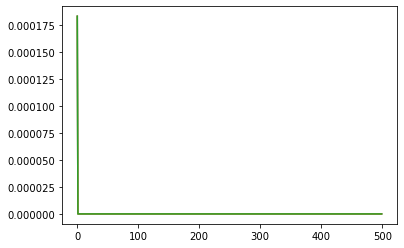

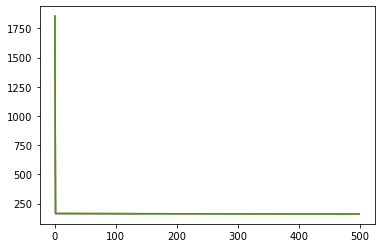

In [35]:
# Figure (dj_dk, cost  functional)
z = np.arange(0, Zmax-1, 1)
n_djdk = np.zeros([Zmax-1, r])
J_Tl = np.zeros([Zmax-1, r])
del id
for id in range(0, Zmax-1):
    norm_djdk = np.linalg.norm(djdk_d[0:2*n,0:2*n,id])
    n_djdk[id,:] = norm_djdk
    J_T = J_cd[len(t)-1,:,id]
    J_Tl[id, :] = J_T
plt.figure()
plt.plot(z, n_djdk)
plt.figure()
plt.plot(z, J_Tl)

In [197]:
# Maximum value of response
for i in range(0,n):
    print("Peak Dis of floor:", i+1, "Uncontrolled:", max(xo[:,i], key=abs), "Optimal-P:", max(xp2[:,i], key=abs), "PG-P:", max(xd[:,i,Zmax-2], key=abs))
    print("Peak Vel of floor:", i+1, "Uncontrolled:", max(xo[:,n+i], key=abs), "Optimal-P:", max(xp2[:,n+i], key=abs), "PG-P:", max(xd[:,n+i,Zmax-2], key=abs))
    print("Peak Acc of floor:", i+1, "Uncontrolled:", max(yo[:,i], key=abs), "Optimal-P:", max(yp2[:,i], key=abs), "PG-P:", max(yp_zmax.T[:,i], key=abs))


Peak Dis of floor: 1 Uncontrolled: -0.13649317850101264 Optimal-P: 0.07922426980336206 PG-P: -0.03905923003375268
Peak Vel of floor: 1 Uncontrolled: 0.8027861019342641 Optimal-P: 0.4659887636403247 PG-P: 0.22675360485333462
Peak Acc of floor: 1 Uncontrolled: 4.601090269695647 Optimal-P: -2.576124297021278 PG-P: [1.63472727]
Peak Dis of floor: 2 Uncontrolled: 0.26845053929628654 Optimal-P: 0.15605987769582666 PG-P: 0.07665929646904371
Peak Vel of floor: 2 Uncontrolled: 1.578935484134537 Optimal-P: -0.9178814397660193 PG-P: -0.44542637734732854
Peak Acc of floor: 2 Uncontrolled: 9.059135389357866 Optimal-P: -5.332081905864465 PG-P: [-2.76634221]
Peak Dis of floor: 3 Uncontrolled: 0.39135849724268135 Optimal-P: -0.22767104126633872 PG-P: 0.11156131921458232
Peak Vel of floor: 3 Uncontrolled: -2.3018791542247214 Optimal-P: 1.339113146460524 PG-P: -0.6487127718255702
Peak Acc of floor: 3 Uncontrolled: 13.265269781074437 Optimal-P: -7.92988775753897 PG-P: [-3.89526288]
Peak Dis of floor: 4 U